In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import time

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, UpSampling2D, LeakyReLU, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import imageio
import glob
import imageio.v2 as imageio
from tqdm import tqdm
import pickle
import cv2


In [ ]:
def residual_block(x):
    """
    Residual block
    """
    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"

    res = Conv2D(filters=filters[0], kernel_size=kernel_size, strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    # Add res and x
    res = Add()([res, x])
    return res

def build_generator():
    """
    Create a generator network using the hyperparameter values defined below
    :return:
    """
    residual_blocks = 16
    momentum = 0.8
    input_shape = (64, 64, 3)

    # Input Layer of the generator network
    input_layer = Input(shape=input_shape)

    # Add the pre-residual block
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)

    # Add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)

    # Add the post-residual block
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)

    # Take the sum of the output from the pre-residual block(gen1) and the post-residual block(gen2)
    gen3 = Add()([gen2, gen1])

    # Add an upsampling block
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)

    # Add another upsampling block
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)


    # Add additional upsampling block
    gen5 = UpSampling2D(size=2)(gen5)  # additional Upsampling
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)

    # Output convolution layer
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)

    # Keras model
    model = Model(inputs=[input_layer], outputs=[output], name='generator')
    return model


def build_discriminator():
    """
    Create a discriminator network using the hyperparameter values defined below
    :return:
    """
    leakyrelu_alpha = 0.2
    momentum = 0.8
    # input_shape = (256, 256, 3)
    input_shape = (512, 512, 3)  # Discriminator의 입력 크기를 변경


    input_layer = Input(shape=input_shape)

    # Add the first convolution block
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    # Add the 2nd convolution block
    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)

    # Add the third convolution block
    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)

    # Add the fourth convolution block
    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)

    # Add the fifth convolution block
    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)

    # Add the sixth convolution block
    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)

    # Add the seventh convolution block
    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)

    # Add the eight convolution block
    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)

    # Add a dense layer
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)

    # Last dense layer - for classification
    output = Dense(units=1, activation='sigmoid')(dis9)

    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    return model

def build_vgg():
    """
    Build VGG network to extract image features
    """
    # input_shape = (256, 256, 3)

    input_shape = (512, 512, 3)


    # Load a pre-trained VGG19 model trained on 'Imagenet' dataset
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=input_shape)

    # Select the output layer to extract features from
    output = vgg.get_layer('block5_conv4').output

    # Create a Keras model
    model = Model(inputs=vgg.input, outputs=output)
    return model

def sample_images(data_dir, batch_size, high_resolution_shape, low_resolution_shape):
    # Make a list of all images inside the data directory
    all_images = glob.glob(data_dir)

    # Choose a random batch of images
    images_batch = np.random.choice(all_images, size=batch_size)

    low_resolution_images = []
    high_resolution_images = []

    for img in images_batch:
        # Get an ndarray of the current image
        img1 = imageio.imread(img)
        img1 = img1.astype(np.float32)

        # Resize the image
        img1_high_resolution = tf.image.resize(img1, (high_resolution_shape[0], high_resolution_shape[1]))
        img1_low_resolution = tf.image.resize(img1, (low_resolution_shape[0], low_resolution_shape[1]))

        # Do a random horizontal flip
        if np.random.random() < 0.5:
            img1_high_resolution = tf.image.flip_left_right(img1_high_resolution)
            img1_low_resolution = tf.image.flip_left_right(img1_low_resolution)

        high_resolution_images.append(img1_high_resolution)
        low_resolution_images.append(img1_low_resolution)

    # Convert the lists to Numpy NDArrays
    return np.array(high_resolution_images), np.array(low_resolution_images)

In [ ]:
def sample_images2(data_dir, batch_size, high_resolution_shape, low_resolution_shape):
    # Make a list of all images inside the data directory
    all_images = glob.glob(data_dir)

    # Choose a random batch of images
    images_batch = np.random.choice(all_images, size=batch_size)

    low_resolution_images = []
    high_resolution_images = []

    for img in images_batch:
        # Get an ndarray of the current image
        img1 = imageio.imread(img)
        img1 = img1.astype(np.float32)

        # Resize the image
        img1_high_resolution = tf.image.resize(img1, (high_resolution_shape[0], high_resolution_shape[1]))
        img1_low_resolution = tf.image.resize(img1, (low_resolution_shape[0], low_resolution_shape[1]))

        # Do a random brighteness
        if np.random.random() < 0.5: # 0.7, 1.3
            alpha_value = np.random.random() + 0.7
            img1_high_resolution = cv2.convertScaleAbs(img1_high_resolution.numpy(), alpha=alpha_value, beta=0)
            img1_low_resolution = cv2.convertScaleAbs(img1_low_resolution.numpy(), alpha=alpha_value, beta=0)

        # Do a random salt-pepper noise
        if np.random.random() < 0.5:
            p = np.random.choice(np.linspace(0, 0.01, 10))
            thres = 1 - p
            for i in range(img1_high_resolution.shape[0]):
                for j in range(img1_high_resolution.shape[1]):
                    rdn = np.random.random()
                        if rdn < p:
                            img1_high_resolution[i][j] = 0
                            img1_low_resolution[i][j] = 0
                        elif rdn > thres:
                            img1_high_resolution[i][j] = 255
                            img1_low_resolution[i][j] = 255

        # Do a random snow noise
        if np.random.random() < 0.5:
            snow_intensity = np.random.choice(np.arange(100, 300, 100))
            direction = 60  # 눈 방향 설정
            for _ in range(snow_intensity):
                x = np.random.randint(0, img1_high_resolution.shape[1])
                y = np.random.randint(0, img1_high_resolution.shape[0])
                length = np.random.randint(1, 4)
                thickness = np.random.randint(1, 3)

                end_x = int(x + length * np.cos(np.radians(direction)))
                end_y = int(y + length * np.sin(np.radians(direction)))

                color = (255, 255, 255)  # 흰색으로 설정
                cv2.line(img1_high_resolution, (x, y), (end_x, end_y), color, thickness)
                cv2.line(img1_low_resolution, (x, y), (end_x, end_y), color, thickness)


        high_resolution_images.append(img1_high_resolution)
        low_resolution_images.append(img1_low_resolution)

    # Convert the lists to Numpy NDArrays
    return np.array(high_resolution_images), np.array(low_resolution_images)


In [ ]:
if __name__ == '__main__':
    data_dir = "/content/drive/train_data/*.*"
    epochs = 30000
    start = 0
    batch_size = 9
    mode = 'train'

    d_loss_list = []
    g_loss_list = []

    # Shape of low-resolution and high-resolution images
    low_resolution_shape = (64, 64, 3)
    high_resolution_shape = (512, 512, 3)

    # Common optimizer for all networks
    common_optimizer = tf.keras.optimizers.legacy.Adam(0.0002, 0.5)

    if mode == 'train':
        # Build and compile VGG19 network to extract features
        vgg = build_vgg()
        vgg.trainable = False
        vgg.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

        # Build and compile the discriminator network
        discriminator = build_discriminator()
        discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

        # Build the generator network
        generator = build_generator()

        try:
            print('load well')
            generator.load_weights(f"/content/drive/generator_epoch_{start}.h5")  # XXX는 불러올 에포크 번호
            discriminator.load_weights(f"/content/drive/discriminator_epoch_{start}.h5")
        except Exception as e:
            print("가중치를 불러오는 데 실패했습니다. 새로운 훈련을 시작합니다.")
            print(e)

        """
        Build and compile the adversarial model
        """

        # Input layers for high-resolution and low-resolution images
        input_high_resolution = Input(shape=high_resolution_shape)
        input_low_resolution = Input(shape=low_resolution_shape)

        # Generate high-resolution images from low-resolution images
        generated_high_resolution_images = generator(input_low_resolution)

        # Extract feature maps of the generated images
        features = vgg(generated_high_resolution_images)

        # Make the discriminator network as non-trainable
        discriminator.trainable = False

        # Get the probability of generated high-resolution images
        probs = discriminator(generated_high_resolution_images)

        # Create and compile an adversarial model
        adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])
        adversarial_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=common_optimizer)

        for epoch in tqdm(range(epochs)):
            print("Epoch:{}".format(epoch))

            """
            Train the discriminator network
            """

            # Sample a batch of images
            high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                          low_resolution_shape=low_resolution_shape,
                                                                          high_resolution_shape=high_resolution_shape)
            # Normalize images
            high_resolution_images = high_resolution_images / 127.5 - 1.
            low_resolution_images = low_resolution_images / 127.5 - 1.

            # Generate high-resolution images from low-resolution images
            generated_high_resolution_images = generator.predict(low_resolution_images)


            # Generate batch of real and fake labels
            real_labels = np.ones((batch_size, 32, 32, 1))
            fake_labels = np.zeros((batch_size, 32, 32, 1))

            # Train the discriminator network on real and fake images
            d_loss_real = discriminator.train_on_batch(high_resolution_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)

            # Calculate total discriminator loss
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            print("d_loss:", d_loss)

            """
            Train the generator network
            """

            # Sample a batch of images
            high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                          low_resolution_shape=low_resolution_shape,
                                                                          high_resolution_shape=high_resolution_shape)
            # Normalize images
            high_resolution_images = high_resolution_images / 127.5 - 1.
            low_resolution_images = low_resolution_images / 127.5 - 1.

            # Extract feature maps for real high-resolution images
            image_features = vgg.predict(high_resolution_images)

            # Train the generator network
            g_loss = adversarial_model.train_on_batch([low_resolution_images, high_resolution_images],
                                             [real_labels, image_features])

            print("g_loss:", g_loss)

            # Write the losses to Tensorboard
            log_dir = "logs/{}".format(time.time())


            g_loss_list.append(g_loss)
            d_loss_list.append(d_loss)

            if (epoch + 1) % 1000 == 0:  # 매 1000 에포크마다 모델 저장
                generator.save_weights(f"/content/drive/generator_epoch_{start+epoch + 1}.h5")
                discriminator.save_weights(f"/content/drive/discriminator_epoch_{start+epoch + 1}.h5")

                with open(f'/content/drive/d_loss_epoch_{start+epoch + 1}.pkl', 'wb') as file:
                    pickle.dump(d_loss_list, file)

                with open(f'/content/drive/g_loss_epoch_{start+epoch + 1}.pkl', 'wb') as file:
                    pickle.dump(g_loss_list, file)



80134624/80134624 [==============================] - 2s 0us/step
load well


  0%|          | 0/9000 [00:00<?, ?it/s]

Epoch:0
1/1 [==============================] - 9s 9s/step
d_loss: [1.4905967e-04 1.0000000e+00]
1/1 [==============================] - 1s 616ms/step


  0%|          | 1/9000 [01:04<162:03:52, 64.83s/it]

g_loss: [0.02624463103711605, 0.6262398362159729, 0.02561839111149311]
Epoch:1
1/1 [==============================] - 0s 29ms/step
d_loss: [0.00659649 0.99316406]
1/1 [==============================] - 0s 61ms/step


  0%|          | 2/9000 [01:06<68:59:02, 27.60s/it] 

g_loss: [0.01698744110763073, 0.14800631999969482, 0.016839435324072838]
Epoch:2
1/1 [==============================] - 0s 29ms/step
d_loss: [3.48312024e-04 1.00000000e+00]
1/1 [==============================] - 0s 32ms/step


  0%|          | 3/9000 [01:08<39:24:55, 15.77s/it]

g_loss: [0.025087136775255203, 0.29889577627182007, 0.02478824183344841]
Epoch:3
1/1 [==============================] - 0s 46ms/step
d_loss: [1.08646338e-04 1.00000000e+00]
1/1 [==============================] - 0s 31ms/step


  0%|          | 4/9000 [01:09<25:28:23, 10.19s/it]

g_loss: [0.02096697874367237, 0.39640140533447266, 0.020570578053593636]
Epoch:4
1/1 [==============================] - 0s 43ms/step
d_loss: [0.02005263 0.97851562]
1/1 [==============================] - 0s 32ms/step


  0%|          | 5/9000 [01:11<17:44:54,  7.10s/it]

g_loss: [0.01864873245358467, 0.08478102087974548, 0.018563952296972275]
Epoch:5
1/1 [==============================] - 0s 26ms/step
d_loss: [0.22197069 0.66064453]
1/1 [==============================] - 0s 24ms/step


  0%|          | 6/9000 [01:12<12:59:21,  5.20s/it]

g_loss: [0.01081837248057127, 0.014711194671690464, 0.010803661309182644]
Epoch:6
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00617565 0.99853516]
1/1 [==============================] - 0s 23ms/step


  0%|          | 7/9000 [01:14<9:45:46,  3.91s/it] 

g_loss: [0.008557766675949097, 0.01729271188378334, 0.008540473878383636]
Epoch:7
1/1 [==============================] - 0s 28ms/step
d_loss: [0.163349   0.77832031]
1/1 [==============================] - 0s 19ms/step


  0%|          | 8/9000 [01:15<7:51:57,  3.15s/it]

g_loss: [0.02419968694448471, 0.016651596873998642, 0.024183034896850586]
Epoch:8
1/1 [==============================] - 0s 30ms/step
d_loss: [0.05589573 0.92871094]
1/1 [==============================] - 0s 20ms/step


  0%|          | 9/9000 [01:17<6:32:38,  2.62s/it]

g_loss: [0.03952031582593918, 0.0007830371614545584, 0.0395195335149765]
Epoch:9
1/1 [==============================] - 0s 28ms/step
d_loss: [0.09481957 0.85986328]
1/1 [==============================] - 0s 19ms/step


  0%|          | 10/9000 [01:18<5:47:07,  2.32s/it]

g_loss: [0.008259890601038933, 0.024391399696469307, 0.008235499262809753]
Epoch:10
1/1 [==============================] - 0s 32ms/step
d_loss: [0.00490922 0.99560547]
1/1 [==============================] - 0s 22ms/step


  0%|          | 11/9000 [01:20<5:07:16,  2.05s/it]

g_loss: [0.02267470769584179, 1.235729455947876, 0.021438978612422943]
Epoch:11
1/1 [==============================] - 0s 25ms/step
d_loss: [2.87552073e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  0%|          | 12/9000 [01:21<4:48:00,  1.92s/it]

g_loss: [0.031139139086008072, 2.223890542984009, 0.028915248811244965]
Epoch:12
1/1 [==============================] - 0s 40ms/step
d_loss: [0.00662485 0.99658203]
1/1 [==============================] - 0s 31ms/step


  0%|          | 13/9000 [01:23<4:34:50,  1.83s/it]

g_loss: [0.028263088315725327, 2.51302433013916, 0.025750063359737396]
Epoch:13
1/1 [==============================] - 0s 43ms/step
d_loss: [0.06759727 0.92041016]
1/1 [==============================] - 0s 33ms/step


  0%|          | 14/9000 [01:24<4:23:00,  1.76s/it]

g_loss: [0.04552088677883148, 1.6000733375549316, 0.043920814990997314]
Epoch:14
1/1 [==============================] - 0s 43ms/step
d_loss: [0.11597794 0.84326172]
1/1 [==============================] - 0s 20ms/step


  0%|          | 15/9000 [01:26<4:11:24,  1.68s/it]

g_loss: [0.027026398107409477, 1.6397491693496704, 0.025386648252606392]
Epoch:15
1/1 [==============================] - 0s 27ms/step
d_loss: [0.09148714 0.90429688]
1/1 [==============================] - 0s 21ms/step


  0%|          | 16/9000 [01:28<4:07:52,  1.66s/it]

g_loss: [0.01588144712150097, 1.2801874876022339, 0.014601260423660278]
Epoch:16
1/1 [==============================] - 0s 26ms/step
d_loss: [0.40734376 0.50537109]
1/1 [==============================] - 0s 53ms/step


  0%|          | 17/9000 [01:29<4:07:16,  1.65s/it]

g_loss: [0.007727432996034622, 0.10149724781513214, 0.007625935599207878]
Epoch:17
1/1 [==============================] - 0s 28ms/step
d_loss: [0.50122364 0.40478516]
1/1 [==============================] - 0s 23ms/step


  0%|          | 18/9000 [01:51<18:53:30,  7.57s/it]

g_loss: [0.023116422817111015, 0.3717712163925171, 0.02274465188384056]
Epoch:18
1/1 [==============================] - 0s 27ms/step
d_loss: [0.20836098 0.7578125 ]
1/1 [==============================] - 0s 26ms/step


  0%|          | 19/9000 [01:51<13:37:24,  5.46s/it]

g_loss: [0.012748818844556808, 0.00014587222540285438, 0.012748672626912594]
Epoch:19
1/1 [==============================] - 0s 26ms/step
d_loss: [0.14286202 0.8046875 ]
1/1 [==============================] - 0s 37ms/step


  0%|          | 20/9000 [01:52<10:05:12,  4.04s/it]

g_loss: [0.008518964052200317, 0.003175843507051468, 0.008515788242220879]
Epoch:20
1/1 [==============================] - 0s 58ms/step
d_loss: [0.00206232 0.99902344]
1/1 [==============================] - 0s 40ms/step


  0%|          | 21/9000 [01:53<7:38:07,  3.06s/it] 

g_loss: [0.007994388230144978, 0.25674888491630554, 0.007737639360129833]
Epoch:21
1/1 [==============================] - 0s 48ms/step
d_loss: [0.06731876 0.91357422]
1/1 [==============================] - 0s 33ms/step


  0%|          | 22/9000 [01:53<5:54:35,  2.37s/it]

g_loss: [0.013974873349070549, 0.11287935823202133, 0.01386199425905943]
Epoch:22
1/1 [==============================] - 0s 45ms/step
d_loss: [0.00944414 0.99316406]
1/1 [==============================] - 0s 30ms/step


  0%|          | 23/9000 [01:54<4:38:02,  1.86s/it]

g_loss: [0.006952281575649977, 0.11374066025018692, 0.006838541012257338]
Epoch:23
1/1 [==============================] - 0s 38ms/step
d_loss: [0.004677   0.99755859]
1/1 [==============================] - 0s 32ms/step


  0%|          | 24/9000 [01:55<3:44:30,  1.50s/it]

g_loss: [0.004752688109874725, 0.2539094388484955, 0.004498778842389584]
Epoch:24
1/1 [==============================] - 0s 50ms/step
d_loss: [0.00210319 1.        ]
1/1 [==============================] - 0s 41ms/step


  0%|          | 25/9000 [01:56<3:21:09,  1.34s/it]

g_loss: [0.006213074550032616, 0.5141533017158508, 0.005698921158909798]
Epoch:25
1/1 [==============================] - 0s 40ms/step
d_loss: [0.11527958 0.81640625]
1/1 [==============================] - 0s 36ms/step


  0%|          | 26/9000 [01:57<2:59:33,  1.20s/it]

g_loss: [0.0254950113594532, 1.3019813299179077, 0.02419302985072136]
Epoch:26
1/1 [==============================] - 0s 38ms/step
d_loss: [0.17574998 0.76708984]
1/1 [==============================] - 0s 30ms/step


  0%|          | 27/9000 [01:57<2:36:27,  1.05s/it]

g_loss: [0.011259409599006176, 1.76985764503479, 0.009489552117884159]
Epoch:27
1/1 [==============================] - 0s 39ms/step
d_loss: [0.41926357 0.43701172]
1/1 [==============================] - 0s 21ms/step


  0%|          | 28/9000 [01:58<2:18:48,  1.08it/s]

g_loss: [0.007663483265787363, 1.3778038024902344, 0.006285679526627064]
Epoch:28
1/1 [==============================] - 0s 25ms/step
d_loss: [0.39274377 0.48095703]
1/1 [==============================] - 0s 20ms/step


  0%|          | 29/9000 [01:59<2:09:08,  1.16it/s]

g_loss: [0.021599238738417625, 0.003254839451983571, 0.02159598469734192]
Epoch:29
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00465366 0.99707031]
1/1 [==============================] - 0s 20ms/step


  0%|          | 30/9000 [01:59<1:54:45,  1.30it/s]

g_loss: [0.0134618254378438, 0.013679774478077888, 0.013448145240545273]
Epoch:30
1/1 [==============================] - 0s 26ms/step
d_loss: [0.03704147 0.95898438]
1/1 [==============================] - 0s 23ms/step


  0%|          | 31/9000 [02:00<1:43:47,  1.44it/s]

g_loss: [0.021294115111231804, 0.7461743950843811, 0.020547941327095032]
Epoch:31
1/1 [==============================] - 0s 24ms/step
d_loss: [0.08387848 0.90380859]
1/1 [==============================] - 0s 25ms/step


  0%|          | 32/9000 [02:00<1:36:41,  1.55it/s]

g_loss: [0.02986704185605049, 1.459275484085083, 0.028407765552401543]
Epoch:32
1/1 [==============================] - 0s 25ms/step
d_loss: [0.40703714 0.47753906]
1/1 [==============================] - 0s 23ms/step


  0%|          | 33/9000 [02:01<1:32:52,  1.61it/s]

g_loss: [0.019809259101748466, 0.0013517746701836586, 0.019807906821370125]
Epoch:33
1/1 [==============================] - 0s 28ms/step
d_loss: [0.24570748 0.6640625 ]
1/1 [==============================] - 0s 26ms/step


  0%|          | 34/9000 [02:01<1:28:08,  1.70it/s]

g_loss: [0.01598072610795498, 0.013541602529585361, 0.01596718467772007]
Epoch:34
1/1 [==============================] - 0s 32ms/step
d_loss: [0.1685485  0.76318359]
1/1 [==============================] - 0s 22ms/step


  0%|          | 35/9000 [02:02<1:26:48,  1.72it/s]

g_loss: [0.008263492956757545, 0.013799532316625118, 0.008249693550169468]
Epoch:35
1/1 [==============================] - 0s 26ms/step
d_loss: [0.12030978 0.84179688]
1/1 [==============================] - 0s 22ms/step


  0%|          | 36/9000 [02:02<1:23:58,  1.78it/s]

g_loss: [0.024233439937233925, 0.009223172441124916, 0.024224216118454933]
Epoch:36
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02388444 0.96923828]
1/1 [==============================] - 0s 23ms/step


  0%|          | 37/9000 [02:03<1:22:18,  1.81it/s]

g_loss: [0.030488355085253716, 0.06165534630417824, 0.03042669966816902]
Epoch:37
1/1 [==============================] - 0s 25ms/step
d_loss: [0.29654822 0.57958984]
1/1 [==============================] - 0s 20ms/step


  0%|          | 38/9000 [02:03<1:20:43,  1.85it/s]

g_loss: [0.01929492875933647, 0.07484602183103561, 0.019220082089304924]
Epoch:38
1/1 [==============================] - 0s 26ms/step
d_loss: [4.74965596e-04 1.00000000e+00]
1/1 [==============================] - 0s 26ms/step


  0%|          | 39/9000 [02:04<1:20:30,  1.86it/s]

g_loss: [0.012727469205856323, 2.259226083755493, 0.010468242689967155]
Epoch:39
1/1 [==============================] - 0s 25ms/step
d_loss: [0.03646231 0.94140625]
1/1 [==============================] - 0s 21ms/step


  0%|          | 40/9000 [02:04<1:18:44,  1.90it/s]

g_loss: [0.03311125934123993, 1.3715585470199585, 0.031739700585603714]
Epoch:40
1/1 [==============================] - 0s 28ms/step
d_loss: [0.49893226 0.5       ]
1/1 [==============================] - 0s 28ms/step


  0%|          | 41/9000 [02:05<1:18:18,  1.91it/s]

g_loss: [0.029452677816152573, 4.419111728668213, 0.02503356523811817]
Epoch:41
1/1 [==============================] - 0s 28ms/step
d_loss: [0.01061066 0.99609375]
1/1 [==============================] - 0s 22ms/step


  0%|          | 42/9000 [02:06<1:28:34,  1.69it/s]

g_loss: [0.00998087041079998, 2.993053913116455, 0.006987816654145718]
Epoch:42
1/1 [==============================] - 0s 25ms/step
d_loss: [0.01057736 0.99511719]
1/1 [==============================] - 0s 21ms/step


  0%|          | 43/9000 [02:06<1:26:18,  1.73it/s]

g_loss: [0.01391889899969101, 2.162724256515503, 0.011756174266338348]
Epoch:43
1/1 [==============================] - 0s 28ms/step
d_loss: [0.01383358 0.99853516]
1/1 [==============================] - 0s 27ms/step


  0%|          | 44/9000 [02:07<1:27:02,  1.72it/s]

g_loss: [0.006228157784789801, 1.9190244674682617, 0.004309133160859346]
Epoch:44
1/1 [==============================] - 0s 25ms/step
d_loss: [6.2061215e-04 1.0000000e+00]
1/1 [==============================] - 0s 20ms/step


  0%|          | 45/9000 [02:07<1:23:28,  1.79it/s]

g_loss: [0.048572443425655365, 1.6595901250839233, 0.04691285267472267]
Epoch:45
1/1 [==============================] - 0s 26ms/step
d_loss: [9.51030081e-04 1.00000000e+00]
1/1 [==============================] - 0s 40ms/step


  1%|          | 46/9000 [02:08<1:31:58,  1.62it/s]

g_loss: [0.030730320140719414, 1.7450430393218994, 0.02898527681827545]
Epoch:46
1/1 [==============================] - 0s 39ms/step
d_loss: [0.49725457 0.5       ]
1/1 [==============================] - 0s 29ms/step


  1%|          | 47/9000 [02:09<1:36:25,  1.55it/s]

g_loss: [0.02567296288907528, 4.170712471008301, 0.02150225080549717]
Epoch:47
1/1 [==============================] - 0s 38ms/step
d_loss: [0.00306059 1.        ]
1/1 [==============================] - 0s 32ms/step


  1%|          | 48/9000 [02:10<1:38:09,  1.52it/s]

g_loss: [0.018672030419111252, 3.508432388305664, 0.015163597650825977]
Epoch:48
1/1 [==============================] - 0s 46ms/step
d_loss: [5.42880307e-05 1.00000000e+00]
1/1 [==============================] - 0s 32ms/step


  1%|          | 49/9000 [02:10<1:46:21,  1.40it/s]

g_loss: [0.01116249430924654, 2.1529905796051025, 0.00900950375944376]
Epoch:49
1/1 [==============================] - 0s 38ms/step
d_loss: [0.00243074 1.        ]
1/1 [==============================] - 0s 39ms/step


  1%|          | 50/9000 [02:11<1:47:14,  1.39it/s]

g_loss: [0.02912323735654354, 1.3429385423660278, 0.02778029814362526]
Epoch:50
1/1 [==============================] - 0s 107ms/step
d_loss: [0.0016036 1.       ]
1/1 [==============================] - 0s 38ms/step


  1%|          | 51/9000 [02:13<2:25:13,  1.03it/s]

g_loss: [0.013401519507169724, 1.3594125509262085, 0.012042107060551643]
Epoch:51
1/1 [==============================] - 0s 179ms/step
d_loss: [4.90593284e-05 1.00000000e+00]
1/1 [==============================] - 0s 28ms/step


  1%|          | 52/9000 [02:14<2:51:22,  1.15s/it]

g_loss: [0.030040601268410683, 0.757048487663269, 0.0292835533618927]
Epoch:52
1/1 [==============================] - 0s 26ms/step
d_loss: [3.93569769e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  1%|          | 53/9000 [02:15<2:22:35,  1.05it/s]

g_loss: [0.012941832654178143, 0.66282719373703, 0.012279005721211433]
Epoch:53
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00106064 1.        ]
1/1 [==============================] - 0s 20ms/step


  1%|          | 54/9000 [02:15<2:03:56,  1.20it/s]

g_loss: [0.020037779584527016, 0.7507547736167908, 0.019287025555968285]
Epoch:54
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00111593 1.        ]
1/1 [==============================] - 0s 25ms/step


  1%|          | 55/9000 [02:16<1:49:39,  1.36it/s]

g_loss: [0.0068882224150002, 0.7760874032974243, 0.006112135015428066]
Epoch:55
1/1 [==============================] - 0s 35ms/step
d_loss: [7.47222439e-05 1.00000000e+00]
1/1 [==============================] - 0s 25ms/step


  1%|          | 56/9000 [02:16<1:40:22,  1.49it/s]

g_loss: [0.02550668641924858, 0.2472848892211914, 0.02525940164923668]
Epoch:56
1/1 [==============================] - 0s 27ms/step
d_loss: [6.64783474e-05 1.00000000e+00]
1/1 [==============================] - 0s 25ms/step


  1%|          | 57/9000 [02:17<1:33:44,  1.59it/s]

g_loss: [0.011069010943174362, 0.5122718811035156, 0.010556738823652267]
Epoch:57
1/1 [==============================] - 0s 26ms/step
d_loss: [2.96181301e-04 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  1%|          | 58/9000 [02:17<1:28:50,  1.68it/s]

g_loss: [0.006509948987513781, 0.3056938648223877, 0.006204254925251007]
Epoch:58
1/1 [==============================] - 0s 26ms/step
d_loss: [1.54588233e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  1%|          | 59/9000 [02:18<1:26:42,  1.72it/s]

g_loss: [0.010042729787528515, 0.3607553541660309, 0.009681974537670612]
Epoch:59
1/1 [==============================] - 0s 26ms/step
d_loss: [0.48415418 0.49951172]
1/1 [==============================] - 0s 25ms/step


  1%|          | 60/9000 [02:18<1:23:51,  1.78it/s]

g_loss: [0.02317388355731964, 2.5341789722442627, 0.020639704540371895]
Epoch:60
1/1 [==============================] - 0s 27ms/step
d_loss: [5.57575055e-04 1.00000000e+00]
1/1 [==============================] - 0s 23ms/step


  1%|          | 61/9000 [02:19<1:21:34,  1.83it/s]

g_loss: [0.040071312338113785, 1.2189480066299438, 0.03885236382484436]
Epoch:61
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01059981 0.99365234]
1/1 [==============================] - 0s 22ms/step


  1%|          | 62/9000 [02:19<1:20:16,  1.86it/s]

g_loss: [0.02567453682422638, 0.41527801752090454, 0.02525925822556019]
Epoch:62
1/1 [==============================] - 0s 27ms/step
d_loss: [0.05508028 0.92041016]
1/1 [==============================] - 0s 23ms/step


  1%|          | 63/9000 [02:20<1:25:19,  1.75it/s]

g_loss: [0.03191829472780228, 1.0049623250961304, 0.030913330614566803]
Epoch:63
1/1 [==============================] - 0s 29ms/step
d_loss: [3.36970988e-05 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  1%|          | 64/9000 [02:21<1:22:40,  1.80it/s]

g_loss: [0.010898327454924583, 4.132480144500732, 0.006765847094357014]
Epoch:64
1/1 [==============================] - 0s 27ms/step
d_loss: [1.33829431e-04 1.00000000e+00]
1/1 [==============================] - 0s 28ms/step


  1%|          | 65/9000 [02:21<1:20:58,  1.84it/s]

g_loss: [0.03212427347898483, 4.3463029861450195, 0.02777797169983387]
Epoch:65
1/1 [==============================] - 0s 26ms/step
d_loss: [4.36695221e-04 1.00000000e+00]
1/1 [==============================] - 0s 24ms/step


  1%|          | 66/9000 [02:22<1:19:51,  1.86it/s]

g_loss: [0.025311637669801712, 2.729372978210449, 0.022582264617085457]
Epoch:66
1/1 [==============================] - 0s 29ms/step
d_loss: [0.00337273 1.        ]
1/1 [==============================] - 0s 25ms/step


  1%|          | 67/9000 [02:22<1:19:53,  1.86it/s]

g_loss: [0.026585614308714867, 2.6118147373199463, 0.023973800241947174]
Epoch:67
1/1 [==============================] - 0s 27ms/step
d_loss: [0.39073413 0.54248047]
1/1 [==============================] - 0s 25ms/step


  1%|          | 68/9000 [02:23<1:18:48,  1.89it/s]

g_loss: [0.02434205822646618, 6.247159481048584, 0.018094899132847786]
Epoch:68
1/1 [==============================] - 0s 28ms/step
d_loss: [0.10012717 0.84179688]
1/1 [==============================] - 0s 22ms/step


  1%|          | 69/9000 [02:23<1:20:15,  1.85it/s]

g_loss: [0.02988664247095585, 5.4113616943359375, 0.024475280195474625]
Epoch:69
1/1 [==============================] - 0s 28ms/step
d_loss: [6.16875268e-05 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


  1%|          | 70/9000 [02:24<1:21:05,  1.84it/s]

g_loss: [0.02387024462223053, 2.6855578422546387, 0.021184686571359634]
Epoch:70
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00415239 0.99609375]
1/1 [==============================] - 0s 23ms/step


  1%|          | 71/9000 [02:25<1:27:21,  1.70it/s]

g_loss: [0.008038850501179695, 1.2954788208007812, 0.006743371952325106]
Epoch:71
1/1 [==============================] - 0s 42ms/step
d_loss: [1.49525615e-04 1.00000000e+00]
1/1 [==============================] - 0s 30ms/step


  1%|          | 72/9000 [02:25<1:31:48,  1.62it/s]

g_loss: [0.027130771428346634, 0.40248051285743713, 0.02672829106450081]
Epoch:72
1/1 [==============================] - 0s 40ms/step
d_loss: [8.38396722e-04 1.00000000e+00]
1/1 [==============================] - 0s 44ms/step


  1%|          | 73/9000 [02:26<1:42:18,  1.45it/s]

g_loss: [0.00872625969350338, 0.6225541234016418, 0.008103705942630768]
Epoch:73
1/1 [==============================] - 0s 41ms/step
d_loss: [8.19842735e-05 1.00000000e+00]
1/1 [==============================] - 0s 28ms/step


  1%|          | 74/9000 [02:27<1:44:09,  1.43it/s]

g_loss: [0.01644199900329113, 0.3181740343570709, 0.016123825684189796]
Epoch:74
1/1 [==============================] - 0s 38ms/step
d_loss: [5.77933715e-05 1.00000000e+00]
1/1 [==============================] - 0s 54ms/step


  1%|          | 75/9000 [02:27<1:42:58,  1.44it/s]

g_loss: [0.004954859614372253, 0.27343034744262695, 0.004681429360061884]
Epoch:75
1/1 [==============================] - 0s 39ms/step
d_loss: [1.47848859e-05 1.00000000e+00]
1/1 [==============================] - 0s 32ms/step


  1%|          | 76/9000 [02:28<1:48:34,  1.37it/s]

g_loss: [0.0042124101892113686, 0.3642050623893738, 0.0038482050877064466]
Epoch:76
1/1 [==============================] - 0s 40ms/step
d_loss: [0.00247169 1.        ]
1/1 [==============================] - 0s 33ms/step


  1%|          | 77/9000 [02:29<1:52:25,  1.32it/s]

g_loss: [0.014878671616315842, 0.7589120268821716, 0.014119759202003479]
Epoch:77
1/1 [==============================] - 0s 39ms/step
d_loss: [3.87925757e-05 1.00000000e+00]
1/1 [==============================] - 0s 34ms/step


  1%|          | 78/9000 [02:30<1:56:09,  1.28it/s]

g_loss: [0.018268339335918427, 0.5231571197509766, 0.017745181918144226]
Epoch:78
1/1 [==============================] - 0s 38ms/step
d_loss: [2.77834961e-05 1.00000000e+00]
1/1 [==============================] - 0s 26ms/step


  1%|          | 79/9000 [02:30<1:44:45,  1.42it/s]

g_loss: [0.022026043385267258, 0.6270265579223633, 0.021399017423391342]
Epoch:79
1/1 [==============================] - 0s 30ms/step
d_loss: [1.74150689e-04 1.00000000e+00]
1/1 [==============================] - 0s 27ms/step


  1%|          | 80/9000 [02:31<1:36:49,  1.54it/s]

g_loss: [0.005284904967993498, 0.49158215522766113, 0.004793322645127773]
Epoch:80
1/1 [==============================] - 0s 26ms/step
d_loss: [3.43662323e-05 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


  1%|          | 81/9000 [02:31<1:29:59,  1.65it/s]

g_loss: [0.006186269223690033, 0.5307832956314087, 0.005655486136674881]
Epoch:81
1/1 [==============================] - 0s 26ms/step
d_loss: [9.19231854e-04 1.00000000e+00]
1/1 [==============================] - 0s 24ms/step


  1%|          | 82/9000 [02:32<1:26:20,  1.72it/s]

g_loss: [0.010636480525135994, 0.5510576963424683, 0.010085422545671463]
Epoch:82
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00172023 0.99804688]
1/1 [==============================] - 0s 22ms/step


  1%|          | 83/9000 [02:33<1:23:44,  1.77it/s]

g_loss: [0.010331693105399609, 0.6947581768035889, 0.009636934846639633]
Epoch:83
1/1 [==============================] - 0s 28ms/step
d_loss: [0.11531404 0.82519531]
1/1 [==============================] - 0s 21ms/step


  1%|          | 84/9000 [02:33<1:27:23,  1.70it/s]

g_loss: [0.008980385959148407, 0.15059052407741547, 0.008829795755445957]
Epoch:84
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01241079 0.98193359]
1/1 [==============================] - 0s 23ms/step


  1%|          | 85/9000 [02:34<1:24:39,  1.75it/s]

g_loss: [0.02063407376408577, 2.2422361373901367, 0.018391838297247887]
Epoch:85
1/1 [==============================] - 0s 26ms/step
d_loss: [0.48910714 0.5       ]
1/1 [==============================] - 0s 25ms/step


  1%|          | 86/9000 [02:34<1:22:25,  1.80it/s]

g_loss: [0.005445004906505346, 0.9880267381668091, 0.004456978291273117]
Epoch:86
1/1 [==============================] - 0s 25ms/step
d_loss: [0.34667682 0.58300781]
1/1 [==============================] - 0s 22ms/step


  1%|          | 87/9000 [02:35<1:21:06,  1.83it/s]

g_loss: [0.0050398060120642185, 0.5159783959388733, 0.0045238276943564415]
Epoch:87
1/1 [==============================] - 0s 29ms/step
d_loss: [0.02436461 0.97900391]
1/1 [==============================] - 0s 23ms/step


  1%|          | 88/9000 [02:35<1:19:58,  1.86it/s]

g_loss: [0.0346868522465229, 0.31611520051956177, 0.03437073528766632]
Epoch:88
1/1 [==============================] - 0s 26ms/step
d_loss: [1.66412674e-04 1.00000000e+00]
1/1 [==============================] - 0s 24ms/step


  1%|          | 89/9000 [02:36<1:19:40,  1.86it/s]

g_loss: [0.013059930875897408, 0.03288411349058151, 0.01302704680711031]
Epoch:89
1/1 [==============================] - 0s 25ms/step
d_loss: [0.09313647 0.86523438]
1/1 [==============================] - 0s 19ms/step


  1%|          | 90/9000 [02:36<1:20:09,  1.85it/s]

g_loss: [0.022186867892742157, 0.005050732754170895, 0.022181816399097443]
Epoch:90
1/1 [==============================] - 0s 27ms/step
d_loss: [5.9723817e-04 1.0000000e+00]
1/1 [==============================] - 0s 23ms/step


  1%|          | 91/9000 [02:37<1:19:23,  1.87it/s]

g_loss: [0.025749571621418, 0.00021394822397269309, 0.025749357417225838]
Epoch:91
1/1 [==============================] - 0s 29ms/step
d_loss: [1.48014595e-04 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


  1%|          | 92/9000 [02:37<1:23:04,  1.79it/s]

g_loss: [0.014831015840172768, 0.00035690274671651423, 0.01483065914362669]
Epoch:92
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00145572 1.        ]
1/1 [==============================] - 0s 21ms/step


  1%|          | 93/9000 [02:38<1:28:21,  1.68it/s]

g_loss: [0.024945028126239777, 0.0014646366471424699, 0.02494356408715248]
Epoch:93
1/1 [==============================] - 0s 33ms/step
d_loss: [0.00459148 0.99902344]
1/1 [==============================] - 0s 22ms/step


  1%|          | 94/9000 [02:39<1:24:22,  1.76it/s]

g_loss: [0.008491815067827702, 0.0012195265153422952, 0.00849059596657753]
Epoch:94
1/1 [==============================] - 0s 26ms/step
d_loss: [0.12381038 0.81152344]
1/1 [==============================] - 0s 21ms/step


  1%|          | 95/9000 [02:39<1:23:01,  1.79it/s]

g_loss: [0.01733330264687538, 0.952039361000061, 0.016381263732910156]
Epoch:95
1/1 [==============================] - 0s 25ms/step
d_loss: [0.45270836 0.37792969]
1/1 [==============================] - 0s 20ms/step


  1%|          | 96/9000 [02:40<1:21:16,  1.83it/s]

g_loss: [0.03266064450144768, 5.052432060241699, 0.02760821208357811]
Epoch:96
1/1 [==============================] - 0s 53ms/step
d_loss: [3.94934497e-04 1.00000000e+00]
1/1 [==============================] - 0s 35ms/step


  1%|          | 97/9000 [02:40<1:25:36,  1.73it/s]

g_loss: [0.022574350237846375, 0.04891897365450859, 0.022525431588292122]
Epoch:97
1/1 [==============================] - 0s 40ms/step
d_loss: [5.84378577e-04 1.00000000e+00]
1/1 [==============================] - 0s 33ms/step


  1%|          | 98/9000 [02:41<1:36:33,  1.54it/s]

g_loss: [0.021947257220745087, 2.0432744349818677e-05, 0.021947236731648445]
Epoch:98
1/1 [==============================] - 0s 42ms/step
d_loss: [0.00156144 1.        ]
1/1 [==============================] - 0s 31ms/step


  1%|          | 99/9000 [02:42<1:37:50,  1.52it/s]

g_loss: [0.010174015536904335, 1.4920570720278192e-05, 0.010174000635743141]
Epoch:99
1/1 [==============================] - 0s 42ms/step
d_loss: [0.00217072 1.        ]
1/1 [==============================] - 0s 33ms/step


  1%|          | 100/9000 [02:43<1:37:51,  1.52it/s]

g_loss: [0.005051718559116125, 0.013352468609809875, 0.005038366187363863]
Epoch:100
1/1 [==============================] - 0s 39ms/step
d_loss: [5.12817693e-04 1.00000000e+00]
1/1 [==============================] - 0s 29ms/step


  1%|          | 101/9000 [02:43<1:47:06,  1.38it/s]

g_loss: [0.011648060753941536, 2.0510144167928956e-05, 0.011648040264844894]
Epoch:101
1/1 [==============================] - 0s 51ms/step
d_loss: [8.99288185e-04 1.00000000e+00]
1/1 [==============================] - 0s 29ms/step


  1%|          | 102/9000 [02:44<1:53:54,  1.30it/s]

g_loss: [0.01564057543873787, 7.536010525655001e-05, 0.0156405009329319]
Epoch:102
1/1 [==============================] - 0s 40ms/step
d_loss: [0.00859445 0.99853516]
1/1 [==============================] - 0s 42ms/step


  1%|          | 103/9000 [02:45<1:58:28,  1.25it/s]

g_loss: [0.024025961756706238, 0.0002330063289264217, 0.024025728926062584]
Epoch:103
1/1 [==============================] - 0s 40ms/step
d_loss: [0.00213689 0.99853516]
1/1 [==============================] - 0s 32ms/step
g_loss: [0.016336150467395782, 0.0009493468096479774, 0.016335200518369675]


  1%|          | 104/9000 [02:46<1:52:13,  1.32it/s]

Epoch:104
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00733909 0.98876953]
1/1 [==============================] - 0s 24ms/step


  1%|          | 105/9000 [02:46<1:41:14,  1.46it/s]

g_loss: [0.022437846288084984, 0.0013117014896124601, 0.022436534985899925]
Epoch:105
1/1 [==============================] - 0s 27ms/step
d_loss: [8.1033787e-05 1.0000000e+00]
1/1 [==============================] - 0s 26ms/step


  1%|          | 106/9000 [02:47<1:34:32,  1.57it/s]

g_loss: [0.0425955131649971, 0.09173427522182465, 0.042503777891397476]
Epoch:106
1/1 [==============================] - 0s 27ms/step
d_loss: [1.27305972e-04 1.00000000e+00]
1/1 [==============================] - 0s 24ms/step


  1%|          | 107/9000 [02:47<1:29:27,  1.66it/s]

g_loss: [0.02099434845149517, 0.4411170780658722, 0.020553231239318848]
Epoch:107
1/1 [==============================] - 0s 27ms/step
d_loss: [0.14194819 0.73974609]
1/1 [==============================] - 0s 22ms/step


  1%|          | 108/9000 [02:48<1:27:03,  1.70it/s]

g_loss: [0.01486254669725895, 4.960585594177246, 0.00990196131169796]
Epoch:108
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00942312 0.99169922]
1/1 [==============================] - 0s 21ms/step


  1%|          | 109/9000 [02:48<1:25:37,  1.73it/s]

g_loss: [0.03195897862315178, 3.7817001342773438, 0.028177279978990555]
Epoch:109
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00464564 0.99902344]
1/1 [==============================] - 0s 24ms/step


  1%|          | 110/9000 [02:49<1:23:12,  1.78it/s]

g_loss: [0.02587779238820076, 4.130367279052734, 0.021747425198554993]
Epoch:110
1/1 [==============================] - 0s 43ms/step
d_loss: [0.0031113 1.       ]
1/1 [==============================] - 0s 21ms/step


  1%|          | 111/9000 [02:50<1:38:46,  1.50it/s]

g_loss: [0.029445042833685875, 4.153086185455322, 0.025291956961154938]
Epoch:111
1/1 [==============================] - 0s 30ms/step
d_loss: [0.19685348 0.73291016]
1/1 [==============================] - 0s 20ms/step


  1%|          | 112/9000 [02:50<1:31:29,  1.62it/s]

g_loss: [0.024843109771609306, 2.0175371170043945, 0.02282557263970375]
Epoch:112
1/1 [==============================] - 0s 26ms/step
d_loss: [5.01222094e-05 1.00000000e+00]
1/1 [==============================] - 0s 19ms/step


  1%|▏         | 113/9000 [02:51<1:26:21,  1.71it/s]

g_loss: [0.007293525151908398, 1.2304021120071411, 0.006063122767955065]
Epoch:113
1/1 [==============================] - 0s 26ms/step
d_loss: [8.20155856e-05 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  1%|▏         | 114/9000 [02:51<1:23:01,  1.78it/s]

g_loss: [0.009053570218384266, 1.7285534143447876, 0.0073250168934464455]
Epoch:114
1/1 [==============================] - 0s 26ms/step
d_loss: [1.81694813e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  1%|▏         | 115/9000 [02:52<1:20:35,  1.84it/s]

g_loss: [0.01955450512468815, 1.547874927520752, 0.01800663024187088]
Epoch:115
1/1 [==============================] - 0s 28ms/step
d_loss: [6.27434911e-05 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


  1%|▏         | 116/9000 [02:52<1:18:48,  1.88it/s]

g_loss: [0.018366748467087746, 0.8346139192581177, 0.01753213442862034]
Epoch:116
1/1 [==============================] - 0s 25ms/step
d_loss: [1.85927574e-05 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  1%|▏         | 117/9000 [02:53<1:17:42,  1.91it/s]

g_loss: [0.03223079815506935, 0.6750352382659912, 0.03155576437711716]
Epoch:117
1/1 [==============================] - 0s 26ms/step
d_loss: [4.26484103e-05 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  1%|▏         | 118/9000 [02:53<1:17:09,  1.92it/s]

g_loss: [0.005545591004192829, 0.8217073678970337, 0.0047238836996257305]
Epoch:118
1/1 [==============================] - 0s 26ms/step
d_loss: [1.93744081e-04 1.00000000e+00]
1/1 [==============================] - 0s 24ms/step


  1%|▏         | 119/9000 [02:54<1:17:34,  1.91it/s]

g_loss: [0.008415745571255684, 1.0313743352890015, 0.0073843710124492645]
Epoch:119
1/1 [==============================] - 0s 31ms/step
d_loss: [0.3876551  0.53222656]
1/1 [==============================] - 0s 21ms/step


  1%|▏         | 120/9000 [02:55<1:19:53,  1.85it/s]

g_loss: [0.019704198464751244, 1.2801551818847656, 0.01842404343187809]
Epoch:120
1/1 [==============================] - 0s 26ms/step
d_loss: [6.02876986e-04 1.00000000e+00]
1/1 [==============================] - 0s 24ms/step


  1%|▏         | 121/9000 [02:55<1:19:09,  1.87it/s]

g_loss: [0.024585194885730743, 2.6106386184692383, 0.021974556148052216]
Epoch:121
1/1 [==============================] - 0s 25ms/step
d_loss: [0.0851077  0.85644531]
1/1 [==============================] - 0s 20ms/step


  1%|▏         | 122/9000 [02:56<1:19:05,  1.87it/s]

g_loss: [0.022527100518345833, 2.7676427364349365, 0.01975945755839348]
Epoch:122
1/1 [==============================] - 0s 43ms/step
d_loss: [2.35207699e-05 1.00000000e+00]
1/1 [==============================] - 0s 32ms/step


  1%|▏         | 123/9000 [02:56<1:25:46,  1.72it/s]

g_loss: [0.010738158598542213, 2.7215137481689453, 0.008016644977033138]
Epoch:123
1/1 [==============================] - 0s 43ms/step
d_loss: [0.0021747  0.99804688]
1/1 [==============================] - 0s 38ms/step
g_loss: [0.0180070698261261, 1.5020592212677002, 0.016505010426044464]


  1%|▏         | 124/9000 [02:57<1:31:10,  1.62it/s]

Epoch:124
1/1 [==============================] - 0s 39ms/step
d_loss: [3.54285385e-05 1.00000000e+00]
1/1 [==============================] - 0s 32ms/step


  1%|▏         | 125/9000 [02:58<1:35:45,  1.54it/s]

g_loss: [0.024507608264684677, 1.1430257558822632, 0.023364583030343056]
Epoch:125
1/1 [==============================] - 0s 39ms/step
d_loss: [9.3382183e-05 1.0000000e+00]
1/1 [==============================] - 0s 32ms/step


  1%|▏         | 126/9000 [02:59<1:45:02,  1.41it/s]

g_loss: [0.023520341143012047, 0.4860513210296631, 0.023034289479255676]
Epoch:126
1/1 [==============================] - 0s 46ms/step
d_loss: [0.48649736 0.5       ]
1/1 [==============================] - 0s 39ms/step


  1%|▏         | 127/9000 [02:59<1:51:17,  1.33it/s]

g_loss: [0.008154607377946377, 0.06425607949495316, 0.008090351708233356]
Epoch:127
1/1 [==============================] - 0s 45ms/step
d_loss: [1.82108466e-04 1.00000000e+00]
1/1 [==============================] - 0s 29ms/step


  1%|▏         | 128/9000 [03:00<1:48:16,  1.37it/s]

g_loss: [0.02015477605164051, 0.09577737748622894, 0.020058998838067055]
Epoch:128
1/1 [==============================] - 0s 46ms/step
d_loss: [0.00121503 1.        ]
1/1 [==============================] - 0s 30ms/step


  1%|▏         | 129/9000 [03:01<1:52:56,  1.31it/s]

g_loss: [0.00714164087548852, 0.27840733528137207, 0.006863233633339405]
Epoch:129
1/1 [==============================] - 0s 42ms/step
d_loss: [1.21050798e-04 1.00000000e+00]
1/1 [==============================] - 0s 33ms/step


  1%|▏         | 130/9000 [03:02<1:48:37,  1.36it/s]

g_loss: [0.01006285473704338, 0.8422893285751343, 0.009220565669238567]
Epoch:130
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00126044 1.        ]
1/1 [==============================] - 0s 19ms/step


  1%|▏         | 131/9000 [03:02<1:40:19,  1.47it/s]

g_loss: [0.011412183754146099, 0.5191647410392761, 0.010893018916249275]
Epoch:131
1/1 [==============================] - 0s 36ms/step
d_loss: [2.6046461e-04 1.0000000e+00]
1/1 [==============================] - 0s 22ms/step


  1%|▏         | 132/9000 [03:03<1:34:12,  1.57it/s]

g_loss: [0.025520991533994675, 0.32234904170036316, 0.025198642164468765]
Epoch:132
1/1 [==============================] - 0s 27ms/step
d_loss: [2.70997916e-04 1.00000000e+00]
1/1 [==============================] - 0s 23ms/step


  1%|▏         | 133/9000 [03:03<1:33:06,  1.59it/s]

g_loss: [0.007777307648211718, 0.8980177044868469, 0.006879290100187063]
Epoch:133
1/1 [==============================] - 0s 29ms/step
d_loss: [2.50019919e-04 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  1%|▏         | 134/9000 [03:04<1:29:48,  1.65it/s]

g_loss: [0.008808247745037079, 1.787644386291504, 0.007020602934062481]
Epoch:134
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00129842 1.        ]
1/1 [==============================] - 0s 23ms/step


  2%|▏         | 135/9000 [03:04<1:27:36,  1.69it/s]

g_loss: [0.03038366511464119, 1.0337271690368652, 0.02934993803501129]
Epoch:135
1/1 [==============================] - 0s 26ms/step
d_loss: [3.5472025e-04 1.0000000e+00]
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 136/9000 [03:05<1:25:28,  1.73it/s]

g_loss: [0.006463388912379742, 2.176727771759033, 0.004286660812795162]
Epoch:136
1/1 [==============================] - 0s 27ms/step
d_loss: [6.93165202e-05 1.00000000e+00]
1/1 [==============================] - 0s 26ms/step


  2%|▏         | 137/9000 [03:06<1:26:49,  1.70it/s]

g_loss: [0.02638119086623192, 2.1400227546691895, 0.024241168051958084]
Epoch:137
1/1 [==============================] - 0s 26ms/step
d_loss: [3.35777198e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 138/9000 [03:06<1:23:30,  1.77it/s]

g_loss: [0.020505648106336594, 3.6616806983947754, 0.016843967139720917]
Epoch:138
1/1 [==============================] - 0s 25ms/step
d_loss: [2.30674596e-04 1.00000000e+00]
1/1 [==============================] - 0s 24ms/step


  2%|▏         | 139/9000 [03:07<1:21:09,  1.82it/s]

g_loss: [0.012299623340368271, 0.9086406230926514, 0.011390982195734978]
Epoch:139
1/1 [==============================] - 0s 26ms/step
d_loss: [1.09599565e-04 1.00000000e+00]
1/1 [==============================] - 0s 27ms/step


  2%|▏         | 140/9000 [03:07<1:20:50,  1.83it/s]

g_loss: [0.0169810950756073, 1.6734097003936768, 0.015307684428989887]
Epoch:140
1/1 [==============================] - 0s 26ms/step
d_loss: [3.32370764e-05 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 141/9000 [03:08<1:21:27,  1.81it/s]

g_loss: [0.018646055832505226, 1.1422348022460938, 0.01750382035970688]
Epoch:141
1/1 [==============================] - 0s 30ms/step
d_loss: [1.10243869e-04 1.00000000e+00]
1/1 [==============================] - 0s 23ms/step


  2%|▏         | 142/9000 [03:08<1:21:29,  1.81it/s]

g_loss: [0.04935745149850845, 0.6656798720359802, 0.0486917719244957]
Epoch:142
1/1 [==============================] - 0s 26ms/step
d_loss: [7.91148523e-05 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 143/9000 [03:09<1:31:57,  1.61it/s]

g_loss: [0.019172197207808495, 0.3277377784252167, 0.01884445920586586]
Epoch:143
1/1 [==============================] - 0s 30ms/step
d_loss: [5.24764924e-04 9.99511719e-01]
1/1 [==============================] - 0s 27ms/step


  2%|▏         | 144/9000 [03:10<1:29:42,  1.65it/s]

g_loss: [0.021771140396595, 1.6866952180862427, 0.0200844444334507]
Epoch:144
1/1 [==============================] - 0s 26ms/step
d_loss: [4.70973515e-04 1.00000000e+00]
1/1 [==============================] - 0s 23ms/step


  2%|▏         | 145/9000 [03:10<1:27:01,  1.70it/s]

g_loss: [0.007904733531177044, 0.7064267992973328, 0.007198306266218424]
Epoch:145
1/1 [==============================] - 0s 27ms/step
d_loss: [4.39507858e-05 1.00000000e+00]
1/1 [==============================] - 0s 24ms/step


  2%|▏         | 146/9000 [03:11<1:24:37,  1.74it/s]

g_loss: [0.020489821210503578, 0.2903507351875305, 0.020199470221996307]
Epoch:146
1/1 [==============================] - 0s 27ms/step
d_loss: [0.01058436 0.99951172]
1/1 [==============================] - 0s 24ms/step


  2%|▏         | 147/9000 [03:11<1:22:21,  1.79it/s]

g_loss: [0.03343964368104935, 3.2228028774261475, 0.030216841027140617]
Epoch:147
1/1 [==============================] - 0s 25ms/step
d_loss: [2.17874635e-05 1.00000000e+00]
1/1 [==============================] - 0s 36ms/step


  2%|▏         | 148/9000 [03:12<1:22:19,  1.79it/s]

g_loss: [0.027047384530305862, 2.0564613342285156, 0.024990923702716827]
Epoch:148
1/1 [==============================] - 0s 39ms/step
d_loss: [7.72221392e-05 1.00000000e+00]
1/1 [==============================] - 0s 31ms/step


  2%|▏         | 149/9000 [03:12<1:27:09,  1.69it/s]

g_loss: [0.012661340646445751, 1.861297607421875, 0.010800043120980263]
Epoch:149
1/1 [==============================] - 0s 40ms/step
d_loss: [2.23735336e-04 1.00000000e+00]
1/1 [==============================] - 0s 35ms/step


  2%|▏         | 150/9000 [03:13<1:37:35,  1.51it/s]

g_loss: [0.00759235629811883, 1.4149482250213623, 0.006177408155053854]
Epoch:150
1/1 [==============================] - 0s 43ms/step
d_loss: [6.12466765e-05 1.00000000e+00]
1/1 [==============================] - 0s 28ms/step


  2%|▏         | 151/9000 [03:14<1:39:19,  1.48it/s]

g_loss: [0.0063506183214485645, 1.1799896955490112, 0.0051706284284591675]
Epoch:151
1/1 [==============================] - 0s 39ms/step
d_loss: [0.13751402 0.82275391]
1/1 [==============================] - 0s 46ms/step


  2%|▏         | 152/9000 [03:15<1:48:16,  1.36it/s]

g_loss: [0.009658602997660637, 0.13283240795135498, 0.00952577032148838]
Epoch:152
1/1 [==============================] - 0s 39ms/step
d_loss: [0.00207791 1.        ]
1/1 [==============================] - 0s 35ms/step


  2%|▏         | 153/9000 [03:16<1:51:32,  1.32it/s]

g_loss: [0.006271478720009327, 0.04889529198408127, 0.00622258335351944]
Epoch:153
1/1 [==============================] - 0s 51ms/step
d_loss: [4.44582991e-04 1.00000000e+00]
1/1 [==============================] - 0s 34ms/step


  2%|▏         | 154/9000 [03:16<1:47:39,  1.37it/s]

g_loss: [0.025725238025188446, 0.05400834232568741, 0.025671228766441345]
Epoch:154
1/1 [==============================] - 0s 43ms/step
d_loss: [0.00299847 1.        ]
1/1 [==============================] - 0s 33ms/step


  2%|▏         | 155/9000 [03:17<1:45:16,  1.40it/s]

g_loss: [0.005193354561924934, 0.027649153023958206, 0.00516570545732975]
Epoch:155
1/1 [==============================] - 0s 46ms/step
d_loss: [1.99668882e-04 1.00000000e+00]
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 156/9000 [03:18<1:48:40,  1.36it/s]

g_loss: [0.01026760134845972, 0.042385850101709366, 0.010225215926766396]
Epoch:156
1/1 [==============================] - 0s 26ms/step
d_loss: [3.00550601e-05 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 157/9000 [03:18<1:38:17,  1.50it/s]

g_loss: [0.0037638854701071978, 0.021736901253461838, 0.003742148634046316]
Epoch:157
1/1 [==============================] - 0s 25ms/step
d_loss: [4.53457305e-05 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 158/9000 [03:19<1:41:15,  1.46it/s]

g_loss: [0.013242068700492382, 0.10756151378154755, 0.013134507462382317]
Epoch:158
1/1 [==============================] - 0s 27ms/step
d_loss: [3.75741862e-04 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 159/9000 [03:20<1:40:03,  1.47it/s]

g_loss: [0.00697891041636467, 0.010909512639045715, 0.006968000903725624]
Epoch:159
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00724782 1.        ]
1/1 [==============================] - 0s 23ms/step


  2%|▏         | 160/9000 [03:20<1:34:15,  1.56it/s]

g_loss: [0.0033050267957150936, 0.011077679693698883, 0.00329394917935133]
Epoch:160
1/1 [==============================] - 0s 25ms/step
d_loss: [0.0042807  0.99511719]
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 161/9000 [03:21<1:30:18,  1.63it/s]

g_loss: [0.003289843210950494, 6.876177212689072e-05, 0.003289774525910616]
Epoch:161
1/1 [==============================] - 0s 29ms/step
d_loss: [4.04429784e-05 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 162/9000 [03:21<1:25:32,  1.72it/s]

g_loss: [0.016934003680944443, 0.0048213223926723, 0.016929183155298233]
Epoch:162
1/1 [==============================] - 0s 25ms/step
d_loss: [1.95108712e-04 1.00000000e+00]
1/1 [==============================] - 0s 25ms/step


  2%|▏         | 163/9000 [03:22<1:24:40,  1.74it/s]

g_loss: [0.027418335899710655, 0.002442609053105116, 0.027415893971920013]
Epoch:163
1/1 [==============================] - 0s 29ms/step
d_loss: [3.18698134e-04 1.00000000e+00]
1/1 [==============================] - 0s 26ms/step


  2%|▏         | 164/9000 [03:22<1:22:08,  1.79it/s]

g_loss: [0.010033749975264072, 0.11991298198699951, 0.009913836605846882]
Epoch:164
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00186369 0.99951172]
1/1 [==============================] - 0s 26ms/step


  2%|▏         | 165/9000 [03:23<1:20:39,  1.83it/s]

g_loss: [0.011347057297825813, 0.20327085256576538, 0.011143786832690239]
Epoch:165
1/1 [==============================] - 0s 26ms/step
d_loss: [6.97751369e-04 9.99511719e-01]
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 166/9000 [03:23<1:21:07,  1.81it/s]

g_loss: [0.012461617588996887, 0.10668669641017914, 0.012354930862784386]
Epoch:166
1/1 [==============================] - 0s 26ms/step
d_loss: [4.13339256e-04 1.00000000e+00]
1/1 [==============================] - 0s 29ms/step


  2%|▏         | 167/9000 [03:24<1:21:17,  1.81it/s]

g_loss: [0.008267330005764961, 0.5233109593391418, 0.007744018919765949]
Epoch:167
1/1 [==============================] - 0s 25ms/step
d_loss: [8.5499445e-05 1.0000000e+00]
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 168/9000 [03:25<1:21:11,  1.81it/s]

g_loss: [0.027282055467367172, 0.37659916281700134, 0.02690545655786991]
Epoch:168
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00470718 0.99951172]
1/1 [==============================] - 0s 30ms/step


  2%|▏         | 169/9000 [03:25<1:20:50,  1.82it/s]

g_loss: [0.003094814484938979, 0.11955893784761429, 0.00297525548376143]
Epoch:169
1/1 [==============================] - 0s 25ms/step
d_loss: [1.12453414e-05 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 170/9000 [03:26<1:18:58,  1.86it/s]

g_loss: [0.016945844516158104, 0.07872319221496582, 0.016867121681571007]
Epoch:170
1/1 [==============================] - 0s 25ms/step
d_loss: [2.83004269e-05 1.00000000e+00]
1/1 [==============================] - 0s 29ms/step


  2%|▏         | 171/9000 [03:26<1:21:35,  1.80it/s]

g_loss: [0.007104209158569574, 0.17394502460956573, 0.006930264178663492]
Epoch:171
1/1 [==============================] - 0s 25ms/step
d_loss: [6.34508053e-05 1.00000000e+00]
1/1 [==============================] - 0s 25ms/step


  2%|▏         | 172/9000 [03:27<1:19:50,  1.84it/s]

g_loss: [0.03092079423367977, 0.3309730887413025, 0.030589820817112923]
Epoch:172
1/1 [==============================] - 0s 27ms/step
d_loss: [3.86683907e-05 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 173/9000 [03:27<1:20:21,  1.83it/s]

g_loss: [0.017910055816173553, 0.010900292545557022, 0.017899155616760254]
Epoch:173
1/1 [==============================] - 0s 27ms/step
d_loss: [2.71074578e-05 1.00000000e+00]
1/1 [==============================] - 0s 31ms/step


  2%|▏         | 174/9000 [03:28<1:22:58,  1.77it/s]

g_loss: [0.022814707830548286, 0.1520739197731018, 0.022662634029984474]
Epoch:174
1/1 [==============================] - 0s 39ms/step
d_loss: [4.58369905e-05 1.00000000e+00]
1/1 [==============================] - 0s 31ms/step
g_loss: [0.006712885573506355, 0.09260345250368118, 0.006620282307267189]

  2%|▏         | 175/9000 [03:29<1:28:52,  1.65it/s]


Epoch:175
1/1 [==============================] - 0s 36ms/step
d_loss: [6.27248191e-05 1.00000000e+00]
1/1 [==============================] - 0s 32ms/step


  2%|▏         | 176/9000 [03:29<1:32:44,  1.59it/s]

g_loss: [0.010199645534157753, 0.008922276087105274, 0.010190723463892937]
Epoch:176
1/1 [==============================] - 0s 47ms/step
d_loss: [4.53874409e-05 1.00000000e+00]
1/1 [==============================] - 0s 33ms/step


  2%|▏         | 177/9000 [03:30<1:41:18,  1.45it/s]

g_loss: [0.006928549148142338, 0.14854784309864044, 0.00678000133484602]
Epoch:177
1/1 [==============================] - 0s 40ms/step
d_loss: [0.3972942  0.50195312]
1/1 [==============================] - 0s 31ms/step


  2%|▏         | 178/9000 [03:31<1:47:07,  1.37it/s]

g_loss: [0.020456798374652863, 0.00055459956638515, 0.02045624330639839]
Epoch:178
1/1 [==============================] - 0s 36ms/step
d_loss: [2.3814895e-04 1.0000000e+00]
1/1 [==============================] - 0s 32ms/step


  2%|▏         | 179/9000 [03:32<1:44:27,  1.41it/s]

g_loss: [0.016613159328699112, 0.0301020760089159, 0.01658305712044239]
Epoch:179
1/1 [==============================] - 0s 49ms/step
d_loss: [0.05717303 0.91992188]
1/1 [==============================] - 0s 39ms/step


  2%|▏         | 180/9000 [03:32<1:45:53,  1.39it/s]

g_loss: [0.016418861225247383, 0.015952646732330322, 0.01640290766954422]
Epoch:180
1/1 [==============================] - 0s 39ms/step
d_loss: [1.97063057e-04 1.00000000e+00]
1/1 [==============================] - 0s 29ms/step


  2%|▏         | 181/9000 [03:33<1:44:42,  1.40it/s]

g_loss: [0.014288235455751419, 0.39741575717926025, 0.013890819624066353]
Epoch:181
1/1 [==============================] - 0s 43ms/step
d_loss: [0.25286988 0.71386719]
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 182/9000 [03:34<1:41:51,  1.44it/s]

g_loss: [0.013061887584626675, 0.1410328894853592, 0.012920854613184929]
Epoch:182
1/1 [==============================] - 0s 27ms/step
d_loss: [0.0162072  0.97753906]
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 183/9000 [03:34<1:41:04,  1.45it/s]

g_loss: [0.012321492657065392, 2.6444168090820312, 0.009677075780928135]
Epoch:183
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00157249 1.        ]
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 184/9000 [03:35<1:41:52,  1.44it/s]

g_loss: [0.015357127413153648, 1.6508309841156006, 0.013706296682357788]
Epoch:184
1/1 [==============================] - 0s 26ms/step
d_loss: [0.24225672 0.60498047]
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 185/9000 [03:36<1:35:51,  1.53it/s]

g_loss: [0.024887248873710632, 1.1454901695251465, 0.02374175935983658]
Epoch:185
1/1 [==============================] - 0s 28ms/step
d_loss: [0.13715763 0.8359375 ]
1/1 [==============================] - 0s 26ms/step


  2%|▏         | 186/9000 [03:36<1:30:28,  1.62it/s]

g_loss: [0.0327560156583786, 1.8371143341064453, 0.030918899923563004]
Epoch:186
1/1 [==============================] - 0s 27ms/step
d_loss: [0.08350994 0.89892578]
1/1 [==============================] - 0s 27ms/step


  2%|▏         | 187/9000 [03:37<1:28:25,  1.66it/s]

g_loss: [0.029608115553855896, 1.412024736404419, 0.028196090832352638]
Epoch:187
1/1 [==============================] - 0s 26ms/step
d_loss: [0.04217367 0.94824219]
1/1 [==============================] - 0s 47ms/step


  2%|▏         | 188/9000 [03:38<1:38:43,  1.49it/s]

g_loss: [0.007864877581596375, 1.8688642978668213, 0.005996013060212135]
Epoch:188
1/1 [==============================] - 0s 46ms/step
d_loss: [0.00308991 1.        ]
1/1 [==============================] - 0s 32ms/step


  2%|▏         | 189/9000 [03:40<3:00:44,  1.23s/it]

g_loss: [0.025960540398955345, 1.7963783740997314, 0.024164162576198578]
Epoch:189
1/1 [==============================] - 0s 48ms/step
d_loss: [6.89348491e-04 1.00000000e+00]
1/1 [==============================] - 0s 45ms/step


  2%|▏         | 190/9000 [03:41<2:51:15,  1.17s/it]

g_loss: [0.018534081056714058, 1.6453348398208618, 0.016888746991753578]
Epoch:190
1/1 [==============================] - 0s 49ms/step
d_loss: [0.01092958 0.99462891]
1/1 [==============================] - 0s 38ms/step


  2%|▏         | 191/9000 [03:42<2:39:22,  1.09s/it]

g_loss: [0.023778902366757393, 0.9902689456939697, 0.022788632661104202]
Epoch:191
1/1 [==============================] - 0s 46ms/step
d_loss: [0.00995273 0.98828125]
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 192/9000 [03:43<2:26:58,  1.00s/it]

g_loss: [0.015636218711733818, 1.0557960271835327, 0.014580423012375832]
Epoch:192
1/1 [==============================] - 0s 25ms/step
d_loss: [0.3964613  0.50927734]
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 193/9000 [03:43<2:05:14,  1.17it/s]

g_loss: [0.02397618070244789, 0.203220397233963, 0.023772960528731346]
Epoch:193
1/1 [==============================] - 0s 52ms/step
d_loss: [0.03768674 0.94970703]
1/1 [==============================] - 0s 34ms/step


  2%|▏         | 194/9000 [03:44<2:03:11,  1.19it/s]

g_loss: [0.029467502608895302, 2.922563076019287, 0.02654493972659111]
Epoch:194
1/1 [==============================] - 0s 41ms/step
d_loss: [0.08336454 0.89794922]
1/1 [==============================] - 0s 30ms/step


  2%|▏         | 195/9000 [03:45<2:17:25,  1.07it/s]

g_loss: [0.023744573816657066, 2.541975736618042, 0.02120259776711464]
Epoch:195
1/1 [==============================] - 0s 37ms/step
d_loss: [0.04521332 0.95263672]
1/1 [==============================] - 0s 30ms/step


  2%|▏         | 196/9000 [03:46<2:15:10,  1.09it/s]

g_loss: [0.006811073981225491, 0.40937739610671997, 0.0064016967080533504]
Epoch:196
1/1 [==============================] - 0s 44ms/step
d_loss: [0.00143989 1.        ]
1/1 [==============================] - 0s 49ms/step


  2%|▏         | 197/9000 [03:47<2:11:07,  1.12it/s]

g_loss: [0.019585130736231804, 0.6282504796981812, 0.018956881016492844]
Epoch:197
1/1 [==============================] - 0s 41ms/step
d_loss: [1.01682433e-04 1.00000000e+00]
1/1 [==============================] - 0s 43ms/step


  2%|▏         | 198/9000 [03:48<2:10:22,  1.13it/s]

g_loss: [0.016168098896741867, 0.7274616956710815, 0.015440637245774269]
Epoch:198
1/1 [==============================] - 0s 37ms/step
d_loss: [0.06392803 0.85888672]
1/1 [==============================] - 0s 32ms/step


  2%|▏         | 199/9000 [03:49<2:07:14,  1.15it/s]

g_loss: [0.022547459229826927, 2.4093754291534424, 0.020138083025813103]
Epoch:199
1/1 [==============================] - 0s 43ms/step
d_loss: [0.00800661 0.99072266]
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 200/9000 [03:49<1:56:31,  1.26it/s]

g_loss: [0.010188935324549675, 3.0038516521453857, 0.007185083348304033]
Epoch:200
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00976245 0.99804688]
1/1 [==============================] - 0s 23ms/step


  2%|▏         | 201/9000 [03:50<1:44:22,  1.41it/s]

g_loss: [0.011226816102862358, 1.9632720947265625, 0.009263544343411922]
Epoch:201
1/1 [==============================] - 0s 27ms/step
d_loss: [0.01567462 0.98144531]
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 202/9000 [03:50<1:37:34,  1.50it/s]

g_loss: [0.010873677209019661, 0.8489586114883423, 0.010024718940258026]
Epoch:202
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00354346 1.        ]
1/1 [==============================] - 0s 29ms/step


  2%|▏         | 203/9000 [03:51<1:31:59,  1.59it/s]

g_loss: [0.018038155511021614, 0.234523206949234, 0.017803631722927094]
Epoch:203
1/1 [==============================] - 0s 25ms/step
d_loss: [1.02435954e-04 1.00000000e+00]
1/1 [==============================] - 0s 26ms/step


  2%|▏         | 204/9000 [03:51<1:27:16,  1.68it/s]

g_loss: [0.013505884446203709, 0.7097001075744629, 0.012796184048056602]
Epoch:204
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00127644 1.        ]
1/1 [==============================] - 0s 25ms/step


  2%|▏         | 205/9000 [03:52<1:25:11,  1.72it/s]

g_loss: [0.023980936035513878, 1.1439437866210938, 0.022836992517113686]
Epoch:205
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02580852 0.97363281]
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 206/9000 [03:53<1:22:46,  1.77it/s]

g_loss: [0.02951226755976677, 1.162689208984375, 0.028349578380584717]
Epoch:206
1/1 [==============================] - 0s 25ms/step
d_loss: [2.30523106e-04 1.00000000e+00]
1/1 [==============================] - 0s 25ms/step


  2%|▏         | 207/9000 [03:53<1:20:49,  1.81it/s]

g_loss: [0.02322828583419323, 1.2148555517196655, 0.022013429552316666]
Epoch:207
1/1 [==============================] - 0s 26ms/step
d_loss: [2.49771154e-04 1.00000000e+00]
1/1 [==============================] - 0s 24ms/step


  2%|▏         | 208/9000 [03:54<1:19:32,  1.84it/s]

g_loss: [0.011362346820533276, 0.7114980220794678, 0.010650848969817162]
Epoch:208
1/1 [==============================] - 0s 30ms/step
d_loss: [1.81972612e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 209/9000 [03:54<1:20:41,  1.82it/s]

g_loss: [0.01885922998189926, 0.7396727204322815, 0.018119556829333305]
Epoch:209
1/1 [==============================] - 0s 26ms/step
d_loss: [1.01824947e-04 1.00000000e+00]
1/1 [==============================] - 0s 24ms/step


  2%|▏         | 210/9000 [03:55<1:26:37,  1.69it/s]

g_loss: [0.020088322460651398, 0.6893484592437744, 0.019398974254727364]
Epoch:210
1/1 [==============================] - 0s 28ms/step
d_loss: [0.04561194 0.94775391]
1/1 [==============================] - 0s 28ms/step


  2%|▏         | 211/9000 [03:55<1:24:18,  1.74it/s]

g_loss: [0.006462987512350082, 0.3523902893066406, 0.006110597401857376]
Epoch:211
1/1 [==============================] - 0s 28ms/step
d_loss: [1.7095515e-04 1.0000000e+00]
1/1 [==============================] - 0s 24ms/step


  2%|▏         | 212/9000 [03:56<1:23:56,  1.75it/s]

g_loss: [0.02170547842979431, 0.5087395310401917, 0.021196739748120308]
Epoch:212
1/1 [==============================] - 0s 27ms/step
d_loss: [0.53267054 0.32666016]
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 213/9000 [03:56<1:21:13,  1.80it/s]

g_loss: [0.015771476551890373, 0.0035480186343193054, 0.015767928212881088]
Epoch:213
1/1 [==============================] - 0s 26ms/step
d_loss: [0.08601825 0.89892578]
1/1 [==============================] - 0s 23ms/step


  2%|▏         | 214/9000 [03:57<1:19:26,  1.84it/s]

g_loss: [0.023418467491865158, 0.24809744954109192, 0.02317037060856819]
Epoch:214
1/1 [==============================] - 0s 30ms/step
d_loss: [0.00220546 0.99951172]
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 215/9000 [03:58<1:20:12,  1.83it/s]

g_loss: [0.024681804701685905, 0.021091490983963013, 0.024660713970661163]
Epoch:215
1/1 [==============================] - 0s 27ms/step
d_loss: [4.19326881e-04 1.00000000e+00]
1/1 [==============================] - 0s 26ms/step


  2%|▏         | 216/9000 [03:58<1:19:13,  1.85it/s]

g_loss: [0.005883300676941872, 3.9346843550447375e-05, 0.005883261561393738]
Epoch:216
1/1 [==============================] - 0s 27ms/step
d_loss: [0.01618528 0.97167969]
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 217/9000 [03:59<1:20:42,  1.81it/s]

g_loss: [0.007599210832268, 0.10252519696950912, 0.007496685720980167]
Epoch:217
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00985572 0.99365234]
1/1 [==============================] - 0s 30ms/step


  2%|▏         | 218/9000 [03:59<1:19:26,  1.84it/s]

g_loss: [0.020284324884414673, 0.003508895868435502, 0.02028081566095352]
Epoch:218
1/1 [==============================] - 0s 36ms/step
d_loss: [4.79425969e-04 1.00000000e+00]
1/1 [==============================] - 0s 31ms/step


  2%|▏         | 219/9000 [04:00<1:32:19,  1.59it/s]

g_loss: [0.022328436374664307, 0.1404426544904709, 0.022187992930412292]
Epoch:219
1/1 [==============================] - 0s 39ms/step
d_loss: [0.00238779 1.        ]
1/1 [==============================] - 0s 29ms/step


  2%|▏         | 220/9000 [04:01<1:41:14,  1.45it/s]

g_loss: [0.006083148531615734, 0.1074262410402298, 0.005975722335278988]
Epoch:220
1/1 [==============================] - 0s 39ms/step
d_loss: [0.00578242 0.99609375]
1/1 [==============================] - 0s 30ms/step
g_loss: [0.026339823380112648, 0.07168015837669373, 0.026268143206834793]


  2%|▏         | 221/9000 [04:02<1:40:59,  1.45it/s]

Epoch:221
1/1 [==============================] - 0s 41ms/step
d_loss: [1.51806324e-04 1.00000000e+00]
1/1 [==============================] - 0s 30ms/step


  2%|▏         | 222/9000 [04:03<1:59:00,  1.23it/s]

g_loss: [0.026228101924061775, 0.1804766058921814, 0.02604762464761734]
Epoch:222
1/1 [==============================] - 0s 41ms/step
d_loss: [8.18645087e-04 1.00000000e+00]
1/1 [==============================] - 0s 38ms/step


  2%|▏         | 223/9000 [04:03<2:00:13,  1.22it/s]

g_loss: [0.006218018010258675, 0.3689955472946167, 0.005849022418260574]
Epoch:223
1/1 [==============================] - 0s 38ms/step
d_loss: [5.30075427e-04 1.00000000e+00]
1/1 [==============================] - 0s 35ms/step


  2%|▏         | 224/9000 [04:04<2:01:04,  1.21it/s]

g_loss: [0.022126901894807816, 0.0988360345363617, 0.022028066217899323]
Epoch:224
1/1 [==============================] - 0s 41ms/step
d_loss: [4.30101695e-05 1.00000000e+00]
1/1 [==============================] - 0s 32ms/step


  2%|▎         | 225/9000 [04:05<2:01:28,  1.20it/s]

g_loss: [0.024161212146282196, 0.07294394075870514, 0.024088269099593163]
Epoch:225
1/1 [==============================] - 0s 33ms/step
d_loss: [6.09299695e-05 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 226/9000 [04:06<1:50:05,  1.33it/s]

g_loss: [0.007051902823150158, 0.0619048997759819, 0.006989997811615467]
Epoch:226
1/1 [==============================] - 0s 26ms/step
d_loss: [4.58188413e-04 1.00000000e+00]
1/1 [==============================] - 0s 26ms/step


  3%|▎         | 227/9000 [04:06<1:40:53,  1.45it/s]

g_loss: [0.023818539455533028, 0.028540873900055885, 0.02378999814391136]
Epoch:227
1/1 [==============================] - 0s 24ms/step
d_loss: [0.01283104 0.99853516]
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 228/9000 [04:07<1:42:02,  1.43it/s]

g_loss: [0.03500831872224808, 0.017165061086416245, 0.034991152584552765]
Epoch:228
1/1 [==============================] - 0s 26ms/step
d_loss: [3.46345005e-05 1.00000000e+00]
1/1 [==============================] - 0s 24ms/step


  3%|▎         | 229/9000 [04:08<1:34:30,  1.55it/s]

g_loss: [0.0204947330057621, 0.09688803553581238, 0.020397845655679703]
Epoch:229
1/1 [==============================] - 0s 27ms/step
d_loss: [6.37703066e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 230/9000 [04:08<1:29:55,  1.63it/s]

g_loss: [0.0137945506721735, 0.27367863059043884, 0.013520872220396996]
Epoch:230
1/1 [==============================] - 0s 27ms/step
d_loss: [0.01797047 0.98095703]
1/1 [==============================] - 0s 28ms/step


  3%|▎         | 231/9000 [04:09<1:25:25,  1.71it/s]

g_loss: [0.020572733134031296, 0.006760722957551479, 0.020565971732139587]
Epoch:231
1/1 [==============================] - 0s 26ms/step
d_loss: [7.28198474e-05 1.00000000e+00]
1/1 [==============================] - 0s 30ms/step


  3%|▎         | 232/9000 [04:09<1:23:16,  1.75it/s]

g_loss: [0.011827521026134491, 0.19135738909244537, 0.011636164039373398]
Epoch:232
1/1 [==============================] - 0s 25ms/step
d_loss: [1.96875307e-04 1.00000000e+00]
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 233/9000 [04:10<1:20:41,  1.81it/s]

g_loss: [0.020836591720581055, 0.10676869004964828, 0.020729823037981987]
Epoch:233
1/1 [==============================] - 0s 26ms/step
d_loss: [0.49099853 0.49902344]
1/1 [==============================] - 0s 28ms/step


  3%|▎         | 234/9000 [04:10<1:20:05,  1.82it/s]

g_loss: [0.008004524745047092, 1.7684983015060425, 0.0062360260635614395]
Epoch:234
1/1 [==============================] - 0s 25ms/step
d_loss: [0.4759283 0.5      ]
1/1 [==============================] - 0s 31ms/step


  3%|▎         | 235/9000 [04:11<1:19:29,  1.84it/s]

g_loss: [0.01213233545422554, 0.1817455142736435, 0.011950589716434479]
Epoch:235
1/1 [==============================] - 0s 26ms/step
d_loss: [0.0826594  0.88818359]
1/1 [==============================] - 0s 26ms/step


  3%|▎         | 236/9000 [04:11<1:18:39,  1.86it/s]

g_loss: [0.034174706786870956, 0.46443402767181396, 0.03371027112007141]
Epoch:236
1/1 [==============================] - 0s 33ms/step
d_loss: [0.00561419 0.99902344]
1/1 [==============================] - 0s 24ms/step


  3%|▎         | 237/9000 [04:12<1:18:06,  1.87it/s]

g_loss: [0.02543748915195465, 2.002046585083008, 0.0234354417771101]
Epoch:237
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00585275 0.99462891]
1/1 [==============================] - 0s 24ms/step


  3%|▎         | 238/9000 [04:12<1:17:19,  1.89it/s]

g_loss: [0.021098874509334564, 3.7489511966705322, 0.01734992302954197]
Epoch:238
1/1 [==============================] - 0s 36ms/step
d_loss: [0.08205492 0.90478516]
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 239/9000 [04:13<1:18:36,  1.86it/s]

g_loss: [0.024344773963093758, 1.364607334136963, 0.022980166599154472]
Epoch:239
1/1 [==============================] - 0s 28ms/step
d_loss: [0.03860052 0.96240234]
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 240/9000 [04:13<1:17:24,  1.89it/s]

g_loss: [0.017833439633250237, 2.1771838665008545, 0.015656255185604095]
Epoch:240
1/1 [==============================] - 0s 30ms/step
d_loss: [0.00618809 1.        ]
1/1 [==============================] - 0s 36ms/step


  3%|▎         | 241/9000 [04:14<1:24:40,  1.72it/s]

g_loss: [0.026233486831188202, 4.805647373199463, 0.021427839994430542]
Epoch:241
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00174517 1.        ]
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 242/9000 [04:15<1:23:23,  1.75it/s]

g_loss: [0.009683839045464993, 4.8722405433654785, 0.00481159845367074]
Epoch:242
1/1 [==============================] - 0s 25ms/step
d_loss: [0.01407948 0.98339844]
1/1 [==============================] - 0s 32ms/step


  3%|▎         | 243/9000 [04:15<1:31:13,  1.60it/s]

g_loss: [0.00500264298170805, 2.1194651126861572, 0.0028831777162849903]
Epoch:243
1/1 [==============================] - 0s 38ms/step
d_loss: [0.00163695 1.        ]
1/1 [==============================] - 0s 33ms/step


  3%|▎         | 244/9000 [04:16<1:41:50,  1.43it/s]

g_loss: [0.01857799105346203, 1.1420338153839111, 0.017435956746339798]
Epoch:244
1/1 [==============================] - 0s 39ms/step
d_loss: [2.91902215e-04 1.00000000e+00]
1/1 [==============================] - 0s 31ms/step
g_loss: [0.007777205668389797, 1.6664725542068481, 0.006110732909291983]


  3%|▎         | 245/9000 [04:17<1:42:02,  1.43it/s]

Epoch:245
1/1 [==============================] - 0s 39ms/step
d_loss: [0.49740587 0.5       ]
1/1 [==============================] - 0s 37ms/step


  3%|▎         | 246/9000 [04:18<1:41:15,  1.44it/s]

g_loss: [0.02224375307559967, 3.3085782527923584, 0.018935173749923706]
Epoch:246
1/1 [==============================] - 0s 36ms/step
d_loss: [0.43677059 0.51269531]
1/1 [==============================] - 0s 30ms/step


  3%|▎         | 247/9000 [04:18<1:39:30,  1.47it/s]

g_loss: [0.021027177572250366, 3.386103630065918, 0.01764107309281826]
Epoch:247
1/1 [==============================] - 0s 38ms/step
d_loss: [0.01202533 0.98144531]
1/1 [==============================] - 0s 34ms/step


  3%|▎         | 248/9000 [04:19<1:48:27,  1.34it/s]

g_loss: [0.009602994658052921, 2.7032313346862793, 0.006899762898683548]
Epoch:248
1/1 [==============================] - 0s 44ms/step
d_loss: [8.65245878e-04 1.00000000e+00]
1/1 [==============================] - 0s 32ms/step


  3%|▎         | 249/9000 [04:20<1:53:10,  1.29it/s]

g_loss: [0.0074340710416436195, 2.842071533203125, 0.004591999109834433]
Epoch:249
1/1 [==============================] - 0s 39ms/step
d_loss: [0.02791636 0.96337891]
1/1 [==============================] - 0s 35ms/step
g_loss: 

  3%|▎         | 250/9000 [04:21<1:49:55,  1.33it/s]

[0.017850827425718307, 1.6589072942733765, 0.016191920265555382]
Epoch:250
1/1 [==============================] - 0s 28ms/step
d_loss: [1.01652091e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 251/9000 [04:21<1:41:59,  1.43it/s]

g_loss: [0.021529097110033035, 1.6544917821884155, 0.019874604418873787]
Epoch:251
1/1 [==============================] - 0s 27ms/step
d_loss: [0.03552215 0.95800781]
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 252/9000 [04:22<1:35:42,  1.52it/s]

g_loss: [0.02173588238656521, 0.780954897403717, 0.020954927429556847]
Epoch:252
1/1 [==============================] - 0s 26ms/step
d_loss: [7.27912764e-05 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 253/9000 [04:22<1:31:31,  1.59it/s]

g_loss: [0.008760902099311352, 1.150507926940918, 0.007610394153743982]
Epoch:253
1/1 [==============================] - 0s 28ms/step
d_loss: [3.11390379e-05 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 254/9000 [04:23<1:28:40,  1.64it/s]

g_loss: [0.022342247888445854, 1.068686604499817, 0.02127356082201004]
Epoch:254
1/1 [==============================] - 0s 26ms/step
d_loss: [9.31851191e-05 1.00000000e+00]
1/1 [==============================] - 0s 24ms/step


  3%|▎         | 255/9000 [04:23<1:25:35,  1.70it/s]

g_loss: [0.01221670862287283, 0.9437941312789917, 0.011272914707660675]
Epoch:255
1/1 [==============================] - 0s 27ms/step
d_loss: [3.00958264e-04 1.00000000e+00]
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 256/9000 [04:24<1:25:02,  1.71it/s]

g_loss: [0.00697118928655982, 1.0872204303741455, 0.005883968900889158]
Epoch:256
1/1 [==============================] - 0s 27ms/step
d_loss: [1.28800271e-04 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 257/9000 [04:25<1:24:13,  1.73it/s]

g_loss: [0.015901487320661545, 1.2243762016296387, 0.014677111059427261]
Epoch:257
1/1 [==============================] - 0s 25ms/step
d_loss: [2.8880305e-04 1.0000000e+00]
1/1 [==============================] - 0s 24ms/step


  3%|▎         | 258/9000 [04:25<1:38:21,  1.48it/s]

g_loss: [0.025737745687365532, 1.542141318321228, 0.024195604026317596]
Epoch:258
1/1 [==============================] - 0s 28ms/step
d_loss: [2.08209791e-04 1.00000000e+00]
1/1 [==============================] - 0s 30ms/step


  3%|▎         | 259/9000 [04:26<1:32:53,  1.57it/s]

g_loss: [0.019845593720674515, 1.8904486894607544, 0.017955144867300987]
Epoch:259
1/1 [==============================] - 0s 26ms/step
d_loss: [5.70025817e-05 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 260/9000 [04:27<1:29:34,  1.63it/s]

g_loss: [0.018866444006562233, 1.2093439102172852, 0.017657099291682243]
Epoch:260
1/1 [==============================] - 0s 25ms/step
d_loss: [0.04440648 0.96826172]
1/1 [==============================] - 0s 28ms/step


  3%|▎         | 261/9000 [04:27<1:25:38,  1.70it/s]

g_loss: [0.020398655906319618, 0.8663970828056335, 0.019532259553670883]
Epoch:261
1/1 [==============================] - 0s 28ms/step
d_loss: [7.97524466e-04 1.00000000e+00]
1/1 [==============================] - 0s 25ms/step


  3%|▎         | 262/9000 [04:28<1:23:02,  1.75it/s]

g_loss: [0.011946253478527069, 0.5362410545349121, 0.01141001284122467]
Epoch:262
1/1 [==============================] - 0s 26ms/step
d_loss: [2.13756077e-04 1.00000000e+00]
1/1 [==============================] - 0s 26ms/step


  3%|▎         | 263/9000 [04:28<1:22:13,  1.77it/s]

g_loss: [0.00932668149471283, 0.6707890033721924, 0.008655892685055733]
Epoch:263
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00466329 0.99951172]
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 264/9000 [04:29<1:21:27,  1.79it/s]

g_loss: [0.008987778797745705, 0.27546754479408264, 0.008712311275303364]
Epoch:264
1/1 [==============================] - 0s 25ms/step
d_loss: [3.28090116e-04 1.00000000e+00]
1/1 [==============================] - 0s 25ms/step


  3%|▎         | 265/9000 [04:29<1:19:51,  1.82it/s]

g_loss: [0.00493041193112731, 0.053425610065460205, 0.004876986145973206]
Epoch:265
1/1 [==============================] - 0s 26ms/step
d_loss: [1.32591358e-05 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 266/9000 [04:30<1:20:08,  1.82it/s]

g_loss: [0.021593548357486725, 0.05708988755941391, 0.021536458283662796]
Epoch:266
1/1 [==============================] - 0s 34ms/step
d_loss: [1.22914365e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 267/9000 [04:30<1:20:55,  1.80it/s]

g_loss: [0.015443909913301468, 0.07161933928728104, 0.015372290275990963]
Epoch:267
1/1 [==============================] - 0s 27ms/step
d_loss: [0.04134995 0.95361328]
1/1 [==============================] - 0s 30ms/step


  3%|▎         | 268/9000 [04:31<1:31:15,  1.59it/s]

g_loss: [0.02613668330013752, 0.035365037620067596, 0.02610131911933422]
Epoch:268
1/1 [==============================] - 0s 39ms/step
d_loss: [9.59030688e-05 1.00000000e+00]
1/1 [==============================] - 0s 32ms/step


  3%|▎         | 269/9000 [04:32<1:39:47,  1.46it/s]

g_loss: [0.022497624158859253, 0.2023780345916748, 0.02229524590075016]
Epoch:269
1/1 [==============================] - 0s 37ms/step
d_loss: [0.00137213 1.        ]
1/1 [==============================] - 0s 46ms/step


  3%|▎         | 270/9000 [04:33<1:47:55,  1.35it/s]

g_loss: [0.02515231817960739, 0.43852728605270386, 0.0247137900441885]
Epoch:270
1/1 [==============================] - 0s 41ms/step
d_loss: [0.01176837 0.98486328]
1/1 [==============================] - 0s 29ms/step


  3%|▎         | 271/9000 [04:34<1:45:50,  1.37it/s]

g_loss: [0.007815510965883732, 0.7797499895095825, 0.0070357611402869225]
Epoch:271
1/1 [==============================] - 0s 41ms/step
d_loss: [0.00753697 0.99658203]
1/1 [==============================] - 0s 44ms/step


  3%|▎         | 272/9000 [04:34<1:45:41,  1.38it/s]

g_loss: [0.02624773234128952, 1.4415743350982666, 0.024806158617138863]
Epoch:272
1/1 [==============================] - 0s 39ms/step
d_loss: [4.08142073e-05 1.00000000e+00]
1/1 [==============================] - 0s 33ms/step


  3%|▎         | 273/9000 [04:35<1:42:55,  1.41it/s]

g_loss: [0.016691958531737328, 1.347346305847168, 0.015344612300395966]
Epoch:273
1/1 [==============================] - 0s 42ms/step
d_loss: [1.39545134e-04 1.00000000e+00]
1/1 [==============================] - 0s 30ms/step


  3%|▎         | 274/9000 [04:36<1:43:12,  1.41it/s]

g_loss: [0.010740320198237896, 1.5866329669952393, 0.00915368739515543]
Epoch:274
1/1 [==============================] - 0s 49ms/step
d_loss: [3.78740419e-05 1.00000000e+00]
1/1 [==============================] - 0s 31ms/step


  3%|▎         | 275/9000 [04:37<1:51:06,  1.31it/s]

g_loss: [0.02276032418012619, 1.3054616451263428, 0.021454863250255585]
Epoch:275
1/1 [==============================] - 0s 27ms/step
d_loss: [5.84633899e-05 1.00000000e+00]
1/1 [==============================] - 0s 28ms/step


  3%|▎         | 276/9000 [04:37<1:40:33,  1.45it/s]

g_loss: [0.01568325236439705, 1.6498806476593018, 0.014033370651304722]
Epoch:276
1/1 [==============================] - 0s 27ms/step
d_loss: [0.42008965 0.50927734]
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 277/9000 [04:38<1:34:51,  1.53it/s]

g_loss: [0.02832702361047268, 2.809701681137085, 0.02551732212305069]
Epoch:277
1/1 [==============================] - 0s 27ms/step
d_loss: [0.01071477 0.98925781]
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 278/9000 [04:38<1:40:49,  1.44it/s]

g_loss: [0.010235480964183807, 2.321678638458252, 0.007913801819086075]
Epoch:278
1/1 [==============================] - 0s 30ms/step
d_loss: [3.61102802e-05 1.00000000e+00]
1/1 [==============================] - 0s 25ms/step


  3%|▎         | 279/9000 [04:39<1:34:48,  1.53it/s]

g_loss: [0.006666786037385464, 1.6772215366363525, 0.004989564418792725]
Epoch:279
1/1 [==============================] - 0s 26ms/step
d_loss: [0.12394551 0.93212891]
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 280/9000 [04:40<1:33:13,  1.56it/s]

g_loss: [0.003740833606570959, 0.47615063190460205, 0.0032646828331053257]
Epoch:280
1/1 [==============================] - 0s 26ms/step
d_loss: [5.56241241e-04 1.00000000e+00]
1/1 [==============================] - 0s 94ms/step


  3%|▎         | 281/9000 [04:40<1:33:24,  1.56it/s]

g_loss: [0.010157112032175064, 0.8298085331916809, 0.009327303618192673]
Epoch:281
1/1 [==============================] - 0s 32ms/step
d_loss: [0.04309251 0.97167969]
1/1 [==============================] - 0s 24ms/step


  3%|▎         | 282/9000 [04:41<1:37:21,  1.49it/s]

g_loss: [0.028248978778719902, 0.8317230939865112, 0.0274172555655241]
Epoch:282
1/1 [==============================] - 0s 46ms/step
d_loss: [1.42591563e-04 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 283/9000 [04:42<1:36:14,  1.51it/s]

g_loss: [0.020208174362778664, 1.4292504787445068, 0.018778923898935318]
Epoch:283
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00187323 1.        ]
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 284/9000 [04:42<1:29:21,  1.63it/s]

g_loss: [0.017842339351773262, 1.7443368434906006, 0.01609800197184086]
Epoch:284
1/1 [==============================] - 0s 26ms/step
d_loss: [0.10252682 0.85595703]
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 285/9000 [04:43<1:25:24,  1.70it/s]

g_loss: [0.0166908111423254, 9.768842697143555, 0.006921968422830105]
Epoch:285
1/1 [==============================] - 0s 28ms/step
d_loss: [0.0040904  0.99853516]
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 286/9000 [04:43<1:22:00,  1.77it/s]

g_loss: [0.019663792103528976, 4.528768062591553, 0.015135024674236774]
Epoch:286
1/1 [==============================] - 0s 26ms/step
d_loss: [0.49736275 0.49560547]
1/1 [==============================] - 0s 26ms/step


  3%|▎         | 287/9000 [04:44<1:20:08,  1.81it/s]

g_loss: [0.019881177693605423, 0.008331956341862679, 0.019872846081852913]
Epoch:287
1/1 [==============================] - 0s 28ms/step
d_loss: [0.42884374 0.5       ]
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 288/9000 [04:44<1:18:41,  1.85it/s]

g_loss: [0.0032888944260776043, 0.012579397298395634, 0.003276315052062273]
Epoch:288
1/1 [==============================] - 0s 29ms/step
d_loss: [0.08621221 0.88525391]
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 289/9000 [04:45<1:17:36,  1.87it/s]

g_loss: [0.004585988353937864, 0.25983068346977234, 0.004326157737523317]
Epoch:289
1/1 [==============================] - 0s 28ms/step
d_loss: [0.14068703 0.75634766]
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 290/9000 [04:45<1:23:39,  1.74it/s]

g_loss: [0.016479456797242165, 0.7079968452453613, 0.01577145978808403]
Epoch:290
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00230392 0.99902344]
1/1 [==============================] - 0s 24ms/step


  3%|▎         | 291/9000 [04:46<1:22:09,  1.77it/s]

g_loss: [0.028855860233306885, 0.3722156882286072, 0.028483644127845764]
Epoch:291
1/1 [==============================] - 0s 25ms/step
d_loss: [5.87830233e-04 1.00000000e+00]
1/1 [==============================] - 0s 23ms/step


  3%|▎         | 292/9000 [04:47<1:26:53,  1.67it/s]

g_loss: [0.006346456240862608, 0.38162916898727417, 0.005964827258139849]
Epoch:292
1/1 [==============================] - 0s 46ms/step
d_loss: [6.75271585e-04 1.00000000e+00]
1/1 [==============================] - 0s 29ms/step
g_loss:

  3%|▎         | 293/9000 [04:47<1:31:00,  1.59it/s]

 [0.007658622693270445, 0.5855379104614258, 0.007073084823787212]
Epoch:293
1/1 [==============================] - 0s 42ms/step
d_loss: [1.30415288e-04 1.00000000e+00]
1/1 [==============================] - 0s 28ms/step


  3%|▎         | 294/9000 [04:48<1:34:06,  1.54it/s]

g_loss: [0.007818385027348995, 0.33146771788597107, 0.007486917078495026]
Epoch:294
1/1 [==============================] - 0s 40ms/step
d_loss: [0.00757898 0.9921875 ]
1/1 [==============================] - 0s 34ms/step
g_loss:

  3%|▎         | 295/9000 [04:49<1:36:07,  1.51it/s]

 [0.018336638808250427, 0.46119797229766846, 0.017875440418720245]
Epoch:295
1/1 [==============================] - 0s 48ms/step
d_loss: [0.00165676 0.99951172]
1/1 [==============================] - 0s 31ms/step


  3%|▎         | 296/9000 [04:50<1:43:43,  1.40it/s]

g_loss: [0.0076478105038404465, 0.4060947895050049, 0.007241715677082539]
Epoch:296
1/1 [==============================] - 0s 41ms/step
d_loss: [0.05730546 0.93212891]
1/1 [==============================] - 0s 33ms/step


  3%|▎         | 297/9000 [04:50<1:49:39,  1.32it/s]

g_loss: [0.013327036052942276, 0.07105768471956253, 0.013255978003144264]
Epoch:297
1/1 [==============================] - 0s 60ms/step
d_loss: [7.55261681e-04 1.00000000e+00]
1/1 [==============================] - 0s 43ms/step


  3%|▎         | 298/9000 [04:51<1:55:46,  1.25it/s]

g_loss: [0.007140378933399916, 0.2872297763824463, 0.006853149272501469]
Epoch:298
1/1 [==============================] - 0s 39ms/step
d_loss: [0.00862225 0.99609375]
1/1 [==============================] - 0s 30ms/step


  3%|▎         | 299/9000 [04:52<1:57:27,  1.23it/s]

g_loss: [0.016587264835834503, 2.1431140899658203, 0.014444150030612946]
Epoch:299
1/1 [==============================] - 0s 26ms/step
d_loss: [6.27965492e-04 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 300/9000 [04:53<1:45:36,  1.37it/s]

g_loss: [0.005931416060775518, 1.689366340637207, 0.004242049530148506]
Epoch:300
1/1 [==============================] - 0s 27ms/step
d_loss: [5.43130398e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 301/9000 [04:53<1:38:25,  1.47it/s]

g_loss: [0.025388337671756744, 1.6673403978347778, 0.0237209964543581]
Epoch:301
1/1 [==============================] - 0s 28ms/step
d_loss: [0.72301289 0.08544922]
1/1 [==============================] - 0s 33ms/step


  3%|▎         | 302/9000 [04:54<1:38:31,  1.47it/s]

g_loss: [0.007449167314916849, 0.8903369903564453, 0.006558830384165049]
Epoch:302
1/1 [==============================] - 0s 25ms/step
d_loss: [0.01585194 0.99072266]
1/1 [==============================] - 0s 23ms/step


  3%|▎         | 303/9000 [04:54<1:32:42,  1.56it/s]

g_loss: [0.012526683509349823, 0.7494113445281982, 0.011777272447943687]
Epoch:303
1/1 [==============================] - 0s 25ms/step
d_loss: [0.16819085 0.79492188]
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 304/9000 [04:55<1:28:54,  1.63it/s]

g_loss: [0.011403469368815422, 4.994994163513184, 0.006408474873751402]
Epoch:304
1/1 [==============================] - 0s 25ms/step
d_loss: [0.13034607 0.81054688]
1/1 [==============================] - 0s 27ms/step


  3%|▎         | 305/9000 [04:56<1:24:52,  1.71it/s]

g_loss: [0.009415185078978539, 0.17425689101219177, 0.00924092810600996]
Epoch:305
1/1 [==============================] - 0s 27ms/step
d_loss: [0.056539   0.94335938]
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 306/9000 [04:56<1:23:18,  1.74it/s]

g_loss: [0.014136993326246738, 0.018382683396339417, 0.014118610881268978]
Epoch:306
1/1 [==============================] - 0s 26ms/step
d_loss: [0.68719617 0.0625    ]
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 307/9000 [04:57<1:20:17,  1.80it/s]

g_loss: [0.006436769384890795, 2.505343559278117e-07, 0.0064367689192295074]
Epoch:307
1/1 [==============================] - 0s 30ms/step
d_loss: [0.29162906 0.64404297]
1/1 [==============================] - 0s 25ms/step


  3%|▎         | 308/9000 [04:57<1:20:10,  1.81it/s]

g_loss: [0.0218837670981884, 0.00015464637544937432, 0.021883612498641014]
Epoch:308
1/1 [==============================] - 0s 25ms/step
d_loss: [0.10448366 0.86621094]
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 309/9000 [04:58<1:20:25,  1.80it/s]

g_loss: [0.012045120820403099, 0.0014985203742980957, 0.012043622322380543]
Epoch:309
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00355723 1.        ]
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 310/9000 [04:58<1:20:57,  1.79it/s]

g_loss: [0.024040693417191505, 0.00024425340234301984, 0.024040449410676956]
Epoch:310
1/1 [==============================] - 0s 26ms/step
d_loss: [0.0019413 1.       ]
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 311/9000 [04:59<1:27:15,  1.66it/s]

g_loss: [0.01610330492258072, 0.00017907429719343781, 0.016103126108646393]
Epoch:311
1/1 [==============================] - 0s 26ms/step
d_loss: [8.48096306e-04 1.00000000e+00]
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 312/9000 [05:00<1:24:57,  1.70it/s]

g_loss: [0.00701755378395319, 0.0018066545017063618, 0.007015747018158436]
Epoch:312
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00436134 1.        ]
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 313/9000 [05:00<1:23:34,  1.73it/s]

g_loss: [0.022806618362665176, 0.07196975499391556, 0.02273464947938919]
Epoch:313
1/1 [==============================] - 0s 27ms/step
d_loss: [0.4333682  0.51660156]
1/1 [==============================] - 0s 26ms/step


  3%|▎         | 314/9000 [05:01<1:22:32,  1.75it/s]

g_loss: [0.014865550212562084, 0.06525371968746185, 0.014800296165049076]
Epoch:314
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00223471 1.        ]
1/1 [==============================] - 0s 22ms/step


  4%|▎         | 315/9000 [05:01<1:24:46,  1.71it/s]

g_loss: [0.0070374496281147, 1.7334368228912354, 0.005304012447595596]
Epoch:315
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00357375 1.        ]
1/1 [==============================] - 0s 19ms/step


  4%|▎         | 316/9000 [05:02<1:23:22,  1.74it/s]

g_loss: [0.005952553823590279, 0.7416651248931885, 0.00521088857203722]
Epoch:316
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01832897 0.98144531]
1/1 [==============================] - 0s 37ms/step


  4%|▎         | 317/9000 [05:03<1:29:08,  1.62it/s]

g_loss: [0.012985967099666595, 0.27164220809936523, 0.0127143245190382]
Epoch:317
1/1 [==============================] - 0s 44ms/step
d_loss: [0.00102615 1.        ]
1/1 [==============================] - 0s 30ms/step
g_loss: 

  4%|▎         | 318/9000 [05:03<1:33:29,  1.55it/s]

[0.015452995896339417, 0.033633410930633545, 0.015419362112879753]
Epoch:318
1/1 [==============================] - 0s 46ms/step
d_loss: [0.02408241 0.97509766]
1/1 [==============================] - 0s 39ms/step


  4%|▎         | 319/9000 [05:04<1:43:39,  1.40it/s]

g_loss: [0.005757432896643877, 0.149315744638443, 0.0056081172078847885]
Epoch:319
1/1 [==============================] - 0s 38ms/step
d_loss: [8.25452269e-04 1.00000000e+00]
1/1 [==============================] - 0s 33ms/step
g_loss: 

  4%|▎         | 320/9000 [05:05<1:43:20,  1.40it/s]

[0.005300275050103664, 0.02190209925174713, 0.005278373137116432]
Epoch:320
1/1 [==============================] - 0s 65ms/step
d_loss: [1.88368784e-04 1.00000000e+00]
1/1 [==============================] - 0s 33ms/step


  4%|▎         | 321/9000 [05:06<1:49:36,  1.32it/s]

g_loss: [0.0060158586129546165, 0.03191941976547241, 0.00598393939435482]
Epoch:321
1/1 [==============================] - 0s 46ms/step
d_loss: [0.09494819 0.82519531]
1/1 [==============================] - 0s 36ms/step


  4%|▎         | 322/9000 [05:06<1:47:42,  1.34it/s]

g_loss: [0.003548217238858342, 0.018596000969409943, 0.0035296212881803513]
Epoch:322
1/1 [==============================] - 0s 40ms/step
d_loss: [0.00622782 0.99853516]
1/1 [==============================] - 0s 29ms/step
g_loss: 

  4%|▎         | 323/9000 [05:07<1:46:06,  1.36it/s]

[0.0016423745546489954, 0.18290674686431885, 0.001459467806853354]
Epoch:323
1/1 [==============================] - 0s 48ms/step
d_loss: [0.0694072  0.87597656]
1/1 [==============================] - 0s 34ms/step


  4%|▎         | 324/9000 [05:08<1:51:24,  1.30it/s]

g_loss: [0.022557545453310013, 5.2124176025390625, 0.01734512858092785]
Epoch:324
1/1 [==============================] - 0s 35ms/step
d_loss: [0.00257976 0.99853516]
1/1 [==============================] - 0s 25ms/step


  4%|▎         | 325/9000 [05:09<1:42:34,  1.41it/s]

g_loss: [0.006752409040927887, 4.524620532989502, 0.0022277883253991604]
Epoch:325
1/1 [==============================] - 0s 25ms/step
d_loss: [1.83110767e-04 1.00000000e+00]
1/1 [==============================] - 0s 31ms/step


  4%|▎         | 326/9000 [05:09<1:35:13,  1.52it/s]

g_loss: [0.009278694167733192, 5.164139270782471, 0.004114555194973946]
Epoch:326
1/1 [==============================] - 0s 25ms/step
d_loss: [4.37311217e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  4%|▎         | 327/9000 [05:10<1:31:05,  1.59it/s]

g_loss: [0.010171618312597275, 3.8205199241638184, 0.0063510979525744915]
Epoch:327
1/1 [==============================] - 0s 30ms/step
d_loss: [0.00654167 0.99511719]
1/1 [==============================] - 0s 25ms/step


  4%|▎         | 328/9000 [05:11<1:42:23,  1.41it/s]

g_loss: [0.023747902363538742, 2.9476318359375, 0.02080027014017105]
Epoch:328
1/1 [==============================] - 0s 32ms/step
d_loss: [4.52594599e-04 1.00000000e+00]
1/1 [==============================] - 0s 27ms/step


  4%|▎         | 329/9000 [05:11<1:47:03,  1.35it/s]

g_loss: [0.0191340371966362, 1.9942773580551147, 0.01713976077735424]
Epoch:329
1/1 [==============================] - 0s 32ms/step
d_loss: [1.38529322e-04 1.00000000e+00]
1/1 [==============================] - 0s 33ms/step


  4%|▎         | 330/9000 [05:12<1:38:42,  1.46it/s]

g_loss: [0.01066762674599886, 1.817102313041687, 0.008850524201989174]
Epoch:330
1/1 [==============================] - 0s 35ms/step
d_loss: [4.2175634e-04 1.0000000e+00]
1/1 [==============================] - 0s 28ms/step


  4%|▎         | 331/9000 [05:13<1:35:24,  1.51it/s]

g_loss: [0.018424464389681816, 1.4253723621368408, 0.01699909195303917]
Epoch:331
1/1 [==============================] - 0s 35ms/step
d_loss: [0.26973788 0.57421875]
1/1 [==============================] - 0s 33ms/step


  4%|▎         | 332/9000 [05:13<1:32:52,  1.56it/s]

g_loss: [0.009363897144794464, 1.9220808744430542, 0.007441815920174122]
Epoch:332
1/1 [==============================] - 0s 39ms/step
d_loss: [0.49655603 0.5       ]
1/1 [==============================] - 0s 33ms/step


  4%|▎         | 333/9000 [05:14<1:28:44,  1.63it/s]

g_loss: [0.03355294093489647, 15.333115577697754, 0.018219824880361557]
Epoch:333
1/1 [==============================] - 0s 31ms/step
d_loss: [0.49877323 0.5       ]
1/1 [==============================] - 0s 31ms/step


  4%|▎         | 334/9000 [05:14<1:26:00,  1.68it/s]

g_loss: [0.02960914932191372, 6.27181339263916, 0.023337336257100105]
Epoch:334
1/1 [==============================] - 0s 31ms/step
d_loss: [0.48705458 0.5       ]
1/1 [==============================] - 0s 29ms/step


  4%|▎         | 335/9000 [05:15<1:24:13,  1.71it/s]

g_loss: [0.013597575947642326, 5.163252353668213, 0.008434323593974113]
Epoch:335
1/1 [==============================] - 0s 30ms/step
d_loss: [0.31614342 0.56396484]
1/1 [==============================] - 0s 24ms/step


  4%|▎         | 336/9000 [05:15<1:24:24,  1.71it/s]

g_loss: [0.01278161071240902, 5.343578815460205, 0.007438031956553459]
Epoch:336
1/1 [==============================] - 0s 30ms/step
d_loss: [0.10932522 0.85791016]
1/1 [==============================] - 0s 32ms/step


  4%|▎         | 337/9000 [05:16<1:22:41,  1.75it/s]

g_loss: [0.01725684478878975, 1.7393935918807983, 0.015517450869083405]
Epoch:337
1/1 [==============================] - 0s 37ms/step
d_loss: [0.23005657 0.74902344]
1/1 [==============================] - 0s 27ms/step


  4%|▍         | 338/9000 [05:16<1:23:02,  1.74it/s]

g_loss: [0.011118018068373203, 0.5617893934249878, 0.010556228458881378]
Epoch:338
1/1 [==============================] - 0s 30ms/step
d_loss: [0.65422943 0.26464844]
1/1 [==============================] - 0s 31ms/step


  4%|▍         | 339/9000 [05:17<1:21:39,  1.77it/s]

g_loss: [0.02077597565948963, 0.014894671738147736, 0.02076108008623123]
Epoch:339
1/1 [==============================] - 0s 30ms/step
d_loss: [0.11152447 0.84179688]
1/1 [==============================] - 0s 26ms/step


  4%|▍         | 340/9000 [05:18<1:22:53,  1.74it/s]

g_loss: [0.020079394802451134, 0.38391515612602234, 0.019695479422807693]
Epoch:340
1/1 [==============================] - 0s 30ms/step
d_loss: [0.02460438 0.97021484]
1/1 [==============================] - 0s 25ms/step


  4%|▍         | 341/9000 [05:18<1:23:07,  1.74it/s]

g_loss: [0.014167813584208488, 4.028274059295654, 0.01013953983783722]
Epoch:341
1/1 [==============================] - 0s 45ms/step
d_loss: [2.17494555e-04 1.00000000e+00]
1/1 [==============================] - 0s 35ms/step


  4%|▍         | 342/9000 [05:19<1:28:27,  1.63it/s]

g_loss: [0.015529164113104343, 2.59102463722229, 0.012938139028847218]
Epoch:342
1/1 [==============================] - 0s 43ms/step
d_loss: [0.01371426 0.984375  ]
1/1 [==============================] - 0s 37ms/step


  4%|▍         | 343/9000 [05:20<1:48:22,  1.33it/s]

g_loss: [0.024621929973363876, 0.5230278968811035, 0.024098902940750122]
Epoch:343
1/1 [==============================] - 0s 61ms/step
d_loss: [1.84009772e-04 1.00000000e+00]
1/1 [==============================] - 0s 47ms/step


  4%|▍         | 344/9000 [05:21<1:46:53,  1.35it/s]

g_loss: [0.020413916558027267, 1.3703622817993164, 0.01904355362057686]
Epoch:344
1/1 [==============================] - 0s 48ms/step
d_loss: [3.95370371e-04 1.00000000e+00]
1/1 [==============================] - 0s 38ms/step


  4%|▍         | 345/9000 [05:22<1:51:33,  1.29it/s]

g_loss: [0.01602296717464924, 1.4837348461151123, 0.014539231546223164]
Epoch:345
1/1 [==============================] - 0s 40ms/step
d_loss: [0.02887479 0.97558594]
1/1 [==============================] - 0s 33ms/step


  4%|▍         | 346/9000 [05:22<1:47:35,  1.34it/s]

g_loss: [0.006776417139917612, 0.046946123242378235, 0.006729471031576395]
Epoch:346
1/1 [==============================] - 0s 45ms/step
d_loss: [1.11368452e-04 1.00000000e+00]
1/1 [==============================] - 0s 32ms/step


  4%|▍         | 347/9000 [05:23<1:46:32,  1.35it/s]

g_loss: [0.006350575014948845, 0.10503293573856354, 0.006245541851967573]
Epoch:347
1/1 [==============================] - 0s 40ms/step
d_loss: [1.41379511e-04 1.00000000e+00]
1/1 [==============================] - 0s 31ms/step


  4%|▍         | 348/9000 [05:24<1:51:45,  1.29it/s]

g_loss: [0.004261824768036604, 0.08890923112630844, 0.00417291559278965]
Epoch:348
1/1 [==============================] - 0s 30ms/step
d_loss: [0.47998362 0.5       ]
1/1 [==============================] - 0s 25ms/step


  4%|▍         | 349/9000 [05:24<1:44:17,  1.38it/s]

g_loss: [0.009922749362885952, 0.0008310879929922521, 0.009921918623149395]
Epoch:349
1/1 [==============================] - 0s 29ms/step
d_loss: [0.42239555 0.50097656]
1/1 [==============================] - 0s 27ms/step


  4%|▍         | 350/9000 [05:25<1:36:06,  1.50it/s]

g_loss: [0.020701386034488678, 0.03312525898218155, 0.020668260753154755]
Epoch:350
1/1 [==============================] - 0s 38ms/step
d_loss: [4.31423072e-04 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


  4%|▍         | 351/9000 [05:26<1:31:35,  1.57it/s]

g_loss: [0.019235247746109962, 0.1775941252708435, 0.019057653844356537]
Epoch:351
1/1 [==============================] - 0s 37ms/step
d_loss: [0.01274178 0.99511719]
1/1 [==============================] - 0s 28ms/step


  4%|▍         | 352/9000 [05:26<1:28:01,  1.64it/s]

g_loss: [0.033224210143089294, 0.3188168406486511, 0.03290539234876633]
Epoch:352
1/1 [==============================] - 0s 28ms/step
d_loss: [1.20400582e-04 1.00000000e+00]
1/1 [==============================] - 0s 23ms/step


  4%|▍         | 353/9000 [05:27<1:24:46,  1.70it/s]

g_loss: [0.01672261767089367, 0.25131168961524963, 0.01647130586206913]
Epoch:353
1/1 [==============================] - 0s 27ms/step
d_loss: [0.61627164 0.27636719]
1/1 [==============================] - 0s 28ms/step


  4%|▍         | 354/9000 [05:27<1:23:43,  1.72it/s]

g_loss: [0.012096350081264973, 1.070432186126709, 0.01102591771632433]
Epoch:354
1/1 [==============================] - 0s 29ms/step
d_loss: [0.14878191 0.80371094]
1/1 [==============================] - 0s 30ms/step


  4%|▍         | 355/9000 [05:28<1:28:02,  1.64it/s]

g_loss: [0.015837904065847397, 3.198230028152466, 0.012639674358069897]
Epoch:355
1/1 [==============================] - 0s 27ms/step
d_loss: [0.02665531 0.98095703]
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 356/9000 [05:28<1:23:40,  1.72it/s]

g_loss: [0.007038205396384001, 1.6013174057006836, 0.005436887964606285]
Epoch:356
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00104744 1.        ]
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 357/9000 [05:29<1:23:05,  1.73it/s]

g_loss: [0.01395316794514656, 2.690235137939453, 0.011262932792305946]
Epoch:357
1/1 [==============================] - 0s 28ms/step
d_loss: [0.40207086 0.48339844]
1/1 [==============================] - 0s 22ms/step


  4%|▍         | 358/9000 [05:30<1:37:05,  1.48it/s]

g_loss: [0.01920299045741558, 3.0898666381835938, 0.016113122925162315]
Epoch:358
1/1 [==============================] - 0s 27ms/step
d_loss: [0.10622882 0.72265625]
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 359/9000 [05:30<1:32:11,  1.56it/s]

g_loss: [0.016662202775478363, 1.3465632200241089, 0.015315638855099678]
Epoch:359
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00612344 0.99707031]
1/1 [==============================] - 0s 27ms/step


  4%|▍         | 360/9000 [05:31<1:27:31,  1.65it/s]

g_loss: [0.011001762002706528, 0.007462165784090757, 0.010994300246238708]
Epoch:360
1/1 [==============================] - 0s 28ms/step
d_loss: [0.01367624 0.98828125]
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 361/9000 [05:31<1:24:55,  1.70it/s]

g_loss: [0.03422199934720993, 0.0036512529477477074, 0.03421834856271744]
Epoch:361
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00745639 0.99023438]
1/1 [==============================] - 0s 29ms/step


  4%|▍         | 362/9000 [05:32<1:22:39,  1.74it/s]

g_loss: [0.015240033157169819, 0.03049479052424431, 0.01520953793078661]
Epoch:362
1/1 [==============================] - 0s 27ms/step
d_loss: [4.36707021e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 363/9000 [05:33<1:21:23,  1.77it/s]

g_loss: [0.008958324790000916, 0.029560014605522156, 0.00892876461148262]
Epoch:363
1/1 [==============================] - 0s 26ms/step
d_loss: [0.48594721 0.5       ]
1/1 [==============================] - 0s 34ms/step


  4%|▍         | 364/9000 [05:33<1:21:24,  1.77it/s]

g_loss: [0.0166535135358572, 0.46890825033187866, 0.016184605658054352]
Epoch:364
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00341455 1.        ]
1/1 [==============================] - 0s 22ms/step


  4%|▍         | 365/9000 [05:34<1:19:27,  1.81it/s]

g_loss: [0.0094746183604002, 0.14648954570293427, 0.009328128769993782]
Epoch:365
1/1 [==============================] - 0s 31ms/step
d_loss: [0.00685716 0.99462891]
1/1 [==============================] - 0s 33ms/step


  4%|▍         | 366/9000 [05:34<1:23:41,  1.72it/s]

g_loss: [0.007725018076598644, 0.22754737734794617, 0.007497470825910568]
Epoch:366
1/1 [==============================] - 0s 40ms/step
d_loss: [0.48509979 0.5       ]
1/1 [==============================] - 0s 30ms/step
g_loss: [0.02057548239827156, 2.232764482498169, 0.018342718482017517]


  4%|▍         | 367/9000 [05:35<1:28:05,  1.63it/s]

Epoch:367
1/1 [==============================] - 0s 43ms/step
d_loss: [0.06587419 0.90283203]
1/1 [==============================] - 0s 30ms/step
g_loss:

  4%|▍         | 368/9000 [05:36<1:32:05,  1.56it/s]

 [0.003924770280718803, 0.618992030620575, 0.0033057781402021646]
Epoch:368
1/1 [==============================] - 0s 49ms/step
d_loss: [3.04199755e-04 1.00000000e+00]
1/1 [==============================] - 0s 29ms/step


  4%|▍         | 369/9000 [05:37<1:40:59,  1.42it/s]

g_loss: [0.009700106456875801, 0.26104438304901123, 0.00943906232714653]
Epoch:369
1/1 [==============================] - 0s 38ms/step
d_loss: [0.22883776 0.70654297]
1/1 [==============================] - 0s 30ms/step


  4%|▍         | 370/9000 [05:37<1:42:29,  1.40it/s]

g_loss: [0.01747804880142212, 1.2359766960144043, 0.016242071986198425]
Epoch:370
1/1 [==============================] - 0s 41ms/step
d_loss: [0.49024509 0.5       ]
1/1 [==============================] - 0s 34ms/step


  4%|▍         | 371/9000 [05:38<1:40:50,  1.43it/s]

g_loss: [0.01593979448080063, 0.001816987176425755, 0.01593797840178013]
Epoch:371
1/1 [==============================] - 0s 42ms/step
d_loss: [0.44269403 0.5       ]
1/1 [==============================] - 0s 30ms/step


  4%|▍         | 372/9000 [05:39<1:39:27,  1.45it/s]

g_loss: [0.019355855882167816, 0.007753785699605942, 0.019348101690411568]
Epoch:372
1/1 [==============================] - 0s 51ms/step
d_loss: [0.45544778 0.5       ]
1/1 [==============================] - 0s 30ms/step


  4%|▍         | 373/9000 [05:40<1:49:25,  1.31it/s]

g_loss: [0.005041251890361309, 0.0016757588600739837, 0.0050395759753882885]
Epoch:373
1/1 [==============================] - 0s 44ms/step
d_loss: [0.15052082 0.78076172]
1/1 [==============================] - 0s 30ms/step


  4%|▍         | 374/9000 [05:40<1:45:37,  1.36it/s]

g_loss: [0.023721568286418915, 0.012013286352157593, 0.023709554225206375]
Epoch:374
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00979027 0.99804688]
1/1 [==============================] - 0s 22ms/step


  4%|▍         | 375/9000 [05:41<1:36:39,  1.49it/s]

g_loss: [0.013227646239101887, 0.0057525066658854485, 0.013221893459558487]
Epoch:375
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00598643 1.        ]
1/1 [==============================] - 0s 25ms/step


  4%|▍         | 376/9000 [05:41<1:32:10,  1.56it/s]

g_loss: [0.019127339124679565, 0.0013302562292665243, 0.019126009196043015]
Epoch:376
1/1 [==============================] - 0s 55ms/step
d_loss: [0.01700692 0.99169922]
1/1 [==============================] - 0s 28ms/step


  4%|▍         | 377/9000 [05:43<2:33:23,  1.07s/it]

g_loss: [0.012703909538686275, 0.0035206591710448265, 0.012700389139354229]
Epoch:377
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00316056 1.        ]
1/1 [==============================] - 0s 22ms/step


  4%|▍         | 378/9000 [05:44<2:10:39,  1.10it/s]

g_loss: [0.008594969287514687, 0.4291479289531708, 0.008165821433067322]
Epoch:378
1/1 [==============================] - 0s 32ms/step
d_loss: [0.00167135 1.        ]
1/1 [==============================] - 0s 25ms/step


  4%|▍         | 379/9000 [05:44<1:54:04,  1.26it/s]

g_loss: [0.0032021431252360344, 0.0179506354033947, 0.003184192581102252]
Epoch:379
1/1 [==============================] - 0s 28ms/step
d_loss: [0.07569488 0.89111328]
1/1 [==============================] - 0s 25ms/step


  4%|▍         | 380/9000 [05:45<1:42:17,  1.40it/s]

g_loss: [0.0201078150421381, 0.06095654517412186, 0.020046858116984367]
Epoch:380
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00868645 0.99658203]
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 381/9000 [05:46<1:36:20,  1.49it/s]

g_loss: [0.015063120052218437, 0.030869808048009872, 0.015032250434160233]
Epoch:381
1/1 [==============================] - 0s 29ms/step
d_loss: [0.4633926 0.5      ]
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 382/9000 [05:46<1:31:12,  1.57it/s]

g_loss: [0.02160641923546791, 4.90452241897583, 0.016701895743608475]
Epoch:382
1/1 [==============================] - 0s 26ms/step
d_loss: [0.06245933 0.92236328]
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 383/9000 [05:47<1:27:51,  1.63it/s]

g_loss: [0.018386242911219597, 0.11915524303913116, 0.018267087638378143]
Epoch:383
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00285787 1.        ]
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 384/9000 [05:47<1:23:25,  1.72it/s]

g_loss: [0.004324445966631174, 0.04724133759737015, 0.004277204629033804]
Epoch:384
1/1 [==============================] - 0s 32ms/step
d_loss: [3.62298153e-04 1.00000000e+00]
1/1 [==============================] - 0s 30ms/step


  4%|▍         | 385/9000 [05:48<1:21:11,  1.77it/s]

g_loss: [0.008512463420629501, 0.1623159795999527, 0.008350147865712643]
Epoch:385
1/1 [==============================] - 0s 29ms/step
d_loss: [0.01248111 0.99804688]
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 386/9000 [05:48<1:26:28,  1.66it/s]

g_loss: [0.02226455695927143, 0.04651505500078201, 0.022218041121959686]
Epoch:386
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00244579 1.        ]
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 387/9000 [05:49<1:23:54,  1.71it/s]

g_loss: [0.023181036114692688, 0.07249050587415695, 0.023108545690774918]
Epoch:387
1/1 [==============================] - 0s 29ms/step
d_loss: [0.03114088 0.96728516]
1/1 [==============================] - 0s 29ms/step


  4%|▍         | 388/9000 [05:49<1:21:52,  1.75it/s]

g_loss: [0.008823183365166187, 0.10592786222696304, 0.008717255666851997]
Epoch:388
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00205193 1.        ]
1/1 [==============================] - 0s 22ms/step


  4%|▍         | 389/9000 [05:50<1:19:29,  1.81it/s]

g_loss: [0.015819763764739037, 0.23847806453704834, 0.015581285580992699]
Epoch:389
1/1 [==============================] - 0s 25ms/step
d_loss: [0.51889189 0.46777344]
1/1 [==============================] - 0s 37ms/step


  4%|▍         | 390/9000 [05:51<1:29:42,  1.60it/s]

g_loss: [0.012439150363206863, 1.635945200920105, 0.010803204961121082]
Epoch:390
1/1 [==============================] - 0s 41ms/step
d_loss: [0.00147781 1.        ]
1/1 [==============================] - 0s 33ms/step
g_loss: [0.005309290252625942, 2.3591082096099854, 0.0029501821845769882]


  4%|▍         | 391/9000 [05:51<1:32:01,  1.56it/s]

Epoch:391
1/1 [==============================] - 0s 39ms/step
d_loss: [5.08092256e-04 1.00000000e+00]
1/1 [==============================] - 0s 29ms/step


  4%|▍         | 392/9000 [05:52<1:32:09,  1.56it/s]

g_loss: [0.007478011306375265, 0.2721605896949768, 0.007205850910395384]
Epoch:392
1/1 [==============================] - 0s 40ms/step
d_loss: [0.09238406 0.83837891]
1/1 [==============================] - 0s 35ms/step


  4%|▍         | 393/9000 [05:53<1:34:06,  1.52it/s]

g_loss: [0.024518068879842758, 0.00045440319809131324, 0.024517614394426346]
Epoch:393
1/1 [==============================] - 0s 38ms/step
d_loss: [0.03933142 0.94873047]
1/1 [==============================] - 0s 32ms/step


  4%|▍         | 394/9000 [05:53<1:37:57,  1.46it/s]

g_loss: [0.01612795516848564, 0.002226350363343954, 0.01612572930753231]
Epoch:394
1/1 [==============================] - 0s 42ms/step
d_loss: [0.00430794 0.99804688]
1/1 [==============================] - 0s 34ms/step


  4%|▍         | 395/9000 [05:54<1:45:08,  1.36it/s]

g_loss: [0.010230323299765587, 0.009343545883893967, 0.01022097934037447]
Epoch:395
1/1 [==============================] - 0s 37ms/step
d_loss: [0.00193195 1.        ]
1/1 [==============================] - 0s 35ms/step


  4%|▍         | 396/9000 [05:55<1:50:54,  1.29it/s]

g_loss: [0.014278839342296124, 0.004872448276728392, 0.014273966662585735]
Epoch:396
1/1 [==============================] - 0s 49ms/step
d_loss: [1.7498095e-04 1.0000000e+00]
1/1 [==============================] - 0s 34ms/step


  4%|▍         | 397/9000 [05:56<1:47:17,  1.34it/s]

g_loss: [0.005026523489505053, 0.00791613943874836, 0.005018607247620821]
Epoch:397
1/1 [==============================] - 0s 38ms/step
d_loss: [0.01301012 0.99658203]
1/1 [==============================] - 0s 24ms/step


  4%|▍         | 398/9000 [05:56<1:39:42,  1.44it/s]

g_loss: [0.017707521095871925, 0.006841091439127922, 0.0177006796002388]
Epoch:398
1/1 [==============================] - 0s 25ms/step
d_loss: [1.11216354e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 399/9000 [05:57<1:35:34,  1.50it/s]

g_loss: [0.019440779462456703, 0.003749301191419363, 0.0194370299577713]
Epoch:399
1/1 [==============================] - 0s 27ms/step
d_loss: [2.20004064e-04 1.00000000e+00]
1/1 [==============================] - 0s 28ms/step


  4%|▍         | 400/9000 [05:58<1:29:50,  1.60it/s]

g_loss: [0.027868106961250305, 0.012572778388857841, 0.027855534106492996]
Epoch:400
1/1 [==============================] - 0s 30ms/step
d_loss: [8.08261204e-04 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 401/9000 [05:58<1:29:44,  1.60it/s]

g_loss: [0.005414967425167561, 0.05645053833723068, 0.005358516704291105]
Epoch:401
1/1 [==============================] - 0s 27ms/step
d_loss: [1.14762672e-04 1.00000000e+00]
1/1 [==============================] - 0s 27ms/step


  4%|▍         | 402/9000 [05:59<1:27:08,  1.64it/s]

g_loss: [0.006927540525794029, 0.044892553240060806, 0.006882647983729839]
Epoch:402
1/1 [==============================] - 0s 25ms/step
d_loss: [5.58638068e-04 1.00000000e+00]
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 403/9000 [05:59<1:23:29,  1.72it/s]

g_loss: [0.005725898314267397, 0.005552983842790127, 0.005720345303416252]
Epoch:403
1/1 [==============================] - 0s 26ms/step
d_loss: [0.0024688 1.       ]
1/1 [==============================] - 0s 28ms/step


  4%|▍         | 404/9000 [06:00<1:21:32,  1.76it/s]

g_loss: [0.01763910800218582, 0.010354378260672092, 0.017628753557801247]
Epoch:404
1/1 [==============================] - 0s 25ms/step
d_loss: [1.07167103e-04 1.00000000e+00]
1/1 [==============================] - 0s 26ms/step


  4%|▍         | 405/9000 [06:01<1:29:29,  1.60it/s]

g_loss: [0.023983638733625412, 0.011604505591094494, 0.023972034454345703]
Epoch:405
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00944161 0.99560547]
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 406/9000 [06:01<1:27:15,  1.64it/s]

g_loss: [0.006627387832850218, 0.4766310453414917, 0.00615075696259737]
Epoch:406
1/1 [==============================] - 0s 32ms/step
d_loss: [0.01578725 0.98779297]
1/1 [==============================] - 0s 19ms/step


  5%|▍         | 407/9000 [06:02<1:24:41,  1.69it/s]

g_loss: [0.006363461725413799, 0.06791012734174728, 0.006295551545917988]
Epoch:407
1/1 [==============================] - 0s 27ms/step
d_loss: [0.0011985 1.       ]
1/1 [==============================] - 0s 20ms/step


  5%|▍         | 408/9000 [06:02<1:21:16,  1.76it/s]

g_loss: [0.016281943768262863, 0.007099417503923178, 0.016274845227599144]
Epoch:408
1/1 [==============================] - 0s 27ms/step
d_loss: [2.19238515e-04 1.00000000e+00]
1/1 [==============================] - 0s 23ms/step


  5%|▍         | 409/9000 [06:03<1:19:22,  1.80it/s]

g_loss: [0.013020633719861507, 0.007553268224000931, 0.013013080693781376]
Epoch:409
1/1 [==============================] - 0s 27ms/step
d_loss: [5.15029615e-05 1.00000000e+00]
1/1 [==============================] - 0s 35ms/step


  5%|▍         | 410/9000 [06:03<1:19:45,  1.79it/s]

g_loss: [0.01730002649128437, 0.001037749694660306, 0.01729898899793625]
Epoch:410
1/1 [==============================] - 0s 29ms/step
d_loss: [8.62048625e-04 1.00000000e+00]
1/1 [==============================] - 0s 23ms/step


  5%|▍         | 411/9000 [06:04<1:18:38,  1.82it/s]

g_loss: [0.010454509407281876, 0.00032219733111560345, 0.010454187169671059]
Epoch:411
1/1 [==============================] - 0s 26ms/step
d_loss: [1.60029223e-04 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 412/9000 [06:04<1:19:32,  1.80it/s]

g_loss: [0.022930283099412918, 0.0008418842335231602, 0.022929441183805466]
Epoch:412
1/1 [==============================] - 0s 27ms/step
d_loss: [5.71744604e-05 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 413/9000 [06:05<1:20:16,  1.78it/s]

g_loss: [0.009618911892175674, 0.0006464762263931334, 0.009618265554308891]
Epoch:413
1/1 [==============================] - 0s 25ms/step
d_loss: [1.88515325e-04 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 414/9000 [06:06<1:20:10,  1.78it/s]

g_loss: [0.01553311012685299, 0.00972428172826767, 0.015523386187851429]
Epoch:414
1/1 [==============================] - 0s 27ms/step
d_loss: [0.0395974  0.96044922]
1/1 [==============================] - 0s 25ms/step


  5%|▍         | 415/9000 [06:06<1:19:11,  1.81it/s]

g_loss: [0.017976898699998856, 0.001298779621720314, 0.01797560043632984]
Epoch:415
1/1 [==============================] - 0s 41ms/step
d_loss: [0.01184783 0.99804688]
1/1 [==============================] - 0s 30ms/step


  5%|▍         | 416/9000 [06:07<1:26:25,  1.66it/s]

g_loss: [0.02280234359204769, 0.004355101380497217, 0.02279798872768879]
Epoch:416
1/1 [==============================] - 0s 38ms/step
d_loss: [3.28689322e-04 1.00000000e+00]
1/1 [==============================] - 0s 29ms/step


  5%|▍         | 417/9000 [06:08<1:45:11,  1.36it/s]

g_loss: [0.012156968005001545, 0.026189126074314117, 0.012130779214203358]
Epoch:417
1/1 [==============================] - 0s 38ms/step
d_loss: [0.41970917 0.50341797]
1/1 [==============================] - 0s 32ms/step


  5%|▍         | 418/9000 [06:09<1:51:01,  1.29it/s]

g_loss: [0.0034070543479174376, 0.007927014492452145, 0.003399127395823598]
Epoch:418
1/1 [==============================] - 0s 50ms/step
d_loss: [0.34808131 0.5       ]
1/1 [==============================] - 0s 41ms/step


  5%|▍         | 419/9000 [06:10<1:53:50,  1.26it/s]

g_loss: [0.0077751376666128635, 0.0005408870638348162, 0.007774596568197012]
Epoch:419
1/1 [==============================] - 0s 37ms/step
d_loss: [0.39466972 0.53027344]
1/1 [==============================] - 0s 31ms/step


  5%|▍         | 420/9000 [06:10<1:50:11,  1.30it/s]

g_loss: [0.006477444898337126, 1.991415956581477e-05, 0.0064774248749017715]
Epoch:420
1/1 [==============================] - 0s 37ms/step
d_loss: [0.01314187 0.98193359]
1/1 [==============================] - 0s 29ms/step


  5%|▍         | 421/9000 [06:11<1:52:08,  1.28it/s]

g_loss: [0.027373574674129486, 0.0007318634889088571, 0.02737284265458584]
Epoch:421
1/1 [==============================] - 0s 39ms/step
d_loss: [0.01762116 0.97949219]
1/1 [==============================] - 0s 33ms/step


  5%|▍         | 422/9000 [06:12<1:54:45,  1.25it/s]

g_loss: [0.0210469551384449, 0.0004616058140527457, 0.02104649320244789]
Epoch:422
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01125213 0.98535156]
1/1 [==============================] - 0s 23ms/step


  5%|▍         | 423/9000 [06:13<1:44:23,  1.37it/s]

g_loss: [0.0020911353640258312, 0.008253388106822968, 0.002082881983369589]
Epoch:423
1/1 [==============================] - 0s 27ms/step
d_loss: [0.07013421 0.87939453]
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 424/9000 [06:13<1:37:23,  1.47it/s]

g_loss: [0.009558752179145813, 0.0021941489540040493, 0.009556557983160019]
Epoch:424
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00282991 0.99853516]
1/1 [==============================] - 0s 27ms/step


  5%|▍         | 425/9000 [06:14<1:30:46,  1.57it/s]

g_loss: [0.012023483403027058, 0.0014134144876152277, 0.012022069655358791]
Epoch:425
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00112537 1.        ]
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 426/9000 [06:14<1:27:09,  1.64it/s]

g_loss: [0.006701265927404165, 0.002029001945629716, 0.0066992370411753654]
Epoch:426
1/1 [==============================] - 0s 29ms/step
d_loss: [0.00661849 1.        ]
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 427/9000 [06:15<1:24:57,  1.68it/s]

g_loss: [0.021087724715471268, 0.0019718180410563946, 0.021085752174258232]
Epoch:427
1/1 [==============================] - 0s 25ms/step
d_loss: [0.28066481 0.6328125 ]
1/1 [==============================] - 0s 30ms/step


  5%|▍         | 428/9000 [06:15<1:24:20,  1.69it/s]

g_loss: [0.005807977169752121, 0.0005591738736256957, 0.005807417910546064]
Epoch:428
1/1 [==============================] - 0s 26ms/step
d_loss: [0.40662028 0.48681641]
1/1 [==============================] - 0s 26ms/step


  5%|▍         | 429/9000 [06:16<1:21:45,  1.75it/s]

g_loss: [0.005160375498235226, 6.244366522878408e-05, 0.0051603130996227264]
Epoch:429
1/1 [==============================] - 0s 25ms/step
d_loss: [0.22249082 0.7421875 ]
1/1 [==============================] - 0s 27ms/step


  5%|▍         | 430/9000 [06:16<1:20:17,  1.78it/s]

g_loss: [0.02013859711587429, 2.0385173229442444e-06, 0.02013859525322914]
Epoch:430
1/1 [==============================] - 0s 26ms/step
d_loss: [0.10612028 0.87890625]
1/1 [==============================] - 0s 25ms/step


  5%|▍         | 431/9000 [06:17<1:28:39,  1.61it/s]

g_loss: [0.004359004553407431, 0.0001378945162286982, 0.0043588667176663876]
Epoch:431
1/1 [==============================] - 0s 27ms/step
d_loss: [0.09458684 0.88183594]
1/1 [==============================] - 0s 20ms/step


  5%|▍         | 432/9000 [06:18<1:26:08,  1.66it/s]

g_loss: [0.02259514294564724, 0.00012541431351564825, 0.02259501814842224]
Epoch:432
1/1 [==============================] - 0s 27ms/step
d_loss: [0.04130464 0.9375    ]
1/1 [==============================] - 0s 24ms/step


  5%|▍         | 433/9000 [06:18<1:23:20,  1.71it/s]

g_loss: [0.02529030293226242, 0.002914437558501959, 0.025287387892603874]
Epoch:433
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01274523 0.98291016]
1/1 [==============================] - 0s 20ms/step


  5%|▍         | 434/9000 [06:19<1:20:42,  1.77it/s]

g_loss: [0.01697986200451851, 0.03803279250860214, 0.016941828653216362]
Epoch:434
1/1 [==============================] - 0s 27ms/step
d_loss: [0.0028684  0.99755859]
1/1 [==============================] - 0s 20ms/step


  5%|▍         | 435/9000 [06:19<1:19:55,  1.79it/s]

g_loss: [0.02562236227095127, 0.07867953181266785, 0.025543682277202606]
Epoch:435
1/1 [==============================] - 0s 25ms/step
d_loss: [0.06281712 0.98779297]
1/1 [==============================] - 0s 20ms/step


  5%|▍         | 436/9000 [06:20<1:27:57,  1.62it/s]

g_loss: [0.010940230451524258, 0.05802084505558014, 0.010882209986448288]
Epoch:436
1/1 [==============================] - 0s 25ms/step
d_loss: [0.74014646 0.09716797]
1/1 [==============================] - 0s 19ms/step


  5%|▍         | 437/9000 [06:21<1:25:20,  1.67it/s]

g_loss: [0.0050014834851026535, 0.0009779329411685467, 0.005000505596399307]
Epoch:437
1/1 [==============================] - 0s 25ms/step
d_loss: [0.42671637 0.47314453]
1/1 [==============================] - 0s 22ms/step


  5%|▍         | 438/9000 [06:21<1:21:22,  1.75it/s]

g_loss: [0.022723857313394547, 0.003855322487652302, 0.02272000163793564]
Epoch:438
1/1 [==============================] - 0s 44ms/step
d_loss: [0.03176913 0.97216797]
1/1 [==============================] - 0s 19ms/step


  5%|▍         | 439/9000 [06:22<1:19:32,  1.79it/s]

g_loss: [0.012081856839358807, 0.10281449556350708, 0.011979042552411556]
Epoch:439
1/1 [==============================] - 0s 31ms/step
d_loss: [0.08607052 0.85742188]
1/1 [==============================] - 0s 29ms/step


  5%|▍         | 440/9000 [06:22<1:26:52,  1.64it/s]

g_loss: [0.003993637394160032, 0.021050747483968735, 0.003972586710005999]
Epoch:440
1/1 [==============================] - 0s 39ms/step
d_loss: [0.01312308 0.98681641]
1/1 [==============================] - 0s 32ms/step
g_loss: [0.013827894814312458, 0.0027967386413365602, 0.013825098052620888]


  5%|▍         | 441/9000 [06:23<1:30:41,  1.57it/s]

Epoch:441
1/1 [==============================] - 0s 41ms/step
d_loss: [0.00908614 0.99609375]
1/1 [==============================] - 0s 30ms/step


  5%|▍         | 442/9000 [06:24<1:38:51,  1.44it/s]

g_loss: [0.0055601755157113075, 0.015772821381688118, 0.00554440263658762]
Epoch:442
1/1 [==============================] - 0s 38ms/step
d_loss: [0.00135163 0.99951172]
1/1 [==============================] - 0s 29ms/step


  5%|▍         | 443/9000 [06:25<1:44:50,  1.36it/s]

g_loss: [0.02578425593674183, 0.00015613515279255807, 0.025784099474549294]
Epoch:443
1/1 [==============================] - 0s 44ms/step
d_loss: [0.00118436 1.        ]
1/1 [==============================] - 0s 39ms/step


  5%|▍         | 444/9000 [06:26<1:49:34,  1.30it/s]

g_loss: [0.010104741901159286, 4.5947246690047905e-05, 0.01010469626635313]
Epoch:444
1/1 [==============================] - 0s 42ms/step
d_loss: [8.33846789e-04 1.00000000e+00]
1/1 [==============================] - 0s 29ms/step


  5%|▍         | 445/9000 [06:26<1:53:16,  1.26it/s]

g_loss: [0.020066268742084503, 0.0010431217961013317, 0.020065225660800934]
Epoch:445
1/1 [==============================] - 0s 40ms/step
d_loss: [0.04124796 0.95849609]
1/1 [==============================] - 0s 37ms/step


  5%|▍         | 446/9000 [06:27<1:54:45,  1.24it/s]

g_loss: [0.010371288284659386, 0.008701246231794357, 0.010362586937844753]
Epoch:446
1/1 [==============================] - 0s 42ms/step
d_loss: [0.20048277 0.73242188]
1/1 [==============================] - 0s 19ms/step


  5%|▍         | 447/9000 [06:28<1:47:40,  1.32it/s]

g_loss: [0.019925536587834358, 0.13613170385360718, 0.019789405167102814]
Epoch:447
1/1 [==============================] - 0s 25ms/step
d_loss: [0.08422405 0.90478516]
1/1 [==============================] - 0s 23ms/step


  5%|▍         | 448/9000 [06:28<1:37:25,  1.46it/s]

g_loss: [0.007388996426016092, 0.5652522444725037, 0.006823744159191847]
Epoch:448
1/1 [==============================] - 0s 26ms/step
d_loss: [0.0050323  0.99511719]
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 449/9000 [06:29<1:33:55,  1.52it/s]

g_loss: [0.017641160637140274, 0.3876606225967407, 0.01725349947810173]
Epoch:449
1/1 [==============================] - 0s 25ms/step
d_loss: [0.08125259 0.88574219]
1/1 [==============================] - 0s 30ms/step


  5%|▌         | 450/9000 [06:30<1:30:31,  1.57it/s]

g_loss: [0.013698886148631573, 1.1001757383346558, 0.012598710134625435]
Epoch:450
1/1 [==============================] - 0s 31ms/step
d_loss: [0.0025077 1.       ]
1/1 [==============================] - 0s 21ms/step


  5%|▌         | 451/9000 [06:30<1:27:31,  1.63it/s]

g_loss: [0.011217278428375721, 0.8060009479522705, 0.010411277413368225]
Epoch:451
1/1 [==============================] - 0s 27ms/step
d_loss: [0.0203641  0.99804688]
1/1 [==============================] - 0s 23ms/step


  5%|▌         | 452/9000 [06:31<1:23:51,  1.70it/s]

g_loss: [0.013105164282023907, 0.4081493616104126, 0.012697014957666397]
Epoch:452
1/1 [==============================] - 0s 34ms/step
d_loss: [5.45616378e-04 1.00000000e+00]
1/1 [==============================] - 0s 28ms/step


  5%|▌         | 453/9000 [06:31<1:21:18,  1.75it/s]

g_loss: [0.010947994887828827, 0.38331320881843567, 0.010564682073891163]
Epoch:453
1/1 [==============================] - 0s 27ms/step
d_loss: [0.06953578 0.88964844]
1/1 [==============================] - 0s 30ms/step


  5%|▌         | 454/9000 [06:32<1:19:39,  1.79it/s]

g_loss: [0.01550331711769104, 2.630537986755371, 0.012872778810560703]
Epoch:454
1/1 [==============================] - 0s 31ms/step
d_loss: [0.22342471 0.45410156]
1/1 [==============================] - 0s 24ms/step


  5%|▌         | 455/9000 [06:32<1:18:05,  1.82it/s]

g_loss: [0.008367479778826237, 0.024215374141931534, 0.00834326446056366]
Epoch:455
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00627278 0.99804688]
1/1 [==============================] - 0s 20ms/step


  5%|▌         | 456/9000 [06:33<1:19:01,  1.80it/s]

g_loss: [0.015840593725442886, 0.13358038663864136, 0.01570701412856579]
Epoch:456
1/1 [==============================] - 0s 29ms/step
d_loss: [0.00138895 1.        ]
1/1 [==============================] - 0s 23ms/step


  5%|▌         | 457/9000 [06:33<1:18:25,  1.82it/s]

g_loss: [0.008713812567293644, 0.22017109394073486, 0.008493641391396523]
Epoch:457
1/1 [==============================] - 0s 28ms/step
d_loss: [0.03619112 0.94238281]
1/1 [==============================] - 0s 19ms/step


  5%|▌         | 458/9000 [06:34<1:16:36,  1.86it/s]

g_loss: [0.012832232750952244, 0.1001417264342308, 0.01273209135979414]
Epoch:458
1/1 [==============================] - 0s 27ms/step
d_loss: [0.0017121 1.       ]
1/1 [==============================] - 0s 24ms/step


  5%|▌         | 459/9000 [06:34<1:17:20,  1.84it/s]

g_loss: [0.017713887616991997, 0.43611055612564087, 0.017277777194976807]
Epoch:459
1/1 [==============================] - 0s 25ms/step
d_loss: [5.99876231e-04 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


  5%|▌         | 460/9000 [06:35<1:17:43,  1.83it/s]

g_loss: [0.022523164749145508, 0.7486813068389893, 0.02177448384463787]
Epoch:460
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00238596 1.        ]
1/1 [==============================] - 0s 23ms/step


  5%|▌         | 461/9000 [06:36<1:16:55,  1.85it/s]

g_loss: [0.021733243018388748, 1.600409746170044, 0.02013283222913742]
Epoch:461
1/1 [==============================] - 0s 25ms/step
d_loss: [0.32501061 0.58935547]
1/1 [==============================] - 0s 20ms/step


  5%|▌         | 462/9000 [06:36<1:18:06,  1.82it/s]

g_loss: [0.005560227669775486, 0.6136945486068726, 0.004946533124893904]
Epoch:462
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00104504 1.        ]
1/1 [==============================] - 0s 20ms/step


  5%|▌         | 463/9000 [06:37<1:18:38,  1.81it/s]

g_loss: [0.021322812885046005, 0.2914412021636963, 0.021031372249126434]
Epoch:463
1/1 [==============================] - 0s 26ms/step
d_loss: [0.47657592 0.50585938]
1/1 [==============================] - 0s 28ms/step


  5%|▌         | 464/9000 [06:37<1:18:40,  1.81it/s]

g_loss: [0.009540878236293793, 3.5046980381011963, 0.006036180071532726]
Epoch:464
1/1 [==============================] - 0s 29ms/step
d_loss: [0.0342118  0.94873047]
1/1 [==============================] - 0s 43ms/step


  5%|▌         | 465/9000 [06:38<1:25:48,  1.66it/s]

g_loss: [0.006690479349344969, 2.342299461364746, 0.004348179791122675]
Epoch:465
1/1 [==============================] - 0s 38ms/step
d_loss: [0.00297949 0.99951172]
1/1 [==============================] - 0s 33ms/step


  5%|▌         | 466/9000 [06:39<1:36:42,  1.47it/s]

g_loss: [0.0037636645138263702, 0.40695178508758545, 0.0033567126374691725]
Epoch:466
1/1 [==============================] - 0s 41ms/step
d_loss: [0.00380909 1.        ]
1/1 [==============================] - 0s 32ms/step


  5%|▌         | 467/9000 [06:40<1:43:08,  1.38it/s]

g_loss: [0.00551353394985199, 1.8972159624099731, 0.0036163178738206625]
Epoch:467
1/1 [==============================] - 0s 40ms/step
d_loss: [0.03213647 0.97460938]
1/1 [==============================] - 0s 28ms/step


  5%|▌         | 468/9000 [06:40<1:40:55,  1.41it/s]

g_loss: [0.004798085894435644, 0.7784371376037598, 0.004019648768007755]
Epoch:468
1/1 [==============================] - 0s 39ms/step
d_loss: [1.76728789e-04 1.00000000e+00]
1/1 [==============================] - 0s 37ms/step


  5%|▌         | 469/9000 [06:41<1:47:23,  1.32it/s]

g_loss: [0.019384711980819702, 1.6351244449615479, 0.017749587073922157]
Epoch:469
1/1 [==============================] - 0s 36ms/step
d_loss: [0.19451429 0.67773438]
1/1 [==============================] - 0s 32ms/step
g_loss: [0.020252931863069534, 0.8971781730651855, 0.01935575343668461]


  5%|▌         | 470/9000 [06:42<1:44:44,  1.36it/s]

Epoch:470
1/1 [==============================] - 0s 47ms/step
d_loss: [0.00382266 0.99755859]
1/1 [==============================] - 0s 27ms/step


  5%|▌         | 471/9000 [06:43<1:49:16,  1.30it/s]

g_loss: [0.017448214814066887, 0.2588481903076172, 0.01718936674296856]
Epoch:471
1/1 [==============================] - 0s 44ms/step
d_loss: [0.04920687 0.92773438]
1/1 [==============================] - 0s 37ms/step


  5%|▌         | 472/9000 [06:44<1:52:11,  1.27it/s]

g_loss: [0.020948966965079308, 0.022807527333498, 0.020926158875226974]
Epoch:472
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02772425 0.96777344]
1/1 [==============================] - 0s 23ms/step


  5%|▌         | 473/9000 [06:44<1:41:57,  1.39it/s]

g_loss: [0.009163714945316315, 0.20482951402664185, 0.008958885446190834]
Epoch:473
1/1 [==============================] - 0s 25ms/step
d_loss: [0.08994222 0.95849609]
1/1 [==============================] - 0s 24ms/step


  5%|▌         | 474/9000 [06:45<1:34:45,  1.50it/s]

g_loss: [0.006196490954607725, 0.021093515679240227, 0.006175397429615259]
Epoch:474
1/1 [==============================] - 0s 25ms/step
d_loss: [0.0044159 1.       ]
1/1 [==============================] - 0s 26ms/step


  5%|▌         | 475/9000 [06:45<1:30:12,  1.57it/s]

g_loss: [0.022206677123904228, 0.1977892518043518, 0.02200888842344284]
Epoch:475
1/1 [==============================] - 0s 27ms/step
d_loss: [0.42684804 0.50048828]
1/1 [==============================] - 0s 21ms/step


  5%|▌         | 476/9000 [06:46<1:25:38,  1.66it/s]

g_loss: [0.008446970954537392, 1.820083737373352, 0.006626887246966362]
Epoch:476
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02370515 0.98193359]
1/1 [==============================] - 0s 24ms/step


  5%|▌         | 477/9000 [06:46<1:22:35,  1.72it/s]

g_loss: [0.020309709012508392, 1.039628028869629, 0.01927008107304573]
Epoch:477
1/1 [==============================] - 0s 26ms/step
d_loss: [0.04264927 0.95361328]
1/1 [==============================] - 0s 19ms/step


  5%|▌         | 478/9000 [06:47<1:20:58,  1.75it/s]

g_loss: [0.016633784398436546, 1.5039048194885254, 0.015129879117012024]
Epoch:478
1/1 [==============================] - 0s 25ms/step
d_loss: [1.9035337e-04 1.0000000e+00]
1/1 [==============================] - 0s 20ms/step


  5%|▌         | 479/9000 [06:47<1:20:32,  1.76it/s]

g_loss: [0.016407305374741554, 0.8323382139205933, 0.015574966557323933]
Epoch:479
1/1 [==============================] - 0s 25ms/step
d_loss: [2.45924788e-04 1.00000000e+00]
1/1 [==============================] - 0s 26ms/step


  5%|▌         | 480/9000 [06:48<1:18:38,  1.81it/s]

g_loss: [0.014945203438401222, 0.4053112268447876, 0.014539891853928566]
Epoch:480
1/1 [==============================] - 0s 29ms/step
d_loss: [0.0010779 1.       ]
1/1 [==============================] - 0s 22ms/step


  5%|▌         | 481/9000 [06:48<1:19:10,  1.79it/s]

g_loss: [0.01803932897746563, 0.30793052911758423, 0.017731398344039917]
Epoch:481
1/1 [==============================] - 0s 25ms/step
d_loss: [3.08725488e-04 1.00000000e+00]
1/1 [==============================] - 0s 19ms/step


  5%|▌         | 482/9000 [06:49<1:18:44,  1.80it/s]

g_loss: [0.004916747100651264, 0.35116544365882874, 0.004565581679344177]
Epoch:482
1/1 [==============================] - 0s 25ms/step
d_loss: [0.06107731 0.92089844]
1/1 [==============================] - 0s 21ms/step


  5%|▌         | 483/9000 [06:50<1:18:51,  1.80it/s]

g_loss: [0.00820307806134224, 3.795606851577759, 0.0044074710458517075]
Epoch:483
1/1 [==============================] - 0s 28ms/step
d_loss: [0.05227914 0.92382812]
1/1 [==============================] - 0s 23ms/step


  5%|▌         | 484/9000 [06:50<1:17:24,  1.83it/s]

g_loss: [0.012370698153972626, 0.3923514187335968, 0.011978346854448318]
Epoch:484
1/1 [==============================] - 0s 28ms/step
d_loss: [1.4078544e-04 1.0000000e+00]
1/1 [==============================] - 0s 24ms/step


  5%|▌         | 485/9000 [06:51<1:18:27,  1.81it/s]

g_loss: [0.007802534848451614, 0.5438470840454102, 0.007258687634021044]
Epoch:485
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00406232 0.99853516]
1/1 [==============================] - 0s 25ms/step


  5%|▌         | 486/9000 [06:51<1:17:35,  1.83it/s]

g_loss: [0.03288464620709419, 0.47587642073631287, 0.03240877017378807]
Epoch:486
1/1 [==============================] - 0s 27ms/step
d_loss: [5.14231317e-04 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  5%|▌         | 487/9000 [06:52<1:16:30,  1.85it/s]

g_loss: [0.008309492841362953, 0.050409115850925446, 0.008259084075689316]
Epoch:487
1/1 [==============================] - 0s 26ms/step
d_loss: [1.16609386e-04 1.00000000e+00]
1/1 [==============================] - 0s 23ms/step


  5%|▌         | 488/9000 [06:52<1:16:52,  1.85it/s]

g_loss: [0.015388843603432178, 0.03954651206731796, 0.015349296852946281]
Epoch:488
1/1 [==============================] - 0s 32ms/step
d_loss: [0.42731027 0.50244141]
1/1 [==============================] - 0s 24ms/step


  5%|▌         | 489/9000 [06:53<1:17:43,  1.82it/s]

g_loss: [0.01036551408469677, 0.12046241760253906, 0.010245051234960556]
Epoch:489
1/1 [==============================] - 0s 26ms/step
d_loss: [0.0023992  0.99804688]
1/1 [==============================] - 0s 25ms/step


  5%|▌         | 490/9000 [06:54<1:35:37,  1.48it/s]

g_loss: [0.018874749541282654, 0.5116018056869507, 0.018363147974014282]
Epoch:490
1/1 [==============================] - 0s 40ms/step
d_loss: [0.04897039 0.91943359]
1/1 [==============================] - 0s 30ms/step


  5%|▌         | 491/9000 [06:55<1:43:22,  1.37it/s]

g_loss: [0.013729621656239033, 0.0649605244398117, 0.013664660975337029]
Epoch:491
1/1 [==============================] - 0s 39ms/step
d_loss: [0.08780656 0.85302734]
1/1 [==============================] - 0s 31ms/step


  5%|▌         | 492/9000 [06:55<1:48:16,  1.31it/s]

g_loss: [0.020438093692064285, 0.255278080701828, 0.020182816311717033]
Epoch:492
1/1 [==============================] - 0s 38ms/step
d_loss: [0.00718897 0.99658203]
1/1 [==============================] - 0s 31ms/step


  5%|▌         | 493/9000 [06:56<1:44:20,  1.36it/s]

g_loss: [0.021641522645950317, 0.08986568450927734, 0.02155165746808052]
Epoch:493
1/1 [==============================] - 0s 57ms/step
d_loss: [0.36526594 0.50195312]
1/1 [==============================] - 0s 35ms/step
g_loss:

  5%|▌         | 494/9000 [06:57<1:42:55,  1.38it/s]

 [0.013459687121212482, 0.021361034363508224, 0.013438326306641102]
Epoch:494
1/1 [==============================] - 0s 41ms/step
d_loss: [0.47095236 0.5       ]
1/1 [==============================] - 0s 32ms/step


  6%|▌         | 495/9000 [06:58<1:42:09,  1.39it/s]

g_loss: [0.015601959079504013, 0.019973719492554665, 0.015581985004246235]
Epoch:495
1/1 [==============================] - 0s 39ms/step
d_loss: [0.12774667 0.94335938]
1/1 [==============================] - 0s 30ms/step


  6%|▌         | 496/9000 [06:58<1:47:18,  1.32it/s]

g_loss: [0.010112078860402107, 0.0003805184387601912, 0.01011169794946909]
Epoch:496
1/1 [==============================] - 0s 47ms/step
d_loss: [0.00633296 0.99707031]
1/1 [==============================] - 0s 32ms/step


  6%|▌         | 497/9000 [06:59<1:45:49,  1.34it/s]

g_loss: [0.005973598454147577, 0.020450066775083542, 0.005953148473054171]
Epoch:497
1/1 [==============================] - 0s 45ms/step
d_loss: [0.02962574 0.97314453]
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 498/9000 [07:00<1:41:24,  1.40it/s]

g_loss: [0.0029345150105655193, 0.3218068480491638, 0.0026127081364393234]
Epoch:498
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00199519 1.        ]
1/1 [==============================] - 0s 29ms/step


  6%|▌         | 499/9000 [07:00<1:33:37,  1.51it/s]

g_loss: [0.032678041607141495, 8.506866288371384e-05, 0.03267795592546463]
Epoch:499
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00145471 0.99951172]
1/1 [==============================] - 0s 29ms/step


  6%|▌         | 500/9000 [07:01<1:28:12,  1.61it/s]

g_loss: [0.011713347397744656, 0.004808372352272272, 0.011708538979291916]
Epoch:500
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00316465 0.99951172]
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 501/9000 [07:01<1:25:09,  1.66it/s]

g_loss: [0.00392499566078186, 0.004332651384174824, 0.003920663148164749]
Epoch:501
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00343437 1.        ]
1/1 [==============================] - 0s 28ms/step


  6%|▌         | 502/9000 [07:02<1:21:53,  1.73it/s]

g_loss: [0.009234133176505566, 0.07173318415880203, 0.009162399917840958]
Epoch:502
1/1 [==============================] - 0s 28ms/step
d_loss: [0.42716875 0.48388672]
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 503/9000 [07:02<1:20:43,  1.75it/s]

g_loss: [0.0066833291202783585, 0.07854004204273224, 0.006604789290577173]
Epoch:503
1/1 [==============================] - 0s 28ms/step
d_loss: [0.01281735 0.99707031]
1/1 [==============================] - 0s 23ms/step


  6%|▌         | 504/9000 [07:03<1:19:08,  1.79it/s]

g_loss: [0.01572222262620926, 0.15626272559165955, 0.015565960668027401]
Epoch:504
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00125733 0.99951172]
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 505/9000 [07:04<1:18:42,  1.80it/s]

g_loss: [0.019950224086642265, 0.027323570102453232, 0.019922900944948196]
Epoch:505
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02072139 0.97607422]
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 506/9000 [07:04<1:23:59,  1.69it/s]

g_loss: [0.01103591825813055, 0.0007479189662262797, 0.011035170406103134]
Epoch:506
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00358673 1.        ]
1/1 [==============================] - 0s 27ms/step


  6%|▌         | 507/9000 [07:05<1:21:20,  1.74it/s]

g_loss: [0.005772837903350592, 0.0038619455881416798, 0.005768976174294949]
Epoch:507
1/1 [==============================] - 0s 26ms/step
d_loss: [1.23787966e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 508/9000 [07:05<1:20:43,  1.75it/s]

g_loss: [0.016608040779829025, 0.021993758156895638, 0.016586046665906906]
Epoch:508
1/1 [==============================] - 0s 29ms/step
d_loss: [1.54467984e-04 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 509/9000 [07:06<1:21:12,  1.74it/s]

g_loss: [0.015144867822527885, 0.03411212936043739, 0.01511075533926487]
Epoch:509
1/1 [==============================] - 0s 32ms/step
d_loss: [0.06158201 0.92724609]
1/1 [==============================] - 0s 23ms/step


  6%|▌         | 510/9000 [07:06<1:19:56,  1.77it/s]

g_loss: [0.01975131407380104, 0.15273432433605194, 0.01959857903420925]
Epoch:510
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00301765 0.99560547]
1/1 [==============================] - 0s 22ms/step


  6%|▌         | 511/9000 [07:07<1:19:51,  1.77it/s]

g_loss: [0.005089562386274338, 0.6081249713897705, 0.004481437150388956]
Epoch:511
1/1 [==============================] - 0s 27ms/step
d_loss: [0.33337697 0.53222656]
1/1 [==============================] - 0s 28ms/step


  6%|▌         | 512/9000 [07:08<1:19:26,  1.78it/s]

g_loss: [0.012012223713099957, 2.3953940868377686, 0.009616829454898834]
Epoch:512
1/1 [==============================] - 0s 28ms/step
d_loss: [0.5477131  0.40576172]
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 513/9000 [07:08<1:19:56,  1.77it/s]

g_loss: [0.005726882256567478, 0.16550076007843018, 0.005561381578445435]
Epoch:513
1/1 [==============================] - 0s 26ms/step
d_loss: [0.10290016 0.85595703]
1/1 [==============================] - 0s 23ms/step


  6%|▌         | 514/9000 [07:09<1:18:47,  1.79it/s]

g_loss: [0.027062319219112396, 1.9846129417419434, 0.025077706202864647]
Epoch:514
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00136449 1.        ]
1/1 [==============================] - 0s 23ms/step


  6%|▌         | 515/9000 [07:09<1:18:51,  1.79it/s]

g_loss: [0.02181166782975197, 2.441560745239258, 0.019370106980204582]
Epoch:515
1/1 [==============================] - 0s 28ms/step
d_loss: [0.01093584 1.        ]
1/1 [==============================] - 0s 35ms/step


  6%|▌         | 516/9000 [07:10<1:28:07,  1.60it/s]

g_loss: [0.02560645528137684, 3.0707414150238037, 0.022535713389515877]
Epoch:516
1/1 [==============================] - 0s 38ms/step
d_loss: [0.06192638 0.91162109]
1/1 [==============================] - 0s 31ms/step


  6%|▌         | 517/9000 [07:11<1:36:50,  1.46it/s]

g_loss: [0.010942649096250534, 0.5899415016174316, 0.010352707467973232]
Epoch:517
1/1 [==============================] - 0s 38ms/step
d_loss: [0.00132385 1.        ]
1/1 [==============================] - 0s 29ms/step


  6%|▌         | 518/9000 [07:12<1:42:36,  1.38it/s]

g_loss: [0.009741379879415035, 0.09722717851400375, 0.009644152596592903]
Epoch:518
1/1 [==============================] - 0s 42ms/step
d_loss: [0.00133834 1.        ]
1/1 [==============================] - 0s 35ms/step


  6%|▌         | 519/9000 [07:12<1:47:06,  1.32it/s]

g_loss: [0.011797964572906494, 0.05627262219786644, 0.011741692200303078]
Epoch:519
1/1 [==============================] - 0s 38ms/step
d_loss: [0.00157627 1.        ]
1/1 [==============================] - 0s 37ms/step


  6%|▌         | 520/9000 [07:13<1:53:13,  1.25it/s]

g_loss: [0.015136274509131908, 0.21892936527729034, 0.01491734478622675]
Epoch:520
1/1 [==============================] - 0s 42ms/step
d_loss: [3.09831164e-04 1.00000000e+00]
1/1 [==============================] - 0s 35ms/step


  6%|▌         | 521/9000 [07:14<1:49:20,  1.29it/s]

g_loss: [0.017499864101409912, 0.14147871732711792, 0.017358385026454926]
Epoch:521
1/1 [==============================] - 0s 37ms/step
d_loss: [1.85052573e-04 1.00000000e+00]
1/1 [==============================] - 0s 35ms/step


  6%|▌         | 522/9000 [07:15<1:53:26,  1.25it/s]

g_loss: [0.010205810889601707, 0.1707860827445984, 0.010035024955868721]
Epoch:522
1/1 [==============================] - 0s 26ms/step
d_loss: [7.43431083e-04 1.00000000e+00]
1/1 [==============================] - 0s 26ms/step


  6%|▌         | 523/9000 [07:16<1:43:21,  1.37it/s]

g_loss: [0.006884089671075344, 0.0753081664443016, 0.006808781530708075]
Epoch:523
1/1 [==============================] - 0s 25ms/step
d_loss: [5.94028999e-04 1.00000000e+00]
1/1 [==============================] - 0s 23ms/step


  6%|▌         | 524/9000 [07:16<1:35:00,  1.49it/s]

g_loss: [0.004310761112719774, 0.16934603452682495, 0.004141415003687143]
Epoch:524
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00103918 1.        ]
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 525/9000 [07:17<1:28:24,  1.60it/s]

g_loss: [0.00502729881554842, 0.1255728155374527, 0.004901725798845291]
Epoch:525
1/1 [==============================] - 0s 25ms/step
d_loss: [2.56243169e-04 1.00000000e+00]
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 526/9000 [07:17<1:23:52,  1.68it/s]

g_loss: [0.03021492436528206, 0.20640963315963745, 0.03000851534307003]
Epoch:526
1/1 [==============================] - 0s 44ms/step
d_loss: [0.00399066 0.99902344]
1/1 [==============================] - 0s 24ms/step


  6%|▌         | 527/9000 [07:18<1:24:38,  1.67it/s]

g_loss: [0.008156183175742626, 0.6714288592338562, 0.0074847545474767685]
Epoch:527
1/1 [==============================] - 0s 33ms/step
d_loss: [6.06238595e-04 1.00000000e+00]
1/1 [==============================] - 0s 28ms/step


  6%|▌         | 528/9000 [07:18<1:21:45,  1.73it/s]

g_loss: [0.0102414945140481, 0.14877226948738098, 0.0100927222520113]
Epoch:528
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00219187 0.99951172]
1/1 [==============================] - 0s 22ms/step


  6%|▌         | 529/9000 [07:19<1:21:32,  1.73it/s]

g_loss: [0.02168021723628044, 0.09031690657138824, 0.02158989943563938]
Epoch:529
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00143154 1.        ]
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 530/9000 [07:19<1:21:18,  1.74it/s]

g_loss: [0.007325162645429373, 0.48003140091896057, 0.006845131050795317]
Epoch:530
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00709758 1.        ]
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 531/9000 [07:20<1:28:58,  1.59it/s]

g_loss: [0.020392270758748055, 0.1822512447834015, 0.02021002024412155]
Epoch:531
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00261196 1.        ]
1/1 [==============================] - 0s 22ms/step


  6%|▌         | 532/9000 [07:21<1:25:32,  1.65it/s]

g_loss: [0.011153806000947952, 0.46640482544898987, 0.01068740151822567]
Epoch:532
1/1 [==============================] - 0s 29ms/step
d_loss: [4.66450929e-04 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


  6%|▌         | 533/9000 [07:21<1:24:36,  1.67it/s]

g_loss: [0.0050268759950995445, 0.42046040296554565, 0.004606415517628193]
Epoch:533
1/1 [==============================] - 0s 25ms/step
d_loss: [8.25285033e-05 1.00000000e+00]
1/1 [==============================] - 0s 23ms/step


  6%|▌         | 534/9000 [07:22<1:21:06,  1.74it/s]

g_loss: [0.021307408809661865, 0.3958941400051117, 0.02091151475906372]
Epoch:534
1/1 [==============================] - 0s 30ms/step
d_loss: [7.5183154e-04 1.0000000e+00]
1/1 [==============================] - 0s 18ms/step


  6%|▌         | 535/9000 [07:22<1:20:06,  1.76it/s]

g_loss: [0.005805741064250469, 0.2826457619667053, 0.0055230953730642796]
Epoch:535
1/1 [==============================] - 0s 27ms/step
d_loss: [6.56990633e-05 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 536/9000 [07:23<1:18:45,  1.79it/s]

g_loss: [0.019259311258792877, 0.48435914516448975, 0.018774952739477158]
Epoch:536
1/1 [==============================] - 0s 27ms/step
d_loss: [2.39189059e-04 1.00000000e+00]
1/1 [==============================] - 0s 27ms/step


  6%|▌         | 537/9000 [07:23<1:17:10,  1.83it/s]

g_loss: [0.027979306876659393, 0.0211552232503891, 0.027958150953054428]
Epoch:537
1/1 [==============================] - 0s 29ms/step
d_loss: [0.17507658 0.75292969]
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 538/9000 [07:24<1:17:45,  1.81it/s]

g_loss: [0.014369805343449116, 0.14979907870292664, 0.014220005832612514]
Epoch:538
1/1 [==============================] - 0s 33ms/step
d_loss: [7.47020767e-04 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


  6%|▌         | 539/9000 [07:24<1:16:55,  1.83it/s]

g_loss: [0.025311682373285294, 1.6714674234390259, 0.023640215396881104]
Epoch:539
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00828989 1.        ]
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 540/9000 [07:25<1:19:27,  1.77it/s]

g_loss: [0.016462555155158043, 4.330375671386719, 0.01213217992335558]
Epoch:540
1/1 [==============================] - 0s 44ms/step
d_loss: [0.00130906 1.        ]
1/1 [==============================] - 0s 31ms/step


  6%|▌         | 541/9000 [07:26<1:25:16,  1.65it/s]

g_loss: [0.01389535516500473, 3.4326891899108887, 0.010462665930390358]
Epoch:541
1/1 [==============================] - 0s 41ms/step
d_loss: [0.02453145 0.97607422]
1/1 [==============================] - 0s 32ms/step


  6%|▌         | 542/9000 [07:27<1:30:30,  1.56it/s]

g_loss: [0.010782032273709774, 2.4479727745056152, 0.00833405926823616]
Epoch:542
1/1 [==============================] - 0s 38ms/step
d_loss: [0.4006174  0.51171875]
1/1 [==============================] - 0s 34ms/step


  6%|▌         | 543/9000 [07:27<1:33:03,  1.51it/s]

g_loss: [0.025903290137648582, 6.9533514976501465, 0.01894993893802166]
Epoch:543
1/1 [==============================] - 0s 53ms/step
d_loss: [3.87577762e-04 1.00000000e+00]
1/1 [==============================] - 0s 31ms/step


  6%|▌         | 544/9000 [07:28<1:41:54,  1.38it/s]

g_loss: [0.021508686244487762, 5.476450443267822, 0.016032235696911812]
Epoch:544
1/1 [==============================] - 0s 39ms/step
d_loss: [0.00505181 1.        ]
1/1 [==============================] - 0s 28ms/step


  6%|▌         | 545/9000 [07:29<1:41:02,  1.39it/s]

g_loss: [0.02099655382335186, 4.513401985168457, 0.01648315228521824]
Epoch:545
1/1 [==============================] - 0s 37ms/step
d_loss: [8.65439579e-04 1.00000000e+00]
1/1 [==============================] - 0s 29ms/step


  6%|▌         | 546/9000 [07:30<1:47:09,  1.31it/s]

g_loss: [0.01251737680286169, 2.958251953125, 0.00955912470817566]
Epoch:546
1/1 [==============================] - 0s 38ms/step
d_loss: [0.00342488 0.99707031]
1/1 [==============================] - 0s 31ms/step


  6%|▌         | 547/9000 [07:30<1:45:00,  1.34it/s]

g_loss: [0.005261279176920652, 1.6383872032165527, 0.0036228918470442295]
Epoch:547
1/1 [==============================] - 0s 38ms/step
d_loss: [1.14871686e-04 1.00000000e+00]
1/1 [==============================] - 0s 30ms/step


  6%|▌         | 548/9000 [07:31<1:48:12,  1.30it/s]

g_loss: [0.03280320763587952, 2.054409980773926, 0.030748795717954636]
Epoch:548
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00162848 0.99902344]
1/1 [==============================] - 0s 26ms/step


  6%|▌         | 549/9000 [07:32<1:38:17,  1.43it/s]

g_loss: [0.00922287255525589, 1.9024572372436523, 0.007320414762943983]
Epoch:549
1/1 [==============================] - 0s 26ms/step
d_loss: [6.17492406e-04 9.99023438e-01]
1/1 [==============================] - 0s 28ms/step


  6%|▌         | 550/9000 [07:32<1:31:19,  1.54it/s]

g_loss: [0.0058850073255598545, 1.2859632968902588, 0.004599044099450111]
Epoch:550
1/1 [==============================] - 0s 25ms/step
d_loss: [0.03020415 0.97021484]
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 551/9000 [07:33<1:27:06,  1.62it/s]

g_loss: [0.017935601994395256, 1.5401599407196045, 0.016395442187786102]
Epoch:551
1/1 [==============================] - 0s 26ms/step
d_loss: [3.23897874e-04 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


  6%|▌         | 552/9000 [07:33<1:23:23,  1.69it/s]

g_loss: [0.006845470052212477, 1.8236865997314453, 0.005021783523261547]
Epoch:552
1/1 [==============================] - 0s 26ms/step
d_loss: [0.06557178 0.91699219]
1/1 [==============================] - 0s 23ms/step


  6%|▌         | 553/9000 [07:34<1:20:49,  1.74it/s]

g_loss: [0.028829602524638176, 10.812253952026367, 0.018017347902059555]
Epoch:553
1/1 [==============================] - 0s 31ms/step
d_loss: [0.03101159 0.97119141]
1/1 [==============================] - 0s 22ms/step


  6%|▌         | 554/9000 [07:35<1:23:32,  1.68it/s]

g_loss: [0.021578889340162277, 4.729426383972168, 0.016849463805556297]
Epoch:554
1/1 [==============================] - 0s 27ms/step
d_loss: [2.72536032e-04 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 555/9000 [07:35<1:22:18,  1.71it/s]

g_loss: [0.016230151057243347, 0.6005180478096008, 0.015629632398486137]
Epoch:555
1/1 [==============================] - 0s 29ms/step
d_loss: [0.00415621 0.99658203]
1/1 [==============================] - 0s 27ms/step


  6%|▌         | 556/9000 [07:36<1:21:51,  1.72it/s]

g_loss: [0.009328139014542103, 0.18701571226119995, 0.009141122922301292]
Epoch:556
1/1 [==============================] - 0s 26ms/step
d_loss: [1.79422784e-04 1.00000000e+00]
1/1 [==============================] - 0s 18ms/step


  6%|▌         | 557/9000 [07:36<1:18:49,  1.79it/s]

g_loss: [0.021970072761178017, 0.07921594381332397, 0.021890856325626373]
Epoch:557
1/1 [==============================] - 0s 29ms/step
d_loss: [6.62256862e-05 1.00000000e+00]
1/1 [==============================] - 0s 23ms/step


  6%|▌         | 558/9000 [07:37<1:17:21,  1.82it/s]

g_loss: [0.013068493455648422, 0.037954285740852356, 0.013030539266765118]
Epoch:558
1/1 [==============================] - 0s 27ms/step
d_loss: [0.41358766 0.5       ]
1/1 [==============================] - 0s 24ms/step


  6%|▌         | 559/9000 [07:37<1:16:49,  1.83it/s]

g_loss: [0.016691356897354126, 0.005556357093155384, 0.01668580062687397]
Epoch:559
1/1 [==============================] - 0s 27ms/step
d_loss: [0.04250016 0.95410156]
1/1 [==============================] - 0s 29ms/step


  6%|▌         | 560/9000 [07:38<1:18:06,  1.80it/s]

g_loss: [0.007103776093572378, 0.06925676763057709, 0.007034519221633673]
Epoch:560
1/1 [==============================] - 0s 29ms/step
d_loss: [0.02069821 0.97753906]
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 561/9000 [07:38<1:16:58,  1.83it/s]

g_loss: [0.006697305478155613, 0.6520211696624756, 0.00604528421536088]
Epoch:561
1/1 [==============================] - 0s 28ms/step
d_loss: [0.03983366 0.96289062]
1/1 [==============================] - 0s 28ms/step


  6%|▌         | 562/9000 [07:39<1:16:33,  1.84it/s]

g_loss: [0.017365293577313423, 2.4391441345214844, 0.014926149509847164]
Epoch:562
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00864882 0.99365234]
1/1 [==============================] - 0s 20ms/step


  6%|▋         | 563/9000 [07:39<1:17:12,  1.82it/s]

g_loss: [0.02965882048010826, 3.408294916152954, 0.026250526309013367]
Epoch:563
1/1 [==============================] - 0s 27ms/step
d_loss: [9.86584433e-04 1.00000000e+00]
1/1 [==============================] - 0s 30ms/step


  6%|▋         | 564/9000 [07:40<1:17:07,  1.82it/s]

g_loss: [0.019133977591991425, 2.905844211578369, 0.01622813381254673]
Epoch:564
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00612507 0.99609375]
1/1 [==============================] - 0s 21ms/step


  6%|▋         | 565/9000 [07:40<1:15:46,  1.86it/s]

g_loss: [0.01493772491812706, 3.6024656295776367, 0.011335259303450584]
Epoch:565
1/1 [==============================] - 0s 28ms/step
d_loss: [5.15913476e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  6%|▋         | 566/9000 [07:41<1:16:20,  1.84it/s]

g_loss: [0.007915417663753033, 4.5625081062316895, 0.003352909116074443]
Epoch:566
1/1 [==============================] - 0s 47ms/step
d_loss: [0.40334566 0.42529297]
1/1 [==============================] - 0s 36ms/step


  6%|▋         | 567/9000 [07:42<1:34:29,  1.49it/s]

g_loss: [0.020433256402611732, 0.7512332201004028, 0.01968202367424965]
Epoch:567
1/1 [==============================] - 0s 42ms/step
d_loss: [0.1081675  0.85595703]
1/1 [==============================] - 0s 29ms/step


  6%|▋         | 568/9000 [07:43<1:34:53,  1.48it/s]

g_loss: [0.025292716920375824, 5.25672721862793, 0.020035989582538605]
Epoch:568
1/1 [==============================] - 0s 39ms/step
d_loss: [7.41811577e-04 1.00000000e+00]
1/1 [==============================] - 0s 31ms/step


  6%|▋         | 569/9000 [07:44<1:42:33,  1.37it/s]

g_loss: [0.023168988525867462, 4.193426132202148, 0.01897556148469448]
Epoch:569
1/1 [==============================] - 0s 41ms/step
d_loss: [0.06322027 0.93847656]
1/1 [==============================] - 0s 31ms/step


  6%|▋         | 570/9000 [07:44<1:46:51,  1.31it/s]

g_loss: [0.02665611542761326, 1.064135193824768, 0.025591980665922165]
Epoch:570
1/1 [==============================] - 0s 38ms/step
d_loss: [0.49202454 0.5       ]
1/1 [==============================] - 0s 31ms/step


  6%|▋         | 571/9000 [07:45<1:44:00,  1.35it/s]

g_loss: [0.016021907329559326, 5.961958885192871, 0.010059947147965431]
Epoch:571
1/1 [==============================] - 0s 39ms/step
d_loss: [0.39804505 0.43994141]
1/1 [==============================] - 0s 34ms/step


  6%|▋         | 572/9000 [07:46<1:42:09,  1.37it/s]

g_loss: [0.01981988362967968, 2.023958206176758, 0.017795925959944725]
Epoch:572
1/1 [==============================] - 0s 41ms/step
d_loss: [0.19034502 0.7890625 ]
1/1 [==============================] - 0s 30ms/step


  6%|▋         | 573/9000 [07:46<1:39:52,  1.41it/s]

g_loss: [0.013883473351597786, 3.902438163757324, 0.009981035254895687]
Epoch:573
1/1 [==============================] - 0s 49ms/step
d_loss: [0.0072101 1.       ]
1/1 [==============================] - 0s 44ms/step


  6%|▋         | 574/9000 [07:47<1:45:10,  1.34it/s]

g_loss: [0.02825813926756382, 5.475579261779785, 0.02278256043791771]
Epoch:574
1/1 [==============================] - 0s 25ms/step
d_loss: [0.03184541 0.97949219]
1/1 [==============================] - 0s 20ms/step


  6%|▋         | 575/9000 [07:48<1:37:06,  1.45it/s]

g_loss: [0.010107705369591713, 1.5770312547683716, 0.008530674502253532]
Epoch:575
1/1 [==============================] - 0s 28ms/step
d_loss: [0.11799396 0.79882812]
1/1 [==============================] - 0s 21ms/step


  6%|▋         | 576/9000 [07:48<1:32:06,  1.52it/s]

g_loss: [0.0185079425573349, 1.2169077396392822, 0.017291035503149033]
Epoch:576
1/1 [==============================] - 0s 27ms/step
d_loss: [0.4771228  0.49755859]
1/1 [==============================] - 0s 25ms/step


  6%|▋         | 577/9000 [07:49<1:26:47,  1.62it/s]

g_loss: [0.023491980507969856, 1.4218107461929321, 0.02207016944885254]
Epoch:577
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02580622 0.97412109]
1/1 [==============================] - 0s 22ms/step


  6%|▋         | 578/9000 [07:50<1:32:12,  1.52it/s]

g_loss: [0.0037850034423172474, 0.7595835328102112, 0.0030254197772592306]
Epoch:578
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00632403 0.99853516]
1/1 [==============================] - 0s 27ms/step


  6%|▋         | 579/9000 [07:50<1:27:21,  1.61it/s]

g_loss: [0.013419813476502895, 0.22466698288917542, 0.013195146806538105]
Epoch:579
1/1 [==============================] - 0s 29ms/step
d_loss: [0.00982214 0.99755859]
1/1 [==============================] - 0s 30ms/step


  6%|▋         | 580/9000 [07:51<1:24:23,  1.66it/s]

g_loss: [0.00836609024554491, 0.061903707683086395, 0.008304186165332794]
Epoch:580
1/1 [==============================] - 0s 28ms/step
d_loss: [2.57948399e-04 1.00000000e+00]
1/1 [==============================] - 0s 25ms/step


  6%|▋         | 581/9000 [07:51<1:21:46,  1.72it/s]

g_loss: [0.005154119338840246, 0.11409856379032135, 0.005040020681917667]
Epoch:581
1/1 [==============================] - 0s 26ms/step
d_loss: [7.32518274e-05 1.00000000e+00]
1/1 [==============================] - 0s 26ms/step


  6%|▋         | 582/9000 [07:52<1:19:42,  1.76it/s]

g_loss: [0.0053604235872626305, 0.0013839821331202984, 0.005359039641916752]
Epoch:582
1/1 [==============================] - 0s 25ms/step
d_loss: [0.48759989 0.5       ]
1/1 [==============================] - 0s 43ms/step


  6%|▋         | 583/9000 [07:53<1:30:02,  1.56it/s]

g_loss: [0.01848205178976059, 0.008825855329632759, 0.018473226577043533]
Epoch:583
1/1 [==============================] - 0s 25ms/step
d_loss: [1.10173969e-04 1.00000000e+00]
1/1 [==============================] - 0s 19ms/step


  6%|▋         | 584/9000 [07:54<2:16:32,  1.03it/s]

g_loss: [0.014333023689687252, 0.017215847969055176, 0.014315808191895485]
Epoch:584
1/1 [==============================] - 0s 26ms/step
d_loss: [0.07444167 0.92871094]
1/1 [==============================] - 0s 48ms/step


  6%|▋         | 585/9000 [07:55<2:09:20,  1.08it/s]

g_loss: [0.026229852810502052, 0.014007535763084888, 0.026215845718979836]
Epoch:585
1/1 [==============================] - 0s 24ms/step
d_loss: [8.27152646e-04 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


  7%|▋         | 586/9000 [07:56<1:53:53,  1.23it/s]

g_loss: [0.01019236072897911, 0.05403899773955345, 0.010138321667909622]
Epoch:586
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00622528 0.99951172]
1/1 [==============================] - 0s 29ms/step


  7%|▋         | 587/9000 [07:56<1:42:56,  1.36it/s]

g_loss: [0.01952311210334301, 0.6606576442718506, 0.01886245422065258]
Epoch:587
1/1 [==============================] - 0s 29ms/step
d_loss: [2.89084175e-04 1.00000000e+00]
1/1 [==============================] - 0s 26ms/step


  7%|▋         | 588/9000 [07:57<1:34:15,  1.49it/s]

g_loss: [0.01360215712338686, 0.03501483052968979, 0.013567142188549042]
Epoch:588
1/1 [==============================] - 0s 26ms/step
d_loss: [4.24896978e-04 1.00000000e+00]
1/1 [==============================] - 0s 47ms/step


  7%|▋         | 589/9000 [07:57<1:30:23,  1.55it/s]

g_loss: [0.013682878576219082, 0.025802329182624817, 0.01365707628428936]
Epoch:589
1/1 [==============================] - 0s 43ms/step
d_loss: [6.99240918e-04 1.00000000e+00]
1/1 [==============================] - 0s 48ms/step


  7%|▋         | 590/9000 [07:58<1:38:37,  1.42it/s]

g_loss: [0.003499833168461919, 0.7630645036697388, 0.0027367686852812767]
Epoch:590
1/1 [==============================] - 0s 42ms/step
d_loss: [0.00185779 1.        ]
1/1 [==============================] - 0s 36ms/step


  7%|▋         | 591/9000 [07:59<1:38:16,  1.43it/s]

g_loss: [0.015852993354201317, 0.2284068763256073, 0.015624585561454296]
Epoch:591
1/1 [==============================] - 0s 39ms/step
d_loss: [1.93518295e-04 1.00000000e+00]
1/1 [==============================] - 0s 32ms/step


  7%|▋         | 592/9000 [08:00<1:38:25,  1.42it/s]

g_loss: [0.01635027676820755, 0.07928842306137085, 0.016270987689495087]
Epoch:592
1/1 [==============================] - 0s 38ms/step
d_loss: [4.07778876e-04 1.00000000e+00]
1/1 [==============================] - 0s 34ms/step


  7%|▋         | 593/9000 [08:00<1:38:43,  1.42it/s]

g_loss: [0.017424708232283592, 0.043776869773864746, 0.017380930483341217]
Epoch:593
1/1 [==============================] - 0s 49ms/step
d_loss: [1.67541773e-04 1.00000000e+00]
1/1 [==============================] - 0s 29ms/step


  7%|▋         | 594/9000 [08:01<1:40:34,  1.39it/s]

g_loss: [0.017002584412693977, 0.07634033262729645, 0.016926243901252747]
Epoch:594
1/1 [==============================] - 0s 55ms/step
d_loss: [1.32050533e-04 1.00000000e+00]
1/1 [==============================] - 0s 37ms/step


  7%|▋         | 595/9000 [08:02<1:47:40,  1.30it/s]

g_loss: [0.004598322324454784, 0.40433576703071594, 0.004193986766040325]
Epoch:595
1/1 [==============================] - 0s 43ms/step
d_loss: [5.98864784e-04 1.00000000e+00]
1/1 [==============================] - 0s 32ms/step
g_loss: [0.011013693176209927, 0.6028739213943481, 0.010410819202661514]


  7%|▋         | 596/9000 [08:03<1:45:13,  1.33it/s]

Epoch:596
1/1 [==============================] - 0s 50ms/step
d_loss: [0.16868328 0.73193359]
1/1 [==============================] - 0s 32ms/step


  7%|▋         | 597/9000 [08:03<1:42:49,  1.36it/s]

g_loss: [0.02035091072320938, 1.6425896883010864, 0.01870832033455372]
Epoch:597
1/1 [==============================] - 0s 25ms/step
d_loss: [0.49284378 0.5       ]
1/1 [==============================] - 0s 22ms/step


  7%|▋         | 598/9000 [08:04<1:35:17,  1.47it/s]

g_loss: [0.014610184356570244, 5.983654975891113, 0.008626529015600681]
Epoch:598
1/1 [==============================] - 0s 25ms/step
d_loss: [0.16612516 0.78417969]
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 599/9000 [08:05<1:30:09,  1.55it/s]

g_loss: [0.01467042975127697, 4.417243957519531, 0.010253185406327248]
Epoch:599
1/1 [==============================] - 0s 27ms/step
d_loss: [5.44408525e-04 1.00000000e+00]
1/1 [==============================] - 0s 28ms/step


  7%|▋         | 600/9000 [08:05<1:31:16,  1.53it/s]

g_loss: [0.027594100683927536, 7.183431625366211, 0.02041066810488701]
Epoch:600
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00294871 1.        ]
1/1 [==============================] - 0s 23ms/step


  7%|▋         | 601/9000 [08:06<1:28:21,  1.58it/s]

g_loss: [0.021989762783050537, 4.394211769104004, 0.017595551908016205]
Epoch:601
1/1 [==============================] - 0s 26ms/step
d_loss: [0.45043241 0.5       ]
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 602/9000 [08:06<1:23:38,  1.67it/s]

g_loss: [0.025764934718608856, 7.029562473297119, 0.018735371530056]
Epoch:602
1/1 [==============================] - 0s 25ms/step
d_loss: [0.10910113 0.87060547]
1/1 [==============================] - 0s 24ms/step


  7%|▋         | 603/9000 [08:07<1:22:01,  1.71it/s]

g_loss: [0.0053937360644340515, 0.6046050786972046, 0.004789130762219429]
Epoch:603
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00418294 1.        ]
1/1 [==============================] - 0s 27ms/step


  7%|▋         | 604/9000 [08:07<1:20:05,  1.75it/s]

g_loss: [0.011521674692630768, 0.3669327199459076, 0.01115474198013544]
Epoch:604
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01649244 0.98828125]
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 605/9000 [08:08<1:17:59,  1.79it/s]

g_loss: [0.011674990877509117, 0.033793605864048004, 0.01164119690656662]
Epoch:605
1/1 [==============================] - 0s 29ms/step
d_loss: [0.00848043 0.99902344]
1/1 [==============================] - 0s 27ms/step


  7%|▋         | 606/9000 [08:08<1:16:24,  1.83it/s]

g_loss: [0.009325039573013783, 0.05022821202874184, 0.00927481148391962]
Epoch:606
1/1 [==============================] - 0s 25ms/step
d_loss: [0.33923952 0.53955078]
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 607/9000 [08:09<1:17:40,  1.80it/s]

g_loss: [0.016857173293828964, 0.051060598343610764, 0.016806112602353096]
Epoch:607
1/1 [==============================] - 0s 25ms/step
d_loss: [6.89235734e-04 1.00000000e+00]
1/1 [==============================] - 0s 25ms/step


  7%|▋         | 608/9000 [08:10<1:16:28,  1.83it/s]

g_loss: [0.020647434517741203, 0.5479285717010498, 0.02009950578212738]
Epoch:608
1/1 [==============================] - 0s 26ms/step
d_loss: [0.44715019 0.50927734]
1/1 [==============================] - 0s 24ms/step


  7%|▋         | 609/9000 [08:10<1:24:50,  1.65it/s]

g_loss: [0.017485179007053375, 2.6225411891937256, 0.014862637966871262]
Epoch:609
1/1 [==============================] - 0s 26ms/step
d_loss: [1.75559107e-04 1.00000000e+00]
1/1 [==============================] - 0s 23ms/step


  7%|▋         | 610/9000 [08:11<1:21:26,  1.72it/s]

g_loss: [0.020017294213175774, 2.8778748512268066, 0.01713941991329193]
Epoch:610
1/1 [==============================] - 0s 26ms/step
d_loss: [0.56268804 0.37744141]
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 611/9000 [08:11<1:18:37,  1.78it/s]

g_loss: [0.011681048199534416, 0.04491807147860527, 0.011636130511760712]
Epoch:611
1/1 [==============================] - 0s 26ms/step
d_loss: [0.47227973 0.5       ]
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 612/9000 [08:12<1:18:37,  1.78it/s]

g_loss: [0.009514112956821918, 0.020959261804819107, 0.009493153542280197]
Epoch:612
1/1 [==============================] - 0s 27ms/step
d_loss: [0.36493774 0.57421875]
1/1 [==============================] - 0s 26ms/step


  7%|▋         | 613/9000 [08:12<1:18:07,  1.79it/s]

g_loss: [0.005704135168343782, 0.0004732070956379175, 0.005703662056475878]
Epoch:613
1/1 [==============================] - 0s 32ms/step
d_loss: [0.00823155 1.        ]
1/1 [==============================] - 0s 27ms/step


  7%|▋         | 614/9000 [08:13<1:18:24,  1.78it/s]

g_loss: [0.012780037708580494, 0.6798545718193054, 0.01210018340498209]
Epoch:614
1/1 [==============================] - 0s 50ms/step
d_loss: [0.44204313 0.47998047]
1/1 [==============================] - 0s 28ms/step


  7%|▋         | 615/9000 [08:14<1:41:15,  1.38it/s]

g_loss: [0.013325801119208336, 0.05966150760650635, 0.013266139663755894]
Epoch:615
1/1 [==============================] - 0s 42ms/step
d_loss: [0.42396244 0.44238281]
1/1 [==============================] - 0s 30ms/step


  7%|▋         | 616/9000 [08:15<1:46:41,  1.31it/s]

g_loss: [0.009867360815405846, 0.25665032863616943, 0.00961071066558361]
Epoch:616
1/1 [==============================] - 0s 41ms/step
d_loss: [0.38667236 0.5078125 ]
1/1 [==============================] - 0s 37ms/step


  7%|▋         | 617/9000 [08:16<1:46:12,  1.32it/s]

g_loss: [0.02140771597623825, 3.0953872203826904, 0.018312327563762665]
Epoch:617
1/1 [==============================] - 0s 41ms/step
d_loss: [0.51815909 0.34179688]
1/1 [==============================] - 0s 31ms/step


  7%|▋         | 618/9000 [08:16<1:43:11,  1.35it/s]

g_loss: [0.025181422010064125, 0.5225544571876526, 0.024658868089318275]
Epoch:618
1/1 [==============================] - 0s 46ms/step
d_loss: [0.45175326 0.37109375]
1/1 [==============================] - 0s 30ms/step


  7%|▋         | 619/9000 [08:17<1:47:53,  1.29it/s]

g_loss: [0.008210171945393085, 0.6412292718887329, 0.007568942382931709]
Epoch:619
1/1 [==============================] - 0s 40ms/step
d_loss: [0.00574536 0.99511719]
1/1 [==============================] - 0s 47ms/step


  7%|▋         | 620/9000 [08:18<1:51:22,  1.25it/s]

g_loss: [0.016062989830970764, 1.5991923809051514, 0.014463797211647034]
Epoch:620
1/1 [==============================] - 0s 36ms/step
d_loss: [0.05105882 0.9375    ]
1/1 [==============================] - 0s 32ms/step


  7%|▋         | 621/9000 [08:19<1:47:36,  1.30it/s]

g_loss: [0.017821071669459343, 0.7085774540901184, 0.01711249351501465]
Epoch:621
1/1 [==============================] - 0s 42ms/step
d_loss: [0.00479299 0.99853516]
1/1 [==============================] - 0s 30ms/step
g_loss: 

  7%|▋         | 622/9000 [08:20<1:44:00,  1.34it/s]

[0.015426456928253174, 1.5758997201919556, 0.013850556686520576]
Epoch:622
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00289392 0.99951172]
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 623/9000 [08:20<1:36:57,  1.44it/s]

g_loss: [0.010422809049487114, 4.614651203155518, 0.005808158311992884]
Epoch:623
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00156135 1.        ]
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 624/9000 [08:21<1:31:15,  1.53it/s]

g_loss: [0.010052361525595188, 1.3828684091567993, 0.008669492788612843]
Epoch:624
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00673481 0.99951172]
1/1 [==============================] - 0s 29ms/step


  7%|▋         | 625/9000 [08:21<1:26:11,  1.62it/s]

g_loss: [0.01769983395934105, 2.728917360305786, 0.014970917254686356]
Epoch:625
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00422782 0.99902344]
1/1 [==============================] - 0s 29ms/step


  7%|▋         | 626/9000 [08:22<1:22:58,  1.68it/s]

g_loss: [0.01258411630988121, 1.313313364982605, 0.011270802468061447]
Epoch:626
1/1 [==============================] - 0s 27ms/step
d_loss: [0.01828575 0.98583984]
1/1 [==============================] - 0s 22ms/step


  7%|▋         | 627/9000 [08:22<1:22:08,  1.70it/s]

g_loss: [0.012752416543662548, 1.1050142049789429, 0.011647402308881283]
Epoch:627
1/1 [==============================] - 0s 25ms/step
d_loss: [5.0203329e-04 1.0000000e+00]
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 628/9000 [08:23<1:19:36,  1.75it/s]

g_loss: [0.01325482688844204, 0.45713454484939575, 0.01279769279062748]
Epoch:628
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00349989 0.99804688]
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 629/9000 [08:23<1:18:05,  1.79it/s]

g_loss: [0.0234152153134346, 0.5238127708435059, 0.02289140224456787]
Epoch:629
1/1 [==============================] - 0s 26ms/step
d_loss: [5.57547879e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 630/9000 [08:24<1:21:05,  1.72it/s]

g_loss: [0.018764281645417213, 0.21251028776168823, 0.018551770597696304]
Epoch:630
1/1 [==============================] - 0s 29ms/step
d_loss: [0.0739503  0.92919922]
1/1 [==============================] - 0s 23ms/step


  7%|▋         | 631/9000 [08:25<1:20:30,  1.73it/s]

g_loss: [0.015695007517933846, 0.009731201454997063, 0.015685277059674263]
Epoch:631
1/1 [==============================] - 0s 29ms/step
d_loss: [0.00108623 1.        ]
1/1 [==============================] - 0s 24ms/step


  7%|▋         | 632/9000 [08:25<1:19:34,  1.75it/s]

g_loss: [0.013217576779425144, 0.06853964924812317, 0.013149037025868893]
Epoch:632
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00327311 1.        ]
1/1 [==============================] - 0s 23ms/step


  7%|▋         | 633/9000 [08:26<1:17:21,  1.80it/s]

g_loss: [0.008256114087998867, 0.03294149413704872, 0.008223172277212143]
Epoch:633
1/1 [==============================] - 0s 25ms/step
d_loss: [0.01309748 0.99414062]
1/1 [==============================] - 0s 29ms/step


  7%|▋         | 634/9000 [08:26<1:23:57,  1.66it/s]

g_loss: [0.013008969835937023, 0.17201820015907288, 0.01283695176243782]
Epoch:634
1/1 [==============================] - 0s 27ms/step
d_loss: [0.0010622 1.       ]
1/1 [==============================] - 0s 22ms/step


  7%|▋         | 635/9000 [08:27<1:22:13,  1.70it/s]

g_loss: [0.006618999410420656, 0.22206631302833557, 0.006396932993084192]
Epoch:635
1/1 [==============================] - 0s 27ms/step
d_loss: [2.6413094e-04 1.0000000e+00]
1/1 [==============================] - 0s 30ms/step


  7%|▋         | 636/9000 [08:27<1:20:44,  1.73it/s]

g_loss: [0.004642044194042683, 0.0063572293147444725, 0.004635686986148357]
Epoch:636
1/1 [==============================] - 0s 26ms/step
d_loss: [0.03441502 0.97119141]
1/1 [==============================] - 0s 29ms/step


  7%|▋         | 637/9000 [08:28<1:19:38,  1.75it/s]

g_loss: [0.009637266397476196, 0.01692812517285347, 0.009620338678359985]
Epoch:637
1/1 [==============================] - 0s 24ms/step
d_loss: [0.1563527  0.77099609]
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 638/9000 [08:29<1:17:41,  1.79it/s]

g_loss: [0.00476193567737937, 0.060962796211242676, 0.0047009726986289024]
Epoch:638
1/1 [==============================] - 0s 31ms/step
d_loss: [0.05256428 0.96191406]
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 639/9000 [08:29<1:17:22,  1.80it/s]

g_loss: [0.012790793552994728, 0.34940260648727417, 0.012441391125321388]
Epoch:639
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00364821 1.        ]
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 640/9000 [08:30<1:16:06,  1.83it/s]

g_loss: [0.012455359101295471, 0.38960185647010803, 0.012065757066011429]
Epoch:640
1/1 [==============================] - 0s 36ms/step
d_loss: [8.32420337e-04 1.00000000e+00]
1/1 [==============================] - 0s 31ms/step


  7%|▋         | 641/9000 [08:30<1:26:59,  1.60it/s]

g_loss: [0.021480504423379898, 0.4210941791534424, 0.021059410646557808]
Epoch:641
1/1 [==============================] - 0s 37ms/step
d_loss: [0.00210919 1.        ]
1/1 [==============================] - 0s 31ms/step


  7%|▋         | 642/9000 [08:31<1:29:54,  1.55it/s]

g_loss: [0.02031949907541275, 1.4136054515838623, 0.018905892968177795]
Epoch:642
1/1 [==============================] - 0s 50ms/step
d_loss: [2.64372284e-04 1.00000000e+00]
1/1 [==============================] - 0s 34ms/step


  7%|▋         | 643/9000 [08:32<1:39:24,  1.40it/s]

g_loss: [0.015220653265714645, 1.2615342140197754, 0.013959119096398354]
Epoch:643
1/1 [==============================] - 0s 56ms/step
d_loss: [4.1040149e-05 1.0000000e+00]
1/1 [==============================] - 0s 36ms/step


  7%|▋         | 644/9000 [08:33<1:39:57,  1.39it/s]

g_loss: [0.012144808657467365, 0.7073120474815369, 0.011437496170401573]
Epoch:644
1/1 [==============================] - 0s 46ms/step
d_loss: [0.04037382 0.96142578]
1/1 [==============================] - 0s 34ms/step
g_loss: [0.015791939571499825, 0.7224127650260925, 0.015069526620209217]


  7%|▋         | 645/9000 [08:33<1:39:13,  1.40it/s]

Epoch:645
1/1 [==============================] - 0s 36ms/step
d_loss: [0.0034133 1.       ]
1/1 [==============================] - 0s 37ms/step


  7%|▋         | 646/9000 [08:34<1:45:37,  1.32it/s]

g_loss: [0.019566286355257034, 0.5927613973617554, 0.01897352561354637]
Epoch:646
1/1 [==============================] - 0s 38ms/step
d_loss: [0.00598629 1.        ]
1/1 [==============================] - 0s 30ms/step


  7%|▋         | 647/9000 [08:35<1:42:28,  1.36it/s]

g_loss: [0.008571799844503403, 0.5781952738761902, 0.007993604056537151]
Epoch:647
1/1 [==============================] - 0s 38ms/step
d_loss: [0.00273853 1.        ]
1/1 [==============================] - 0s 38ms/step


  7%|▋         | 648/9000 [08:36<1:43:39,  1.34it/s]

g_loss: [0.0153727475553751, 0.1816399097442627, 0.015191107988357544]
Epoch:648
1/1 [==============================] - 0s 29ms/step
d_loss: [0.00107818 1.        ]
1/1 [==============================] - 0s 28ms/step


  7%|▋         | 649/9000 [08:36<1:36:08,  1.45it/s]

g_loss: [0.005935760214924812, 0.5649018287658691, 0.005370858125388622]
Epoch:649
1/1 [==============================] - 0s 25ms/step
d_loss: [3.72916987e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 650/9000 [08:37<1:31:03,  1.53it/s]

g_loss: [0.012990929186344147, 0.45240771770477295, 0.01253852155059576]
Epoch:650
1/1 [==============================] - 0s 27ms/step
d_loss: [1.45451289e-04 1.00000000e+00]
1/1 [==============================] - 0s 24ms/step


  7%|▋         | 651/9000 [08:37<1:26:05,  1.62it/s]

g_loss: [0.01754121296107769, 0.28361600637435913, 0.01725759729743004]
Epoch:651
1/1 [==============================] - 0s 25ms/step
d_loss: [1.11461832e-04 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


  7%|▋         | 652/9000 [08:38<1:23:36,  1.66it/s]

g_loss: [0.013500802218914032, 0.05057523772120476, 0.013450226746499538]
Epoch:652
1/1 [==============================] - 0s 28ms/step
d_loss: [5.0762196e-04 1.0000000e+00]
1/1 [==============================] - 0s 29ms/step


  7%|▋         | 653/9000 [08:39<1:21:48,  1.70it/s]

g_loss: [0.01961907185614109, 0.14329364895820618, 0.019475778564810753]
Epoch:653
1/1 [==============================] - 0s 28ms/step
d_loss: [0.10982209 0.84082031]
1/1 [==============================] - 0s 22ms/step


  7%|▋         | 654/9000 [08:39<1:26:53,  1.60it/s]

g_loss: [0.014960670843720436, 0.050855740904808044, 0.014909815043210983]
Epoch:654
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00578212 1.        ]
1/1 [==============================] - 0s 26ms/step


  7%|▋         | 655/9000 [08:40<1:23:32,  1.66it/s]

g_loss: [0.010381221771240234, 0.19836336374282837, 0.010182858444750309]
Epoch:655
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00372627 0.99658203]
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 656/9000 [08:40<1:20:03,  1.74it/s]

g_loss: [0.014256260357797146, 0.6076254844665527, 0.013648634776473045]
Epoch:656
1/1 [==============================] - 0s 31ms/step
d_loss: [0.00193796 1.        ]
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 657/9000 [08:41<1:27:53,  1.58it/s]

g_loss: [0.019201967865228653, 0.5759531259536743, 0.0186260137706995]
Epoch:657
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00111016 1.        ]
1/1 [==============================] - 0s 26ms/step


  7%|▋         | 658/9000 [08:42<1:24:18,  1.65it/s]

g_loss: [0.013931231573224068, 1.7286856174468994, 0.012202546000480652]
Epoch:658
1/1 [==============================] - 0s 27ms/step
d_loss: [0.45003234 0.50048828]
1/1 [==============================] - 0s 24ms/step


  7%|▋         | 659/9000 [08:42<1:22:11,  1.69it/s]

g_loss: [0.03142160177230835, 5.5418291091918945, 0.02587977424263954]
Epoch:659
1/1 [==============================] - 0s 28ms/step
d_loss: [0.25799762 0.63037109]
1/1 [==============================] - 0s 22ms/step


  7%|▋         | 660/9000 [08:43<1:21:01,  1.72it/s]

g_loss: [0.009789464995265007, 2.865389823913574, 0.006924075540155172]
Epoch:660
1/1 [==============================] - 0s 29ms/step
d_loss: [0.00569673 1.        ]
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 661/9000 [08:43<1:18:49,  1.76it/s]

g_loss: [0.007102416828274727, 3.21639347076416, 0.0038860230706632137]
Epoch:661
1/1 [==============================] - 0s 25ms/step
d_loss: [8.16527914e-04 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 662/9000 [08:44<1:19:36,  1.75it/s]

g_loss: [0.01565696857869625, 3.224215030670166, 0.01243275310844183]
Epoch:662
1/1 [==============================] - 0s 26ms/step
d_loss: [3.95381518e-04 1.00000000e+00]
1/1 [==============================] - 0s 25ms/step


  7%|▋         | 663/9000 [08:44<1:17:42,  1.79it/s]

g_loss: [0.02316972427070141, 1.3751623630523682, 0.02179456129670143]
Epoch:663
1/1 [==============================] - 0s 34ms/step
d_loss: [0.09279223 0.86279297]
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 664/9000 [08:45<1:16:28,  1.82it/s]

g_loss: [0.024975266307592392, 0.48742055892944336, 0.024487845599651337]
Epoch:664
1/1 [==============================] - 0s 25ms/step
d_loss: [0.02715815 0.96923828]
1/1 [==============================] - 0s 23ms/step


  7%|▋         | 665/9000 [08:45<1:15:26,  1.84it/s]

g_loss: [0.01659601554274559, 1.801694393157959, 0.014794321730732918]
Epoch:665
1/1 [==============================] - 0s 26ms/step
d_loss: [0.06727047 0.89306641]
1/1 [==============================] - 0s 39ms/step


  7%|▋         | 666/9000 [08:46<1:26:43,  1.60it/s]

g_loss: [0.020329123362898827, 4.118213653564453, 0.01621090993285179]
Epoch:666
1/1 [==============================] - 0s 42ms/step
d_loss: [5.40754612e-04 1.00000000e+00]
1/1 [==============================] - 0s 36ms/step
g_loss: [0.027438905090093613, 2.4571731090545654, 0.024981731548905373]


  7%|▋         | 667/9000 [08:47<1:30:34,  1.53it/s]

Epoch:667
1/1 [==============================] - 0s 36ms/step
d_loss: [8.28695949e-04 9.99511719e-01]
1/1 [==============================] - 0s 33ms/step


  7%|▋         | 668/9000 [08:48<1:33:10,  1.49it/s]

g_loss: [0.011103825643658638, 2.5394349098205566, 0.008564390242099762]
Epoch:668
1/1 [==============================] - 0s 41ms/step
d_loss: [0.0015058  0.99902344]
1/1 [==============================] - 0s 29ms/step


  7%|▋         | 669/9000 [08:48<1:34:13,  1.47it/s]

g_loss: [0.026592668145895004, 2.8457489013671875, 0.023746918886899948]
Epoch:669
1/1 [==============================] - 0s 51ms/step
d_loss: [0.00805016 0.99658203]
1/1 [==============================] - 0s 29ms/step


  7%|▋         | 670/9000 [08:49<1:41:36,  1.37it/s]

g_loss: [0.012754276394844055, 3.057133913040161, 0.0096971420571208]
Epoch:670
1/1 [==============================] - 0s 44ms/step
d_loss: [0.00169584 0.99951172]
1/1 [==============================] - 0s 49ms/step


  7%|▋         | 671/9000 [08:50<1:47:02,  1.30it/s]

g_loss: [0.01954268477857113, 4.721198081970215, 0.014821486547589302]
Epoch:671
1/1 [==============================] - 0s 41ms/step
d_loss: [0.15939296 0.77294922]
1/1 [==============================] - 0s 38ms/step


  7%|▋         | 672/9000 [08:51<1:44:08,  1.33it/s]

g_loss: [0.023094935342669487, 0.562687873840332, 0.022532247006893158]
Epoch:672
1/1 [==============================] - 0s 42ms/step
d_loss: [0.01751023 0.99267578]
1/1 [==============================] - 0s 32ms/step


  7%|▋         | 673/9000 [08:52<1:49:44,  1.26it/s]

g_loss: [0.013068881817162037, 0.04343341290950775, 0.01302544865757227]
Epoch:673
1/1 [==============================] - 0s 31ms/step
d_loss: [0.001381 1.      ]
1/1 [==============================] - 0s 28ms/step


  7%|▋         | 674/9000 [08:52<1:38:35,  1.41it/s]

g_loss: [0.019528880715370178, 0.004927435889840126, 0.019523954018950462]
Epoch:674
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00277929 1.        ]
1/1 [==============================] - 0s 32ms/step


  8%|▊         | 675/9000 [08:53<1:30:56,  1.53it/s]

g_loss: [0.00850517489016056, 0.011277129873633385, 0.008493897505104542]
Epoch:675
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00319104 1.        ]
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 676/9000 [08:53<1:26:00,  1.61it/s]

g_loss: [0.02041577734053135, 0.005738464184105396, 0.02041003853082657]
Epoch:676
1/1 [==============================] - 0s 34ms/step
d_loss: [7.1845729e-04 1.0000000e+00]
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 677/9000 [08:54<1:24:03,  1.65it/s]

g_loss: [0.004685405176132917, 0.0037036919966340065, 0.004681701306253672]
Epoch:677
1/1 [==============================] - 0s 27ms/step
d_loss: [3.6860448e-04 1.0000000e+00]
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 678/9000 [08:54<1:22:47,  1.68it/s]

g_loss: [0.006623232737183571, 0.09898926317691803, 0.006524243392050266]
Epoch:678
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00416229 1.        ]
1/1 [==============================] - 0s 26ms/step


  8%|▊         | 679/9000 [08:55<1:29:36,  1.55it/s]

g_loss: [0.008148233406245708, 0.2941371202468872, 0.007854096591472626]
Epoch:679
1/1 [==============================] - 0s 26ms/step
d_loss: [0.17130588 0.76318359]
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 680/9000 [08:56<1:24:33,  1.64it/s]

g_loss: [0.0033922605216503143, 0.0013641152763739228, 0.0033908963669091463]
Epoch:680
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00155894 1.        ]
1/1 [==============================] - 0s 29ms/step


  8%|▊         | 681/9000 [08:56<1:22:13,  1.69it/s]

g_loss: [0.004425142891705036, 0.008939342573285103, 0.0044162035919725895]
Epoch:681
1/1 [==============================] - 0s 24ms/step
d_loss: [0.00341292 0.99951172]
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 682/9000 [08:57<1:19:08,  1.75it/s]

g_loss: [0.005198916886001825, 0.1785174310207367, 0.0050203995779156685]
Epoch:682
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00121493 1.        ]
1/1 [==============================] - 0s 25ms/step


  8%|▊         | 683/9000 [08:57<1:17:53,  1.78it/s]

g_loss: [0.01390706468373537, 0.05200379341840744, 0.013855060562491417]
Epoch:683
1/1 [==============================] - 0s 25ms/step
d_loss: [3.76625085e-04 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 684/9000 [08:58<1:16:23,  1.81it/s]

g_loss: [0.012295624241232872, 0.28621768951416016, 0.012009406462311745]
Epoch:684
1/1 [==============================] - 0s 28ms/step
d_loss: [7.3106214e-05 1.0000000e+00]
1/1 [==============================] - 0s 30ms/step


  8%|▊         | 685/9000 [08:58<1:16:24,  1.81it/s]

g_loss: [0.010592839680612087, 0.19337017834186554, 0.010399469174444675]
Epoch:685
1/1 [==============================] - 0s 26ms/step
d_loss: [0.2574598  0.60400391]
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 686/9000 [08:59<1:15:12,  1.84it/s]

g_loss: [0.006144041195511818, 0.9111534953117371, 0.0052328878082334995]
Epoch:686
1/1 [==============================] - 0s 25ms/step
d_loss: [8.07649092e-04 1.00000000e+00]
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 687/9000 [09:00<1:17:12,  1.79it/s]

g_loss: [0.005991190206259489, 0.5869323015213013, 0.00540425768122077]
Epoch:687
1/1 [==============================] - 0s 24ms/step
d_loss: [0.003726   0.99951172]
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 688/9000 [09:00<1:23:14,  1.66it/s]

g_loss: [0.00464384350925684, 0.2150426059961319, 0.0044288006611168385]
Epoch:688
1/1 [==============================] - 0s 29ms/step
d_loss: [0.0056531 1.       ]
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 689/9000 [09:01<1:29:15,  1.55it/s]

g_loss: [0.003697799053043127, 0.01150545198470354, 0.0036862934939563274]
Epoch:689
1/1 [==============================] - 0s 26ms/step
d_loss: [2.37618126e-04 1.00000000e+00]
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 690/9000 [09:02<1:26:26,  1.60it/s]

g_loss: [0.013539555482566357, 0.09153886139392853, 0.013448016718029976]
Epoch:690
1/1 [==============================] - 0s 43ms/step
d_loss: [0.05432601 0.93896484]
1/1 [==============================] - 0s 30ms/step


  8%|▊         | 691/9000 [09:02<1:35:46,  1.45it/s]

g_loss: [0.010643022134900093, 0.4294126033782959, 0.010213609784841537]
Epoch:691
1/1 [==============================] - 0s 38ms/step
d_loss: [7.73999564e-05 1.00000000e+00]
1/1 [==============================] - 0s 31ms/step


  8%|▊         | 692/9000 [09:03<1:44:27,  1.33it/s]

g_loss: [0.015202738344669342, 0.5175058245658875, 0.014685232192277908]
Epoch:692
1/1 [==============================] - 0s 49ms/step
d_loss: [0.31511044 0.59375   ]
1/1 [==============================] - 0s 31ms/step


  8%|▊         | 693/9000 [09:04<1:49:28,  1.26it/s]

g_loss: [0.011802527122199535, 0.12669961154460907, 0.011675827205181122]
Epoch:693
1/1 [==============================] - 0s 45ms/step
d_loss: [3.23822824e-04 1.00000000e+00]
1/1 [==============================] - 0s 33ms/step


  8%|▊         | 694/9000 [09:05<1:49:23,  1.27it/s]

g_loss: [0.01898775063455105, 0.010550709441304207, 0.018977200612425804]
Epoch:694
1/1 [==============================] - 0s 46ms/step
d_loss: [2.85575676e-04 1.00000000e+00]
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 695/9000 [09:06<1:44:55,  1.32it/s]

g_loss: [0.011673984117805958, 0.024811983108520508, 0.011649171821773052]
Epoch:695
1/1 [==============================] - 0s 38ms/step
d_loss: [9.6633572e-05 1.0000000e+00]
1/1 [==============================] - 0s 37ms/step


  8%|▊         | 696/9000 [09:07<1:49:38,  1.26it/s]

g_loss: [0.019946064800024033, 0.020280782133340836, 0.019925784319639206]
Epoch:696
1/1 [==============================] - 0s 43ms/step
d_loss: [6.44770946e-04 1.00000000e+00]
1/1 [==============================] - 0s 41ms/step


  8%|▊         | 697/9000 [09:07<1:52:44,  1.23it/s]

g_loss: [0.014309343881905079, 0.002472859574481845, 0.014306871220469475]
Epoch:697
1/1 [==============================] - 0s 41ms/step
d_loss: [0.00309291 1.        ]
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 698/9000 [09:08<1:43:23,  1.34it/s]

g_loss: [0.0035740339662879705, 0.008732857182621956, 0.003565301187336445]
Epoch:698
1/1 [==============================] - 0s 26ms/step
d_loss: [5.41287864e-05 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 699/9000 [09:09<1:35:30,  1.45it/s]

g_loss: [0.016023946925997734, 0.02145589515566826, 0.016002491116523743]
Epoch:699
1/1 [==============================] - 0s 26ms/step
d_loss: [1.34801245e-04 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 700/9000 [09:09<1:31:00,  1.52it/s]

g_loss: [0.014914166182279587, 0.03463875874876976, 0.014879527501761913]
Epoch:700
1/1 [==============================] - 0s 26ms/step
d_loss: [1.63039676e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 701/9000 [09:10<1:27:45,  1.58it/s]

g_loss: [0.012221360579133034, 0.1623976081609726, 0.012058963067829609]
Epoch:701
1/1 [==============================] - 0s 31ms/step
d_loss: [0.00181657 1.        ]
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 702/9000 [09:10<1:24:51,  1.63it/s]

g_loss: [0.0212466511875391, 0.005403237417340279, 0.02124124765396118]
Epoch:702
1/1 [==============================] - 0s 25ms/step
d_loss: [9.32052444e-05 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 703/9000 [09:11<1:22:37,  1.67it/s]

g_loss: [0.007783420383930206, 0.000667383661493659, 0.007782753091305494]
Epoch:703
1/1 [==============================] - 0s 25ms/step
d_loss: [2.3621843e-05 1.0000000e+00]
1/1 [==============================] - 0s 28ms/step


  8%|▊         | 704/9000 [09:11<1:19:44,  1.73it/s]

g_loss: [0.009126655757427216, 0.08923730254173279, 0.00903741829097271]
Epoch:704
1/1 [==============================] - 0s 34ms/step
d_loss: [4.00487941e-04 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 705/9000 [09:12<1:20:04,  1.73it/s]

g_loss: [0.004782859236001968, 0.024739200249314308, 0.00475812004879117]
Epoch:705
1/1 [==============================] - 0s 25ms/step
d_loss: [7.31874767e-04 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 706/9000 [09:12<1:19:17,  1.74it/s]

g_loss: [0.020502418279647827, 0.00629654573276639, 0.020496122539043427]
Epoch:706
1/1 [==============================] - 0s 27ms/step
d_loss: [0.23231017 0.64794922]
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 707/9000 [09:13<1:17:56,  1.77it/s]

g_loss: [0.004517826251685619, 0.04300674423575401, 0.004474819637835026]
Epoch:707
1/1 [==============================] - 0s 26ms/step
d_loss: [0.16187968 0.75634766]
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 708/9000 [09:14<1:17:45,  1.78it/s]

g_loss: [0.009074291214346886, 0.11607266962528229, 0.00895821861922741]
Epoch:708
1/1 [==============================] - 0s 26ms/step
d_loss: [0.21116671 0.68505859]
1/1 [==============================] - 0s 24ms/step


  8%|▊         | 709/9000 [09:14<1:16:35,  1.80it/s]

g_loss: [0.0033018430694937706, 0.019738025963306427, 0.0032821050845086575]
Epoch:709
1/1 [==============================] - 0s 26ms/step
d_loss: [0.41281427 0.515625  ]
1/1 [==============================] - 0s 29ms/step


  8%|▊         | 710/9000 [09:15<1:18:02,  1.77it/s]

g_loss: [0.008292699232697487, 4.1248321533203125, 0.0041678668931126595]
Epoch:710
1/1 [==============================] - 0s 32ms/step
d_loss: [0.01453258 0.97851562]
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 711/9000 [09:15<1:23:51,  1.65it/s]

g_loss: [0.012867625802755356, 2.963092565536499, 0.009904532693326473]
Epoch:711
1/1 [==============================] - 0s 27ms/step
d_loss: [8.17121279e-04 1.00000000e+00]
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 712/9000 [09:16<1:22:16,  1.68it/s]

g_loss: [0.005773612763732672, 1.82899808883667, 0.003944614436477423]
Epoch:712
1/1 [==============================] - 0s 27ms/step
d_loss: [0.0039869  0.99902344]
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 713/9000 [09:17<1:21:06,  1.70it/s]

g_loss: [0.012933371588587761, 3.7693421840667725, 0.00916402880102396]
Epoch:713
1/1 [==============================] - 0s 28ms/step
d_loss: [0.02100878 0.98095703]
1/1 [==============================] - 0s 28ms/step


  8%|▊         | 714/9000 [09:17<1:19:10,  1.74it/s]

g_loss: [0.02070212922990322, 0.07456579059362411, 0.020627563819289207]
Epoch:714
1/1 [==============================] - 0s 29ms/step
d_loss: [1.20418983e-04 1.00000000e+00]
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 715/9000 [09:18<1:25:30,  1.61it/s]

g_loss: [0.01764019951224327, 0.45418861508369446, 0.017186010256409645]
Epoch:715
1/1 [==============================] - 0s 50ms/step
d_loss: [0.00542673 1.        ]
1/1 [==============================] - 0s 32ms/step


  8%|▊         | 716/9000 [09:19<1:35:33,  1.44it/s]

g_loss: [0.03020552359521389, 5.030730247497559, 0.025174792855978012]
Epoch:716
1/1 [==============================] - 0s 37ms/step
d_loss: [0.05847707 0.92089844]
1/1 [==============================] - 0s 31ms/step


  8%|▊         | 717/9000 [09:19<1:35:11,  1.45it/s]

g_loss: [0.006209396291524172, 0.09894587099552155, 0.006110450252890587]
Epoch:717
1/1 [==============================] - 0s 41ms/step
d_loss: [1.02051425e-04 1.00000000e+00]
1/1 [==============================] - 0s 31ms/step


  8%|▊         | 718/9000 [09:20<1:44:06,  1.33it/s]

g_loss: [0.006211176514625549, 0.04083133116364479, 0.00617034500464797]
Epoch:718
1/1 [==============================] - 0s 42ms/step
d_loss: [3.39415892e-04 1.00000000e+00]
1/1 [==============================] - 0s 32ms/step


  8%|▊         | 719/9000 [09:21<1:43:12,  1.34it/s]

g_loss: [0.019103385508060455, 0.054511908441782, 0.019048873335123062]
Epoch:719
1/1 [==============================] - 0s 40ms/step
d_loss: [0.00324524 1.        ]
1/1 [==============================] - 0s 32ms/step


  8%|▊         | 720/9000 [09:22<1:41:57,  1.35it/s]

g_loss: [0.004248639568686485, 0.07704459875822067, 0.004171594977378845]
Epoch:720
1/1 [==============================] - 0s 57ms/step
d_loss: [1.60893531e-04 1.00000000e+00]
1/1 [==============================] - 0s 30ms/step


  8%|▊         | 721/9000 [09:23<1:48:27,  1.27it/s]

g_loss: [0.007961468771100044, 0.019798491150140762, 0.007941670715808868]
Epoch:721
1/1 [==============================] - 0s 43ms/step
d_loss: [3.04457571e-04 1.00000000e+00]
1/1 [==============================] - 0s 30ms/step


  8%|▊         | 722/9000 [09:23<1:50:46,  1.25it/s]

g_loss: [0.008457163348793983, 0.18338046967983246, 0.008273783139884472]
Epoch:722
1/1 [==============================] - 0s 26ms/step
d_loss: [6.21361869e-05 1.00000000e+00]
1/1 [==============================] - 0s 37ms/step


  8%|▊         | 723/9000 [09:24<1:42:06,  1.35it/s]

g_loss: [0.00808876845985651, 0.05097556859254837, 0.008037792518734932]
Epoch:723
1/1 [==============================] - 0s 26ms/step
d_loss: [2.74059406e-04 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 724/9000 [09:25<1:34:36,  1.46it/s]

g_loss: [0.019792182371020317, 0.1257581263780594, 0.01966642402112484]
Epoch:724
1/1 [==============================] - 0s 26ms/step
d_loss: [1.5488865e-04 1.0000000e+00]
1/1 [==============================] - 0s 30ms/step


  8%|▊         | 725/9000 [09:25<1:28:51,  1.55it/s]

g_loss: [0.01325195748358965, 0.12175648659467697, 0.013130201026797295]
Epoch:725
1/1 [==============================] - 0s 27ms/step
d_loss: [2.01527071e-04 1.00000000e+00]
1/1 [==============================] - 0s 28ms/step


  8%|▊         | 726/9000 [09:26<1:25:41,  1.61it/s]

g_loss: [0.00625674007460475, 0.05836218222975731, 0.006198377814143896]
Epoch:726
1/1 [==============================] - 0s 27ms/step
d_loss: [1.17634732e-04 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 727/9000 [09:26<1:24:07,  1.64it/s]

g_loss: [0.005585911683738232, 0.2548794746398926, 0.005331032443791628]
Epoch:727
1/1 [==============================] - 0s 27ms/step
d_loss: [4.97274646e-04 1.00000000e+00]
1/1 [==============================] - 0s 30ms/step


  8%|▊         | 728/9000 [09:27<1:21:34,  1.69it/s]

g_loss: [0.020270200446248055, 0.0836077481508255, 0.020186591893434525]
Epoch:728
1/1 [==============================] - 0s 28ms/step
d_loss: [0.42530328 0.5       ]
1/1 [==============================] - 0s 24ms/step


  8%|▊         | 729/9000 [09:27<1:19:50,  1.73it/s]

g_loss: [0.018256032839417458, 4.0172247886657715, 0.014238807372748852]
Epoch:729
1/1 [==============================] - 0s 26ms/step
d_loss: [0.14580816 0.73339844]
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 730/9000 [09:28<1:19:08,  1.74it/s]

g_loss: [0.01499092299491167, 0.19899307191371918, 0.014791930094361305]
Epoch:730
1/1 [==============================] - 0s 26ms/step
d_loss: [4.05702413e-05 1.00000000e+00]
1/1 [==============================] - 0s 25ms/step


  8%|▊         | 731/9000 [09:29<1:18:35,  1.75it/s]

g_loss: [0.018340056762099266, 0.18353094160556793, 0.01815652661025524]
Epoch:731
1/1 [==============================] - 0s 27ms/step
d_loss: [6.42908699e-04 1.00000000e+00]
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 732/9000 [09:29<1:18:34,  1.75it/s]

g_loss: [0.01714826002717018, 0.02326582558453083, 0.017124993726611137]
Epoch:732
1/1 [==============================] - 0s 33ms/step
d_loss: [0.0025679 1.       ]
1/1 [==============================] - 0s 34ms/step


  8%|▊         | 733/9000 [09:30<1:17:44,  1.77it/s]

g_loss: [0.018215788528323174, 0.03077963925898075, 0.018185008317232132]
Epoch:733
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00527469 0.99804688]
1/1 [==============================] - 0s 24ms/step


  8%|▊         | 734/9000 [09:30<1:17:47,  1.77it/s]

g_loss: [0.028553158044815063, 0.00023097323719412088, 0.02855292707681656]
Epoch:734
1/1 [==============================] - 0s 25ms/step
d_loss: [9.85971125e-04 1.00000000e+00]
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 735/9000 [09:31<1:17:41,  1.77it/s]

g_loss: [0.03538201376795769, 0.0026254169642925262, 0.03537938743829727]
Epoch:735
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02532865 0.97119141]
1/1 [==============================] - 0s 28ms/step


  8%|▊         | 736/9000 [09:31<1:16:45,  1.79it/s]

g_loss: [0.014065667986869812, 0.0987856537103653, 0.013966882601380348]
Epoch:736
1/1 [==============================] - 0s 27ms/step
d_loss: [2.45099645e-05 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 737/9000 [09:32<1:17:11,  1.78it/s]

g_loss: [0.009856711141765118, 0.12245185673236847, 0.009734258987009525]
Epoch:737
1/1 [==============================] - 0s 27ms/step
d_loss: [0.4594007 0.5      ]
1/1 [==============================] - 0s 31ms/step


  8%|▊         | 738/9000 [09:32<1:17:26,  1.78it/s]

g_loss: [0.015248063020408154, 0.00035370574914850295, 0.0152477091178298]
Epoch:738
1/1 [==============================] - 0s 25ms/step
d_loss: [2.07484947e-04 1.00000000e+00]
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 739/9000 [09:33<1:16:32,  1.80it/s]

g_loss: [0.010356641374528408, 0.010579551570117474, 0.010346061550080776]
Epoch:739
1/1 [==============================] - 0s 33ms/step
d_loss: [2.75692357e-04 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 740/9000 [09:34<1:17:23,  1.78it/s]

g_loss: [0.008569840341806412, 0.009370400570333004, 0.008560470305383205]
Epoch:740
1/1 [==============================] - 0s 42ms/step
d_loss: [0.01299702 0.99853516]
1/1 [==============================] - 0s 38ms/step


  8%|▊         | 741/9000 [09:34<1:30:05,  1.53it/s]

g_loss: [0.007449445780366659, 0.003057864960283041, 0.007446387782692909]
Epoch:741
1/1 [==============================] - 0s 52ms/step
d_loss: [1.14715378e-04 1.00000000e+00]
1/1 [==============================] - 0s 31ms/step


  8%|▊         | 742/9000 [09:35<1:33:46,  1.47it/s]

g_loss: [0.005696859210729599, 0.048248693346977234, 0.005648610647767782]
Epoch:742
1/1 [==============================] - 0s 38ms/step
d_loss: [0.49272721 0.5       ]
1/1 [==============================] - 0s 31ms/step


  8%|▊         | 743/9000 [09:36<1:35:00,  1.45it/s]

g_loss: [0.012912122532725334, 0.5706450939178467, 0.01234147697687149]
Epoch:743
1/1 [==============================] - 0s 38ms/step
d_loss: [0.0012125 1.       ]
1/1 [==============================] - 0s 29ms/step


  8%|▊         | 744/9000 [09:37<1:34:46,  1.45it/s]

g_loss: [0.005132345482707024, 0.2929627597332001, 0.004839382600039244]
Epoch:744
1/1 [==============================] - 0s 41ms/step
d_loss: [2.80075559e-04 1.00000000e+00]
1/1 [==============================] - 0s 31ms/step
g_loss:

  8%|▊         | 745/9000 [09:37<1:35:06,  1.45it/s]

 [0.02185613103210926, 0.13762490451335907, 0.021718505769968033]
Epoch:745
1/1 [==============================] - 0s 42ms/step
d_loss: [0.00576712 0.99951172]
1/1 [==============================] - 0s 30ms/step


  8%|▊         | 746/9000 [09:38<1:35:45,  1.44it/s]

g_loss: [0.017229236662387848, 0.2859937250614166, 0.01694324240088463]
Epoch:746
1/1 [==============================] - 0s 39ms/step
d_loss: [3.54829494e-04 1.00000000e+00]
1/1 [==============================] - 0s 30ms/step


  8%|▊         | 747/9000 [09:39<1:41:11,  1.36it/s]

g_loss: [0.018637340515851974, 0.11896448582410812, 0.018518375232815742]
Epoch:747
1/1 [==============================] - 0s 43ms/step
d_loss: [0.07029784 0.87695312]
1/1 [==============================] - 0s 32ms/step


  8%|▊         | 748/9000 [09:40<1:46:29,  1.29it/s]

g_loss: [0.012922801077365875, 0.17417076230049133, 0.012748630717396736]
Epoch:748
1/1 [==============================] - 0s 42ms/step
d_loss: [2.44695089e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 749/9000 [09:40<1:40:33,  1.37it/s]

g_loss: [0.01194269023835659, 0.010612675920128822, 0.011932077817618847]
Epoch:749
1/1 [==============================] - 0s 32ms/step
d_loss: [7.79759343e-04 1.00000000e+00]
1/1 [==============================] - 0s 25ms/step


  8%|▊         | 750/9000 [09:41<1:33:12,  1.48it/s]

g_loss: [0.005861113779246807, 0.015127776190638542, 0.005845985841006041]
Epoch:750
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00137309 1.        ]
1/1 [==============================] - 0s 30ms/step


  8%|▊         | 751/9000 [09:41<1:27:09,  1.58it/s]

g_loss: [0.01890946924686432, 0.0031832298263907433, 0.018906285986304283]
Epoch:751
1/1 [==============================] - 0s 26ms/step
d_loss: [2.47213808e-04 1.00000000e+00]
1/1 [==============================] - 0s 28ms/step


  8%|▊         | 752/9000 [09:42<1:23:11,  1.65it/s]

g_loss: [0.010066775605082512, 0.03755991905927658, 0.01002921536564827]
Epoch:752
1/1 [==============================] - 0s 25ms/step
d_loss: [2.1638344e-04 1.0000000e+00]
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 753/9000 [09:43<1:21:12,  1.69it/s]

g_loss: [0.010087266564369202, 0.0036810431629419327, 0.010083585977554321]
Epoch:753
1/1 [==============================] - 0s 24ms/step
d_loss: [4.31575165e-04 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 754/9000 [09:43<1:19:42,  1.72it/s]

g_loss: [0.0033672424033284187, 0.00017609339556656778, 0.0033670663833618164]
Epoch:754
1/1 [==============================] - 0s 30ms/step
d_loss: [0.01975266 0.99121094]
1/1 [==============================] - 0s 24ms/step


  8%|▊         | 755/9000 [09:44<1:17:51,  1.76it/s]

g_loss: [0.007911366410553455, 0.004602761007845402, 0.007906763814389706]
Epoch:755
1/1 [==============================] - 0s 27ms/step
d_loss: [5.77235351e-05 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 756/9000 [09:44<1:15:54,  1.81it/s]

g_loss: [0.007080377545207739, 0.396974116563797, 0.006683403626084328]
Epoch:756
1/1 [==============================] - 0s 26ms/step
d_loss: [3.81324935e-05 1.00000000e+00]
1/1 [==============================] - 0s 24ms/step


  8%|▊         | 757/9000 [09:45<1:16:51,  1.79it/s]

g_loss: [0.009395528584718704, 0.5159022212028503, 0.008879626169800758]
Epoch:757
1/1 [==============================] - 0s 25ms/step
d_loss: [1.26289979e-04 1.00000000e+00]
1/1 [==============================] - 0s 29ms/step


  8%|▊         | 758/9000 [09:45<1:15:37,  1.82it/s]

g_loss: [0.004614399746060371, 0.8993601202964783, 0.003715039696544409]
Epoch:758
1/1 [==============================] - 0s 27ms/step
d_loss: [3.28547736e-04 1.00000000e+00]
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 759/9000 [09:46<1:17:15,  1.78it/s]

g_loss: [0.03443663939833641, 1.0205028057098389, 0.03341613709926605]
Epoch:759
1/1 [==============================] - 0s 29ms/step
d_loss: [2.72755975e-04 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 760/9000 [09:47<1:26:50,  1.58it/s]

g_loss: [0.01099160872399807, 1.76790452003479, 0.009223704226315022]
Epoch:760
1/1 [==============================] - 0s 26ms/step
d_loss: [8.8567799e-04 1.0000000e+00]
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 761/9000 [09:47<1:24:30,  1.62it/s]

g_loss: [0.01562393270432949, 2.593629837036133, 0.013030302710831165]
Epoch:761
1/1 [==============================] - 0s 28ms/step
d_loss: [2.3821679e-05 1.0000000e+00]
1/1 [==============================] - 0s 28ms/step


  8%|▊         | 762/9000 [09:48<1:21:44,  1.68it/s]

g_loss: [0.006069248542189598, 1.2350356578826904, 0.004834212828427553]
Epoch:762
1/1 [==============================] - 0s 27ms/step
d_loss: [0.14848065 0.74804688]
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 763/9000 [09:49<1:29:10,  1.54it/s]

g_loss: [0.01606779731810093, 2.2443795204162598, 0.013823417015373707]
Epoch:763
1/1 [==============================] - 0s 28ms/step
d_loss: [1.13755171e-04 1.00000000e+00]
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 764/9000 [09:49<1:25:58,  1.60it/s]

g_loss: [0.009427430108189583, 2.0488815307617188, 0.0073785483837127686]
Epoch:764
1/1 [==============================] - 0s 26ms/step
d_loss: [0.12489944 0.82470703]
1/1 [==============================] - 0s 26ms/step


  8%|▊         | 765/9000 [09:50<1:22:20,  1.67it/s]

g_loss: [0.013314276933670044, 3.6515750885009766, 0.00966270174831152]
Epoch:765
1/1 [==============================] - 0s 27ms/step
d_loss: [0.02179416 0.9921875 ]
1/1 [==============================] - 0s 38ms/step


  9%|▊         | 766/9000 [09:51<1:40:49,  1.36it/s]

g_loss: [0.015146322548389435, 1.018980622291565, 0.014127342030405998]
Epoch:766
1/1 [==============================] - 0s 42ms/step
d_loss: [9.11986535e-04 1.00000000e+00]
1/1 [==============================] - 0s 36ms/step


  9%|▊         | 767/9000 [09:51<1:44:21,  1.31it/s]

g_loss: [0.006311243399977684, 1.8252590894699097, 0.004485984332859516]
Epoch:767
1/1 [==============================] - 0s 37ms/step
d_loss: [0.2109647  0.62060547]
1/1 [==============================] - 0s 31ms/step


  9%|▊         | 768/9000 [09:52<1:49:00,  1.26it/s]

g_loss: [0.006113466806709766, 1.4549708366394043, 0.004658496007323265]
Epoch:768
1/1 [==============================] - 0s 37ms/step
d_loss: [0.08135003 0.89306641]
1/1 [==============================] - 0s 32ms/step


  9%|▊         | 769/9000 [09:53<1:50:17,  1.24it/s]

g_loss: [0.017250867560505867, 2.15981388092041, 0.01509105321019888]
Epoch:769
1/1 [==============================] - 0s 37ms/step
d_loss: [0.03374575 0.97607422]
1/1 [==============================] - 0s 34ms/step
g_loss:

  9%|▊         | 770/9000 [09:54<1:45:55,  1.29it/s]

 [0.023805007338523865, 0.8939052820205688, 0.022911101579666138]
Epoch:770
1/1 [==============================] - 0s 39ms/step
d_loss: [1.62920373e-04 1.00000000e+00]
1/1 [==============================] - 0s 32ms/step


  9%|▊         | 771/9000 [09:55<1:49:14,  1.26it/s]

g_loss: [0.004423471167683601, 0.7083505392074585, 0.0037151204887777567]
Epoch:771
1/1 [==============================] - 0s 120ms/step
d_loss: [0.00152377 0.99902344]
1/1 [==============================] - 0s 21ms/step


  9%|▊         | 772/9000 [09:57<3:00:45,  1.32s/it]

g_loss: [0.009833349846303463, 0.620601236820221, 0.009212748147547245]
Epoch:772
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00114391 1.        ]
1/1 [==============================] - 0s 31ms/step


  9%|▊         | 773/9000 [09:58<2:29:10,  1.09s/it]

g_loss: [0.007310729939490557, 0.7685056328773499, 0.006542224436998367]
Epoch:773
1/1 [==============================] - 0s 29ms/step
d_loss: [0.38609243 0.50439453]
1/1 [==============================] - 0s 20ms/step


  9%|▊         | 774/9000 [09:59<2:14:47,  1.02it/s]

g_loss: [0.014197818003594875, 0.5805993676185608, 0.013617218472063541]
Epoch:774
1/1 [==============================] - 0s 25ms/step
d_loss: [0.10333545 0.82324219]
1/1 [==============================] - 0s 23ms/step


  9%|▊         | 775/9000 [09:59<1:57:46,  1.16it/s]

g_loss: [0.022940265014767647, 0.37353023886680603, 0.02256673388183117]
Epoch:775
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00120816 1.        ]
1/1 [==============================] - 0s 21ms/step


  9%|▊         | 776/9000 [10:00<1:46:42,  1.28it/s]

g_loss: [0.016727320849895477, 1.1599503755569458, 0.015567369759082794]
Epoch:776
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00176069 1.        ]
1/1 [==============================] - 0s 28ms/step


  9%|▊         | 777/9000 [10:00<1:37:15,  1.41it/s]

g_loss: [0.004568802192807198, 1.7831103801727295, 0.0027856919914484024]
Epoch:777
1/1 [==============================] - 0s 25ms/step
d_loss: [0.01142027 1.        ]
1/1 [==============================] - 0s 28ms/step


  9%|▊         | 778/9000 [10:01<1:31:19,  1.50it/s]

g_loss: [0.007565922103822231, 2.671447515487671, 0.004894474521279335]
Epoch:778
1/1 [==============================] - 0s 26ms/step
d_loss: [9.31264549e-05 1.00000000e+00]
1/1 [==============================] - 0s 24ms/step


  9%|▊         | 779/9000 [10:01<1:25:52,  1.60it/s]

g_loss: [0.009534708224236965, 1.9678007364273071, 0.0075669074431061745]
Epoch:779
1/1 [==============================] - 0s 31ms/step
d_loss: [9.62869861e-04 1.00000000e+00]
1/1 [==============================] - 0s 23ms/step


  9%|▊         | 780/9000 [10:02<1:23:20,  1.64it/s]

g_loss: [0.016265861690044403, 1.1493780612945557, 0.015116482973098755]
Epoch:780
1/1 [==============================] - 0s 34ms/step
d_loss: [0.00176053 1.        ]
1/1 [==============================] - 0s 24ms/step


  9%|▊         | 781/9000 [10:03<1:22:16,  1.67it/s]

g_loss: [0.00865024421364069, 1.150050163269043, 0.007500194013118744]
Epoch:781
1/1 [==============================] - 0s 27ms/step
d_loss: [3.17028884e-04 1.00000000e+00]
1/1 [==============================] - 0s 29ms/step


  9%|▊         | 782/9000 [10:03<1:19:27,  1.72it/s]

g_loss: [0.013623715378344059, 1.1279340982437134, 0.012495781295001507]
Epoch:782
1/1 [==============================] - 0s 27ms/step
d_loss: [0.02994677 0.97119141]
1/1 [==============================] - 0s 29ms/step


  9%|▊         | 783/9000 [10:04<1:18:04,  1.75it/s]

g_loss: [0.0069056018255651, 0.9695807695388794, 0.005936020985245705]
Epoch:783
1/1 [==============================] - 0s 26ms/step
d_loss: [4.2114895e-04 1.0000000e+00]
1/1 [==============================] - 0s 21ms/step


  9%|▊         | 784/9000 [10:04<1:17:45,  1.76it/s]

g_loss: [0.011308078654110432, 0.694000780582428, 0.010614077560603619]
Epoch:784
1/1 [==============================] - 0s 27ms/step
d_loss: [6.36775861e-04 1.00000000e+00]
1/1 [==============================] - 0s 28ms/step


  9%|▊         | 785/9000 [10:05<1:26:40,  1.58it/s]

g_loss: [0.004142941441386938, 0.49412792921066284, 0.003648813348263502]
Epoch:785
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00198567 0.99951172]
1/1 [==============================] - 0s 30ms/step


  9%|▊         | 786/9000 [10:06<1:26:42,  1.58it/s]

g_loss: [0.011182291433215141, 0.4071524143218994, 0.01077513862401247]
Epoch:786
1/1 [==============================] - 0s 25ms/step
d_loss: [3.09365834e-04 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


  9%|▊         | 787/9000 [10:06<1:30:10,  1.52it/s]

g_loss: [0.008177782408893108, 0.4785647988319397, 0.007699217647314072]
Epoch:787
1/1 [==============================] - 0s 42ms/step
d_loss: [0.17721506 0.66357422]
1/1 [==============================] - 0s 32ms/step


  9%|▉         | 788/9000 [10:07<1:31:42,  1.49it/s]

g_loss: [0.007623216137290001, 0.4131459891796112, 0.007210070267319679]
Epoch:788
1/1 [==============================] - 0s 61ms/step
d_loss: [0.00290038 1.        ]
1/1 [==============================] - 0s 44ms/step


  9%|▉         | 789/9000 [10:08<1:39:44,  1.37it/s]

g_loss: [0.009767339564859867, 1.791517734527588, 0.007975821383297443]
Epoch:789
1/1 [==============================] - 0s 54ms/step
d_loss: [0.41656253 0.50195312]
1/1 [==============================] - 0s 35ms/step
g_loss:

  9%|▉         | 790/9000 [10:09<1:40:16,  1.36it/s]

 [0.01582648977637291, 2.458630323410034, 0.013367859646677971]
Epoch:790
1/1 [==============================] - 0s 41ms/step
d_loss: [0.35885762 0.50537109]
1/1 [==============================] - 0s 34ms/step


  9%|▉         | 791/9000 [10:09<1:39:29,  1.38it/s]

g_loss: [0.0077910954132676125, 1.74932062625885, 0.006041774991899729]
Epoch:791
1/1 [==============================] - 0s 39ms/step
d_loss: [0.02174427 0.96923828]
1/1 [==============================] - 0s 28ms/step
g_loss: 

  9%|▉         | 792/9000 [10:10<1:37:37,  1.40it/s]

[0.006302539259195328, 4.72594690322876, 0.0015765920979902148]
Epoch:792
1/1 [==============================] - 0s 39ms/step
d_loss: [0.00647385 0.99755859]
1/1 [==============================] - 0s 36ms/step


  9%|▉         | 793/9000 [10:11<1:36:50,  1.41it/s]

g_loss: [0.014839760959148407, 1.890319585800171, 0.012949441559612751]
Epoch:793
1/1 [==============================] - 0s 42ms/step
d_loss: [0.02208406 0.99560547]
1/1 [==============================] - 0s 49ms/step


  9%|▉         | 794/9000 [10:11<1:38:25,  1.39it/s]

g_loss: [0.010836289264261723, 1.082323670387268, 0.009753965772688389]
Epoch:794
1/1 [==============================] - 0s 44ms/step
d_loss: [0.00181798 1.        ]
1/1 [==============================] - 0s 28ms/step


  9%|▉         | 795/9000 [10:12<1:36:54,  1.41it/s]

g_loss: [0.0025546462275087833, 0.9884986877441406, 0.001566147431731224]
Epoch:795
1/1 [==============================] - 0s 38ms/step
d_loss: [0.0195076  0.98339844]
1/1 [==============================] - 0s 33ms/step


  9%|▉         | 796/9000 [10:13<1:37:15,  1.41it/s]

g_loss: [0.0048456937074661255, 0.7501325607299805, 0.004095560871064663]
Epoch:796
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02576383 0.98388672]
1/1 [==============================] - 0s 22ms/step


  9%|▉         | 797/9000 [10:13<1:29:48,  1.52it/s]

g_loss: [0.006421965081244707, 0.44772613048553467, 0.005974238738417625]
Epoch:797
1/1 [==============================] - 0s 25ms/step
d_loss: [1.87899875e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 798/9000 [10:14<1:26:13,  1.59it/s]

g_loss: [0.018324095755815506, 0.7914637923240662, 0.017532631754875183]
Epoch:798
1/1 [==============================] - 0s 29ms/step
d_loss: [0.11908974 0.76757812]
1/1 [==============================] - 0s 23ms/step


  9%|▉         | 799/9000 [10:15<1:24:20,  1.62it/s]

g_loss: [0.006106724496930838, 1.0872021913528442, 0.005019522272050381]
Epoch:799
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01365374 0.98046875]
1/1 [==============================] - 0s 22ms/step


  9%|▉         | 800/9000 [10:15<1:22:05,  1.66it/s]

g_loss: [0.005720969755202532, 1.7892447710037231, 0.0039317249320447445]
Epoch:800
1/1 [==============================] - 0s 26ms/step
d_loss: [0.41202844 0.50341797]
1/1 [==============================] - 0s 22ms/step


  9%|▉         | 801/9000 [10:16<1:21:14,  1.68it/s]

g_loss: [0.015886766836047173, 0.8466382026672363, 0.01504012942314148]
Epoch:801
1/1 [==============================] - 0s 26ms/step
d_loss: [0.44679662 0.51513672]
1/1 [==============================] - 0s 27ms/step


  9%|▉         | 802/9000 [10:16<1:20:20,  1.70it/s]

g_loss: [0.01639595255255699, 1.504187822341919, 0.014891764149069786]
Epoch:802
1/1 [==============================] - 0s 27ms/step
d_loss: [0.23115816 0.65917969]
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 803/9000 [10:17<1:19:47,  1.71it/s]

g_loss: [0.007384879980236292, 2.582031726837158, 0.00480284821242094]
Epoch:803
1/1 [==============================] - 0s 27ms/step
d_loss: [0.43782316 0.47363281]
1/1 [==============================] - 0s 30ms/step


  9%|▉         | 804/9000 [10:17<1:18:31,  1.74it/s]

g_loss: [0.02047584019601345, 0.4892657697200775, 0.019986573606729507]
Epoch:804
1/1 [==============================] - 0s 26ms/step
d_loss: [0.5349427  0.39208984]
1/1 [==============================] - 0s 27ms/step


  9%|▉         | 805/9000 [10:18<1:17:04,  1.77it/s]

g_loss: [0.02004125900566578, 3.526008129119873, 0.016515251249074936]
Epoch:805
1/1 [==============================] - 0s 37ms/step
d_loss: [0.11469292 0.8125    ]
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 806/9000 [10:18<1:17:47,  1.76it/s]

g_loss: [0.012100780382752419, 1.7569154500961304, 0.010343864560127258]
Epoch:806
1/1 [==============================] - 0s 27ms/step
d_loss: [0.22219038 0.68945312]
1/1 [==============================] - 0s 26ms/step


  9%|▉         | 807/9000 [10:19<1:17:32,  1.76it/s]

g_loss: [0.022785840556025505, 1.3067264556884766, 0.021479114890098572]
Epoch:807
1/1 [==============================] - 0s 26ms/step
d_loss: [0.40511935 0.46191406]
1/1 [==============================] - 0s 28ms/step


  9%|▉         | 808/9000 [10:20<1:16:26,  1.79it/s]

g_loss: [0.025250470265746117, 0.846328854560852, 0.024404142051935196]
Epoch:808
1/1 [==============================] - 0s 25ms/step
d_loss: [0.4994763  0.49902344]
1/1 [==============================] - 0s 22ms/step


  9%|▉         | 809/9000 [10:20<1:16:41,  1.78it/s]

g_loss: [0.029458729550242424, 0.6878477334976196, 0.02877088263630867]
Epoch:809
1/1 [==============================] - 0s 26ms/step
d_loss: [0.12638083 0.81152344]
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 810/9000 [10:21<1:16:24,  1.79it/s]

g_loss: [0.008568094111979008, 0.7976826429367065, 0.00777041120454669]
Epoch:810
1/1 [==============================] - 0s 24ms/step
d_loss: [0.00123032 1.        ]
1/1 [==============================] - 0s 22ms/step


  9%|▉         | 811/9000 [10:21<1:16:13,  1.79it/s]

g_loss: [0.016033807769417763, 1.0713753700256348, 0.014962432906031609]
Epoch:811
1/1 [==============================] - 0s 25ms/step
d_loss: [0.24882341 0.69091797]
1/1 [==============================] - 0s 26ms/step


  9%|▉         | 812/9000 [10:22<1:30:47,  1.50it/s]

g_loss: [0.006015470717102289, 0.7781538367271423, 0.0052373167127370834]
Epoch:812
1/1 [==============================] - 0s 30ms/step
d_loss: [0.13111857 0.82226562]
1/1 [==============================] - 0s 27ms/step


  9%|▉         | 813/9000 [10:23<1:27:49,  1.55it/s]

g_loss: [0.01201349962502718, 0.4147453308105469, 0.011598754674196243]
Epoch:813
1/1 [==============================] - 0s 51ms/step
d_loss: [0.01460942 0.98291016]
1/1 [==============================] - 0s 42ms/step


  9%|▉         | 814/9000 [10:23<1:30:22,  1.51it/s]

g_loss: [0.0047307442873716354, 0.7510966062545776, 0.003979647532105446]
Epoch:814
1/1 [==============================] - 0s 47ms/step
d_loss: [3.8623088e-04 1.0000000e+00]
1/1 [==============================] - 0s 42ms/step


  9%|▉         | 815/9000 [10:24<1:34:05,  1.45it/s]

g_loss: [0.017247673124074936, 0.34578150510787964, 0.0169018916785717]
Epoch:815
1/1 [==============================] - 0s 43ms/step
d_loss: [0.7002089  0.17871094]
1/1 [==============================] - 0s 44ms/step


  9%|▉         | 816/9000 [10:25<1:42:33,  1.33it/s]

g_loss: [0.0093130674213171, 1.9145587682724, 0.0073985084891319275]
Epoch:816
1/1 [==============================] - 0s 62ms/step
d_loss: [0.43320471 0.50927734]
1/1 [==============================] - 0s 36ms/step


  9%|▉         | 817/9000 [10:26<1:47:38,  1.27it/s]

g_loss: [0.015559222549200058, 3.4246740341186523, 0.012134548276662827]
Epoch:817
1/1 [==============================] - 0s 47ms/step
d_loss: [0.39485506 0.4375    ]
1/1 [==============================] - 0s 42ms/step
g_loss:

  9%|▉         | 818/9000 [10:27<1:45:21,  1.29it/s]

 [0.024880457669496536, 6.205149173736572, 0.0186753086745739]
Epoch:818
1/1 [==============================] - 0s 43ms/step
d_loss: [0.39552195 0.51318359]
1/1 [==============================] - 0s 39ms/step


  9%|▉         | 819/9000 [10:28<1:49:20,  1.25it/s]

g_loss: [0.011288359761238098, 0.06147632375359535, 0.01122688315808773]
Epoch:819
1/1 [==============================] - 0s 56ms/step
d_loss: [0.51599283 0.43603516]
1/1 [==============================] - 0s 41ms/step


  9%|▉         | 820/9000 [10:29<2:03:10,  1.11it/s]

g_loss: [0.007754146121442318, 0.08672838658094406, 0.007667417638003826]
Epoch:820
1/1 [==============================] - 0s 47ms/step
d_loss: [0.23468039 0.703125  ]
1/1 [==============================] - 0s 36ms/step


  9%|▉         | 821/9000 [10:29<1:52:33,  1.21it/s]

g_loss: [0.007098862435668707, 0.27988556027412415, 0.00681897671893239]
Epoch:821
1/1 [==============================] - 0s 34ms/step
d_loss: [0.47485432 0.41845703]
1/1 [==============================] - 0s 27ms/step


  9%|▉         | 822/9000 [10:30<1:42:27,  1.33it/s]

g_loss: [0.024076590314507484, 1.6696193218231201, 0.02240697108209133]
Epoch:822
1/1 [==============================] - 0s 31ms/step
d_loss: [0.3148864  0.63134766]
1/1 [==============================] - 0s 35ms/step


  9%|▉         | 823/9000 [10:31<1:35:15,  1.43it/s]

g_loss: [0.018910223618149757, 1.861731767654419, 0.017048491165041924]
Epoch:823
1/1 [==============================] - 0s 37ms/step
d_loss: [0.19303841 0.74365234]
1/1 [==============================] - 0s 31ms/step


  9%|▉         | 824/9000 [10:31<1:29:32,  1.52it/s]

g_loss: [0.005480366759002209, 0.33382999897003174, 0.005146536976099014]
Epoch:824
1/1 [==============================] - 0s 34ms/step
d_loss: [0.03095722 0.97363281]
1/1 [==============================] - 0s 24ms/step


  9%|▉         | 825/9000 [10:32<1:26:34,  1.57it/s]

g_loss: [0.017380740493535995, 0.7295822501182556, 0.016651157289743423]
Epoch:825
1/1 [==============================] - 0s 32ms/step
d_loss: [0.01170151 0.99853516]
1/1 [==============================] - 0s 30ms/step


  9%|▉         | 826/9000 [10:32<1:23:49,  1.63it/s]

g_loss: [0.022069908678531647, 1.3180562257766724, 0.02075185254216194]
Epoch:826
1/1 [==============================] - 0s 32ms/step
d_loss: [0.02048317 0.98779297]
1/1 [==============================] - 0s 28ms/step


  9%|▉         | 827/9000 [10:33<1:22:19,  1.65it/s]

g_loss: [0.013882922939956188, 0.748357892036438, 0.013134565204381943]
Epoch:827
1/1 [==============================] - 0s 32ms/step
d_loss: [0.0395567  0.93066406]
1/1 [==============================] - 0s 27ms/step


  9%|▉         | 828/9000 [10:34<1:29:49,  1.52it/s]

g_loss: [0.025398993864655495, 0.5844048261642456, 0.024814588949084282]
Epoch:828
1/1 [==============================] - 0s 33ms/step
d_loss: [0.00443257 0.99902344]
1/1 [==============================] - 0s 33ms/step


  9%|▉         | 829/9000 [10:34<1:25:26,  1.59it/s]

g_loss: [0.010897822678089142, 1.2132115364074707, 0.009684611111879349]
Epoch:829
1/1 [==============================] - 0s 32ms/step
d_loss: [0.01980831 0.98876953]
1/1 [==============================] - 0s 30ms/step


  9%|▉         | 830/9000 [10:35<1:22:43,  1.65it/s]

g_loss: [0.015588685870170593, 1.073329210281372, 0.014515356160700321]
Epoch:830
1/1 [==============================] - 0s 31ms/step
d_loss: [0.24198922 0.62207031]
1/1 [==============================] - 0s 29ms/step


  9%|▉         | 831/9000 [10:35<1:28:24,  1.54it/s]

g_loss: [0.0026660615112632513, 0.6615651249885559, 0.0020044962875545025]
Epoch:831
1/1 [==============================] - 0s 33ms/step
d_loss: [0.00127784 1.        ]
1/1 [==============================] - 0s 27ms/step


  9%|▉         | 832/9000 [10:36<1:25:39,  1.59it/s]

g_loss: [0.006899774074554443, 2.2084248065948486, 0.004691349342465401]
Epoch:832
1/1 [==============================] - 0s 30ms/step
d_loss: [0.01743486 0.99658203]
1/1 [==============================] - 0s 27ms/step


  9%|▉         | 833/9000 [10:37<1:24:22,  1.61it/s]

g_loss: [0.009036149829626083, 1.1079967021942139, 0.0079281534999609]
Epoch:833
1/1 [==============================] - 0s 33ms/step
d_loss: [9.89706576e-04 1.00000000e+00]
1/1 [==============================] - 0s 25ms/step


  9%|▉         | 834/9000 [10:37<1:23:22,  1.63it/s]

g_loss: [0.008814165368676186, 0.6841210126876831, 0.008130044676363468]
Epoch:834
1/1 [==============================] - 0s 31ms/step
d_loss: [0.2509302  0.60595703]
1/1 [==============================] - 0s 23ms/step


  9%|▉         | 835/9000 [10:38<1:22:09,  1.66it/s]

g_loss: [0.005876678973436356, 0.8947005271911621, 0.004981978330761194]
Epoch:835
1/1 [==============================] - 0s 29ms/step
d_loss: [0.02324842 0.99951172]
1/1 [==============================] - 0s 23ms/step


  9%|▉         | 836/9000 [10:38<1:21:45,  1.66it/s]

g_loss: [0.013542219065129757, 0.7648792862892151, 0.012777339667081833]
Epoch:836
1/1 [==============================] - 0s 30ms/step
d_loss: [0.13415956 0.83398438]
1/1 [==============================] - 0s 26ms/step


  9%|▉         | 837/9000 [10:39<1:21:51,  1.66it/s]

g_loss: [0.015608916990458965, 1.139268398284912, 0.014469648711383343]
Epoch:837
1/1 [==============================] - 0s 49ms/step
d_loss: [0.01900305 0.99755859]
1/1 [==============================] - 0s 39ms/step


  9%|▉         | 838/9000 [10:40<1:27:46,  1.55it/s]

g_loss: [0.015104763209819794, 2.422762632369995, 0.012682000175118446]
Epoch:838
1/1 [==============================] - 0s 47ms/step
d_loss: [0.05821104 0.95849609]
1/1 [==============================] - 0s 34ms/step


  9%|▉         | 839/9000 [10:41<1:30:27,  1.50it/s]

g_loss: [0.006401493214070797, 1.9787518978118896, 0.004422741010785103]
Epoch:839
1/1 [==============================] - 0s 44ms/step
d_loss: [0.43926052 0.5       ]
1/1 [==============================] - 0s 37ms/step


  9%|▉         | 840/9000 [10:41<1:31:57,  1.48it/s]

g_loss: [0.017472214996814728, 4.764882564544678, 0.012707333080470562]
Epoch:840
1/1 [==============================] - 0s 42ms/step
d_loss: [0.40204631 0.49316406]
1/1 [==============================] - 0s 34ms/step


  9%|▉         | 841/9000 [10:42<1:34:44,  1.44it/s]

g_loss: [0.009755449369549751, 5.227067947387695, 0.004528380930423737]
Epoch:841
1/1 [==============================] - 0s 42ms/step
d_loss: [0.12235862 0.64160156]
1/1 [==============================] - 0s 33ms/step


  9%|▉         | 842/9000 [10:43<1:42:23,  1.33it/s]

g_loss: [0.010441001504659653, 2.395139694213867, 0.0080458614975214]
Epoch:842
1/1 [==============================] - 0s 57ms/step
d_loss: [0.11318502 0.82421875]
1/1 [==============================] - 0s 46ms/step


  9%|▉         | 843/9000 [10:44<2:06:19,  1.08it/s]

g_loss: [0.016677770763635635, 0.8316972851753235, 0.015846073627471924]
Epoch:843
1/1 [==============================] - 0s 43ms/step
d_loss: [0.04876    0.92431641]
1/1 [==============================] - 0s 33ms/step


  9%|▉         | 844/9000 [10:45<1:58:45,  1.14it/s]

g_loss: [0.012236364185810089, 1.5307962894439697, 0.01070556789636612]
Epoch:844
1/1 [==============================] - 0s 27ms/step
d_loss: [7.75196306e-04 1.00000000e+00]
1/1 [==============================] - 0s 26ms/step


  9%|▉         | 845/9000 [10:46<1:53:55,  1.19it/s]

g_loss: [0.03169342130422592, 0.26761594414711, 0.031425803899765015]
Epoch:845
1/1 [==============================] - 0s 28ms/step
d_loss: [9.28555353e-04 1.00000000e+00]
1/1 [==============================] - 0s 24ms/step


  9%|▉         | 846/9000 [10:46<1:43:04,  1.32it/s]

g_loss: [0.02211984060704708, 1.374730110168457, 0.020745109766721725]
Epoch:846
1/1 [==============================] - 0s 33ms/step
d_loss: [0.00173652 1.        ]
1/1 [==============================] - 0s 33ms/step


  9%|▉         | 847/9000 [10:47<1:35:33,  1.42it/s]

g_loss: [0.010090949013829231, 1.7737865447998047, 0.008317162282764912]
Epoch:847
1/1 [==============================] - 0s 31ms/step
d_loss: [0.00496785 0.99951172]
1/1 [==============================] - 0s 25ms/step


  9%|▉         | 848/9000 [10:47<1:30:56,  1.49it/s]

g_loss: [0.01582714356482029, 0.8138418197631836, 0.015013301745057106]
Epoch:848
1/1 [==============================] - 0s 38ms/step
d_loss: [0.45044991 0.4609375 ]
1/1 [==============================] - 0s 32ms/step


  9%|▉         | 849/9000 [10:48<1:26:19,  1.57it/s]

g_loss: [0.040464647114276886, 5.306413173675537, 0.03515823185443878]
Epoch:849
1/1 [==============================] - 0s 28ms/step
d_loss: [0.03240633 0.94873047]
1/1 [==============================] - 0s 34ms/step


  9%|▉         | 850/9000 [10:49<1:22:50,  1.64it/s]

g_loss: [0.01732064038515091, 2.3336260318756104, 0.014987013302743435]
Epoch:850
1/1 [==============================] - 0s 28ms/step
d_loss: [8.81205146e-04 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


  9%|▉         | 851/9000 [10:49<1:22:00,  1.66it/s]

g_loss: [0.002454787027090788, 0.9853848814964294, 0.0014694021083414555]
Epoch:851
1/1 [==============================] - 0s 30ms/step
d_loss: [0.01520735 0.99560547]
1/1 [==============================] - 0s 23ms/step


  9%|▉         | 852/9000 [10:50<1:21:21,  1.67it/s]

g_loss: [0.013174007646739483, 0.2674112021923065, 0.012906596064567566]
Epoch:852
1/1 [==============================] - 0s 27ms/step
d_loss: [0.71811561 0.17138672]
1/1 [==============================] - 0s 26ms/step


  9%|▉         | 853/9000 [10:50<1:18:41,  1.73it/s]

g_loss: [0.005870779976248741, 0.18549984693527222, 0.005685280077159405]
Epoch:853
1/1 [==============================] - 0s 28ms/step
d_loss: [0.49635113 0.5       ]
1/1 [==============================] - 0s 28ms/step


  9%|▉         | 854/9000 [10:51<1:17:55,  1.74it/s]

g_loss: [0.008572809398174286, 0.0815691351890564, 0.008491240441799164]
Epoch:854
1/1 [==============================] - 0s 31ms/step
d_loss: [0.48136583 0.5       ]
1/1 [==============================] - 0s 27ms/step


 10%|▉         | 855/9000 [10:51<1:17:22,  1.75it/s]

g_loss: [0.009526063688099384, 0.0185135118663311, 0.009507549926638603]
Epoch:855
1/1 [==============================] - 0s 27ms/step
d_loss: [0.49105538 0.5       ]
1/1 [==============================] - 0s 29ms/step


 10%|▉         | 856/9000 [10:52<1:16:37,  1.77it/s]

g_loss: [0.024642037227749825, 0.1487419307231903, 0.024493295699357986]
Epoch:856
1/1 [==============================] - 0s 27ms/step
d_loss: [0.48597634 0.49072266]
1/1 [==============================] - 0s 25ms/step


 10%|▉         | 857/9000 [10:53<1:22:55,  1.64it/s]

g_loss: [0.03311561420559883, 0.36448487639427185, 0.03275112807750702]
Epoch:857
1/1 [==============================] - 0s 28ms/step
d_loss: [0.47341586 0.49707031]
1/1 [==============================] - 0s 30ms/step


 10%|▉         | 858/9000 [10:53<1:21:15,  1.67it/s]

g_loss: [0.007229006849229336, 0.08761611580848694, 0.007141390815377235]
Epoch:858
1/1 [==============================] - 0s 28ms/step
d_loss: [0.40951093 0.52783203]
1/1 [==============================] - 0s 22ms/step


 10%|▉         | 859/9000 [10:54<1:20:43,  1.68it/s]

g_loss: [0.014576409012079239, 0.24203383922576904, 0.014334375038743019]
Epoch:859
1/1 [==============================] - 0s 27ms/step
d_loss: [0.31729574 0.63232422]
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 860/9000 [10:54<1:18:14,  1.73it/s]

g_loss: [0.011991571635007858, 2.0130791664123535, 0.009978491812944412]
Epoch:860
1/1 [==============================] - 0s 30ms/step
d_loss: [0.20679641 0.68652344]
1/1 [==============================] - 0s 24ms/step


 10%|▉         | 861/9000 [10:55<1:18:15,  1.73it/s]

g_loss: [0.0024980062153190374, 0.23725146055221558, 0.002260754816234112]
Epoch:861
1/1 [==============================] - 0s 29ms/step
d_loss: [0.05051346 0.92529297]
1/1 [==============================] - 0s 29ms/step


 10%|▉         | 862/9000 [10:56<1:23:36,  1.62it/s]

g_loss: [0.011282193474471569, 0.2726477384567261, 0.011009545996785164]
Epoch:862
1/1 [==============================] - 0s 54ms/step
d_loss: [0.00452695 1.        ]
1/1 [==============================] - 0s 31ms/step


 10%|▉         | 863/9000 [10:56<1:28:31,  1.53it/s]

g_loss: [0.009417153894901276, 0.517522931098938, 0.008899630978703499]
Epoch:863
1/1 [==============================] - 0s 46ms/step
d_loss: [0.03765997 0.95654297]
1/1 [==============================] - 0s 32ms/step


 10%|▉         | 864/9000 [10:57<1:37:37,  1.39it/s]

g_loss: [0.012325303629040718, 0.6928908228874207, 0.011632412672042847]
Epoch:864
1/1 [==============================] - 0s 42ms/step
d_loss: [0.00937773 1.        ]
1/1 [==============================] - 0s 33ms/step


 10%|▉         | 865/9000 [10:58<1:42:27,  1.32it/s]

g_loss: [0.014063532464206219, 0.6316507458686829, 0.013431881554424763]
Epoch:865
1/1 [==============================] - 0s 44ms/step
d_loss: [0.48644849 0.5       ]
1/1 [==============================] - 0s 31ms/step


 10%|▉         | 866/9000 [10:59<1:40:56,  1.34it/s]

g_loss: [0.033482812345027924, 10.70571231842041, 0.022777099162340164]
Epoch:866
1/1 [==============================] - 0s 43ms/step
d_loss: [0.01400297 0.99267578]
1/1 [==============================] - 0s 36ms/step


 10%|▉         | 867/9000 [11:00<1:51:20,  1.22it/s]

g_loss: [0.024770094081759453, 1.5380101203918457, 0.02323208376765251]
Epoch:867
1/1 [==============================] - 0s 55ms/step
d_loss: [0.01280183 0.99902344]
1/1 [==============================] - 0s 30ms/step


 10%|▉         | 868/9000 [11:00<1:46:38,  1.27it/s]

g_loss: [0.016590090468525887, 0.5416716933250427, 0.01604841835796833]
Epoch:868
1/1 [==============================] - 0s 39ms/step
d_loss: [0.00306614 1.        ]
1/1 [==============================] - 0s 41ms/step


 10%|▉         | 869/9000 [11:01<1:43:32,  1.31it/s]

g_loss: [0.0229349248111248, 1.145121693611145, 0.021789802238345146]
Epoch:869
1/1 [==============================] - 0s 37ms/step
d_loss: [0.00385059 1.        ]
1/1 [==============================] - 0s 21ms/step


 10%|▉         | 870/9000 [11:02<1:45:49,  1.28it/s]

g_loss: [0.013015780597925186, 0.5601672530174255, 0.012455613352358341]
Epoch:870
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00146679 1.        ]
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 871/9000 [11:03<1:37:17,  1.39it/s]

g_loss: [0.01930968649685383, 0.5740136504173279, 0.018735673278570175]
Epoch:871
1/1 [==============================] - 0s 25ms/step
d_loss: [0.0402968  0.97900391]
1/1 [==============================] - 0s 25ms/step


 10%|▉         | 872/9000 [11:03<1:30:57,  1.49it/s]

g_loss: [0.009697501547634602, 0.1956530511379242, 0.009501848369836807]
Epoch:872
1/1 [==============================] - 0s 28ms/step
d_loss: [0.46462793 0.5       ]
1/1 [==============================] - 0s 32ms/step


 10%|▉         | 873/9000 [11:04<1:32:18,  1.47it/s]

g_loss: [0.0066779074259102345, 0.04840333014726639, 0.0066295042634010315]
Epoch:873
1/1 [==============================] - 0s 26ms/step
d_loss: [0.12292889 0.81982422]
1/1 [==============================] - 0s 29ms/step


 10%|▉         | 874/9000 [11:04<1:27:01,  1.56it/s]

g_loss: [0.012978427112102509, 0.8333606123924255, 0.012145066633820534]
Epoch:874
1/1 [==============================] - 0s 28ms/step
d_loss: [3.89705205e-04 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


 10%|▉         | 875/9000 [11:05<1:24:07,  1.61it/s]

g_loss: [0.0061203716322779655, 0.8889384269714355, 0.00523143308237195]
Epoch:875
1/1 [==============================] - 0s 32ms/step
d_loss: [0.32453675 0.53222656]
1/1 [==============================] - 0s 19ms/step


 10%|▉         | 876/9000 [11:06<1:22:17,  1.65it/s]

g_loss: [0.020813025534152985, 1.6919528245925903, 0.019121073186397552]
Epoch:876
1/1 [==============================] - 0s 27ms/step
d_loss: [0.01799464 0.99951172]
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 877/9000 [11:06<1:20:52,  1.67it/s]

g_loss: [0.00863765086978674, 1.610044240951538, 0.007027606479823589]
Epoch:877
1/1 [==============================] - 0s 28ms/step
d_loss: [0.11946482 0.86474609]
1/1 [==============================] - 0s 31ms/step


 10%|▉         | 878/9000 [11:07<1:20:04,  1.69it/s]

g_loss: [0.009471196681261063, 2.0133352279663086, 0.007457861676812172]
Epoch:878
1/1 [==============================] - 0s 27ms/step
d_loss: [0.29605684 0.54833984]
1/1 [==============================] - 0s 25ms/step


 10%|▉         | 879/9000 [11:07<1:18:43,  1.72it/s]

g_loss: [0.015019139274954796, 4.11561918258667, 0.01090352050960064]
Epoch:879
1/1 [==============================] - 0s 29ms/step
d_loss: [0.2548781  0.54345703]
1/1 [==============================] - 0s 22ms/step


 10%|▉         | 880/9000 [11:08<1:17:20,  1.75it/s]

g_loss: [0.015169408172369003, 2.7567906379699707, 0.012412616983056068]
Epoch:880
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02961415 0.96679688]
1/1 [==============================] - 0s 24ms/step


 10%|▉         | 881/9000 [11:08<1:17:18,  1.75it/s]

g_loss: [0.006965454667806625, 2.4430625438690186, 0.004522392060607672]
Epoch:881
1/1 [==============================] - 0s 26ms/step
d_loss: [0.06274234 0.86572266]
1/1 [==============================] - 0s 22ms/step


 10%|▉         | 882/9000 [11:09<1:17:07,  1.75it/s]

g_loss: [0.01452774927020073, 1.3985697031021118, 0.013129179365932941]
Epoch:882
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00365819 0.99902344]
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 883/9000 [11:10<1:17:37,  1.74it/s]

g_loss: [0.007930697873234749, 2.1809334754943848, 0.0057497648522257805]
Epoch:883
1/1 [==============================] - 0s 29ms/step
d_loss: [3.48229867e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 884/9000 [11:10<1:17:31,  1.74it/s]

g_loss: [0.006182661280035973, 2.578007936477661, 0.0036046530585736036]
Epoch:884
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00200376 1.        ]
1/1 [==============================] - 0s 22ms/step


 10%|▉         | 885/9000 [11:11<1:17:18,  1.75it/s]

g_loss: [0.029416995123028755, 1.909350872039795, 0.027507644146680832]
Epoch:885
1/1 [==============================] - 0s 30ms/step
d_loss: [0.47094551 0.49804688]
1/1 [==============================] - 0s 21ms/step


 10%|▉         | 886/9000 [11:11<1:18:42,  1.72it/s]

g_loss: [0.026310116052627563, 6.755651950836182, 0.019554464146494865]
Epoch:886
1/1 [==============================] - 0s 39ms/step
d_loss: [0.00721908 0.99902344]
1/1 [==============================] - 0s 34ms/step


 10%|▉         | 887/9000 [11:12<1:29:02,  1.52it/s]

g_loss: [0.01925789751112461, 5.245302200317383, 0.0140125947073102]
Epoch:887
1/1 [==============================] - 0s 45ms/step
d_loss: [1.84443896e-04 1.00000000e+00]
1/1 [==============================] - 0s 39ms/step


 10%|▉         | 888/9000 [11:13<1:32:38,  1.46it/s]

g_loss: [0.02745853178203106, 5.131684303283691, 0.022326847538352013]
Epoch:888
1/1 [==============================] - 0s 41ms/step
d_loss: [0.00114469 1.        ]
1/1 [==============================] - 0s 31ms/step


 10%|▉         | 889/9000 [11:14<1:40:19,  1.35it/s]

g_loss: [0.027208345010876656, 4.573275566101074, 0.022635068744421005]
Epoch:889
1/1 [==============================] - 0s 37ms/step
d_loss: [0.09948939 0.85986328]
1/1 [==============================] - 0s 29ms/step


 10%|▉         | 890/9000 [11:14<1:38:40,  1.37it/s]

g_loss: [0.011394673027098179, 1.5939861536026, 0.009800686500966549]
Epoch:890
1/1 [==============================] - 0s 41ms/step
d_loss: [0.62837309 0.17236328]
1/1 [==============================] - 0s 29ms/step


 10%|▉         | 891/9000 [11:15<1:36:57,  1.39it/s]

g_loss: [0.01536472886800766, 0.5447670817375183, 0.014819961972534657]
Epoch:891
1/1 [==============================] - 0s 43ms/step
d_loss: [0.46591361 0.48193359]
1/1 [==============================] - 0s 34ms/step


 10%|▉         | 892/9000 [11:16<1:42:30,  1.32it/s]

g_loss: [0.017722835764288902, 0.06110503524541855, 0.01766172982752323]
Epoch:892
1/1 [==============================] - 0s 40ms/step
d_loss: [0.38220507 0.54101562]
1/1 [==============================] - 0s 30ms/step


 10%|▉         | 893/9000 [11:17<1:46:56,  1.26it/s]

g_loss: [0.01517706923186779, 0.0020784365478903055, 0.015174990519881248]
Epoch:893
1/1 [==============================] - 0s 45ms/step
d_loss: [0.06872312 0.89746094]
1/1 [==============================] - 0s 32ms/step


 10%|▉         | 894/9000 [11:18<1:50:57,  1.22it/s]

g_loss: [0.006492531858384609, 0.05860323831439018, 0.0064339288510382175]
Epoch:894
1/1 [==============================] - 0s 27ms/step
d_loss: [0.19882647 0.73876953]
1/1 [==============================] - 0s 32ms/step


 10%|▉         | 895/9000 [11:18<1:39:30,  1.36it/s]

g_loss: [0.009147885255515575, 0.2543058395385742, 0.008893579244613647]
Epoch:895
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00502648 0.99902344]
1/1 [==============================] - 0s 21ms/step


 10%|▉         | 896/9000 [11:19<1:31:05,  1.48it/s]

g_loss: [0.012233041226863861, 0.01905965246260166, 0.012213981710374355]
Epoch:896
1/1 [==============================] - 0s 25ms/step
d_loss: [0.42679478 0.52441406]
1/1 [==============================] - 0s 24ms/step


 10%|▉         | 897/9000 [11:19<1:26:19,  1.56it/s]

g_loss: [0.010457887314260006, 0.25739458203315735, 0.010200493037700653]
Epoch:897
1/1 [==============================] - 0s 25ms/step
d_loss: [0.02803251 0.99072266]
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 898/9000 [11:20<1:23:58,  1.61it/s]

g_loss: [0.016374558210372925, 0.0824725404381752, 0.016292085871100426]
Epoch:898
1/1 [==============================] - 0s 27ms/step
d_loss: [0.57147527 0.22314453]
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 899/9000 [11:21<1:22:00,  1.65it/s]

g_loss: [0.011195052415132523, 0.7703321576118469, 0.010424720123410225]
Epoch:899
1/1 [==============================] - 0s 30ms/step
d_loss: [0.11541031 0.86572266]
1/1 [==============================] - 0s 22ms/step


 10%|█         | 900/9000 [11:21<1:19:59,  1.69it/s]

g_loss: [0.026602333411574364, 0.03937150165438652, 0.02656296268105507]
Epoch:900
1/1 [==============================] - 0s 33ms/step
d_loss: [0.01397015 0.99121094]
1/1 [==============================] - 0s 30ms/step


 10%|█         | 901/9000 [11:22<1:27:19,  1.55it/s]

g_loss: [0.010031292214989662, 0.0021822010166943073, 0.010029110126197338]
Epoch:901
1/1 [==============================] - 0s 27ms/step
d_loss: [0.19710169 0.69628906]
1/1 [==============================] - 0s 26ms/step


 10%|█         | 902/9000 [11:22<1:24:27,  1.60it/s]

g_loss: [0.01585661992430687, 0.21986845135688782, 0.015636751428246498]
Epoch:902
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02169643 0.98583984]
1/1 [==============================] - 0s 29ms/step


 10%|█         | 903/9000 [11:23<1:21:01,  1.67it/s]

g_loss: [0.008802399970591068, 0.8944512009620667, 0.007907948456704617]
Epoch:903
1/1 [==============================] - 0s 25ms/step
d_loss: [0.34041677 0.52294922]
1/1 [==============================] - 0s 24ms/step


 10%|█         | 904/9000 [11:24<1:20:04,  1.69it/s]

g_loss: [0.013949107378721237, 3.1517391204833984, 0.010797368362545967]
Epoch:904
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00906549 0.99511719]
1/1 [==============================] - 0s 24ms/step


 10%|█         | 905/9000 [11:24<1:18:53,  1.71it/s]

g_loss: [0.019990241155028343, 0.7365236878395081, 0.019253717735409737]
Epoch:905
1/1 [==============================] - 0s 25ms/step
d_loss: [0.47186722 0.48876953]
1/1 [==============================] - 0s 29ms/step


 10%|█         | 906/9000 [11:25<1:18:04,  1.73it/s]

g_loss: [0.009485411457717419, 3.6424262523651123, 0.0058429851196706295]
Epoch:906
1/1 [==============================] - 0s 27ms/step
d_loss: [0.01008474 1.        ]
1/1 [==============================] - 0s 34ms/step


 10%|█         | 907/9000 [11:25<1:16:44,  1.76it/s]

g_loss: [0.01772831752896309, 1.704267144203186, 0.016024049371480942]
Epoch:907
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02255419 0.97265625]
1/1 [==============================] - 0s 22ms/step


 10%|█         | 908/9000 [11:26<1:15:36,  1.78it/s]

g_loss: [0.020979616791009903, 1.671174168586731, 0.019308442249894142]
Epoch:908
1/1 [==============================] - 0s 28ms/step
d_loss: [0.41629127 0.50439453]
1/1 [==============================] - 0s 28ms/step


 10%|█         | 909/9000 [11:26<1:15:22,  1.79it/s]

g_loss: [0.015387138351798058, 0.9602929949760437, 0.014426845125854015]
Epoch:909
1/1 [==============================] - 0s 26ms/step
d_loss: [8.64095666e-04 1.00000000e+00]
1/1 [==============================] - 0s 24ms/step


 10%|█         | 910/9000 [11:27<1:15:09,  1.79it/s]

g_loss: [0.01105955708771944, 2.49932599067688, 0.00856023095548153]
Epoch:910
1/1 [==============================] - 0s 26ms/step
d_loss: [0.23095008 0.63867188]
1/1 [==============================] - 0s 21ms/step


 10%|█         | 911/9000 [11:27<1:15:14,  1.79it/s]

g_loss: [0.02250486984848976, 4.10641622543335, 0.018398452550172806]
Epoch:911
1/1 [==============================] - 0s 27ms/step
d_loss: [0.3953817  0.51074219]
1/1 [==============================] - 0s 52ms/step


 10%|█         | 912/9000 [11:28<1:19:01,  1.71it/s]

g_loss: [0.01638752408325672, 0.9048985242843628, 0.015482624992728233]
Epoch:912
1/1 [==============================] - 0s 43ms/step
d_loss: [0.10107635 0.87988281]
1/1 [==============================] - 0s 33ms/step


 10%|█         | 913/9000 [11:29<1:24:26,  1.60it/s]

g_loss: [0.01450180821120739, 2.8312861919403076, 0.011670522391796112]
Epoch:913
1/1 [==============================] - 0s 39ms/step
d_loss: [0.1683923  0.73291016]
1/1 [==============================] - 0s 29ms/step


 10%|█         | 914/9000 [11:30<1:43:05,  1.31it/s]

g_loss: [0.02107095904648304, 0.7704252004623413, 0.02030053362250328]
Epoch:914
1/1 [==============================] - 0s 41ms/step
d_loss: [0.033494   0.97021484]
1/1 [==============================] - 0s 28ms/step


 10%|█         | 915/9000 [11:31<1:45:32,  1.28it/s]

g_loss: [0.01966157555580139, 1.0817155838012695, 0.018579859286546707]
Epoch:915
1/1 [==============================] - 0s 39ms/step
d_loss: [0.18476564 0.78955078]
1/1 [==============================] - 0s 32ms/step


 10%|█         | 916/9000 [11:32<1:48:35,  1.24it/s]

g_loss: [0.012923754751682281, 0.7616319060325623, 0.012162122875452042]
Epoch:916
1/1 [==============================] - 0s 56ms/step
d_loss: [0.04746436 0.95849609]
1/1 [==============================] - 0s 32ms/step


 10%|█         | 917/9000 [11:32<1:47:58,  1.25it/s]

g_loss: [0.009357566013932228, 0.558997631072998, 0.0087985685095191]
Epoch:917
1/1 [==============================] - 0s 40ms/step
d_loss: [0.28083395 0.55859375]
1/1 [==============================] - 0s 30ms/step
g_loss: [0.014998435974121094, 0.5000422596931458, 0.01449839398264885]


 10%|█         | 918/9000 [11:33<1:43:42,  1.30it/s]

Epoch:918
1/1 [==============================] - 0s 37ms/step
d_loss: [0.02018202 0.98583984]
1/1 [==============================] - 0s 34ms/step


 10%|█         | 919/9000 [11:34<1:47:11,  1.26it/s]

g_loss: [0.01315222680568695, 4.276018142700195, 0.008876209147274494]
Epoch:919
1/1 [==============================] - 0s 26ms/step
d_loss: [0.03639685 0.97216797]
1/1 [==============================] - 0s 20ms/step


 10%|█         | 920/9000 [11:34<1:37:48,  1.38it/s]

g_loss: [0.0036979722790420055, 0.7026348114013672, 0.0029953373596072197]
Epoch:920
1/1 [==============================] - 0s 25ms/step
d_loss: [0.01525334 1.        ]
1/1 [==============================] - 0s 28ms/step


 10%|█         | 921/9000 [11:35<1:30:36,  1.49it/s]

g_loss: [0.00767345167696476, 1.4516181945800781, 0.006221833173185587]
Epoch:921
1/1 [==============================] - 0s 30ms/step
d_loss: [0.36063643 0.50927734]
1/1 [==============================] - 0s 20ms/step


 10%|█         | 922/9000 [11:36<1:33:47,  1.44it/s]

g_loss: [0.012162239290773869, 0.9072480797767639, 0.0112549914047122]
Epoch:922
1/1 [==============================] - 0s 25ms/step
d_loss: [0.34185537 0.50195312]
1/1 [==============================] - 0s 20ms/step


 10%|█         | 923/9000 [11:36<1:27:06,  1.55it/s]

g_loss: [0.0071345362812280655, 2.662370204925537, 0.004472165834158659]
Epoch:923
1/1 [==============================] - 0s 28ms/step
d_loss: [0.20686084 0.66992188]
1/1 [==============================] - 0s 22ms/step


 10%|█         | 924/9000 [11:37<1:23:52,  1.60it/s]

g_loss: [0.007844718173146248, 0.9438013434410095, 0.006900916341692209]
Epoch:924
1/1 [==============================] - 0s 27ms/step
d_loss: [0.25086309 0.57666016]
1/1 [==============================] - 0s 34ms/step


 10%|█         | 925/9000 [11:37<1:21:10,  1.66it/s]

g_loss: [0.0072239055298268795, 1.035832405090332, 0.006188073195517063]
Epoch:925
1/1 [==============================] - 0s 38ms/step
d_loss: [0.02195201 0.98193359]
1/1 [==============================] - 0s 24ms/step


 10%|█         | 926/9000 [11:38<1:21:25,  1.65it/s]

g_loss: [0.017480595037341118, 0.5840299129486084, 0.0168965645134449]
Epoch:926
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00325181 1.        ]
1/1 [==============================] - 0s 20ms/step


 10%|█         | 927/9000 [11:39<1:27:23,  1.54it/s]

g_loss: [0.006853633560240269, 0.7460182309150696, 0.006107615306973457]
Epoch:927
1/1 [==============================] - 0s 27ms/step
d_loss: [0.24457662 0.63574219]
1/1 [==============================] - 0s 30ms/step


 10%|█         | 928/9000 [11:39<1:23:42,  1.61it/s]

g_loss: [0.00564113724976778, 0.49335777759552, 0.005147779360413551]
Epoch:928
1/1 [==============================] - 0s 26ms/step
d_loss: [0.12845737 0.82861328]
1/1 [==============================] - 0s 25ms/step


 10%|█         | 929/9000 [11:40<1:21:28,  1.65it/s]

g_loss: [0.018799573183059692, 0.6143332719802856, 0.018185239285230637]
Epoch:929
1/1 [==============================] - 0s 28ms/step
d_loss: [0.03004507 0.99414062]
1/1 [==============================] - 0s 20ms/step


 10%|█         | 930/9000 [11:41<1:24:18,  1.60it/s]

g_loss: [0.007146425545215607, 0.594349205493927, 0.006552076432853937]
Epoch:930
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01201668 0.99902344]
1/1 [==============================] - 0s 26ms/step


 10%|█         | 931/9000 [11:41<1:21:46,  1.64it/s]

g_loss: [0.005519374273717403, 0.37306153774261475, 0.005146312527358532]
Epoch:931
1/1 [==============================] - 0s 25ms/step
d_loss: [0.25401399 0.546875  ]
1/1 [==============================] - 0s 25ms/step


 10%|█         | 932/9000 [11:42<1:20:25,  1.67it/s]

g_loss: [0.015530419535934925, 1.6755939722061157, 0.013854825869202614]
Epoch:932
1/1 [==============================] - 0s 31ms/step
d_loss: [0.03511846 0.9765625 ]
1/1 [==============================] - 0s 22ms/step


 10%|█         | 933/9000 [11:42<1:18:00,  1.72it/s]

g_loss: [0.015377363190054893, 6.834861755371094, 0.008542500436306]
Epoch:933
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00499537 1.        ]
1/1 [==============================] - 0s 22ms/step


 10%|█         | 934/9000 [11:43<1:17:45,  1.73it/s]

g_loss: [0.008041029796004295, 0.9269290566444397, 0.007114100269973278]
Epoch:934
1/1 [==============================] - 0s 26ms/step
d_loss: [0.37774102 0.5       ]
1/1 [==============================] - 0s 27ms/step


 10%|█         | 935/9000 [11:43<1:17:06,  1.74it/s]

g_loss: [0.012040667235851288, 0.7065792679786682, 0.011334087699651718]
Epoch:935
1/1 [==============================] - 0s 28ms/step
d_loss: [0.11963008 0.82177734]
1/1 [==============================] - 0s 41ms/step


 10%|█         | 936/9000 [11:44<1:24:09,  1.60it/s]

g_loss: [0.00922654289752245, 0.8478860259056091, 0.008378656581044197]
Epoch:936
1/1 [==============================] - 0s 41ms/step
d_loss: [0.56520788 0.13574219]
1/1 [==============================] - 0s 30ms/step


 10%|█         | 937/9000 [11:45<1:35:24,  1.41it/s]

g_loss: [0.021887004375457764, 1.2072858810424805, 0.020679717883467674]
Epoch:937
1/1 [==============================] - 0s 36ms/step
d_loss: [0.03923298 0.96826172]
1/1 [==============================] - 0s 31ms/step


 10%|█         | 938/9000 [11:46<1:34:18,  1.42it/s]

g_loss: [0.006822317838668823, 1.5134114027023315, 0.005308906082063913]
Epoch:938
1/1 [==============================] - 0s 38ms/step
d_loss: [0.42305152 0.5       ]
1/1 [==============================] - 0s 38ms/step


 10%|█         | 939/9000 [11:47<1:40:46,  1.33it/s]

g_loss: [0.005670717917382717, 0.8828381299972534, 0.00478787999600172]
Epoch:939
1/1 [==============================] - 0s 39ms/step
d_loss: [0.02285692 0.99853516]
1/1 [==============================] - 0s 31ms/step


 10%|█         | 940/9000 [11:47<1:38:08,  1.37it/s]

g_loss: [0.004374397918581963, 1.1217650175094604, 0.0032526326831430197]
Epoch:940
1/1 [==============================] - 0s 38ms/step
d_loss: [0.01909403 0.99902344]
1/1 [==============================] - 0s 42ms/step


 10%|█         | 941/9000 [11:48<1:43:50,  1.29it/s]

g_loss: [0.019395694136619568, 1.0631177425384521, 0.018332576379179955]
Epoch:941
1/1 [==============================] - 0s 42ms/step
d_loss: [0.03106183 0.9921875 ]
1/1 [==============================] - 0s 39ms/step


 10%|█         | 942/9000 [11:49<1:42:00,  1.32it/s]

g_loss: [0.010374064557254314, 0.881933867931366, 0.00949213095009327]
Epoch:942
1/1 [==============================] - 0s 44ms/step
d_loss: [0.02367221 1.        ]
1/1 [==============================] - 0s 35ms/step


 10%|█         | 943/9000 [11:50<1:48:01,  1.24it/s]

g_loss: [0.013718334026634693, 0.9231168627738953, 0.012795217335224152]
Epoch:943
1/1 [==============================] - 0s 28ms/step
d_loss: [0.13598721 0.82617188]
1/1 [==============================] - 0s 26ms/step


 10%|█         | 944/9000 [11:50<1:37:23,  1.38it/s]

g_loss: [0.019353926181793213, 1.148321509361267, 0.018205605447292328]
Epoch:944
1/1 [==============================] - 0s 27ms/step
d_loss: [0.02086028 0.99609375]
1/1 [==============================] - 0s 20ms/step


 10%|█         | 945/9000 [11:51<1:40:33,  1.34it/s]

g_loss: [0.017906440421938896, 0.7647150754928589, 0.01714172586798668]
Epoch:945
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00462217 1.        ]
1/1 [==============================] - 0s 28ms/step


 11%|█         | 946/9000 [11:52<1:32:28,  1.45it/s]

g_loss: [0.01372870709747076, 0.7429211735725403, 0.012985785491764545]
Epoch:946
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00876328 1.        ]
1/1 [==============================] - 0s 21ms/step


 11%|█         | 947/9000 [11:52<1:28:08,  1.52it/s]

g_loss: [0.02099733240902424, 0.6870885491371155, 0.02031024359166622]
Epoch:947
1/1 [==============================] - 0s 27ms/step
d_loss: [0.32047654 0.51025391]
1/1 [==============================] - 0s 21ms/step


 11%|█         | 948/9000 [11:53<1:25:07,  1.58it/s]

g_loss: [0.012382452376186848, 0.767450213432312, 0.011615002527832985]
Epoch:948
1/1 [==============================] - 0s 29ms/step
d_loss: [0.00240615 1.        ]
1/1 [==============================] - 0s 21ms/step


 11%|█         | 949/9000 [11:53<1:23:31,  1.61it/s]

g_loss: [0.013923087157309055, 1.2495639324188232, 0.012673523277044296]
Epoch:949
1/1 [==============================] - 0s 28ms/step
d_loss: [0.0060534 1.       ]
1/1 [==============================] - 0s 21ms/step


 11%|█         | 950/9000 [11:54<1:22:22,  1.63it/s]

g_loss: [0.005900759715586901, 1.4486637115478516, 0.004452095832675695]
Epoch:950
1/1 [==============================] - 0s 25ms/step
d_loss: [0.14549022 0.72167969]
1/1 [==============================] - 0s 25ms/step


 11%|█         | 951/9000 [11:55<1:19:37,  1.68it/s]

g_loss: [0.0062891715206205845, 0.935398519039154, 0.005353773012757301]
Epoch:951
1/1 [==============================] - 0s 31ms/step
d_loss: [0.0050524 1.       ]
1/1 [==============================] - 0s 27ms/step


 11%|█         | 952/9000 [11:55<1:19:43,  1.68it/s]

g_loss: [0.004701676778495312, 0.9528287649154663, 0.003748847870156169]
Epoch:952
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00473738 1.        ]
1/1 [==============================] - 0s 27ms/step


 11%|█         | 953/9000 [11:56<1:18:55,  1.70it/s]

g_loss: [0.013865074142813683, 0.785210907459259, 0.013079863041639328]
Epoch:953
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00138385 1.        ]
1/1 [==============================] - 0s 21ms/step


 11%|█         | 954/9000 [11:56<1:16:41,  1.75it/s]

g_loss: [0.01722813956439495, 0.8951281309127808, 0.01633301191031933]
Epoch:954
1/1 [==============================] - 0s 26ms/step
d_loss: [0.04046682 0.98779297]
1/1 [==============================] - 0s 22ms/step


 11%|█         | 955/9000 [11:57<1:20:43,  1.66it/s]

g_loss: [0.010144351050257683, 0.7131293416023254, 0.009431221522390842]
Epoch:955
1/1 [==============================] - 0s 26ms/step
d_loss: [0.07501789 0.93115234]
1/1 [==============================] - 0s 35ms/step


 11%|█         | 956/9000 [11:58<1:18:31,  1.71it/s]

g_loss: [0.008844180963933468, 0.7535250782966614, 0.008090656250715256]
Epoch:956
1/1 [==============================] - 0s 25ms/step
d_loss: [0.08608006 0.89257812]
1/1 [==============================] - 0s 32ms/step


 11%|█         | 957/9000 [11:58<1:25:58,  1.56it/s]

g_loss: [0.011533617042005062, 0.9303066730499268, 0.010603310540318489]
Epoch:957
1/1 [==============================] - 0s 32ms/step
d_loss: [0.0113433 1.       ]
1/1 [==============================] - 0s 24ms/step


 11%|█         | 958/9000 [11:59<1:21:17,  1.65it/s]

g_loss: [0.003981036599725485, 0.8679313659667969, 0.00311310519464314]
Epoch:958
1/1 [==============================] - 0s 26ms/step
d_loss: [4.08203166e-04 1.00000000e+00]
1/1 [==============================] - 0s 27ms/step


 11%|█         | 959/9000 [12:00<1:25:27,  1.57it/s]

g_loss: [0.023542119190096855, 2.428619384765625, 0.021113499999046326]
Epoch:959
1/1 [==============================] - 0s 83ms/step
d_loss: [0.00288269 1.        ]
1/1 [==============================] - 0s 30ms/step


 11%|█         | 960/9000 [12:02<2:45:27,  1.23s/it]

g_loss: [0.01287669688463211, 1.347839593887329, 0.011528857052326202]
Epoch:960
1/1 [==============================] - 0s 39ms/step
d_loss: [0.23435683 0.6328125 ]
1/1 [==============================] - 0s 32ms/step


 11%|█         | 961/9000 [12:03<2:37:28,  1.18s/it]

g_loss: [0.02375848777592182, 0.5484095811843872, 0.023210078477859497]
Epoch:961
1/1 [==============================] - 0s 39ms/step
d_loss: [0.00379119 1.        ]
1/1 [==============================] - 0s 31ms/step


 11%|█         | 962/9000 [12:04<2:18:27,  1.03s/it]

g_loss: [0.014287150464951992, 0.6275506019592285, 0.013659600168466568]
Epoch:962
1/1 [==============================] - 0s 44ms/step
d_loss: [0.02144694 0.99658203]
1/1 [==============================] - 0s 31ms/step


 11%|█         | 963/9000 [12:05<2:08:12,  1.04it/s]

g_loss: [0.005811790004372597, 0.5216400623321533, 0.005290150176733732]
Epoch:963
1/1 [==============================] - 0s 49ms/step
d_loss: [0.00866198 1.        ]
1/1 [==============================] - 0s 31ms/step


 11%|█         | 964/9000 [12:05<2:00:38,  1.11it/s]

g_loss: [0.00987464189529419, 0.7097162008285522, 0.009164925664663315]
Epoch:964
1/1 [==============================] - 0s 45ms/step
d_loss: [0.00443364 1.        ]
1/1 [==============================] - 0s 34ms/step


 11%|█         | 965/9000 [12:06<2:00:00,  1.12it/s]

g_loss: [0.0155752282589674, 0.6768765449523926, 0.014898351393640041]
Epoch:965
1/1 [==============================] - 0s 44ms/step
d_loss: [0.14273002 0.78564453]
1/1 [==============================] - 0s 22ms/step


 11%|█         | 966/9000 [12:07<1:50:22,  1.21it/s]

g_loss: [0.010135774500668049, 0.9655529260635376, 0.009170221164822578]
Epoch:966
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00799362 0.99755859]
1/1 [==============================] - 0s 25ms/step


 11%|█         | 967/9000 [12:08<1:40:50,  1.33it/s]

g_loss: [0.013887942768633366, 0.7341829538345337, 0.013153759762644768]
Epoch:967
1/1 [==============================] - 0s 28ms/step
d_loss: [0.01094106 0.99951172]
1/1 [==============================] - 0s 34ms/step


 11%|█         | 968/9000 [12:08<1:33:35,  1.43it/s]

g_loss: [0.009614336304366589, 0.4030160903930664, 0.00921132043004036]
Epoch:968
1/1 [==============================] - 0s 29ms/step
d_loss: [0.02749043 0.99755859]
1/1 [==============================] - 0s 24ms/step


 11%|█         | 969/9000 [12:09<1:29:12,  1.50it/s]

g_loss: [0.021546639502048492, 0.4057118594646454, 0.02114092744886875]
Epoch:969
1/1 [==============================] - 0s 27ms/step
d_loss: [6.84981958e-04 1.00000000e+00]
1/1 [==============================] - 0s 24ms/step


 11%|█         | 970/9000 [12:09<1:25:18,  1.57it/s]

g_loss: [0.003054027445614338, 0.5337445735931396, 0.0025202827528119087]
Epoch:970
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02332224 0.99121094]
1/1 [==============================] - 0s 26ms/step


 11%|█         | 971/9000 [12:10<1:22:09,  1.63it/s]

g_loss: [0.04578675329685211, 0.03513172268867493, 0.04575162008404732]
Epoch:971
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00107655 1.        ]
1/1 [==============================] - 0s 36ms/step


 11%|█         | 972/9000 [12:10<1:20:01,  1.67it/s]

g_loss: [0.011698117479681969, 0.2682954668998718, 0.011429822072386742]
Epoch:972
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00209097 0.99951172]
1/1 [==============================] - 0s 25ms/step


 11%|█         | 973/9000 [12:11<1:18:39,  1.70it/s]

g_loss: [0.02343672700226307, 0.04903466999530792, 0.023387692868709564]
Epoch:973
1/1 [==============================] - 0s 26ms/step
d_loss: [1.58535462e-04 1.00000000e+00]
1/1 [==============================] - 0s 27ms/step


 11%|█         | 974/9000 [12:12<1:17:10,  1.73it/s]

g_loss: [0.012332813814282417, 0.22397223114967346, 0.01210884191095829]
Epoch:974
1/1 [==============================] - 0s 26ms/step
d_loss: [7.37738039e-04 9.99511719e-01]
1/1 [==============================] - 0s 21ms/step


 11%|█         | 975/9000 [12:12<1:16:42,  1.74it/s]

g_loss: [0.003006193321198225, 0.806043267250061, 0.002200149931013584]
Epoch:975
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00309891 1.        ]
1/1 [==============================] - 0s 24ms/step


 11%|█         | 976/9000 [12:13<1:16:15,  1.75it/s]

g_loss: [0.01620311848819256, 0.8885461091995239, 0.015314571559429169]
Epoch:976
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00751898 0.99951172]
1/1 [==============================] - 0s 42ms/step


 11%|█         | 977/9000 [12:13<1:18:42,  1.70it/s]

g_loss: [0.005619540810585022, 0.759956955909729, 0.004859583918005228]
Epoch:977
1/1 [==============================] - 0s 26ms/step
d_loss: [0.0020085 1.       ]
1/1 [==============================] - 0s 26ms/step


 11%|█         | 978/9000 [12:14<1:18:02,  1.71it/s]

g_loss: [0.012231378816068172, 0.712372362613678, 0.011519006453454494]
Epoch:978
1/1 [==============================] - 0s 29ms/step
d_loss: [0.00565337 1.        ]
1/1 [==============================] - 0s 21ms/step


 11%|█         | 979/9000 [12:14<1:16:18,  1.75it/s]

g_loss: [0.010486811399459839, 0.5723844766616821, 0.009914427064359188]
Epoch:979
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00126863 1.        ]
1/1 [==============================] - 0s 21ms/step


 11%|█         | 980/9000 [12:15<1:16:08,  1.76it/s]

g_loss: [0.0037343162111938, 0.5424429178237915, 0.003191873198375106]
Epoch:980
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00132668 1.        ]
1/1 [==============================] - 0s 20ms/step


 11%|█         | 981/9000 [12:16<1:25:07,  1.57it/s]

g_loss: [0.007117656525224447, 1.128856897354126, 0.005988799501210451]
Epoch:981
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00176158 1.        ]
1/1 [==============================] - 0s 20ms/step


 11%|█         | 982/9000 [12:16<1:22:31,  1.62it/s]

g_loss: [0.00586570892482996, 0.752886950969696, 0.005112821701914072]
Epoch:982
1/1 [==============================] - 0s 26ms/step
d_loss: [2.49935663e-04 1.00000000e+00]
1/1 [==============================] - 0s 37ms/step


 11%|█         | 983/9000 [12:17<1:23:29,  1.60it/s]

g_loss: [0.03471886366605759, 0.9730321168899536, 0.03374583274126053]
Epoch:983
1/1 [==============================] - 0s 41ms/step
d_loss: [2.42710204e-04 1.00000000e+00]
1/1 [==============================] - 0s 34ms/step


 11%|█         | 984/9000 [12:18<1:27:32,  1.53it/s]

g_loss: [0.022851061075925827, 1.1864066123962402, 0.021664654836058617]
Epoch:984
1/1 [==============================] - 0s 40ms/step
d_loss: [0.02149245 0.99755859]
1/1 [==============================] - 0s 30ms/step


 11%|█         | 985/9000 [12:18<1:29:13,  1.50it/s]

g_loss: [0.01739463582634926, 0.28498154878616333, 0.01710965484380722]
Epoch:985
1/1 [==============================] - 0s 50ms/step
d_loss: [0.2844511  0.52685547]
1/1 [==============================] - 0s 40ms/step


 11%|█         | 986/9000 [12:19<1:33:28,  1.43it/s]

g_loss: [0.01610686630010605, 0.5019152164459229, 0.015604950487613678]
Epoch:986
1/1 [==============================] - 0s 39ms/step
d_loss: [0.00137968 1.        ]
1/1 [==============================] - 0s 30ms/step


 11%|█         | 987/9000 [12:20<1:39:16,  1.35it/s]

g_loss: [0.013817131519317627, 1.0820767879486084, 0.012735054828226566]
Epoch:987
1/1 [==============================] - 0s 43ms/step
d_loss: [0.52157176 0.47119141]
1/1 [==============================] - 0s 30ms/step


 11%|█         | 988/9000 [12:21<1:37:00,  1.38it/s]

g_loss: [0.005034373141825199, 2.18416428565979, 0.002850208431482315]
Epoch:988
1/1 [==============================] - 0s 45ms/step
d_loss: [0.01007548 0.99414062]
1/1 [==============================] - 0s 38ms/step


 11%|█         | 989/9000 [12:21<1:35:56,  1.39it/s]

g_loss: [0.01694231852889061, 1.7639344930648804, 0.015178384259343147]
Epoch:989
1/1 [==============================] - 0s 39ms/step
d_loss: [0.14790103 0.72119141]
1/1 [==============================] - 0s 31ms/step


 11%|█         | 990/9000 [12:22<1:40:57,  1.32it/s]

g_loss: [0.012797967530786991, 1.6463205814361572, 0.011151647195219994]
Epoch:990
1/1 [==============================] - 0s 39ms/step
d_loss: [0.0010742 1.       ]
1/1 [==============================] - 0s 30ms/step


 11%|█         | 991/9000 [12:23<1:40:40,  1.33it/s]

g_loss: [0.02379050850868225, 1.7098865509033203, 0.022080622613430023]
Epoch:991
1/1 [==============================] - 0s 26ms/step
d_loss: [9.84073529e-04 1.00000000e+00]
1/1 [==============================] - 0s 24ms/step


 11%|█         | 992/9000 [12:24<1:32:47,  1.44it/s]

g_loss: [0.011643599718809128, 1.3556630611419678, 0.01028793677687645]
Epoch:992
1/1 [==============================] - 0s 25ms/step
d_loss: [0.05637562 0.92382812]
1/1 [==============================] - 0s 20ms/step


 11%|█         | 993/9000 [12:24<1:27:39,  1.52it/s]

g_loss: [0.011496813036501408, 1.1945300102233887, 0.010302282869815826]
Epoch:993
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00234357 1.        ]
1/1 [==============================] - 0s 19ms/step


 11%|█         | 994/9000 [12:25<1:24:29,  1.58it/s]

g_loss: [0.01766129955649376, 1.0227900743484497, 0.016638509929180145]
Epoch:994
1/1 [==============================] - 0s 26ms/step
d_loss: [0.04574148 0.97363281]
1/1 [==============================] - 0s 20ms/step


 11%|█         | 995/9000 [12:25<1:22:51,  1.61it/s]

g_loss: [0.006261634174734354, 0.7918314933776855, 0.005469802767038345]
Epoch:995
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00751193 0.99902344]
1/1 [==============================] - 0s 23ms/step


 11%|█         | 996/9000 [12:26<1:21:08,  1.64it/s]

g_loss: [0.018947873264551163, 1.8628507852554321, 0.01708502322435379]
Epoch:996
1/1 [==============================] - 0s 37ms/step
d_loss: [0.1736031 0.65625  ]
1/1 [==============================] - 0s 21ms/step


 11%|█         | 997/9000 [12:26<1:19:53,  1.67it/s]

g_loss: [0.020740937441587448, 3.987619400024414, 0.016753317788243294]
Epoch:997
1/1 [==============================] - 0s 24ms/step
d_loss: [0.00434074 1.        ]
1/1 [==============================] - 0s 27ms/step


 11%|█         | 998/9000 [12:27<1:18:53,  1.69it/s]

g_loss: [0.014286505058407784, 1.822891116142273, 0.012463614344596863]
Epoch:998
1/1 [==============================] - 0s 25ms/step
d_loss: [1.72307715e-04 1.00000000e+00]
1/1 [==============================] - 0s 27ms/step


 11%|█         | 999/9000 [12:28<1:18:05,  1.71it/s]

g_loss: [0.012084782123565674, 1.473559856414795, 0.010611222125589848]
Epoch:999
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00119194 1.        ]
1/1 [==============================] - 0s 20ms/step
g_loss: [0.015228059142827988, 0.7291036248207092, 0.014498955570161343]


 11%|█         | 1000/9000 [12:29<1:33:03,  1.43it/s]

Epoch:1000
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00380147 0.99951172]
1/1 [==============================] - 0s 20ms/step


 11%|█         | 1001/9000 [12:29<1:27:51,  1.52it/s]

g_loss: [0.006096292287111282, 0.6100833415985107, 0.005486208945512772]
Epoch:1001
1/1 [==============================] - 0s 27ms/step
d_loss: [0.08523828 0.87988281]
1/1 [==============================] - 0s 22ms/step


 11%|█         | 1002/9000 [12:30<1:24:14,  1.58it/s]

g_loss: [0.01581849902868271, 0.5104515552520752, 0.015308046713471413]
Epoch:1002
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00234784 1.        ]
1/1 [==============================] - 0s 21ms/step


 11%|█         | 1003/9000 [12:30<1:21:40,  1.63it/s]

g_loss: [0.004105041269212961, 0.7464302778244019, 0.0033586109057068825]
Epoch:1003
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02273071 0.98828125]
1/1 [==============================] - 0s 24ms/step


 11%|█         | 1004/9000 [12:31<1:20:13,  1.66it/s]

g_loss: [0.017245758324861526, 0.8301064968109131, 0.016415651887655258]
Epoch:1004
1/1 [==============================] - 0s 28ms/step
d_loss: [1.10846953e-04 1.00000000e+00]
1/1 [==============================] - 0s 26ms/step


 11%|█         | 1005/9000 [12:31<1:19:30,  1.68it/s]

g_loss: [0.015636587515473366, 0.6545393466949463, 0.01498204842209816]
Epoch:1005
1/1 [==============================] - 0s 26ms/step
d_loss: [0.69990014 0.140625  ]
1/1 [==============================] - 0s 20ms/step


 11%|█         | 1006/9000 [12:32<1:24:26,  1.58it/s]

g_loss: [0.015090558677911758, 0.9751650094985962, 0.014115393161773682]
Epoch:1006
1/1 [==============================] - 0s 32ms/step
d_loss: [0.317337   0.56347656]
1/1 [==============================] - 0s 30ms/step


 11%|█         | 1007/9000 [12:33<1:20:32,  1.65it/s]

g_loss: [0.006929985247552395, 0.7030165791511536, 0.006226968485862017]
Epoch:1007
1/1 [==============================] - 0s 26ms/step
d_loss: [0.17612588 0.78222656]
1/1 [==============================] - 0s 33ms/step


 11%|█         | 1008/9000 [12:34<1:29:38,  1.49it/s]

g_loss: [0.009395607747137547, 0.7373155355453491, 0.008658291772007942]
Epoch:1008
1/1 [==============================] - 0s 36ms/step
d_loss: [0.1019937  0.82324219]
1/1 [==============================] - 0s 43ms/step


 11%|█         | 1009/9000 [12:34<1:31:06,  1.46it/s]

g_loss: [0.015072830021381378, 0.9657300114631653, 0.01410709973424673]
Epoch:1009
1/1 [==============================] - 0s 41ms/step
d_loss: [1.24751732e-04 1.00000000e+00]
1/1 [==============================] - 0s 30ms/step


 11%|█         | 1010/9000 [12:35<1:37:25,  1.37it/s]

g_loss: [0.009575853124260902, 0.9935082793235779, 0.0085823442786932]
Epoch:1010
1/1 [==============================] - 0s 48ms/step
d_loss: [0.548967   0.38134766]
1/1 [==============================] - 0s 29ms/step


 11%|█         | 1011/9000 [12:36<1:42:05,  1.30it/s]

g_loss: [0.004780868999660015, 1.0856213569641113, 0.003695247694849968]
Epoch:1011
1/1 [==============================] - 0s 49ms/step
d_loss: [2.01899464e-04 1.00000000e+00]
1/1 [==============================] - 0s 31ms/step
g_loss: [0.019113510847091675, 1.2455486059188843, 0.017867961898446083]


 11%|█         | 1012/9000 [12:37<1:39:57,  1.33it/s]

Epoch:1012
1/1 [==============================] - 0s 35ms/step
d_loss: [0.0023704 1.       ]
1/1 [==============================] - 0s 49ms/step


 11%|█▏        | 1013/9000 [12:37<1:38:50,  1.35it/s]

g_loss: [0.014630253426730633, 1.4402787685394287, 0.01318997424095869]
Epoch:1013
1/1 [==============================] - 0s 44ms/step
d_loss: [0.03799088 0.97460938]
1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 1014/9000 [12:38<1:38:51,  1.35it/s]

g_loss: [0.0132719362154603, 1.7334246635437012, 0.011538511142134666]
Epoch:1014
1/1 [==============================] - 0s 48ms/step
d_loss: [3.21888467e-04 1.00000000e+00]
1/1 [==============================] - 0s 43ms/step


 11%|█▏        | 1015/9000 [12:39<1:49:59,  1.21it/s]

g_loss: [0.02146688848733902, 1.3900177478790283, 0.020076870918273926]
Epoch:1015
1/1 [==============================] - 0s 26ms/step
d_loss: [0.15435286 0.75634766]
1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 1016/9000 [12:40<1:39:24,  1.34it/s]

g_loss: [0.01137049961835146, 1.3935089111328125, 0.009976990520954132]
Epoch:1016
1/1 [==============================] - 0s 26ms/step
d_loss: [0.06357366 0.93701172]
1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 1017/9000 [12:40<1:32:23,  1.44it/s]

g_loss: [0.015285404399037361, 0.9052785634994507, 0.01438012532889843]
Epoch:1017
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00210535 1.        ]
1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 1018/9000 [12:41<1:37:33,  1.36it/s]

g_loss: [0.007435041479766369, 0.9412124752998352, 0.006493829190731049]
Epoch:1018
1/1 [==============================] - 0s 28ms/step
d_loss: [6.4399351e-04 1.0000000e+00]
1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 1019/9000 [12:42<1:31:25,  1.45it/s]

g_loss: [0.0032257400453090668, 0.8685829639434814, 0.0023571571800857782]
Epoch:1019
1/1 [==============================] - 0s 24ms/step
d_loss: [0.08327857 0.92382812]
1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 1020/9000 [12:42<1:27:06,  1.53it/s]

g_loss: [0.00719973910599947, 2.1011345386505127, 0.005098604131489992]
Epoch:1020
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00257831 1.        ]
1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 1021/9000 [12:43<1:23:45,  1.59it/s]

g_loss: [0.004709343425929546, 1.4540292024612427, 0.0032553141936659813]
Epoch:1021
1/1 [==============================] - 0s 24ms/step
d_loss: [0.03015216 0.99560547]
1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 1022/9000 [12:43<1:21:06,  1.64it/s]

g_loss: [0.019721774384379387, 1.399242877960205, 0.018322531133890152]
Epoch:1022
1/1 [==============================] - 0s 26ms/step
d_loss: [0.4832869 0.5      ]
1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 1023/9000 [12:44<1:19:38,  1.67it/s]

g_loss: [0.017582831904292107, 0.25431984663009644, 0.01732851192355156]
Epoch:1023
1/1 [==============================] - 0s 28ms/step
d_loss: [0.14214407 0.78759766]
1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 1024/9000 [12:45<1:18:42,  1.69it/s]

g_loss: [0.018891168758273125, 0.14965423941612244, 0.018741514533758163]
Epoch:1024
1/1 [==============================] - 0s 26ms/step
d_loss: [0.47002279 0.5       ]
1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 1025/9000 [12:45<1:18:09,  1.70it/s]

g_loss: [0.009788786992430687, 0.10300473123788834, 0.009685782715678215]
Epoch:1025
1/1 [==============================] - 0s 30ms/step
d_loss: [0.4335368  0.47070312]
1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 1026/9000 [12:46<1:17:21,  1.72it/s]

g_loss: [0.002036723541095853, 0.16012629866600037, 0.0018765972927212715]
Epoch:1026
1/1 [==============================] - 0s 32ms/step
d_loss: [0.3196054  0.49560547]
1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 1027/9000 [12:46<1:16:58,  1.73it/s]

g_loss: [0.012462744489312172, 0.32616478204727173, 0.012136579491198063]
Epoch:1027
1/1 [==============================] - 0s 31ms/step
d_loss: [0.03732881 0.96728516]
1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 1028/9000 [12:47<1:16:26,  1.74it/s]

g_loss: [0.019698532298207283, 0.7043478488922119, 0.018994184210896492]
Epoch:1028
1/1 [==============================] - 0s 31ms/step
d_loss: [0.00535191 1.        ]
1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 1029/9000 [12:47<1:15:06,  1.77it/s]

g_loss: [0.01837949827313423, 2.0416173934936523, 0.016337880864739418]
Epoch:1029
1/1 [==============================] - 0s 25ms/step
d_loss: [0.25431804 0.55908203]
1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 1030/9000 [12:48<1:15:28,  1.76it/s]

g_loss: [0.00971316546201706, 0.8719772696495056, 0.008841187693178654]
Epoch:1030
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00136959 1.        ]
1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 1031/9000 [12:48<1:14:32,  1.78it/s]

g_loss: [0.013718077912926674, 0.44752320647239685, 0.013270555064082146]
Epoch:1031
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00151263 1.        ]
1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 1032/9000 [12:49<1:14:40,  1.78it/s]

g_loss: [0.012466782703995705, 0.3641689419746399, 0.012102614156901836]
Epoch:1032
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00881766 0.99853516]
1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 1033/9000 [12:50<1:20:06,  1.66it/s]

g_loss: [0.009131673723459244, 0.9496931433677673, 0.008181980811059475]
Epoch:1033
1/1 [==============================] - 0s 45ms/step
d_loss: [0.16233257 0.76904297]
1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 1034/9000 [12:51<1:30:50,  1.46it/s]

g_loss: [0.006174144335091114, 1.2397996187210083, 0.004934344906359911]
Epoch:1034
1/1 [==============================] - 0s 39ms/step
d_loss: [0.39235523 0.50048828]
1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 1035/9000 [12:51<1:37:27,  1.36it/s]

g_loss: [0.004690771456807852, 0.07440098375082016, 0.004616370424628258]
Epoch:1035
1/1 [==============================] - 0s 55ms/step
d_loss: [0.0283635  0.98046875]
1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 1036/9000 [12:52<1:37:07,  1.37it/s]

g_loss: [0.0052103884518146515, 0.11984249949455261, 0.005090545862913132]
Epoch:1036
1/1 [==============================] - 0s 51ms/step
d_loss: [0.07942053 0.93505859]
1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 1037/9000 [12:53<1:39:44,  1.33it/s]

g_loss: [0.026410702615976334, 0.273225337266922, 0.026137476786971092]
Epoch:1037
1/1 [==============================] - 0s 38ms/step
d_loss: [0.0079974  0.99951172]
1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 1038/9000 [12:54<1:45:03,  1.26it/s]

g_loss: [0.007163865491747856, 0.4293997585773468, 0.006734465714544058]
Epoch:1038
1/1 [==============================] - 0s 41ms/step
d_loss: [0.0338623  0.99804688]
1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 1039/9000 [12:55<1:47:44,  1.23it/s]

g_loss: [0.010258730500936508, 0.472778856754303, 0.009785952046513557]
Epoch:1039
1/1 [==============================] - 0s 37ms/step
d_loss: [0.42694653 0.5       ]
1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 1040/9000 [12:55<1:43:25,  1.28it/s]

g_loss: [0.011797928251326084, 0.3007872998714447, 0.011497140862047672]
Epoch:1040
1/1 [==============================] - 0s 27ms/step
d_loss: [0.0019019 1.       ]
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 1041/9000 [12:56<1:35:03,  1.40it/s]

g_loss: [0.02345964126288891, 0.9034944772720337, 0.02255614660680294]
Epoch:1041
1/1 [==============================] - 0s 25ms/step
d_loss: [0.48112758 0.1796875 ]
1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 1042/9000 [12:57<1:27:55,  1.51it/s]

g_loss: [0.006396551616489887, 0.6434251666069031, 0.005753126461058855]
Epoch:1042
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00432522 1.        ]
1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 1043/9000 [12:57<1:23:23,  1.59it/s]

g_loss: [0.004738263785839081, 0.8388111591339111, 0.003899452742189169]
Epoch:1043
1/1 [==============================] - 0s 27ms/step
d_loss: [0.12391902 0.74316406]
1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 1044/9000 [12:58<1:20:36,  1.64it/s]

g_loss: [0.009260154329240322, 0.6655501127243042, 0.008594604209065437]
Epoch:1044
1/1 [==============================] - 0s 27ms/step
d_loss: [7.47636106e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 1045/9000 [12:59<1:29:30,  1.48it/s]

g_loss: [0.0274872537702322, 2.2499442100524902, 0.02523730881512165]
Epoch:1045
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00330027 1.        ]
1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1046/9000 [12:59<1:25:05,  1.56it/s]

g_loss: [0.0157560296356678, 2.2673661708831787, 0.013488663360476494]
Epoch:1046
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00150399 1.        ]
1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 1047/9000 [13:00<1:21:47,  1.62it/s]

g_loss: [0.02236463688313961, 1.26132071018219, 0.02110331691801548]
Epoch:1047
1/1 [==============================] - 0s 25ms/step
d_loss: [0.10577773 0.80224609]
1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1048/9000 [13:00<1:18:52,  1.68it/s]

g_loss: [0.018192637711763382, 1.1788126230239868, 0.017013825476169586]
Epoch:1048
1/1 [==============================] - 0s 26ms/step
d_loss: [0.27977751 0.54003906]
1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 1049/9000 [13:01<1:16:30,  1.73it/s]

g_loss: [0.017882173880934715, 0.81169593334198, 0.017070477828383446]
Epoch:1049
1/1 [==============================] - 0s 33ms/step
d_loss: [0.18112978 0.74316406]
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 1050/9000 [13:01<1:16:42,  1.73it/s]

g_loss: [0.006101923529058695, 0.9849997758865356, 0.005116923712193966]
Epoch:1050
1/1 [==============================] - 0s 27ms/step
d_loss: [0.07966013 0.8984375 ]
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1051/9000 [13:02<1:22:22,  1.61it/s]

g_loss: [0.013281986117362976, 1.1942381858825684, 0.01208774745464325]
Epoch:1051
1/1 [==============================] - 0s 26ms/step
d_loss: [0.16054063 0.78466797]
1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 1052/9000 [13:03<1:19:10,  1.67it/s]

g_loss: [0.004899533465504646, 0.7341960668563843, 0.004165337421000004]
Epoch:1052
1/1 [==============================] - 0s 25ms/step
d_loss: [0.40928432 0.49511719]
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1053/9000 [13:03<1:18:28,  1.69it/s]

g_loss: [0.01223273016512394, 0.6430239677429199, 0.01158970594406128]
Epoch:1053
1/1 [==============================] - 0s 28ms/step
d_loss: [0.01457853 0.99609375]
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 1054/9000 [13:04<1:17:58,  1.70it/s]

g_loss: [0.017413824796676636, 0.8951043486595154, 0.016518719494342804]
Epoch:1054
1/1 [==============================] - 0s 26ms/step
d_loss: [0.09204134 0.85839844]
1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 1055/9000 [13:04<1:17:11,  1.72it/s]

g_loss: [0.005441342946141958, 0.5581178069114685, 0.004883225075900555]
Epoch:1055
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00786336 1.        ]
1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1056/9000 [13:05<1:16:13,  1.74it/s]

g_loss: [0.01112657692283392, 0.817272424697876, 0.010309304110705853]
Epoch:1056
1/1 [==============================] - 0s 25ms/step
d_loss: [0.49380743 0.5       ]
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 1057/9000 [13:06<1:22:28,  1.61it/s]

g_loss: [0.012855548411607742, 0.20332011580467224, 0.012652228586375713]
Epoch:1057
1/1 [==============================] - 0s 38ms/step
d_loss: [0.00446858 1.        ]
1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 1058/9000 [13:06<1:32:56,  1.42it/s]

g_loss: [0.012570072896778584, 0.48545315861701965, 0.01208462007343769]
Epoch:1058
1/1 [==============================] - 0s 37ms/step
d_loss: [0.00641507 1.        ]
1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1059/9000 [13:07<1:33:07,  1.42it/s]

g_loss: [0.014127315022051334, 0.6662642359733582, 0.01346105057746172]
Epoch:1059
1/1 [==============================] - 0s 38ms/step
d_loss: [0.01231794 0.99804688]
1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 1060/9000 [13:08<1:38:44,  1.34it/s]

g_loss: [0.0047020562924444675, 0.6845253705978394, 0.00401753094047308]
Epoch:1060
1/1 [==============================] - 0s 40ms/step
d_loss: [0.06987284 0.96972656]
1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 1061/9000 [13:09<1:45:13,  1.26it/s]

g_loss: [0.010245490819215775, 0.8338719010353088, 0.009411619044840336]
Epoch:1061
1/1 [==============================] - 0s 46ms/step
d_loss: [0.21419381 0.61083984]
1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 1062/9000 [13:10<1:48:57,  1.21it/s]

g_loss: [0.0045379893854260445, 0.9175219535827637, 0.0036204676143825054]
Epoch:1062
1/1 [==============================] - 0s 49ms/step
d_loss: [6.12199263e-04 1.00000000e+00]
1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 1063/9000 [13:11<1:46:56,  1.24it/s]

g_loss: [0.018382122740149498, 1.1954339742660522, 0.017186688259243965]
Epoch:1063
1/1 [==============================] - 0s 40ms/step
d_loss: [0.32475231 0.54150391]
1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 1064/9000 [13:11<1:47:52,  1.23it/s]

g_loss: [0.01017674058675766, 0.5899983048439026, 0.009586742147803307]
Epoch:1064
1/1 [==============================] - 0s 26ms/step
d_loss: [0.16187321 0.74462891]
1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 1065/9000 [13:12<1:36:43,  1.37it/s]

g_loss: [0.01379720401018858, 0.6530756950378418, 0.013144128024578094]
Epoch:1065
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01814267 0.99902344]
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 1066/9000 [13:13<1:30:25,  1.46it/s]

g_loss: [0.0108417309820652, 1.4606437683105469, 0.009381087496876717]
Epoch:1066
1/1 [==============================] - 0s 26ms/step
d_loss: [0.35053275 0.50488281]
1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 1067/9000 [13:13<1:26:01,  1.54it/s]

g_loss: [0.019424237310886383, 2.1542840003967285, 0.017269952222704887]
Epoch:1067
1/1 [==============================] - 0s 26ms/step
d_loss: [0.11897446 0.87207031]
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1068/9000 [13:14<1:22:06,  1.61it/s]

g_loss: [0.017490653321146965, 0.4740959703922272, 0.017016557976603508]
Epoch:1068
1/1 [==============================] - 0s 25ms/step
d_loss: [0.05813012 0.95214844]
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 1069/9000 [13:14<1:26:51,  1.52it/s]

g_loss: [0.022643715143203735, 1.7950913906097412, 0.020848624408245087]
Epoch:1069
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01187331 0.98828125]
1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 1070/9000 [13:15<1:22:58,  1.59it/s]

g_loss: [0.010568695142865181, 1.710233449935913, 0.008858461864292622]
Epoch:1070
1/1 [==============================] - 0s 28ms/step
d_loss: [0.24448872 0.60498047]
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 1071/9000 [13:16<1:21:36,  1.62it/s]

g_loss: [0.012900367379188538, 1.4127562046051025, 0.011487611569464207]
Epoch:1071
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00181421 1.        ]
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 1072/9000 [13:16<1:22:54,  1.59it/s]

g_loss: [0.01550355926156044, 0.9409077167510986, 0.014562651515007019]
Epoch:1072
1/1 [==============================] - 0s 24ms/step
d_loss: [0.00227731 1.        ]
1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1073/9000 [13:17<1:20:41,  1.64it/s]

g_loss: [0.012501224875450134, 1.8736978769302368, 0.01062752678990364]
Epoch:1073
1/1 [==============================] - 0s 25ms/step
d_loss: [0.0024235 1.       ]
1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 1074/9000 [13:17<1:18:03,  1.69it/s]

g_loss: [0.01067314948886633, 0.7077336311340332, 0.009965416043996811]
Epoch:1074
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00348119 0.99951172]
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1075/9000 [13:18<1:15:49,  1.74it/s]

g_loss: [0.006681723985821009, 0.5677393078804016, 0.006113984622061253]
Epoch:1075
1/1 [==============================] - 0s 26ms/step
d_loss: [0.0491127  0.93164062]
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1076/9000 [13:18<1:15:37,  1.75it/s]

g_loss: [0.018801864236593246, 0.8430743217468262, 0.017958790063858032]
Epoch:1076
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00241612 1.        ]
1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 1077/9000 [13:19<1:15:15,  1.75it/s]

g_loss: [0.01887744851410389, 4.472081184387207, 0.014405366964638233]
Epoch:1077
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00887032 0.99902344]
1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1078/9000 [13:20<1:20:19,  1.64it/s]

g_loss: [0.016824178397655487, 0.9868060946464539, 0.015837371349334717]
Epoch:1078
1/1 [==============================] - 0s 26ms/step
d_loss: [0.22233762 0.55761719]
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 1079/9000 [13:20<1:17:12,  1.71it/s]

g_loss: [0.01730046048760414, 0.755967378616333, 0.016544492915272713]
Epoch:1079
1/1 [==============================] - 0s 37ms/step
d_loss: [0.01845057 1.        ]
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 1080/9000 [13:21<1:15:34,  1.75it/s]

g_loss: [0.009069270454347134, 0.9682447910308838, 0.008101025596261024]
Epoch:1080
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00759205 1.        ]
1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 1081/9000 [13:21<1:14:56,  1.76it/s]

g_loss: [0.0068750083446502686, 1.223134994506836, 0.00565187307074666]
Epoch:1081
1/1 [==============================] - 0s 46ms/step
d_loss: [0.06288441 0.94482422]
1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 1082/9000 [13:22<1:19:10,  1.67it/s]

g_loss: [0.00461011566221714, 1.3925678730010986, 0.0032175476662814617]
Epoch:1082
1/1 [==============================] - 0s 50ms/step
d_loss: [0.00492152 1.        ]
1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1083/9000 [13:23<1:25:01,  1.55it/s]

g_loss: [0.022939590737223625, 1.3600810766220093, 0.02157950960099697]
Epoch:1083
1/1 [==============================] - 0s 35ms/step
d_loss: [0.45406132 0.5       ]
1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 1084/9000 [13:23<1:28:46,  1.49it/s]

g_loss: [0.006509479135274887, 0.863044798374176, 0.005646434146910906]
Epoch:1084
1/1 [==============================] - 0s 41ms/step
d_loss: [0.01938936 0.99951172]
1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 1085/9000 [13:24<1:38:33,  1.34it/s]

g_loss: [0.0043089622631669044, 0.486790269613266, 0.00382217182777822]
Epoch:1085
1/1 [==============================] - 0s 39ms/step
d_loss: [0.40529679 0.50048828]
1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 1086/9000 [13:25<1:44:00,  1.27it/s]

g_loss: [0.01011670846492052, 0.8038659691810608, 0.009312842041254044]
Epoch:1086
1/1 [==============================] - 0s 39ms/step
d_loss: [0.02020936 0.98632812]
1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 1087/9000 [13:26<1:39:58,  1.32it/s]

g_loss: [0.01432014163583517, 0.615649938583374, 0.013704491779208183]
Epoch:1087
1/1 [==============================] - 0s 48ms/step
d_loss: [0.04319777 0.96679688]
1/1 [==============================] - 0s 28ms/step
g_loss:

 12%|█▏        | 1088/9000 [13:27<1:39:31,  1.32it/s]

 [0.015785537660121918, 1.1434788703918457, 0.014642057940363884]
Epoch:1088
1/1 [==============================] - 0s 39ms/step
d_loss: [0.23391383 0.62792969]
1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 1089/9000 [13:28<1:53:06,  1.17it/s]

g_loss: [0.008992588147521019, 0.6404422521591187, 0.008352145552635193]
Epoch:1089
1/1 [==============================] - 0s 26ms/step
d_loss: [0.11275625 0.91113281]
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 1090/9000 [13:28<1:39:42,  1.32it/s]

g_loss: [0.02179679647088051, 0.8032996654510498, 0.020993497222661972]
Epoch:1090
1/1 [==============================] - 0s 26ms/step
d_loss: [0.03231741 0.99365234]
1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 1091/9000 [13:29<1:31:27,  1.44it/s]

g_loss: [0.010275859385728836, 1.492664098739624, 0.008783195167779922]
Epoch:1091
1/1 [==============================] - 0s 26ms/step
d_loss: [0.07672336 0.91992188]
1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 1092/9000 [13:29<1:26:49,  1.52it/s]

g_loss: [0.005063395947217941, 1.2301721572875977, 0.003833223832771182]
Epoch:1092
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00128757 1.        ]
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 1093/9000 [13:30<1:33:10,  1.41it/s]

g_loss: [0.012765271589159966, 0.779130220413208, 0.011986141093075275]
Epoch:1093
1/1 [==============================] - 0s 25ms/step
d_loss: [0.0020849 1.       ]
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1094/9000 [13:31<1:26:47,  1.52it/s]

g_loss: [0.01065271720290184, 0.6741897463798523, 0.009978527203202248]
Epoch:1094
1/1 [==============================] - 0s 25ms/step
d_loss: [0.21373557 0.71875   ]
1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 1095/9000 [13:31<1:23:23,  1.58it/s]

g_loss: [0.00800968799740076, 1.6920559406280518, 0.006317632272839546]
Epoch:1095
1/1 [==============================] - 0s 28ms/step
d_loss: [0.16602506 0.74121094]
1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 1096/9000 [13:32<1:21:18,  1.62it/s]

g_loss: [0.015260742977261543, 3.905696392059326, 0.011355046182870865]
Epoch:1096
1/1 [==============================] - 0s 31ms/step
d_loss: [0.18641852 0.71923828]
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 1097/9000 [13:33<1:19:56,  1.65it/s]

g_loss: [0.004826420918107033, 1.4147549867630005, 0.003411665791645646]
Epoch:1097
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02596788 0.98193359]
1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 1098/9000 [13:33<1:17:46,  1.69it/s]

g_loss: [0.004379255697131157, 1.2126638889312744, 0.0031665919814258814]
Epoch:1098
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00970825 0.99902344]
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 1099/9000 [13:34<1:19:02,  1.67it/s]

g_loss: [0.006812408100813627, 1.4794114828109741, 0.005332996603101492]
Epoch:1099
1/1 [==============================] - 0s 25ms/step
d_loss: [0.489664 0.5     ]
1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 1100/9000 [13:34<1:18:08,  1.69it/s]

g_loss: [0.011874258518218994, 3.0119590759277344, 0.008862298913300037]
Epoch:1100
1/1 [==============================] - 0s 31ms/step
d_loss: [0.04196063 0.97802734]
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1101/9000 [13:35<1:21:41,  1.61it/s]

g_loss: [0.004687081091105938, 2.856813907623291, 0.0018302669050171971]
Epoch:1101
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01015801 1.        ]
1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1102/9000 [13:36<1:19:10,  1.66it/s]

g_loss: [0.008550699800252914, 2.1267659664154053, 0.006423933431506157]
Epoch:1102
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00282056 1.        ]
1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 1103/9000 [13:36<1:17:31,  1.70it/s]

g_loss: [0.006430006120353937, 1.6589698791503906, 0.004771036095917225]
Epoch:1103
1/1 [==============================] - 0s 34ms/step
d_loss: [4.34797344e-04 1.00000000e+00]
1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 1104/9000 [13:37<1:17:13,  1.70it/s]

g_loss: [0.011067884974181652, 1.2025365829467773, 0.009865348227322102]
Epoch:1104
1/1 [==============================] - 0s 27ms/step
d_loss: [0.19301112 0.67822266]
1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 1105/9000 [13:37<1:16:50,  1.71it/s]

g_loss: [0.01014016568660736, 0.7171580791473389, 0.009423007257282734]
Epoch:1105
1/1 [==============================] - 0s 26ms/step
d_loss: [0.0115205  0.99951172]
1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 1106/9000 [13:38<1:21:41,  1.61it/s]

g_loss: [0.015681356191635132, 2.0670671463012695, 0.013614288531243801]
Epoch:1106
1/1 [==============================] - 0s 49ms/step
d_loss: [0.26561333 0.57421875]
1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 1107/9000 [13:39<1:26:00,  1.53it/s]

g_loss: [0.009523601271212101, 4.3411431312561035, 0.005182458087801933]
Epoch:1107
1/1 [==============================] - 0s 39ms/step
d_loss: [0.43238379 0.33740234]
1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 1108/9000 [13:39<1:28:55,  1.48it/s]

g_loss: [0.016192687675356865, 0.639409065246582, 0.015553278848528862]
Epoch:1108
1/1 [==============================] - 0s 41ms/step
d_loss: [0.06576734 0.90527344]
1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 1109/9000 [13:41<1:47:28,  1.22it/s]

g_loss: [0.017399713397026062, 0.6809368133544922, 0.016718776896595955]
Epoch:1109
1/1 [==============================] - 0s 39ms/step
d_loss: [0.00122651 1.        ]
1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 1110/9000 [13:41<1:48:03,  1.22it/s]

g_loss: [0.003778572427108884, 0.7391133308410645, 0.0030394589994102716]
Epoch:1110
1/1 [==============================] - 0s 38ms/step
d_loss: [0.19792205 0.65380859]
1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 1111/9000 [13:42<1:48:38,  1.21it/s]

g_loss: [0.007939290255308151, 0.795203685760498, 0.007144086994230747]
Epoch:1111
1/1 [==============================] - 0s 46ms/step
d_loss: [0.03392646 0.98242188]
1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 1112/9000 [13:43<1:51:43,  1.18it/s]

g_loss: [0.01290111429989338, 1.7229268550872803, 0.011178187094628811]
Epoch:1112
1/1 [==============================] - 0s 37ms/step
d_loss: [0.00137079 1.        ]
1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 1113/9000 [13:44<1:45:49,  1.24it/s]

g_loss: [0.009781320579349995, 2.7197794914245605, 0.007061540614813566]
Epoch:1113
1/1 [==============================] - 0s 28ms/step
d_loss: [0.48487169 0.49951172]
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 1114/9000 [13:44<1:37:48,  1.34it/s]

g_loss: [0.013693301007151604, 3.4507060050964355, 0.01024259440600872]
Epoch:1114
1/1 [==============================] - 0s 26ms/step
d_loss: [0.0380473  0.99462891]
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 1115/9000 [13:45<1:31:07,  1.44it/s]

g_loss: [0.013311303220689297, 2.310880661010742, 0.01100042276084423]
Epoch:1115
1/1 [==============================] - 0s 34ms/step
d_loss: [0.37207303 0.5078125 ]
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1116/9000 [13:46<1:26:47,  1.51it/s]

g_loss: [0.016564544290304184, 5.260215759277344, 0.01130432728677988]
Epoch:1116
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00453066 1.        ]
1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 1117/9000 [13:46<1:23:26,  1.57it/s]

g_loss: [0.011894939467310905, 5.123685359954834, 0.006771254353225231]
Epoch:1117
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00856958 1.        ]
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 1118/9000 [13:47<1:20:41,  1.63it/s]

g_loss: [0.010580334812402725, 2.2473859786987305, 0.008332949131727219]
Epoch:1118
1/1 [==============================] - 0s 30ms/step
d_loss: [0.00887184 0.99951172]
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 1119/9000 [13:47<1:20:45,  1.63it/s]

g_loss: [0.008869797922670841, 3.1092333793640137, 0.005760564468801022]
Epoch:1119
1/1 [==============================] - 0s 27ms/step
d_loss: [0.45329567 0.5       ]
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 1120/9000 [13:48<1:19:10,  1.66it/s]

g_loss: [0.018865428864955902, 0.5216642618179321, 0.018343765288591385]
Epoch:1120
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00516906 1.        ]
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 1121/9000 [13:49<1:18:36,  1.67it/s]

g_loss: [0.020664988085627556, 1.2115999460220337, 0.019453387707471848]
Epoch:1121
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01065392 1.        ]
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 1122/9000 [13:49<1:17:32,  1.69it/s]

g_loss: [0.0042121228761971, 0.9135412573814392, 0.003298581577837467]
Epoch:1122
1/1 [==============================] - 0s 35ms/step
d_loss: [0.00487371 0.99853516]
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 1123/9000 [13:50<1:25:35,  1.53it/s]

g_loss: [0.010851902887225151, 1.0495078563690186, 0.009802394546568394]
Epoch:1123
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00272999 1.        ]
1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 1124/9000 [13:50<1:23:03,  1.58it/s]

g_loss: [0.006384842097759247, 2.0040106773376465, 0.004380831029266119]
Epoch:1124
1/1 [==============================] - 0s 28ms/step
d_loss: [0.01049599 0.9921875 ]
1/1 [==============================] - 0s 33ms/step


 12%|█▎        | 1125/9000 [13:51<1:28:11,  1.49it/s]

g_loss: [0.015976108610630035, 1.9425535202026367, 0.014033554121851921]
Epoch:1125
1/1 [==============================] - 0s 24ms/step
d_loss: [0.0039798  0.99951172]
1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1126/9000 [13:52<1:23:29,  1.57it/s]

g_loss: [0.00334126316010952, 1.1032867431640625, 0.0022379765287041664]
Epoch:1126
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00205941 1.        ]
1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1127/9000 [13:52<1:20:31,  1.63it/s]

g_loss: [0.012957880273461342, 0.8767014145851135, 0.012081178836524487]
Epoch:1127
1/1 [==============================] - 0s 25ms/step
d_loss: [0.40603463 0.50097656]
1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 1128/9000 [13:53<1:18:02,  1.68it/s]

g_loss: [0.01404980756342411, 0.36879485845565796, 0.013681013137102127]
Epoch:1128
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00311759 0.99902344]
1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1129/9000 [13:53<1:16:23,  1.72it/s]

g_loss: [0.012597007676959038, 0.5478246212005615, 0.012049183249473572]
Epoch:1129
1/1 [==============================] - 0s 26ms/step
d_loss: [0.29103758 0.57128906]
1/1 [==============================] - 0s 53ms/step


 13%|█▎        | 1130/9000 [13:54<1:22:35,  1.59it/s]

g_loss: [0.012151082046329975, 0.7705749273300171, 0.011380506679415703]
Epoch:1130
1/1 [==============================] - 0s 56ms/step
d_loss: [0.00447471 1.        ]
1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 1131/9000 [13:55<1:27:45,  1.49it/s]

g_loss: [0.014890408143401146, 1.9424608945846558, 0.012947946786880493]
Epoch:1131
1/1 [==============================] - 0s 42ms/step
d_loss: [0.45294314 0.5       ]
1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 1132/9000 [13:56<1:29:32,  1.46it/s]

g_loss: [0.01442259643226862, 5.841522216796875, 0.008581073954701424]
Epoch:1132
1/1 [==============================] - 0s 43ms/step
d_loss: [0.38043403 0.50292969]
1/1 [==============================] - 0s 32ms/step
g_loss:

 13%|█▎        | 1133/9000 [13:56<1:31:50,  1.43it/s]

 [0.01163951400667429, 1.1600226163864136, 0.010479491204023361]
Epoch:1133
1/1 [==============================] - 0s 38ms/step
d_loss: [0.21775635 0.61181641]
1/1 [==============================] - 0s 30ms/step
g_loss: 

 13%|█▎        | 1134/9000 [13:57<1:36:34,  1.36it/s]

[0.006670105271041393, 1.2636852264404297, 0.00540641974657774]
Epoch:1134
1/1 [==============================] - 0s 41ms/step
d_loss: [0.09124247 0.91210938]
1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 1135/9000 [13:58<1:35:49,  1.37it/s]

g_loss: [0.013005252927541733, 0.9535887837409973, 0.012051664292812347]
Epoch:1135
1/1 [==============================] - 0s 42ms/step
d_loss: [0.34085511 0.32226562]
1/1 [==============================] - 0s 33ms/step
g_loss: [0.01641787588596344, 2.552386522293091, 0.013865488581359386]


 13%|█▎        | 1136/9000 [13:59<1:35:20,  1.37it/s]

Epoch:1136
1/1 [==============================] - 0s 39ms/step
d_loss: [0.06702435 0.95996094]
1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 1137/9000 [14:00<1:59:10,  1.10it/s]

g_loss: [0.014647340402007103, 1.1081418991088867, 0.013539198786020279]
Epoch:1137
1/1 [==============================] - 0s 37ms/step
d_loss: [0.00317888 1.        ]
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1138/9000 [14:01<1:48:20,  1.21it/s]

g_loss: [0.012012488208711147, 1.2844327688217163, 0.010728055611252785]
Epoch:1138
1/1 [==============================] - 0s 26ms/step
d_loss: [0.14363103 0.84570312]
1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 1139/9000 [14:01<1:45:23,  1.24it/s]

g_loss: [0.005252583883702755, 1.0765490531921387, 0.0041760350577533245]
Epoch:1139
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00225523 1.        ]
1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 1140/9000 [14:02<1:35:40,  1.37it/s]

g_loss: [0.02044047974050045, 0.56031334400177, 0.01988016627728939]
Epoch:1140
1/1 [==============================] - 0s 26ms/step
d_loss: [0.29742635 0.53271484]
1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1141/9000 [14:03<1:28:58,  1.47it/s]

g_loss: [0.012042436748743057, 0.5790770053863525, 0.01146335992962122]
Epoch:1141
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00252554 1.        ]
1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1142/9000 [14:03<1:24:21,  1.55it/s]

g_loss: [0.007717630360275507, 1.22734534740448, 0.006490285042673349]
Epoch:1142
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00273695 1.        ]
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1143/9000 [14:04<1:22:06,  1.59it/s]

g_loss: [0.013950073160231113, 1.749955654144287, 0.012200117111206055]
Epoch:1143
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01216124 0.99560547]
1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 1144/9000 [14:04<1:18:58,  1.66it/s]

g_loss: [0.011769969947636127, 1.161547303199768, 0.010608422569930553]
Epoch:1144
1/1 [==============================] - 0s 26ms/step
d_loss: [0.07588661 0.91113281]
1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 1145/9000 [14:05<1:17:50,  1.68it/s]

g_loss: [0.004630597308278084, 0.6691635847091675, 0.003961433656513691]
Epoch:1145
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00498301 1.        ]
1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1146/9000 [14:05<1:17:00,  1.70it/s]

g_loss: [0.017584998160600662, 0.1426001638174057, 0.01744239777326584]
Epoch:1146
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00267891 1.        ]
1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1147/9000 [14:06<1:14:41,  1.75it/s]

g_loss: [0.004843061789870262, 0.34618300199508667, 0.004496878944337368]
Epoch:1147
1/1 [==============================] - 0s 58ms/step
d_loss: [0.017229   0.99902344]
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1148/9000 [14:08<2:17:17,  1.05s/it]

g_loss: [0.004990497604012489, 0.6634806394577026, 0.0043270168825984]
Epoch:1148
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02987963 0.9921875 ]
1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1149/9000 [14:09<1:58:16,  1.11it/s]

g_loss: [0.012891164980828762, 0.7262333035469055, 0.012164931744337082]
Epoch:1149
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00217429 1.        ]
1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 1150/9000 [14:09<1:44:55,  1.25it/s]

g_loss: [0.016591668128967285, 0.44557881355285645, 0.016146089881658554]
Epoch:1150
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01548952 0.99951172]
1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1151/9000 [14:10<1:34:55,  1.38it/s]

g_loss: [0.016156574711203575, 0.5758653879165649, 0.015580710023641586]
Epoch:1151
1/1 [==============================] - 0s 34ms/step
d_loss: [0.0018095 1.       ]
1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1152/9000 [14:10<1:29:06,  1.47it/s]

g_loss: [0.0056967297568917274, 0.7387604713439941, 0.0049579693004488945]
Epoch:1152
1/1 [==============================] - 0s 41ms/step
d_loss: [0.00235496 1.        ]
1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 1153/9000 [14:11<1:36:50,  1.35it/s]

g_loss: [0.004906569141894579, 0.7535579204559326, 0.004153011366724968]
Epoch:1153
1/1 [==============================] - 0s 41ms/step
d_loss: [0.02552654 0.99267578]
1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1154/9000 [14:12<1:42:11,  1.28it/s]

g_loss: [0.020222904160618782, 0.6884586811065674, 0.01953444629907608]
Epoch:1154
1/1 [==============================] - 0s 38ms/step
d_loss: [0.00364115 1.        ]
1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 1155/9000 [14:13<1:39:17,  1.32it/s]

g_loss: [0.003334848675876856, 0.9171513915061951, 0.0024176971055567265]
Epoch:1155
1/1 [==============================] - 0s 41ms/step
d_loss: [0.00747965 1.        ]
1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 1156/9000 [14:14<1:42:41,  1.27it/s]

g_loss: [0.014994613826274872, 0.9610964059829712, 0.014033517800271511]
Epoch:1156
1/1 [==============================] - 0s 46ms/step
d_loss: [0.00293529 1.        ]
1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 1157/9000 [14:15<1:46:35,  1.23it/s]

g_loss: [0.004134136252105236, 0.7967855930328369, 0.0033373506739735603]
Epoch:1157
1/1 [==============================] - 0s 38ms/step
d_loss: [0.36949162 0.50585938]
1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 1158/9000 [14:15<1:43:18,  1.27it/s]

g_loss: [0.014830796979367733, 2.2027008533477783, 0.012628096155822277]
Epoch:1158
1/1 [==============================] - 0s 44ms/step
d_loss: [0.49011447 0.5       ]
1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1159/9000 [14:16<1:40:46,  1.30it/s]

g_loss: [0.014576999470591545, 0.5201008319854736, 0.014056898653507233]
Epoch:1159
1/1 [==============================] - 0s 41ms/step
d_loss: [0.07712283 0.94335938]
1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1160/9000 [14:17<1:44:30,  1.25it/s]

g_loss: [0.0021703357342630625, 0.30457550287246704, 0.0018657601904124022]
Epoch:1160
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00168327 1.        ]
1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 1161/9000 [14:17<1:35:51,  1.36it/s]

g_loss: [0.005784795619547367, 0.6487942337989807, 0.005136001389473677]
Epoch:1161
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00987455 1.        ]
1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 1162/9000 [14:18<1:30:14,  1.45it/s]

g_loss: [0.00626335060223937, 0.560824453830719, 0.005702526308596134]
Epoch:1162
1/1 [==============================] - 0s 24ms/step
d_loss: [0.46272129 0.5       ]
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1163/9000 [14:19<1:25:37,  1.53it/s]

g_loss: [0.04856577143073082, 0.9238011240959167, 0.047641970217227936]
Epoch:1163
1/1 [==============================] - 0s 29ms/step
d_loss: [0.00232839 1.        ]
1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 1164/9000 [14:19<1:22:51,  1.58it/s]

g_loss: [0.0035044755786657333, 0.3941933810710907, 0.0031102821230888367]
Epoch:1164
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01288341 0.99462891]
1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 1165/9000 [14:20<1:22:52,  1.58it/s]

g_loss: [0.0033652442507445812, 1.112030267715454, 0.0022532138973474503]
Epoch:1165
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02134314 0.99511719]
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1166/9000 [14:20<1:19:00,  1.65it/s]

g_loss: [0.009185852482914925, 0.5752633810043335, 0.008610589429736137]
Epoch:1166
1/1 [==============================] - 0s 25ms/step
d_loss: [0.03074122 0.99267578]
1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1167/9000 [14:21<1:17:31,  1.68it/s]

g_loss: [0.006609827745705843, 0.4722079634666443, 0.006137619726359844]
Epoch:1167
1/1 [==============================] - 0s 25ms/step
d_loss: [8.70295917e-04 1.00000000e+00]
1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1168/9000 [14:21<1:17:10,  1.69it/s]

g_loss: [0.007402550429105759, 0.991068959236145, 0.006411481648683548]
Epoch:1168
1/1 [==============================] - 0s 26ms/step
d_loss: [0.15468056 0.71923828]
1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1169/9000 [14:22<1:21:12,  1.61it/s]

g_loss: [0.008485018275678158, 0.6359972953796387, 0.007849020883440971]
Epoch:1169
1/1 [==============================] - 0s 25ms/step
d_loss: [0.01749038 0.99902344]
1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 1170/9000 [14:23<1:18:24,  1.66it/s]

g_loss: [0.004093261435627937, 0.5718820691108704, 0.003521379316225648]
Epoch:1170
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00225783 1.        ]
1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 1171/9000 [14:23<1:16:03,  1.72it/s]

g_loss: [0.013888202607631683, 0.45322585105895996, 0.01343497633934021]
Epoch:1171
1/1 [==============================] - 0s 24ms/step
d_loss: [0.03492363 0.99755859]
1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1172/9000 [14:24<1:15:41,  1.72it/s]

g_loss: [0.014805078506469727, 0.7041341662406921, 0.014100944623351097]
Epoch:1172
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00762319 0.99951172]
1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1173/9000 [14:24<1:15:39,  1.72it/s]

g_loss: [0.012895694002509117, 0.9722081422805786, 0.011923485435545444]
Epoch:1173
1/1 [==============================] - 0s 25ms/step
d_loss: [6.16317397e-04 1.00000000e+00]
1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 1174/9000 [14:25<1:15:15,  1.73it/s]

g_loss: [0.017971351742744446, 0.6566193103790283, 0.01731473207473755]
Epoch:1174
1/1 [==============================] - 0s 25ms/step
d_loss: [6.46884757e-04 1.00000000e+00]
1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 1175/9000 [14:26<1:14:09,  1.76it/s]

g_loss: [0.009698690846562386, 0.8018738031387329, 0.00889681652188301]
Epoch:1175
1/1 [==============================] - 0s 26ms/step
d_loss: [0.48929968 0.5       ]
1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 1176/9000 [14:26<1:14:32,  1.75it/s]

g_loss: [0.005770590156316757, 0.28622162342071533, 0.005484368652105331]
Epoch:1176
1/1 [==============================] - 0s 32ms/step
d_loss: [7.29956984e-04 1.00000000e+00]
1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1177/9000 [14:27<1:14:01,  1.76it/s]

g_loss: [0.012862724252045155, 0.5163480639457703, 0.012346375733613968]
Epoch:1177
1/1 [==============================] - 0s 43ms/step
d_loss: [0.02029726 1.        ]
1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 1178/9000 [14:28<1:28:23,  1.47it/s]

g_loss: [0.014259726740419865, 0.829135537147522, 0.013430590741336346]
Epoch:1178
1/1 [==============================] - 0s 57ms/step
d_loss: [8.6659909e-04 1.0000000e+00]
1/1 [==============================] - 0s 30ms/step
g_loss: [0.010265623219311237, 1.056928277015686, 0.009208695031702518]


 13%|█▎        | 1179/9000 [14:28<1:30:26,  1.44it/s]

Epoch:1179
1/1 [==============================] - 0s 49ms/step
d_loss: [9.07596957e-04 1.00000000e+00]
1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 1180/9000 [14:29<1:33:20,  1.40it/s]

g_loss: [0.012182874605059624, 0.7998731732368469, 0.011383001692593098]
Epoch:1180
1/1 [==============================] - 0s 38ms/step
d_loss: [0.00706312 0.99755859]
1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 1181/9000 [14:30<1:39:39,  1.31it/s]

g_loss: [0.00243196333758533, 0.918951690196991, 0.0015130116371437907]
Epoch:1181
1/1 [==============================] - 0s 47ms/step
d_loss: [0.01313859 1.        ]
1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 1182/9000 [14:31<1:45:09,  1.24it/s]

g_loss: [0.005545333027839661, 0.35477524995803833, 0.005190557800233364]
Epoch:1182
1/1 [==============================] - 0s 50ms/step
d_loss: [0.00458582 1.        ]
1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1183/9000 [14:32<1:41:58,  1.28it/s]

g_loss: [0.004476414527744055, 0.17293445765972137, 0.0043034800328314304]
Epoch:1183
1/1 [==============================] - 0s 47ms/step
d_loss: [0.00215728 1.        ]
1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1184/9000 [14:33<1:45:54,  1.23it/s]

g_loss: [0.010830867104232311, 0.5822725296020508, 0.010248594917356968]
Epoch:1184
1/1 [==============================] - 0s 43ms/step
d_loss: [0.00141075 1.        ]
1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1185/9000 [14:33<1:49:44,  1.19it/s]

g_loss: [0.01217302680015564, 0.6174381971359253, 0.01155558880418539]
Epoch:1185
1/1 [==============================] - 0s 26ms/step
d_loss: [8.32213467e-04 9.99511719e-01]
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 1186/9000 [14:34<1:39:37,  1.31it/s]

g_loss: [0.014408773742616177, 0.35120585560798645, 0.014057568274438381]
Epoch:1186
1/1 [==============================] - 0s 26ms/step
d_loss: [6.1868655e-04 1.0000000e+00]
1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1187/9000 [14:35<1:31:17,  1.43it/s]

g_loss: [0.010541250929236412, 0.8339956998825073, 0.00970725528895855]
Epoch:1187
1/1 [==============================] - 0s 25ms/step
d_loss: [0.07755792 0.93359375]
1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 1188/9000 [14:35<1:25:57,  1.51it/s]

g_loss: [0.008007428608834743, 0.7201212644577026, 0.007287307642400265]
Epoch:1188
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00196435 1.        ]
1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 1189/9000 [14:36<1:22:18,  1.58it/s]

g_loss: [0.014405738562345505, 1.9344861507415771, 0.012471252121031284]
Epoch:1189
1/1 [==============================] - 0s 30ms/step
d_loss: [0.41353275 0.5       ]
1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 1190/9000 [14:36<1:19:48,  1.63it/s]

g_loss: [0.01147120539098978, 1.800266981124878, 0.009670938365161419]
Epoch:1190
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02135396 0.97607422]
1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 1191/9000 [14:37<1:17:25,  1.68it/s]

g_loss: [0.004847194999456406, 1.346694827079773, 0.0035004999954253435]
Epoch:1191
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00464772 1.        ]
1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 1192/9000 [14:37<1:15:33,  1.72it/s]

g_loss: [0.011953099630773067, 1.2883200645446777, 0.01066477969288826]
Epoch:1192
1/1 [==============================] - 0s 30ms/step
d_loss: [0.12788155 0.80371094]
1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1193/9000 [14:38<1:21:27,  1.60it/s]

g_loss: [0.006286620162427425, 0.9373548626899719, 0.005349265411496162]
Epoch:1193
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02560022 0.99951172]
1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1194/9000 [14:39<1:18:41,  1.65it/s]

g_loss: [0.01141397561877966, 1.6122071743011475, 0.009801768697798252]
Epoch:1194
1/1 [==============================] - 0s 26ms/step
d_loss: [0.38059609 0.5       ]
1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1195/9000 [14:39<1:17:42,  1.67it/s]

g_loss: [0.0237096156924963, 1.3430896997451782, 0.02236652560532093]
Epoch:1195
1/1 [==============================] - 0s 29ms/step
d_loss: [0.0233785 0.9921875]
1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1196/9000 [14:40<1:15:56,  1.71it/s]

g_loss: [0.014949826523661613, 1.2295763492584229, 0.013720249757170677]
Epoch:1196
1/1 [==============================] - 0s 26ms/step
d_loss: [0.16755869 0.70751953]
1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 1197/9000 [14:40<1:15:02,  1.73it/s]

g_loss: [0.013077366165816784, 1.2422171831130981, 0.011835148558020592]
Epoch:1197
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01622717 1.        ]
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1198/9000 [14:41<1:13:21,  1.77it/s]

g_loss: [0.02996288798749447, 0.7325199842453003, 0.02923036739230156]
Epoch:1198
1/1 [==============================] - 0s 35ms/step
d_loss: [0.66503352 0.11669922]
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 1199/9000 [14:41<1:13:52,  1.76it/s]

g_loss: [0.009487856179475784, 0.2250276505947113, 0.009262828156352043]
Epoch:1199
1/1 [==============================] - 0s 28ms/step
d_loss: [0.05184825 0.97314453]
1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1200/9000 [14:42<1:13:53,  1.76it/s]

g_loss: [0.00928388349711895, 0.5331519246101379, 0.008750731125473976]
Epoch:1200
1/1 [==============================] - 0s 27ms/step
d_loss: [0.33959199 0.50585938]
1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 1201/9000 [14:43<1:19:22,  1.64it/s]

g_loss: [0.017147177830338478, 0.5254294872283936, 0.016621747985482216]
Epoch:1201
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00277714 1.        ]
1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 1202/9000 [14:43<1:19:20,  1.64it/s]

g_loss: [0.011573710478842258, 0.9404655694961548, 0.01063324511051178]
Epoch:1202
1/1 [==============================] - 0s 39ms/step
d_loss: [0.00545681 1.        ]
1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 1203/9000 [14:44<1:23:20,  1.56it/s]

g_loss: [0.011030009016394615, 1.5854518413543701, 0.009444557130336761]
Epoch:1203
1/1 [==============================] - 0s 42ms/step
d_loss: [0.04818544 0.96044922]
1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 1204/9000 [14:45<1:26:10,  1.51it/s]

g_loss: [0.021952800452709198, 1.2886357307434082, 0.020664164796471596]
Epoch:1204
1/1 [==============================] - 0s 38ms/step
d_loss: [0.05395247 0.98828125]
1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 1205/9000 [14:46<1:34:24,  1.38it/s]

g_loss: [0.005242758430540562, 0.5772318243980408, 0.004665526561439037]
Epoch:1205
1/1 [==============================] - 0s 37ms/step
d_loss: [0.09787374 0.79296875]
1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1206/9000 [14:47<1:39:45,  1.30it/s]

g_loss: [0.014000923372805119, 0.6542304754257202, 0.01334669254720211]
Epoch:1206
1/1 [==============================] - 0s 36ms/step
d_loss: [0.00523305 1.        ]
1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1207/9000 [14:47<1:43:24,  1.26it/s]

g_loss: [0.00283636013045907, 0.6802929639816284, 0.0021560671739280224]
Epoch:1207
1/1 [==============================] - 0s 70ms/step
d_loss: [0.03137204 0.99560547]
1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 1208/9000 [14:48<1:42:52,  1.26it/s]

g_loss: [0.009915372356772423, 1.3844048976898193, 0.008530967868864536]
Epoch:1208
1/1 [==============================] - 0s 40ms/step
d_loss: [0.03825671 0.9921875 ]
1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 1209/9000 [14:49<1:44:40,  1.24it/s]

g_loss: [0.004488102160394192, 0.7708916664123535, 0.0037172106094658375]
Epoch:1209
1/1 [==============================] - 0s 50ms/step
d_loss: [0.00970545 0.99951172]
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 1210/9000 [14:50<1:38:20,  1.32it/s]

g_loss: [0.00431655440479517, 0.7428210973739624, 0.0035737333819270134]
Epoch:1210
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00259315 1.        ]
1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 1211/9000 [14:50<1:30:12,  1.44it/s]

g_loss: [0.005374475847929716, 0.6177749037742615, 0.004756700713187456]
Epoch:1211
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00239423 1.        ]
1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 1212/9000 [14:51<1:25:17,  1.52it/s]

g_loss: [0.01683017984032631, 1.8826323747634888, 0.014947546645998955]
Epoch:1212
1/1 [==============================] - 0s 29ms/step
d_loss: [0.51598139 0.10644531]
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 1213/9000 [14:51<1:22:30,  1.57it/s]

g_loss: [0.01805618219077587, 0.9820891618728638, 0.017074093222618103]
Epoch:1213
1/1 [==============================] - 0s 31ms/step
d_loss: [0.09258943 0.94384766]
1/1 [==============================] - 0s 26ms/step
g_loss:

 13%|█▎        | 1214/9000 [14:52<1:20:29,  1.61it/s]

 [0.02858714386820793, 0.250332236289978, 0.028336811810731888]
Epoch:1214
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00311363 1.        ]
1/1 [==============================] - 0s 39ms/step


 14%|█▎        | 1215/9000 [14:53<1:19:39,  1.63it/s]

g_loss: [0.005838789511471987, 0.6894136667251587, 0.005149375647306442]
Epoch:1215
1/1 [==============================] - 0s 27ms/step
d_loss: [0.0015927 1.       ]
1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 1216/9000 [14:53<1:17:25,  1.68it/s]

g_loss: [0.022391976788640022, 0.2404252290725708, 0.022151552140712738]
Epoch:1216
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00401068 0.99951172]
1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 1217/9000 [14:54<1:17:00,  1.68it/s]

g_loss: [0.01858290657401085, 0.3466819226741791, 0.018236225470900536]
Epoch:1217
1/1 [==============================] - 0s 28ms/step
d_loss: [0.51077697 0.23144531]
1/1 [==============================] - 0s 36ms/step


 14%|█▎        | 1218/9000 [14:54<1:15:52,  1.71it/s]

g_loss: [0.01769179292023182, 0.19165363907814026, 0.017500139772892]
Epoch:1218
1/1 [==============================] - 0s 34ms/step
d_loss: [0.00460462 0.99951172]
1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 1219/9000 [14:55<1:15:39,  1.71it/s]

g_loss: [0.0035453676246106625, 0.7527670860290527, 0.0027926005423069]
Epoch:1219
1/1 [==============================] - 0s 25ms/step
d_loss: [0.05291209 0.94580078]
1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 1220/9000 [14:55<1:13:42,  1.76it/s]

g_loss: [0.0028366560582071543, 0.61347496509552, 0.0022231810726225376]
Epoch:1220
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00154159 1.        ]
1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 1221/9000 [14:56<1:15:30,  1.72it/s]

g_loss: [0.010161391459405422, 1.0473439693450928, 0.009114047512412071]
Epoch:1221
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00539257 1.        ]
1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 1222/9000 [14:56<1:13:39,  1.76it/s]

g_loss: [0.013063683174550533, 0.9259630441665649, 0.012137720361351967]
Epoch:1222
1/1 [==============================] - 0s 25ms/step
d_loss: [0.0035049 1.       ]
1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 1223/9000 [14:57<1:12:54,  1.78it/s]

g_loss: [0.008979322388768196, 1.0529900789260864, 0.007926332764327526]
Epoch:1223
1/1 [==============================] - 0s 26ms/step
d_loss: [0.04384737 0.96728516]
1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 1224/9000 [14:58<1:12:55,  1.78it/s]

g_loss: [0.00992471631616354, 0.5476598143577576, 0.00937705673277378]
Epoch:1224
1/1 [==============================] - 0s 25ms/step
d_loss: [0.0016994 1.       ]
1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 1225/9000 [14:58<1:13:13,  1.77it/s]

g_loss: [0.008214367553591728, 0.5283988118171692, 0.007685968652367592]
Epoch:1225
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00233296 1.        ]
1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 1226/9000 [14:59<1:13:59,  1.75it/s]

g_loss: [0.015322559513151646, 1.0698052644729614, 0.014252753928303719]
Epoch:1226
1/1 [==============================] - 0s 25ms/step
d_loss: [0.0208173  0.99414062]
1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 1227/9000 [14:59<1:14:11,  1.75it/s]

g_loss: [0.005653379950672388, 0.7716629505157471, 0.004881716798990965]
Epoch:1227
1/1 [==============================] - 0s 45ms/step
d_loss: [9.76093754e-04 1.00000000e+00]
1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 1228/9000 [15:00<1:19:22,  1.63it/s]

g_loss: [0.004871886223554611, 0.7373802661895752, 0.004134505987167358]
Epoch:1228
1/1 [==============================] - 0s 38ms/step
d_loss: [0.12891419 0.78564453]
1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 1229/9000 [15:01<1:23:07,  1.56it/s]

g_loss: [0.02139941044151783, 0.6989471316337585, 0.02070046402513981]
Epoch:1229
1/1 [==============================] - 0s 40ms/step
d_loss: [0.39259392 0.50048828]
1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 1230/9000 [15:01<1:25:01,  1.52it/s]

g_loss: [0.004539938643574715, 1.4927093982696533, 0.0030472292564809322]
Epoch:1230
1/1 [==============================] - 0s 54ms/step
d_loss: [0.02195093 0.99072266]
1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 1231/9000 [15:02<1:27:31,  1.48it/s]

g_loss: [0.012908409349620342, 0.8919717669487, 0.012016437947750092]
Epoch:1231
1/1 [==============================] - 0s 43ms/step
d_loss: [0.00558142 1.        ]
1/1 [==============================] - 0s 37ms/step


 14%|█▎        | 1232/9000 [15:03<1:28:32,  1.46it/s]

g_loss: [0.02079777978360653, 0.662670910358429, 0.02013510838150978]
Epoch:1232
1/1 [==============================] - 0s 45ms/step
d_loss: [0.04922515 0.97949219]
1/1 [==============================] - 0s 32ms/step


 14%|█▎        | 1233/9000 [15:04<1:33:58,  1.38it/s]

g_loss: [0.008424599654972553, 0.5860399007797241, 0.007838559336960316]
Epoch:1233
1/1 [==============================] - 0s 43ms/step
d_loss: [0.01009984 1.        ]
1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 1234/9000 [15:05<1:50:15,  1.17it/s]

g_loss: [0.010807699523866177, 0.9873442649841309, 0.009820355102419853]
Epoch:1234
1/1 [==============================] - 0s 41ms/step
d_loss: [0.01240141 1.        ]
1/1 [==============================] - 0s 31ms/step
g_loss:

 14%|█▎        | 1235/9000 [15:06<1:44:10,  1.24it/s]

 [0.020631706342101097, 2.7868266105651855, 0.017844879999756813]
Epoch:1235
1/1 [==============================] - 0s 32ms/step
d_loss: [0.0065036  0.99951172]
1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 1236/9000 [15:06<1:38:26,  1.31it/s]

g_loss: [0.00348211289383471, 0.9188616871833801, 0.002563251182436943]
Epoch:1236
1/1 [==============================] - 0s 25ms/step
d_loss: [0.44146369 0.17822266]
1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 1237/9000 [15:07<1:36:53,  1.34it/s]

g_loss: [0.0031964723020792007, 0.4900660216808319, 0.00270640617236495]
Epoch:1237
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02596518 0.99707031]
1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1238/9000 [15:07<1:29:08,  1.45it/s]

g_loss: [0.0058542280457913876, 0.9454948902130127, 0.004908733069896698]
Epoch:1238
1/1 [==============================] - 0s 27ms/step
d_loss: [0.45434528 0.5       ]
1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1239/9000 [15:08<1:31:20,  1.42it/s]

g_loss: [0.02304118312895298, 0.02751218155026436, 0.02301367186009884]
Epoch:1239
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00233579 1.        ]
1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 1240/9000 [15:09<1:25:59,  1.50it/s]

g_loss: [0.012732311151921749, 0.16215597093105316, 0.01257015485316515]
Epoch:1240
1/1 [==============================] - 0s 25ms/step
d_loss: [0.16242129 0.75097656]
1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 1241/9000 [15:09<1:22:40,  1.56it/s]

g_loss: [0.005993920378386974, 0.5086526274681091, 0.005485267844051123]
Epoch:1241
1/1 [==============================] - 0s 26ms/step
d_loss: [0.19598603 0.57128906]
1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1242/9000 [15:10<1:26:26,  1.50it/s]

g_loss: [0.011352513916790485, 0.9141680002212524, 0.010438346303999424]
Epoch:1242
1/1 [==============================] - 0s 25ms/step
d_loss: [0.17505945 0.71484375]
1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1243/9000 [15:11<1:21:45,  1.58it/s]

g_loss: [0.026292311027646065, 0.5543931126594543, 0.02573791705071926]
Epoch:1243
1/1 [==============================] - 0s 26ms/step
d_loss: [0.26323693 0.55322266]
1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 1244/9000 [15:11<1:20:00,  1.62it/s]

g_loss: [0.013557793572545052, 0.3105168640613556, 0.013247276656329632]
Epoch:1244
1/1 [==============================] - 0s 25ms/step
d_loss: [7.10481477e-04 1.00000000e+00]
1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1245/9000 [15:12<1:17:31,  1.67it/s]

g_loss: [0.01709061674773693, 1.0748605728149414, 0.016015756875276566]
Epoch:1245
1/1 [==============================] - 0s 34ms/step
d_loss: [0.74044108 0.13818359]
1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 1246/9000 [15:12<1:16:07,  1.70it/s]

g_loss: [0.009424641728401184, 0.589368999004364, 0.00883527286350727]
Epoch:1246
1/1 [==============================] - 0s 25ms/step
d_loss: [0.37415976 0.55175781]
1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 1247/9000 [15:13<1:14:22,  1.74it/s]

g_loss: [0.018058529123663902, 0.1918361485004425, 0.017866693437099457]
Epoch:1247
1/1 [==============================] - 0s 27ms/step
d_loss: [0.05679087 0.92871094]
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1248/9000 [15:14<1:19:17,  1.63it/s]

g_loss: [0.014076362363994122, 1.2563996315002441, 0.012819962576031685]
Epoch:1248
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00415055 0.99902344]
1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 1249/9000 [15:14<1:18:01,  1.66it/s]

g_loss: [0.01710127852857113, 1.13273024559021, 0.015968548133969307]
Epoch:1249
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00100373 1.        ]
1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 1250/9000 [15:15<1:16:56,  1.68it/s]

g_loss: [0.011387568898499012, 1.38831627368927, 0.00999925285577774]
Epoch:1250
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00454444 1.        ]
1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1251/9000 [15:15<1:16:14,  1.69it/s]

g_loss: [0.009982818737626076, 1.415416955947876, 0.008567402139306068]
Epoch:1251
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02460396 0.99853516]
1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1252/9000 [15:16<1:22:12,  1.57it/s]

g_loss: [0.009048324078321457, 1.8655998706817627, 0.007182724308222532]
Epoch:1252
1/1 [==============================] - 0s 45ms/step
d_loss: [0.00908912 1.        ]
1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 1253/9000 [15:17<1:24:59,  1.52it/s]

g_loss: [0.006581635680049658, 1.253976821899414, 0.005327658727765083]
Epoch:1253
1/1 [==============================] - 0s 40ms/step
d_loss: [0.0520467  0.96191406]
1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 1254/9000 [15:17<1:27:00,  1.48it/s]

g_loss: [0.025278976187109947, 0.7973970174789429, 0.024481579661369324]
Epoch:1254
1/1 [==============================] - 0s 56ms/step
d_loss: [0.00158178 1.        ]
1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 1255/9000 [15:18<1:30:19,  1.43it/s]

g_loss: [0.018166767433285713, 1.100445032119751, 0.01706632226705551]
Epoch:1255
1/1 [==============================] - 0s 37ms/step
d_loss: [0.02315747 0.99560547]
1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 1256/9000 [15:19<1:32:32,  1.39it/s]

g_loss: [0.015948021784424782, 1.1913238763809204, 0.014756697230041027]
Epoch:1256
1/1 [==============================] - 0s 43ms/step
d_loss: [0.00929829 1.        ]
1/1 [==============================] - 0s 31ms/step
g_loss: [0.005072903819382191, 1.0679047107696533, 0.004004999063909054]


 14%|█▍        | 1257/9000 [15:20<1:32:06,  1.40it/s]

Epoch:1257
1/1 [==============================] - 0s 37ms/step
d_loss: [5.84150752e-04 1.00000000e+00]
1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1258/9000 [15:21<1:38:12,  1.31it/s]

g_loss: [0.0024907973129302263, 1.149749994277954, 0.0013410472311079502]
Epoch:1258
1/1 [==============================] - 0s 39ms/step
d_loss: [0.0048054 1.       ]
1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 1259/9000 [15:21<1:37:10,  1.33it/s]

g_loss: [0.011699126102030277, 1.2453638315200806, 0.010453762486577034]
Epoch:1259
1/1 [==============================] - 0s 40ms/step
d_loss: [4.46569771e-04 1.00000000e+00]
1/1 [==============================] - 0s 32ms/step
g_loss:

 14%|█▍        | 1260/9000 [15:22<1:36:05,  1.34it/s]

 [0.014833898283541203, 1.4876770973205566, 0.013346221297979355]
Epoch:1260
1/1 [==============================] - 0s 45ms/step
d_loss: [0.00120711 1.        ]
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1261/9000 [15:23<1:32:34,  1.39it/s]

g_loss: [0.003353949636220932, 1.4341686964035034, 0.0019197809742763638]
Epoch:1261
1/1 [==============================] - 0s 28ms/step
d_loss: [0.01365037 1.        ]
1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1262/9000 [15:23<1:34:26,  1.37it/s]

g_loss: [0.00369076756760478, 0.7590955495834351, 0.002931671915575862]
Epoch:1262
1/1 [==============================] - 0s 25ms/step
d_loss: [2.84005204e-04 1.00000000e+00]
1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 1263/9000 [15:24<1:27:48,  1.47it/s]

g_loss: [0.007983217015862465, 1.1109344959259033, 0.006872282363474369]
Epoch:1263
1/1 [==============================] - 0s 24ms/step
d_loss: [0.00486485 1.        ]
1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 1264/9000 [15:25<1:23:01,  1.55it/s]

g_loss: [0.004326140508055687, 1.0792714357376099, 0.003246869193390012]
Epoch:1264
1/1 [==============================] - 0s 27ms/step
d_loss: [9.43228457e-04 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 1265/9000 [15:25<1:25:18,  1.51it/s]

g_loss: [0.007911067456007004, 1.3839160203933716, 0.006527151446789503]
Epoch:1265
1/1 [==============================] - 0s 26ms/step
d_loss: [7.33867026e-04 1.00000000e+00]
1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 1266/9000 [15:26<1:21:22,  1.58it/s]

g_loss: [0.008793219923973083, 1.1661856174468994, 0.007627034559845924]
Epoch:1266
1/1 [==============================] - 0s 29ms/step
d_loss: [0.00105822 1.        ]
1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 1267/9000 [15:26<1:18:06,  1.65it/s]

g_loss: [0.010471167042851448, 1.0768475532531738, 0.009394319728016853]
Epoch:1267
1/1 [==============================] - 0s 24ms/step
d_loss: [0.00212294 1.        ]
1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1268/9000 [15:27<1:15:21,  1.71it/s]

g_loss: [0.015675310045480728, 0.911034345626831, 0.014764275401830673]
Epoch:1268
1/1 [==============================] - 0s 26ms/step
d_loss: [0.03905274 0.98242188]
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1269/9000 [15:27<1:13:34,  1.75it/s]

g_loss: [0.02580314874649048, 1.5498074293136597, 0.02425334043800831]
Epoch:1269
1/1 [==============================] - 0s 26ms/step
d_loss: [0.0074706 1.       ]
1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1270/9000 [15:28<1:12:41,  1.77it/s]

g_loss: [0.009459148161113262, 0.7795647382736206, 0.008679583668708801]
Epoch:1270
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01601699 1.        ]
1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 1271/9000 [15:29<1:15:25,  1.71it/s]

g_loss: [0.011196250095963478, 0.41141992807388306, 0.010784829966723919]
Epoch:1271
1/1 [==============================] - 0s 27ms/step
d_loss: [0.02735801 0.98925781]
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 1272/9000 [15:29<1:15:42,  1.70it/s]

g_loss: [0.01298055425286293, 0.9389786720275879, 0.012041575275361538]
Epoch:1272
1/1 [==============================] - 0s 25ms/step
d_loss: [6.35837496e-04 1.00000000e+00]
1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 1273/9000 [15:30<1:15:27,  1.71it/s]

g_loss: [0.014120767824351788, 0.8919456005096436, 0.013228822499513626]
Epoch:1273
1/1 [==============================] - 0s 27ms/step
d_loss: [0.45975255 0.5       ]
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 1274/9000 [15:30<1:15:04,  1.72it/s]

g_loss: [0.011061814613640308, 0.4086688756942749, 0.010653145611286163]
Epoch:1274
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00641614 1.        ]
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1275/9000 [15:31<1:23:55,  1.53it/s]

g_loss: [0.014748125337064266, 0.4258846342563629, 0.014322240836918354]
Epoch:1275
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00568015 1.        ]
1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1276/9000 [15:32<1:20:52,  1.59it/s]

g_loss: [0.010025345720350742, 0.4877921938896179, 0.009537553414702415]
Epoch:1276
1/1 [==============================] - 0s 26ms/step
d_loss: [0.0055582 1.       ]
1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1277/9000 [15:32<1:18:21,  1.64it/s]

g_loss: [0.014715244993567467, 0.4780908524990082, 0.01423715427517891]
Epoch:1277
1/1 [==============================] - 0s 47ms/step
d_loss: [0.00310283 1.        ]
1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 1278/9000 [15:33<1:22:41,  1.56it/s]

g_loss: [0.013125408440828323, 0.5626100897789001, 0.012562798336148262]
Epoch:1278
1/1 [==============================] - 0s 58ms/step
d_loss: [0.06496784 0.97070312]
1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 1279/9000 [15:34<1:29:28,  1.44it/s]

g_loss: [0.019810348749160767, 0.40541934967041016, 0.019404929131269455]
Epoch:1279
1/1 [==============================] - 0s 37ms/step
d_loss: [0.02364053 0.99267578]
1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1280/9000 [15:35<1:36:23,  1.33it/s]

g_loss: [0.005189704243093729, 0.40375521779060364, 0.004785948898643255]
Epoch:1280
1/1 [==============================] - 0s 37ms/step
d_loss: [0.48068987 0.5       ]
1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 1281/9000 [15:36<1:39:33,  1.29it/s]

g_loss: [0.003319609211757779, 0.08418674021959305, 0.0032354225404560566]
Epoch:1281
1/1 [==============================] - 0s 45ms/step
d_loss: [0.00156292 1.        ]
1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1282/9000 [15:36<1:37:26,  1.32it/s]

g_loss: [0.01141598355025053, 0.15229611098766327, 0.011263687163591385]
Epoch:1282
1/1 [==============================] - 0s 38ms/step
d_loss: [0.42817387 0.49755859]
1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 1283/9000 [15:37<1:43:21,  1.24it/s]

g_loss: [0.0033817023504525423, 0.6336667537689209, 0.002748035592958331]
Epoch:1283
1/1 [==============================] - 0s 37ms/step
d_loss: [0.10028864 0.83984375]
1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 1284/9000 [15:38<1:44:55,  1.23it/s]

g_loss: [0.006972387433052063, 0.8299374580383301, 0.006142450030893087]
Epoch:1284
1/1 [==============================] - 0s 43ms/step
d_loss: [0.00112666 1.        ]
1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 1285/9000 [15:39<1:46:19,  1.21it/s]

g_loss: [0.007223818451166153, 1.5065374374389648, 0.00571728078648448]
Epoch:1285
1/1 [==============================] - 0s 28ms/step
d_loss: [0.01020697 1.        ]
1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1286/9000 [15:39<1:35:02,  1.35it/s]

g_loss: [0.008138129487633705, 1.110693097114563, 0.007027436047792435]
Epoch:1286
1/1 [==============================] - 0s 25ms/step
d_loss: [0.02637804 0.99902344]
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1287/9000 [15:40<1:29:20,  1.44it/s]

g_loss: [0.00518124969676137, 0.7915993928909302, 0.00438965018838644]
Epoch:1287
1/1 [==============================] - 0s 27ms/step
d_loss: [0.47268237 0.46240234]
1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1288/9000 [15:41<1:25:39,  1.50it/s]

g_loss: [0.011432298459112644, 1.8265312910079956, 0.009605767205357552]
Epoch:1288
1/1 [==============================] - 0s 32ms/step
d_loss: [0.00365971 1.        ]
1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1289/9000 [15:41<1:22:45,  1.55it/s]

g_loss: [0.015483449213206768, 9.636815071105957, 0.005846633575856686]
Epoch:1289
1/1 [==============================] - 0s 26ms/step
d_loss: [0.23097774 0.61962891]
1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1290/9000 [15:42<1:20:54,  1.59it/s]

g_loss: [0.006018330343067646, 4.979086399078369, 0.0010392437689006329]
Epoch:1290
1/1 [==============================] - 0s 24ms/step
d_loss: [0.00205655 1.        ]
1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1291/9000 [15:42<1:19:22,  1.62it/s]

g_loss: [0.007134051527827978, 1.2357573509216309, 0.005898294039070606]
Epoch:1291
1/1 [==============================] - 0s 27ms/step
d_loss: [0.4452696 0.5      ]
1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1292/9000 [15:43<1:18:09,  1.64it/s]

g_loss: [0.014922882430255413, 1.835556983947754, 0.013087325729429722]
Epoch:1292
1/1 [==============================] - 0s 29ms/step
d_loss: [0.02068572 0.97753906]
1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 1293/9000 [15:44<1:16:23,  1.68it/s]

g_loss: [0.01183972880244255, 1.3477267026901245, 0.010492001660168171]
Epoch:1293
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00406885 1.        ]
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1294/9000 [15:44<1:25:07,  1.51it/s]

g_loss: [0.01569843851029873, 1.5658562183380127, 0.014132581651210785]
Epoch:1294
1/1 [==============================] - 0s 27ms/step
d_loss: [0.48122655 0.5       ]
1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 1295/9000 [15:45<1:21:42,  1.57it/s]

g_loss: [0.024081822484731674, 5.008872032165527, 0.01907294988632202]
Epoch:1295
1/1 [==============================] - 0s 25ms/step
d_loss: [7.09423548e-04 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 1296/9000 [15:46<1:19:45,  1.61it/s]

g_loss: [0.0073905326426029205, 1.5638583898544312, 0.005826674401760101]
Epoch:1296
1/1 [==============================] - 0s 31ms/step
d_loss: [7.63867254e-04 1.00000000e+00]
1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 1297/9000 [15:46<1:18:58,  1.63it/s]

g_loss: [0.012586403638124466, 1.985051155090332, 0.010601351968944073]
Epoch:1297
1/1 [==============================] - 0s 25ms/step
d_loss: [0.09343109 0.86230469]
1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1298/9000 [15:47<1:16:34,  1.68it/s]

g_loss: [0.01011896412819624, 0.9238319396972656, 0.009195132181048393]
Epoch:1298
1/1 [==============================] - 0s 25ms/step
d_loss: [0.01426739 0.99951172]
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1299/9000 [15:47<1:16:11,  1.68it/s]

g_loss: [0.015710175037384033, 0.6772878170013428, 0.015032886527478695]
Epoch:1299
1/1 [==============================] - 0s 25ms/step
d_loss: [0.18418742 0.65673828]
1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 1300/9000 [15:48<1:15:15,  1.71it/s]

g_loss: [0.02099001780152321, 1.316282868385315, 0.01967373490333557]
Epoch:1300
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00226979 1.        ]
1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 1301/9000 [15:49<1:41:52,  1.26it/s]

g_loss: [0.03222329542040825, 1.3361802101135254, 0.030887113884091377]
Epoch:1301
1/1 [==============================] - 0s 58ms/step
d_loss: [0.06674934 0.921875  ]
1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 1302/9000 [15:50<1:40:46,  1.27it/s]

g_loss: [0.02239309251308441, 1.0400524139404297, 0.021353039890527725]
Epoch:1302
1/1 [==============================] - 0s 53ms/step
d_loss: [0.00190413 1.        ]
1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 1303/9000 [15:51<1:40:56,  1.27it/s]

g_loss: [0.018765494227409363, 1.2161632776260376, 0.01754933036863804]
Epoch:1303
1/1 [==============================] - 0s 49ms/step
d_loss: [7.52417778e-04 1.00000000e+00]
1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 1304/9000 [15:51<1:39:09,  1.29it/s]

g_loss: [0.010916613042354584, 0.8064116835594177, 0.010110201314091682]
Epoch:1304
1/1 [==============================] - 0s 55ms/step
d_loss: [0.00238984 1.        ]
1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 1305/9000 [15:52<1:38:56,  1.30it/s]

g_loss: [0.006215096917003393, 0.8288324475288391, 0.005386264529079199]
Epoch:1305
1/1 [==============================] - 0s 57ms/step
d_loss: [0.00347417 1.        ]
1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 1306/9000 [15:53<1:50:56,  1.16it/s]

g_loss: [0.003312903456389904, 0.7310982346534729, 0.0025818052235990763]
Epoch:1306
1/1 [==============================] - 0s 43ms/step
d_loss: [0.00228863 0.99951172]
1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 1307/9000 [15:54<1:45:49,  1.21it/s]

g_loss: [0.005597258917987347, 0.9141982197761536, 0.004683060571551323]
Epoch:1307
1/1 [==============================] - 0s 61ms/step
d_loss: [7.31410495e-04 1.00000000e+00]
1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 1308/9000 [15:55<1:49:34,  1.17it/s]

g_loss: [0.017955733463168144, 0.6393958330154419, 0.017316337674856186]
Epoch:1308
1/1 [==============================] - 0s 59ms/step
d_loss: [0.00133791 1.        ]
1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 1309/9000 [15:56<1:41:48,  1.26it/s]

g_loss: [0.00930345430970192, 0.5579915642738342, 0.008745462633669376]
Epoch:1309
1/1 [==============================] - 0s 35ms/step
d_loss: [0.00310751 0.99951172]
1/1 [==============================] - 0s 48ms/step


 15%|█▍        | 1310/9000 [15:56<1:34:50,  1.35it/s]

g_loss: [0.007073136046528816, 0.6148744821548462, 0.006458261515945196]
Epoch:1310
1/1 [==============================] - 0s 36ms/step
d_loss: [0.47436566 0.31201172]
1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 1311/9000 [15:57<1:30:17,  1.42it/s]

g_loss: [0.004136364907026291, 0.44441479444503784, 0.0036919498816132545]
Epoch:1311
1/1 [==============================] - 0s 32ms/step
d_loss: [0.4073552  0.50390625]
1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 1312/9000 [15:57<1:25:30,  1.50it/s]

g_loss: [0.010911181569099426, 0.12572865188121796, 0.010785453021526337]
Epoch:1312
1/1 [==============================] - 0s 30ms/step
d_loss: [0.01970709 0.98730469]
1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 1313/9000 [15:58<1:21:58,  1.56it/s]

g_loss: [0.004426208790391684, 0.06690674275159836, 0.00435930211097002]
Epoch:1313
1/1 [==============================] - 0s 33ms/step
d_loss: [0.00436232 1.        ]
1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 1314/9000 [15:59<1:20:47,  1.59it/s]

g_loss: [0.01197228953242302, 0.07163377851247787, 0.011900655925273895]
Epoch:1314
1/1 [==============================] - 0s 30ms/step
d_loss: [0.02636927 0.98632812]
1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 1315/9000 [15:59<1:18:27,  1.63it/s]

g_loss: [0.03710125759243965, 0.128101646900177, 0.03697315603494644]
Epoch:1315
1/1 [==============================] - 0s 32ms/step
d_loss: [6.39757403e-04 1.00000000e+00]
1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 1316/9000 [16:00<1:16:47,  1.67it/s]

g_loss: [0.01383412629365921, 0.14512647688388824, 0.01368900015950203]
Epoch:1316
1/1 [==============================] - 0s 33ms/step
d_loss: [0.00139119 1.        ]
1/1 [==============================] - 0s 47ms/step


 15%|█▍        | 1317/9000 [16:00<1:17:19,  1.66it/s]

g_loss: [0.009601522237062454, 0.45661309361457825, 0.009144908748567104]
Epoch:1317
1/1 [==============================] - 0s 30ms/step
d_loss: [0.00222428 1.        ]
1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 1318/9000 [16:01<1:16:43,  1.67it/s]

g_loss: [0.00682921102270484, 0.3656606078147888, 0.0064635504968464375]
Epoch:1318
1/1 [==============================] - 0s 52ms/step
d_loss: [5.04974985e-04 1.00000000e+00]
1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 1319/9000 [16:02<1:30:10,  1.42it/s]

g_loss: [0.023880744352936745, 0.5473033785820007, 0.023333441466093063]
Epoch:1319
1/1 [==============================] - 0s 35ms/step
d_loss: [0.00142197 1.        ]
1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 1320/9000 [16:03<1:26:34,  1.48it/s]

g_loss: [0.00397790502756834, 0.6446542143821716, 0.003333250992000103]
Epoch:1320
1/1 [==============================] - 0s 33ms/step
d_loss: [0.01019834 0.99853516]
1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 1321/9000 [16:03<1:23:38,  1.53it/s]

g_loss: [0.014832925982773304, 0.6521613001823425, 0.014180764555931091]
Epoch:1321
1/1 [==============================] - 0s 32ms/step
d_loss: [0.41904973 0.45361328]
1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 1322/9000 [16:04<1:23:45,  1.53it/s]

g_loss: [0.00937682669609785, 0.33798879384994507, 0.009038837626576424]
Epoch:1322
1/1 [==============================] - 0s 32ms/step
d_loss: [0.23616104 0.72460938]
1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 1323/9000 [16:04<1:21:48,  1.56it/s]

g_loss: [0.011855530552566051, 0.161211296916008, 0.011694319546222687]
Epoch:1323
1/1 [==============================] - 0s 36ms/step
d_loss: [0.0071909 1.       ]
1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 1324/9000 [16:05<1:25:49,  1.49it/s]

g_loss: [0.004169390071183443, 0.7829713821411133, 0.0033864188008010387]
Epoch:1324
1/1 [==============================] - 0s 54ms/step
d_loss: [0.04571678 0.99511719]
1/1 [==============================] - 0s 44ms/step
g_loss: [0.010113799944519997, 1.5842456817626953, 0.00852955412119627]


 15%|█▍        | 1325/9000 [16:06<1:26:33,  1.48it/s]

Epoch:1325
1/1 [==============================] - 0s 48ms/step
d_loss: [0.1284363 0.7578125]
1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 1326/9000 [16:07<1:35:41,  1.34it/s]

g_loss: [0.013918292708694935, 0.8703193664550781, 0.01304797362536192]
Epoch:1326
1/1 [==============================] - 0s 64ms/step
d_loss: [0.00133904 1.        ]
1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 1327/9000 [16:08<1:43:44,  1.23it/s]

g_loss: [0.0066161975264549255, 0.8521300554275513, 0.005764067638665438]
Epoch:1327
1/1 [==============================] - 0s 60ms/step
d_loss: [0.05055185 0.95556641]
1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 1328/9000 [16:08<1:42:32,  1.25it/s]

g_loss: [0.0036100069992244244, 0.618355393409729, 0.002991651650518179]
Epoch:1328
1/1 [==============================] - 0s 45ms/step
d_loss: [0.19956883 0.65478516]
1/1 [==============================] - 0s 64ms/step


 15%|█▍        | 1329/9000 [16:10<2:00:49,  1.06it/s]

g_loss: [0.011739158071577549, 2.182892084121704, 0.00955626554787159]
Epoch:1329
1/1 [==============================] - 0s 44ms/step
d_loss: [0.0154019 1.       ]
1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 1330/9000 [16:11<1:58:51,  1.08it/s]

g_loss: [0.013271579518914223, 2.258660078048706, 0.011012919247150421]
Epoch:1330
1/1 [==============================] - 0s 45ms/step
d_loss: [0.02401781 1.        ]
1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 1331/9000 [16:12<1:57:59,  1.08it/s]

g_loss: [0.005003256257623434, 1.0865522623062134, 0.003916704095900059]
Epoch:1331
1/1 [==============================] - 0s 31ms/step
d_loss: [0.00325183 1.        ]
1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 1332/9000 [16:12<1:46:22,  1.20it/s]

g_loss: [0.00387016125023365, 0.7306416630744934, 0.0031395195983350277]
Epoch:1332
1/1 [==============================] - 0s 28ms/step
d_loss: [0.06093414 0.98242188]
1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1333/9000 [16:13<1:36:57,  1.32it/s]

g_loss: [0.014589209109544754, 0.3640919625759125, 0.014225116930902004]
Epoch:1333
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00199799 1.        ]
1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 1334/9000 [16:13<1:32:22,  1.38it/s]

g_loss: [0.0016817604191601276, 0.6956614255905151, 0.0009860990103334188]
Epoch:1334
1/1 [==============================] - 0s 31ms/step
d_loss: [0.00688755 1.        ]
1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 1335/9000 [16:14<1:28:24,  1.45it/s]

g_loss: [0.012175150215625763, 0.8290826082229614, 0.011346067301928997]
Epoch:1335
1/1 [==============================] - 0s 30ms/step
d_loss: [0.00170835 1.        ]
1/1 [==============================] - 0s 68ms/step


 15%|█▍        | 1336/9000 [16:15<1:34:45,  1.35it/s]

g_loss: [0.01374472863972187, 1.1520805358886719, 0.012592648155987263]
Epoch:1336
1/1 [==============================] - 0s 30ms/step
d_loss: [0.00374914 1.        ]
1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 1337/9000 [16:17<2:18:26,  1.08s/it]

g_loss: [0.0056493994779884815, 0.7396135330200195, 0.004909785930067301]
Epoch:1337
1/1 [==============================] - 0s 39ms/step
d_loss: [0.28778375 0.50146484]
1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 1338/9000 [16:17<2:00:08,  1.06it/s]

g_loss: [0.014856853522360325, 1.0566515922546387, 0.013800201937556267]
Epoch:1338
1/1 [==============================] - 0s 30ms/step
d_loss: [0.26221332 0.61621094]
1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 1339/9000 [16:18<1:47:39,  1.19it/s]

g_loss: [0.005630074068903923, 1.7055010795593262, 0.003924572840332985]
Epoch:1339
1/1 [==============================] - 0s 27ms/step
d_loss: [0.27106378 0.59863281]
1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 1340/9000 [16:19<1:37:10,  1.31it/s]

g_loss: [0.007566807325929403, 2.0992777347564697, 0.005467529408633709]
Epoch:1340
1/1 [==============================] - 0s 28ms/step
d_loss: [0.11576944 0.79394531]
1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 1341/9000 [16:19<1:29:53,  1.42it/s]

g_loss: [0.005081703886389732, 2.6861233711242676, 0.0023955802898854017]
Epoch:1341
1/1 [==============================] - 0s 28ms/step
d_loss: [0.06353997 0.86230469]
1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1342/9000 [16:20<1:25:35,  1.49it/s]

g_loss: [0.007405719254165888, 1.4335628747940063, 0.005972156301140785]
Epoch:1342
1/1 [==============================] - 0s 42ms/step
d_loss: [0.08683171 0.92089844]
1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 1343/9000 [16:20<1:23:39,  1.53it/s]

g_loss: [0.014209048822522163, 1.0496296882629395, 0.013159419409930706]
Epoch:1343
1/1 [==============================] - 0s 28ms/step
d_loss: [0.27391215 0.54248047]
1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 1344/9000 [16:21<1:20:52,  1.58it/s]

g_loss: [0.010731076821684837, 1.1048017740249634, 0.009626274928450584]
Epoch:1344
1/1 [==============================] - 0s 29ms/step
d_loss: [0.0616248  0.95214844]
1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 1345/9000 [16:22<1:21:15,  1.57it/s]

g_loss: [0.011098043993115425, 1.5619919300079346, 0.009536052122712135]
Epoch:1345
1/1 [==============================] - 0s 47ms/step
d_loss: [0.013025   0.99658203]
1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 1346/9000 [16:22<1:24:35,  1.51it/s]

g_loss: [0.004506739787757397, 2.6222362518310547, 0.0018845036393031478]
Epoch:1346
1/1 [==============================] - 0s 61ms/step
d_loss: [0.2091305  0.75878906]
1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 1347/9000 [16:23<1:29:31,  1.42it/s]

g_loss: [0.013034379109740257, 1.3650264739990234, 0.011669352650642395]
Epoch:1347
1/1 [==============================] - 0s 38ms/step
d_loss: [0.4653866  0.48681641]
1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 1348/9000 [16:24<1:30:03,  1.42it/s]

g_loss: [0.01245998777449131, 3.3481826782226562, 0.009111804887652397]
Epoch:1348
1/1 [==============================] - 0s 44ms/step
d_loss: [0.18931792 0.72753906]
1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 1349/9000 [16:25<1:31:21,  1.40it/s]

g_loss: [0.010180576704442501, 1.6137702465057373, 0.008566806092858315]
Epoch:1349
1/1 [==============================] - 0s 39ms/step
d_loss: [0.03158232 0.98876953]
1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 1350/9000 [16:25<1:31:13,  1.40it/s]

g_loss: [0.00593168567866087, 2.638585329055786, 0.003293100045993924]
Epoch:1350
1/1 [==============================] - 0s 46ms/step
d_loss: [0.11781741 0.81884766]
1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 1351/9000 [16:26<1:36:04,  1.33it/s]

g_loss: [0.007385257165879011, 1.3365943431854248, 0.0060486625880002975]
Epoch:1351
1/1 [==============================] - 0s 53ms/step
d_loss: [0.06050566 0.984375  ]
1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 1352/9000 [16:27<1:36:44,  1.32it/s]

g_loss: [0.002963882638141513, 0.936931848526001, 0.0020269507076591253]
Epoch:1352
1/1 [==============================] - 0s 42ms/step
d_loss: [0.0494213  0.97314453]
1/1 [==============================] - 0s 42ms/step


 15%|█▌        | 1353/9000 [16:28<1:35:14,  1.34it/s]

g_loss: [0.012042193673551083, 0.6839804649353027, 0.011358213610947132]
Epoch:1353
1/1 [==============================] - 0s 76ms/step
d_loss: [9.92924786e-04 1.00000000e+00]
1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 1354/9000 [16:29<1:47:14,  1.19it/s]

g_loss: [0.013365890830755234, 0.539662778377533, 0.012826227582991123]
Epoch:1354
1/1 [==============================] - 0s 27ms/step
d_loss: [0.06079924 0.95605469]
1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 1355/9000 [16:29<1:39:51,  1.28it/s]

g_loss: [0.014363572932779789, 1.1332087516784668, 0.013230363838374615]
Epoch:1355
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00730179 1.        ]
1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 1356/9000 [16:30<1:30:59,  1.40it/s]

g_loss: [0.007295701187103987, 1.8583284616470337, 0.0054373727180063725]
Epoch:1356
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00332446 1.        ]
1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 1357/9000 [16:30<1:26:11,  1.48it/s]

g_loss: [0.0033086384646594524, 0.9261706471443176, 0.002382467733696103]
Epoch:1357
1/1 [==============================] - 0s 28ms/step
d_loss: [7.03516067e-04 1.00000000e+00]
1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 1358/9000 [16:31<1:22:04,  1.55it/s]

g_loss: [0.013712557964026928, 0.6883330345153809, 0.013024224899709225]
Epoch:1358
1/1 [==============================] - 0s 26ms/step
d_loss: [0.04862239 0.95849609]
1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1359/9000 [16:32<1:25:43,  1.49it/s]

g_loss: [0.010993722826242447, 0.5587767362594604, 0.010434946045279503]
Epoch:1359
1/1 [==============================] - 0s 26ms/step
d_loss: [0.77544162 0.0078125 ]
1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 1360/9000 [16:32<1:29:00,  1.43it/s]

g_loss: [0.007233853451907635, 0.8904088139533997, 0.006343444809317589]
Epoch:1360
1/1 [==============================] - 0s 28ms/step
d_loss: [0.01742462 0.99658203]
1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 1361/9000 [16:33<1:25:25,  1.49it/s]

g_loss: [0.015127676539123058, 1.9729127883911133, 0.013154763728380203]
Epoch:1361
1/1 [==============================] - 0s 27ms/step
d_loss: [0.03306299 0.97021484]
1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1362/9000 [16:34<1:22:43,  1.54it/s]

g_loss: [0.007868430577218533, 1.7931209802627563, 0.006075309589505196]
Epoch:1362
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00762675 0.99902344]
1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 1363/9000 [16:34<1:19:15,  1.61it/s]

g_loss: [0.01790008693933487, 1.268689513206482, 0.016631396487355232]
Epoch:1363
1/1 [==============================] - 0s 25ms/step
d_loss: [0.0823772  0.90234375]
1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 1364/9000 [16:35<1:18:20,  1.62it/s]

g_loss: [0.005919123999774456, 1.3159112930297852, 0.00460321269929409]
Epoch:1364
1/1 [==============================] - 0s 27ms/step
d_loss: [0.13173699 0.79638672]
1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 1365/9000 [16:35<1:16:37,  1.66it/s]

g_loss: [0.0032078505028039217, 0.4144388437271118, 0.00279341172426939]
Epoch:1365
1/1 [==============================] - 0s 27ms/step
d_loss: [0.12819822 0.81591797]
1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 1366/9000 [16:36<1:15:57,  1.67it/s]

g_loss: [0.016879716888070107, 0.9146208167076111, 0.015965096652507782]
Epoch:1366
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01677494 0.99951172]
1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1367/9000 [16:37<1:15:10,  1.69it/s]

g_loss: [0.013776862993836403, 1.3785185813903809, 0.012398344464600086]
Epoch:1367
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01178104 1.        ]
1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 1368/9000 [16:37<1:15:09,  1.69it/s]

g_loss: [0.004330042749643326, 1.634482502937317, 0.002695560222491622]
Epoch:1368
1/1 [==============================] - 0s 25ms/step
d_loss: [0.0045592 1.       ]
1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 1369/9000 [16:38<1:24:26,  1.51it/s]

g_loss: [0.011464955285191536, 1.9341464042663574, 0.00953080877661705]
Epoch:1369
1/1 [==============================] - 0s 29ms/step
d_loss: [0.36086451 0.49951172]
1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1370/9000 [16:39<1:26:36,  1.47it/s]

g_loss: [0.024563290178775787, 1.0637431144714355, 0.023499546572566032]
Epoch:1370
1/1 [==============================] - 0s 46ms/step
d_loss: [0.42457626 0.50048828]
1/1 [==============================] - 0s 30ms/step
g_loss: [0.008228378370404243, 1.3890670537948608, 0.006839311681687832]


 15%|█▌        | 1371/9000 [16:39<1:28:18,  1.44it/s]

Epoch:1371
1/1 [==============================] - 0s 43ms/step
d_loss: [0.11780895 0.87304688]
1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 1372/9000 [16:40<1:33:47,  1.36it/s]

g_loss: [0.017274802550673485, 1.098012089729309, 0.01617678999900818]
Epoch:1372
1/1 [==============================] - 0s 59ms/step
d_loss: [0.01768308 0.98779297]
1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1373/9000 [16:41<1:35:02,  1.34it/s]

g_loss: [0.00919354148209095, 1.1625797748565674, 0.008030961267650127]
Epoch:1373
1/1 [==============================] - 0s 38ms/step
d_loss: [0.61360556 0.21728516]
1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 1374/9000 [16:42<1:33:38,  1.36it/s]

g_loss: [0.00880927499383688, 1.7289159297943115, 0.007080359384417534]
Epoch:1374
1/1 [==============================] - 0s 39ms/step
d_loss: [0.45661469 0.5       ]
1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 1375/9000 [16:43<1:39:45,  1.27it/s]

g_loss: [0.012540711089968681, 2.088794231414795, 0.010451916605234146]
Epoch:1375
1/1 [==============================] - 0s 57ms/step
d_loss: [0.0558974  0.94482422]
1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 1376/9000 [16:43<1:39:58,  1.27it/s]

g_loss: [0.01638667657971382, 2.2229995727539062, 0.014163676649332047]
Epoch:1376
1/1 [==============================] - 0s 40ms/step
d_loss: [0.41143258 0.49023438]
1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 1377/9000 [16:44<1:36:49,  1.31it/s]

g_loss: [0.0035437610931694508, 1.4210896492004395, 0.0021226713433861732]
Epoch:1377
1/1 [==============================] - 0s 48ms/step
d_loss: [0.00954246 0.99316406]
1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 1378/9000 [16:45<1:41:14,  1.25it/s]

g_loss: [0.014119087718427181, 0.9780645966529846, 0.013141022995114326]
Epoch:1378
1/1 [==============================] - 0s 27ms/step
d_loss: [0.0736906  0.91162109]
1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1379/9000 [16:46<1:37:57,  1.30it/s]

g_loss: [0.017837947234511375, 1.0488955974578857, 0.01678905077278614]
Epoch:1379
1/1 [==============================] - 0s 27ms/step
d_loss: [0.42123703 0.42871094]
1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 1380/9000 [16:46<1:31:21,  1.39it/s]

g_loss: [0.0040254658088088036, 0.9841386675834656, 0.0030413269996643066]
Epoch:1380
1/1 [==============================] - 0s 26ms/step
d_loss: [0.17212747 0.796875  ]
1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1381/9000 [16:47<1:25:58,  1.48it/s]

g_loss: [0.03258172795176506, 1.1831190586090088, 0.03139860928058624]
Epoch:1381
1/1 [==============================] - 0s 26ms/step
d_loss: [0.05174741 0.9140625 ]
1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 1382/9000 [16:48<1:21:58,  1.55it/s]

g_loss: [0.01761627569794655, 1.2450882196426392, 0.016371186822652817]
Epoch:1382
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00999654 1.        ]
1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1383/9000 [16:48<1:20:05,  1.59it/s]

g_loss: [0.014883158728480339, 1.1008516550064087, 0.013782307505607605]
Epoch:1383
1/1 [==============================] - 0s 27ms/step
d_loss: [0.09166429 0.890625  ]
1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1384/9000 [16:49<1:18:00,  1.63it/s]

g_loss: [0.0062490105628967285, 0.9174083471298218, 0.0053316024132072926]
Epoch:1384
1/1 [==============================] - 0s 25ms/step
d_loss: [0.42816305 0.5       ]
1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1385/9000 [16:49<1:16:43,  1.65it/s]

g_loss: [0.011535583063960075, 1.3533999919891357, 0.010182183235883713]
Epoch:1385
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00703672 1.        ]
1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 1386/9000 [16:50<1:18:55,  1.61it/s]

g_loss: [0.01398406084626913, 0.9290784001350403, 0.013054982759058475]
Epoch:1386
1/1 [==============================] - 0s 34ms/step
d_loss: [0.00352102 1.        ]
1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 1387/9000 [16:51<1:17:49,  1.63it/s]

g_loss: [0.017271874472498894, 0.7057986855506897, 0.016566075384616852]
Epoch:1387
1/1 [==============================] - 0s 31ms/step
d_loss: [0.03123362 0.98144531]
1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 1388/9000 [16:51<1:16:52,  1.65it/s]

g_loss: [0.005087205674499273, 0.28830486536026, 0.004798900801688433]
Epoch:1388
1/1 [==============================] - 0s 26ms/step
d_loss: [0.0127654 1.       ]
1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1389/9000 [16:52<1:14:07,  1.71it/s]

g_loss: [0.01991201378405094, 0.5457965731620789, 0.019366217777132988]
Epoch:1389
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00493598 1.        ]
1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 1390/9000 [16:52<1:18:21,  1.62it/s]

g_loss: [0.027335960417985916, 0.4006734788417816, 0.026935286819934845]
Epoch:1390
1/1 [==============================] - 0s 30ms/step
d_loss: [0.01884866 0.99072266]
1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 1391/9000 [16:53<1:15:10,  1.69it/s]

g_loss: [0.031201016157865524, 0.4773222506046295, 0.0307236947119236]
Epoch:1391
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00263936 1.        ]
1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 1392/9000 [16:53<1:15:10,  1.69it/s]

g_loss: [0.006115153897553682, 0.2698851227760315, 0.005845268722623587]
Epoch:1392
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00530261 1.        ]
1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 1393/9000 [16:54<1:15:13,  1.69it/s]

g_loss: [0.017691047862172127, 0.03640540689229965, 0.017654642462730408]
Epoch:1393
1/1 [==============================] - 0s 25ms/step
d_loss: [0.41300368 0.50244141]
1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1394/9000 [16:55<1:13:37,  1.72it/s]

g_loss: [0.006492081563919783, 0.0029580898117274046, 0.006489123683422804]
Epoch:1394
1/1 [==============================] - 0s 26ms/step
d_loss: [0.11906279 0.81738281]
1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 1395/9000 [16:55<1:12:55,  1.74it/s]

g_loss: [0.01590430922806263, 0.4459359049797058, 0.015458373352885246]
Epoch:1395
1/1 [==============================] - 0s 47ms/step
d_loss: [0.05233474 0.9296875 ]
1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 1396/9000 [16:56<1:18:54,  1.61it/s]

g_loss: [0.017340049147605896, 1.655277132987976, 0.01568477228283882]
Epoch:1396
1/1 [==============================] - 0s 53ms/step
d_loss: [0.13869607 0.73535156]
1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 1397/9000 [16:57<1:24:52,  1.49it/s]

g_loss: [0.004095318261533976, 1.7438340187072754, 0.0023514842614531517]
Epoch:1397
1/1 [==============================] - 0s 36ms/step
d_loss: [0.0620095  0.95703125]
1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 1398/9000 [16:57<1:28:49,  1.43it/s]

g_loss: [0.009656976908445358, 0.9365046620368958, 0.00872047245502472]
Epoch:1398
1/1 [==============================] - 0s 39ms/step
d_loss: [0.05211278 0.93847656]
1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1399/9000 [16:58<1:29:49,  1.41it/s]

g_loss: [0.007540644146502018, 1.2628391981124878, 0.006277804728597403]
Epoch:1399
1/1 [==============================] - 0s 46ms/step
d_loss: [9.20872902e-04 1.00000000e+00]
1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 1400/9000 [16:59<1:37:41,  1.30it/s]

g_loss: [0.01877431385219097, 1.033192753791809, 0.017741121351718903]
Epoch:1400
1/1 [==============================] - 0s 39ms/step
d_loss: [0.00158688 1.        ]
1/1 [==============================] - 0s 33ms/step
g_loss: [0.0254030954092741, 1.2192710638046265, 0.02418382465839386]

 16%|█▌        | 1401/9000 [17:00<1:35:33,  1.33it/s]


Epoch:1401
1/1 [==============================] - 0s 43ms/step
d_loss: [0.08522992 0.90625   ]
1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1402/9000 [17:01<1:34:08,  1.35it/s]

g_loss: [0.007771213538944721, 1.195739507675171, 0.006575474049896002]
Epoch:1402
1/1 [==============================] - 0s 43ms/step
d_loss: [0.044665  0.9609375]
1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 1403/9000 [17:01<1:38:10,  1.29it/s]

g_loss: [0.003785320557653904, 0.7348711490631104, 0.0030504493042826653]
Epoch:1403
1/1 [==============================] - 0s 36ms/step
d_loss: [0.00197908 1.        ]
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1404/9000 [17:02<1:35:44,  1.32it/s]

g_loss: [0.00746464217081666, 0.9190054535865784, 0.006545636802911758]
Epoch:1404
1/1 [==============================] - 0s 27ms/step
d_loss: [0.05546354 0.96044922]
1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 1405/9000 [17:03<1:28:51,  1.42it/s]

g_loss: [0.014838999137282372, 0.9860701560974121, 0.013852928765118122]
Epoch:1405
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00392941 1.        ]
1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1406/9000 [17:03<1:24:27,  1.50it/s]

g_loss: [0.008763379417359829, 0.6983027458190918, 0.008065076544880867]
Epoch:1406
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02297462 0.99902344]
1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1407/9000 [17:04<1:20:51,  1.56it/s]

g_loss: [0.012855999171733856, 0.37364906072616577, 0.012482349760830402]
Epoch:1407
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00606207 1.        ]
1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1408/9000 [17:04<1:18:37,  1.61it/s]

g_loss: [0.006084952037781477, 0.38292914628982544, 0.0057020229287445545]
Epoch:1408
1/1 [==============================] - 0s 34ms/step
d_loss: [0.00203812 1.        ]
1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 1409/9000 [17:05<1:16:40,  1.65it/s]

g_loss: [0.012092926539480686, 0.685718297958374, 0.011407208628952503]
Epoch:1409
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00214414 1.        ]
1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 1410/9000 [17:06<1:15:04,  1.68it/s]

g_loss: [0.005378257483243942, 1.290723443031311, 0.004087533801794052]
Epoch:1410
1/1 [==============================] - 0s 25ms/step
d_loss: [7.88008765e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1411/9000 [17:06<1:19:49,  1.58it/s]

g_loss: [0.011514510959386826, 1.1110002994537354, 0.010403510183095932]
Epoch:1411
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00207524 1.        ]
1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1412/9000 [17:07<1:17:52,  1.62it/s]

g_loss: [0.005993388127535582, 0.6687556505203247, 0.00532463239505887]
Epoch:1412
1/1 [==============================] - 0s 26ms/step
d_loss: [5.64522212e-04 1.00000000e+00]
1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 1413/9000 [17:07<1:16:53,  1.64it/s]

g_loss: [0.005158937070518732, 1.1313656568527222, 0.004027571529150009]
Epoch:1413
1/1 [==============================] - 0s 26ms/step
d_loss: [2.47566975e-04 1.00000000e+00]
1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1414/9000 [17:08<1:17:58,  1.62it/s]

g_loss: [0.011439738795161247, 1.1127017736434937, 0.010327036492526531]
Epoch:1414
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00233001 1.        ]
1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1415/9000 [17:09<1:15:05,  1.68it/s]

g_loss: [0.01545432023704052, 0.825142502784729, 0.014629177749156952]
Epoch:1415
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00302366 1.        ]
1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 1416/9000 [17:09<1:14:34,  1.70it/s]

g_loss: [0.005735544953495264, 1.0130951404571533, 0.00472244992852211]
Epoch:1416
1/1 [==============================] - 0s 27ms/step
d_loss: [4.59698775e-04 1.00000000e+00]
1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 1417/9000 [17:10<1:13:43,  1.71it/s]

g_loss: [0.007487240247428417, 1.132706880569458, 0.006354533135890961]
Epoch:1417
1/1 [==============================] - 0s 27ms/step
d_loss: [0.2012852  0.71777344]
1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 1418/9000 [17:10<1:13:08,  1.73it/s]

g_loss: [0.008310127072036266, 0.8738307952880859, 0.007436296436935663]
Epoch:1418
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00363044 1.        ]
1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1419/9000 [17:11<1:13:47,  1.71it/s]

g_loss: [0.01388201117515564, 0.9583930373191833, 0.012923617847263813]
Epoch:1419
1/1 [==============================] - 0s 27ms/step
d_loss: [6.6498862e-04 1.0000000e+00]
1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 1420/9000 [17:12<1:13:38,  1.72it/s]

g_loss: [0.006489301100373268, 1.144307017326355, 0.0053449939005076885]
Epoch:1420
1/1 [==============================] - 0s 25ms/step
d_loss: [0.29384924 0.55273438]
1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 1421/9000 [17:12<1:19:44,  1.58it/s]

g_loss: [0.0025165751576423645, 0.9109479188919067, 0.0016056271269917488]
Epoch:1421
1/1 [==============================] - 0s 39ms/step
d_loss: [0.0771232  0.91162109]
1/1 [==============================] - 0s 47ms/step


 16%|█▌        | 1422/9000 [17:13<1:24:27,  1.50it/s]

g_loss: [0.014213504269719124, 0.7357898950576782, 0.013477714732289314]
Epoch:1422
1/1 [==============================] - 0s 49ms/step
d_loss: [0.00404538 1.        ]
1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 1423/9000 [17:14<1:27:32,  1.44it/s]

g_loss: [0.01710451953113079, 0.7785446643829346, 0.016325974836945534]
Epoch:1423
1/1 [==============================] - 0s 56ms/step
d_loss: [0.00372615 1.        ]
1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 1424/9000 [17:15<1:37:06,  1.30it/s]

g_loss: [0.019708408042788506, 2.2317264080047607, 0.017476681619882584]
Epoch:1424
1/1 [==============================] - 0s 64ms/step
d_loss: [0.00165566 1.        ]
1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 1425/9000 [17:16<1:41:28,  1.24it/s]

g_loss: [0.015793440863490105, 1.2327711582183838, 0.014560669660568237]
Epoch:1425
1/1 [==============================] - 0s 42ms/step
d_loss: [0.87476924 0.        ]
1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1426/9000 [17:16<1:38:15,  1.28it/s]

g_loss: [0.011055371724069118, 1.187408685684204, 0.009867963381111622]
Epoch:1426
1/1 [==============================] - 0s 48ms/step
d_loss: [0.00995341 1.        ]
1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 1427/9000 [17:17<1:37:20,  1.30it/s]

g_loss: [0.0023279236629605293, 0.4892014265060425, 0.0018387221498414874]
Epoch:1427
1/1 [==============================] - 0s 44ms/step
d_loss: [0.04801955 0.94921875]
1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1428/9000 [17:18<1:43:05,  1.22it/s]

g_loss: [0.01763862557709217, 0.5989894270896912, 0.01703963615000248]
Epoch:1428
1/1 [==============================] - 0s 56ms/step
d_loss: [0.01160379 0.99804688]
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 1429/9000 [17:19<1:38:22,  1.28it/s]

g_loss: [0.009857084602117538, 0.6533379554748535, 0.009203746914863586]
Epoch:1429
1/1 [==============================] - 0s 26ms/step
d_loss: [0.03876089 0.98144531]
1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1430/9000 [17:19<1:31:07,  1.38it/s]

g_loss: [0.011258631944656372, 0.8222886323928833, 0.010436343029141426]
Epoch:1430
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00252206 1.        ]
1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1431/9000 [17:20<1:32:44,  1.36it/s]

g_loss: [0.0033546392805874348, 0.6149584054946899, 0.0027396809309720993]
Epoch:1431
1/1 [==============================] - 0s 27ms/step
d_loss: [0.0012242 1.       ]
1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1432/9000 [17:21<1:26:09,  1.46it/s]

g_loss: [0.005194874480366707, 0.6582238078117371, 0.004536650609225035]
Epoch:1432
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00151792 1.        ]
1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1433/9000 [17:21<1:28:56,  1.42it/s]

g_loss: [0.01726553589105606, 0.8943450450897217, 0.016371190547943115]
Epoch:1433
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00339221 1.        ]
1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1434/9000 [17:22<1:24:20,  1.50it/s]

g_loss: [0.00864364579319954, 0.9472888708114624, 0.007696356624364853]
Epoch:1434
1/1 [==============================] - 0s 25ms/step
d_loss: [5.17636436e-04 1.00000000e+00]
1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1435/9000 [17:23<1:21:04,  1.56it/s]

g_loss: [0.005458315834403038, 1.1465506553649902, 0.00431176507845521]
Epoch:1435
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00192008 1.        ]
1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1436/9000 [17:23<1:17:35,  1.62it/s]

g_loss: [0.025945372879505157, 0.993161141872406, 0.02495221234858036]
Epoch:1436
1/1 [==============================] - 0s 34ms/step
d_loss: [0.48063673 0.18505859]
1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 1437/9000 [17:24<1:14:51,  1.68it/s]

g_loss: [0.011639979667961597, 0.10895705223083496, 0.011531022377312183]
Epoch:1437
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00271266 1.        ]
1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1438/9000 [17:24<1:14:00,  1.70it/s]

g_loss: [0.012934813275933266, 0.16733551025390625, 0.01276747789233923]
Epoch:1438
1/1 [==============================] - 0s 26ms/step
d_loss: [0.38696162 0.50195312]
1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1439/9000 [17:25<1:15:16,  1.67it/s]

g_loss: [0.015066863968968391, 0.5278359055519104, 0.014539028517901897]
Epoch:1439
1/1 [==============================] - 0s 28ms/step
d_loss: [0.71510994 0.02978516]
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1440/9000 [17:26<1:22:41,  1.52it/s]

g_loss: [0.004376687575131655, 0.5930363535881042, 0.0037836513947695494]
Epoch:1440
1/1 [==============================] - 0s 26ms/step
d_loss: [0.24619908 0.69140625]
1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1441/9000 [17:26<1:20:03,  1.57it/s]

g_loss: [0.01159009337425232, 0.1764809936285019, 0.01141361240297556]
Epoch:1441
1/1 [==============================] - 0s 30ms/step
d_loss: [0.09619157 0.87451172]
1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 1442/9000 [17:27<1:17:41,  1.62it/s]

g_loss: [0.007284713443368673, 0.03103608824312687, 0.0072536775842309]
Epoch:1442
1/1 [==============================] - 0s 24ms/step
d_loss: [0.28468456 0.58300781]
1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1443/9000 [17:27<1:15:26,  1.67it/s]

g_loss: [0.014990197494626045, 0.004477541893720627, 0.014985719695687294]
Epoch:1443
1/1 [==============================] - 0s 26ms/step
d_loss: [0.75003666 0.07910156]
1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1444/9000 [17:28<1:14:54,  1.68it/s]

g_loss: [0.005832575727254152, 0.05748433619737625, 0.005775091238319874]
Epoch:1444
1/1 [==============================] - 0s 27ms/step
d_loss: [0.03783931 0.96582031]
1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 1445/9000 [17:29<1:20:37,  1.56it/s]

g_loss: [0.018157940357923508, 0.09212332963943481, 0.018065817654132843]
Epoch:1445
1/1 [==============================] - 0s 40ms/step
d_loss: [0.02366175 0.99169922]
1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1446/9000 [17:30<1:30:37,  1.39it/s]

g_loss: [0.008143732324242592, 0.9323146343231201, 0.007211417891085148]
Epoch:1446
1/1 [==============================] - 0s 42ms/step
d_loss: [0.53536344 0.41015625]
1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1447/9000 [17:30<1:36:19,  1.31it/s]

g_loss: [0.00878047849982977, 0.9455617666244507, 0.007834916934370995]
Epoch:1447
1/1 [==============================] - 0s 38ms/step
d_loss: [0.14519935 0.73291016]
1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1448/9000 [17:31<1:34:38,  1.33it/s]

g_loss: [0.03055659309029579, 1.399308443069458, 0.029157284647226334]
Epoch:1448
1/1 [==============================] - 0s 38ms/step
d_loss: [0.04928709 0.96728516]
1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 1449/9000 [17:32<1:41:19,  1.24it/s]

g_loss: [0.008709974586963654, 0.8398928046226501, 0.007870081812143326]
Epoch:1449
1/1 [==============================] - 0s 42ms/step
d_loss: [0.0220041  0.99414062]
1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1450/9000 [17:33<1:38:51,  1.27it/s]

g_loss: [0.015789972618222237, 0.0719400942325592, 0.01571803167462349]
Epoch:1450
1/1 [==============================] - 0s 51ms/step
d_loss: [0.11466745 0.82275391]
1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 1451/9000 [17:34<1:42:42,  1.22it/s]

g_loss: [0.00368754961527884, 0.036018870770931244, 0.0036515307147055864]
Epoch:1451
1/1 [==============================] - 0s 42ms/step
d_loss: [0.46834723 0.5       ]
1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 1452/9000 [17:35<1:46:17,  1.18it/s]

g_loss: [0.0069670649245381355, 0.9029919505119324, 0.0060640727169811726]
Epoch:1452
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01275216 0.99804688]
1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1453/9000 [17:35<1:34:50,  1.33it/s]

g_loss: [0.012461421079933643, 1.3254268169403076, 0.011135994456708431]
Epoch:1453
1/1 [==============================] - 0s 31ms/step
d_loss: [0.01044781 0.99902344]
1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1454/9000 [17:36<1:28:18,  1.42it/s]

g_loss: [0.008506709709763527, 0.6655161380767822, 0.007841193117201328]
Epoch:1454
1/1 [==============================] - 0s 25ms/step
d_loss: [0.13065326 0.828125  ]
1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1455/9000 [17:36<1:22:54,  1.52it/s]

g_loss: [0.014581967145204544, 2.573892593383789, 0.012008074671030045]
Epoch:1455
1/1 [==============================] - 0s 25ms/step
d_loss: [8.73918587e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1456/9000 [17:37<1:21:16,  1.55it/s]

g_loss: [0.00734768295660615, 1.8887832164764404, 0.005458899773657322]
Epoch:1456
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00695104 1.        ]
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 1457/9000 [17:38<1:18:59,  1.59it/s]

g_loss: [0.010725371539592743, 1.2635090351104736, 0.009461862966418266]
Epoch:1457
1/1 [==============================] - 0s 26ms/step
d_loss: [4.82981413e-04 1.00000000e+00]
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 1458/9000 [17:38<1:17:34,  1.62it/s]

g_loss: [0.01387807633727789, 0.43030571937561035, 0.013447770848870277]
Epoch:1458
1/1 [==============================] - 0s 28ms/step
d_loss: [0.0017837 1.       ]
1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 1459/9000 [17:39<1:15:20,  1.67it/s]

g_loss: [0.02307506464421749, 0.8097306489944458, 0.02226533368229866]
Epoch:1459
1/1 [==============================] - 0s 27ms/step
d_loss: [0.03126595 0.99023438]
1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 1460/9000 [17:39<1:13:47,  1.70it/s]

g_loss: [0.005912638735026121, 0.15543566644191742, 0.005757202859967947]
Epoch:1460
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00100354 1.        ]
1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 1461/9000 [17:40<1:12:52,  1.72it/s]

g_loss: [0.009461045265197754, 0.6516890525817871, 0.008809356018900871]
Epoch:1461
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00673509 0.99951172]
1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 1462/9000 [17:40<1:13:19,  1.71it/s]

g_loss: [0.012303808704018593, 0.9254154562950134, 0.0113783935084939]
Epoch:1462
1/1 [==============================] - 0s 26ms/step
d_loss: [0.10766671 0.89941406]
1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 1463/9000 [17:41<1:14:12,  1.69it/s]

g_loss: [0.02422364614903927, 0.8795945644378662, 0.023344051092863083]
Epoch:1463
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00387586 1.        ]
1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 1464/9000 [17:42<1:12:25,  1.73it/s]

g_loss: [0.016048049554228783, 0.5613778233528137, 0.015486671589314938]
Epoch:1464
1/1 [==============================] - 0s 27ms/step
d_loss: [0.01074547 1.        ]
1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 1465/9000 [17:42<1:12:58,  1.72it/s]

g_loss: [0.009538592770695686, 0.46054860949516296, 0.009078044444322586]
Epoch:1465
1/1 [==============================] - 0s 27ms/step
d_loss: [0.03836009 0.99023438]
1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 1466/9000 [17:43<1:12:40,  1.73it/s]

g_loss: [0.005832816939800978, 0.44030526280403137, 0.0053925118409097195]
Epoch:1466
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00516704 1.        ]
1/1 [==============================] - 0s 31ms/step


 16%|█▋        | 1467/9000 [17:43<1:13:16,  1.71it/s]

g_loss: [0.008320983499288559, 0.5911570191383362, 0.007729826495051384]
Epoch:1467
1/1 [==============================] - 0s 28ms/step
d_loss: [0.01204673 0.99902344]
1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 1468/9000 [17:44<1:13:08,  1.72it/s]

g_loss: [0.009280985221266747, 0.8899738788604736, 0.008391011506319046]
Epoch:1468
1/1 [==============================] - 0s 29ms/step
d_loss: [0.04839988 0.97851562]
1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1469/9000 [17:44<1:13:04,  1.72it/s]

g_loss: [0.012364723719656467, 0.612784743309021, 0.011751938611268997]
Epoch:1469
1/1 [==============================] - 0s 46ms/step
d_loss: [0.01571699 1.        ]
1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 1470/9000 [17:45<1:17:01,  1.63it/s]

g_loss: [0.018376849591732025, 1.1867927312850952, 0.017190057784318924]
Epoch:1470
1/1 [==============================] - 0s 40ms/step
d_loss: [0.0050445 1.       ]
1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 1471/9000 [17:46<1:21:18,  1.54it/s]

g_loss: [0.01412295363843441, 0.22516432404518127, 0.013897789642214775]
Epoch:1471
1/1 [==============================] - 0s 42ms/step
d_loss: [0.00261116 1.        ]
1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 1472/9000 [17:47<1:31:29,  1.37it/s]

g_loss: [0.005993441678583622, 0.6315926313400269, 0.0053618489764630795]
Epoch:1472
1/1 [==============================] - 0s 42ms/step
d_loss: [0.00108024 1.        ]
1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 1473/9000 [17:48<1:34:08,  1.33it/s]

g_loss: [0.008928053081035614, 0.3617376983165741, 0.008566315285861492]
Epoch:1473
1/1 [==============================] - 0s 58ms/step
d_loss: [0.0153258 1.       ]
1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 1474/9000 [17:49<1:42:03,  1.23it/s]

g_loss: [0.00447359774261713, 0.23487228155136108, 0.0042387256398797035]
Epoch:1474
1/1 [==============================] - 0s 41ms/step
d_loss: [0.07663353 0.95507812]
1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 1475/9000 [17:49<1:40:37,  1.25it/s]

g_loss: [0.016727326437830925, 1.037934422492981, 0.015689391642808914]
Epoch:1475
1/1 [==============================] - 0s 41ms/step
d_loss: [1.36082126e-04 1.00000000e+00]
1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 1476/9000 [17:50<1:36:53,  1.29it/s]

g_loss: [0.01655619964003563, 1.9954049587249756, 0.01456079538911581]
Epoch:1476
1/1 [==============================] - 0s 46ms/step
d_loss: [0.00303866 1.        ]
1/1 [==============================] - 0s 32ms/step
g_loss:

 16%|█▋        | 1477/9000 [17:51<1:36:48,  1.30it/s]

 [0.02127835340797901, 2.1790499687194824, 0.01909930258989334]
Epoch:1477
1/1 [==============================] - 0s 38ms/step
d_loss: [0.00374297 0.99951172]
1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 1478/9000 [17:51<1:32:53,  1.35it/s]

g_loss: [0.010966475121676922, 1.5343055725097656, 0.009432169608771801]
Epoch:1478
1/1 [==============================] - 0s 26ms/step
d_loss: [0.06435699 0.95507812]
1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 1479/9000 [17:52<1:25:49,  1.46it/s]

g_loss: [0.005811369512230158, 0.8113167881965637, 0.005000052507966757]
Epoch:1479
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00675333 0.99951172]
1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 1480/9000 [17:53<1:21:22,  1.54it/s]

g_loss: [0.005111445672810078, 0.6368230581283569, 0.004474622663110495]
Epoch:1480
1/1 [==============================] - 0s 26ms/step
d_loss: [9.40609709e-04 1.00000000e+00]
1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 1481/9000 [17:53<1:18:35,  1.59it/s]

g_loss: [0.0018636605236679316, 0.2628929018974304, 0.001600767602212727]
Epoch:1481
1/1 [==============================] - 0s 25ms/step
d_loss: [5.69358555e-04 1.00000000e+00]
1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 1482/9000 [17:54<1:17:11,  1.62it/s]

g_loss: [0.005175880156457424, 0.10481170564889908, 0.005071068648248911]
Epoch:1482
1/1 [==============================] - 0s 26ms/step
d_loss: [6.38422949e-04 1.00000000e+00]
1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 1483/9000 [17:54<1:14:33,  1.68it/s]

g_loss: [0.008713563904166222, 0.4361954629421234, 0.008277368731796741]
Epoch:1483
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00732711 0.99951172]
1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 1484/9000 [17:55<1:13:58,  1.69it/s]

g_loss: [0.009018143638968468, 0.5077146887779236, 0.008510428480803967]
Epoch:1484
1/1 [==============================] - 0s 29ms/step
d_loss: [0.28296776 0.47460938]
1/1 [==============================] - 0s 37ms/step


 16%|█▋        | 1485/9000 [17:55<1:13:22,  1.71it/s]

g_loss: [0.009804395958781242, 0.5569036602973938, 0.00924749206751585]
Epoch:1485
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00432826 0.99804688]
1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1486/9000 [17:56<1:13:41,  1.70it/s]

g_loss: [0.0017382449004799128, 0.2769404649734497, 0.0014613044913858175]
Epoch:1486
1/1 [==============================] - 0s 25ms/step
d_loss: [4.87439473e-04 1.00000000e+00]
1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1487/9000 [17:57<1:12:56,  1.72it/s]

g_loss: [0.0051773288287222385, 0.23947595059871674, 0.0049378527328372]
Epoch:1487
1/1 [==============================] - 0s 26ms/step
d_loss: [0.03234725 0.98925781]
1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1488/9000 [17:57<1:20:59,  1.55it/s]

g_loss: [0.006368264555931091, 0.4053554832935333, 0.005962909199297428]
Epoch:1488
1/1 [==============================] - 0s 27ms/step
d_loss: [4.95477645e-04 9.99511719e-01]
1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1489/9000 [17:58<1:18:06,  1.60it/s]

g_loss: [0.003140963613986969, 0.7100853323936462, 0.002430878346785903]
Epoch:1489
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00120802 1.        ]
1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1490/9000 [17:59<1:16:55,  1.63it/s]

g_loss: [0.01883583329617977, 0.8359107375144958, 0.0179999228566885]
Epoch:1490
1/1 [==============================] - 0s 34ms/step
d_loss: [0.5143986  0.31787109]
1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1491/9000 [17:59<1:14:55,  1.67it/s]

g_loss: [0.01131531037390232, 0.0883169174194336, 0.011226993054151535]
Epoch:1491
1/1 [==============================] - 0s 26ms/step
d_loss: [0.29240777 0.51220703]
1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1492/9000 [18:00<1:14:28,  1.68it/s]

g_loss: [0.010585431940853596, 0.032313935458660126, 0.010553117841482162]
Epoch:1492
1/1 [==============================] - 0s 26ms/step
d_loss: [0.28861156 0.50341797]
1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1493/9000 [18:00<1:19:27,  1.57it/s]

g_loss: [0.003596086520701647, 0.06715485453605652, 0.0035289316438138485]
Epoch:1493
1/1 [==============================] - 0s 27ms/step
d_loss: [0.01838986 0.98632812]
1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1494/9000 [18:01<1:30:33,  1.38it/s]

g_loss: [0.010394714772701263, 1.078043818473816, 0.009316670708358288]
Epoch:1494
1/1 [==============================] - 0s 41ms/step
d_loss: [0.03957281 0.984375  ]
1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1495/9000 [18:02<1:36:43,  1.29it/s]

g_loss: [0.013630940578877926, 0.6718064546585083, 0.012959133833646774]
Epoch:1495
1/1 [==============================] - 0s 44ms/step
d_loss: [0.00348851 1.        ]
1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1496/9000 [18:04<1:55:20,  1.08it/s]

g_loss: [0.0038791722618043423, 0.8906360864639282, 0.0029885361436754465]
Epoch:1496
1/1 [==============================] - 0s 42ms/step
d_loss: [0.00108959 1.        ]
1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1497/9000 [18:04<1:53:06,  1.11it/s]

g_loss: [0.010951030999422073, 0.8095131516456604, 0.010141517966985703]
Epoch:1497
1/1 [==============================] - 0s 47ms/step
d_loss: [0.00164155 1.        ]
1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 1498/9000 [18:05<1:59:32,  1.05it/s]

g_loss: [0.010986585170030594, 0.7806751728057861, 0.010205909609794617]
Epoch:1498
1/1 [==============================] - 0s 46ms/step
d_loss: [4.65664409e-04 1.00000000e+00]
1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1499/9000 [18:06<1:58:15,  1.06it/s]

g_loss: [0.006160918157547712, 1.627416729927063, 0.0045335013419389725]
Epoch:1499
1/1 [==============================] - 0s 50ms/step
d_loss: [0.00639101 1.        ]
1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1500/9000 [18:07<1:49:02,  1.15it/s]

g_loss: [0.0035496712662279606, 1.39143705368042, 0.002158234128728509]
Epoch:1500
1/1 [==============================] - 0s 39ms/step
d_loss: [0.00202609 1.        ]
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1501/9000 [18:08<1:41:23,  1.23it/s]

g_loss: [0.013226056471467018, 1.7385467290878296, 0.011487510055303574]
Epoch:1501
1/1 [==============================] - 0s 29ms/step
d_loss: [0.00126707 1.        ]
1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 1502/9000 [18:08<1:33:22,  1.34it/s]

g_loss: [0.01445744838565588, 0.9120311737060547, 0.013545417226850986]
Epoch:1502
1/1 [==============================] - 0s 25ms/step
d_loss: [6.58578341e-04 1.00000000e+00]
1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1503/9000 [18:09<1:26:54,  1.44it/s]

g_loss: [0.002734859474003315, 1.103945255279541, 0.0016309142811223865]
Epoch:1503
1/1 [==============================] - 0s 25ms/step
d_loss: [0.04043491 0.98925781]
1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1504/9000 [18:09<1:21:41,  1.53it/s]

g_loss: [0.009459320455789566, 1.1855134963989258, 0.008273807354271412]
Epoch:1504
1/1 [==============================] - 0s 25ms/step
d_loss: [0.42455745 0.5       ]
1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1505/9000 [18:10<1:18:26,  1.59it/s]

g_loss: [0.020889723673462868, 1.5564446449279785, 0.019333278760313988]
Epoch:1505
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02494282 1.        ]
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1506/9000 [18:11<1:16:55,  1.62it/s]

g_loss: [0.010463166981935501, 0.706547737121582, 0.009756619110703468]
Epoch:1506
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00652121 1.        ]
1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1507/9000 [18:11<1:16:30,  1.63it/s]

g_loss: [0.005189953371882439, 0.7992430925369263, 0.004390710033476353]
Epoch:1507
1/1 [==============================] - 0s 26ms/step
d_loss: [0.36648359 0.50976562]
1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1508/9000 [18:12<1:21:11,  1.54it/s]

g_loss: [0.005301675293594599, 0.2633485198020935, 0.005038326606154442]
Epoch:1508
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00968702 0.99267578]
1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1509/9000 [18:13<1:17:42,  1.61it/s]

g_loss: [0.013993429020047188, 0.38697803020477295, 0.013606450520455837]
Epoch:1509
1/1 [==============================] - 0s 29ms/step
d_loss: [0.17520757 0.76806641]
1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1510/9000 [18:13<1:15:46,  1.65it/s]

g_loss: [0.004086439032107592, 0.41736602783203125, 0.0036690731067210436]
Epoch:1510
1/1 [==============================] - 0s 26ms/step
d_loss: [0.04188036 0.94726562]
1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1511/9000 [18:14<1:14:51,  1.67it/s]

g_loss: [0.008221008814871311, 0.44997525215148926, 0.007771033328026533]
Epoch:1511
1/1 [==============================] - 0s 29ms/step
d_loss: [0.14935361 0.74853516]
1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1512/9000 [18:14<1:14:42,  1.67it/s]

g_loss: [0.007401167415082455, 1.2041270732879639, 0.006197040434926748]
Epoch:1512
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00131334 1.        ]
1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1513/9000 [18:15<1:15:21,  1.66it/s]

g_loss: [0.008515559136867523, 1.3484655618667603, 0.007167092990130186]
Epoch:1513
1/1 [==============================] - 0s 27ms/step
d_loss: [0.32644399 0.51025391]
1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1514/9000 [18:15<1:13:57,  1.69it/s]

g_loss: [0.003500425722450018, 1.8816975355148315, 0.0016187280416488647]
Epoch:1514
1/1 [==============================] - 0s 27ms/step
d_loss: [0.05559955 0.91259766]
1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1515/9000 [18:16<1:14:50,  1.67it/s]

g_loss: [0.03449830785393715, 0.6273086667060852, 0.03387099876999855]
Epoch:1515
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00156124 1.        ]
1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1516/9000 [18:17<1:14:52,  1.67it/s]

g_loss: [0.0038115056231617928, 0.8114935159683228, 0.003000012133270502]
Epoch:1516
1/1 [==============================] - 0s 27ms/step
d_loss: [0.0019574 1.       ]
1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1517/9000 [18:17<1:16:08,  1.64it/s]

g_loss: [0.015138661488890648, 0.9586489796638489, 0.014180012047290802]
Epoch:1517
1/1 [==============================] - 0s 38ms/step
d_loss: [4.99124726e-04 1.00000000e+00]
1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 1518/9000 [18:18<1:21:13,  1.54it/s]

g_loss: [0.004284020978957415, 0.5004467368125916, 0.0037835743278265]
Epoch:1518
1/1 [==============================] - 0s 52ms/step
d_loss: [4.14097063e-04 1.00000000e+00]
1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1519/9000 [18:19<1:31:03,  1.37it/s]

g_loss: [0.008040069602429867, 0.7521243095397949, 0.007287945598363876]
Epoch:1519
1/1 [==============================] - 0s 40ms/step
d_loss: [0.25206791 0.58886719]
1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1520/9000 [18:20<1:37:12,  1.28it/s]

g_loss: [0.011893747374415398, 1.880379319190979, 0.010013367980718613]
Epoch:1520
1/1 [==============================] - 0s 41ms/step
d_loss: [0.00242021 1.        ]
1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1521/9000 [18:21<1:36:54,  1.29it/s]

g_loss: [0.0037021306343376637, 0.6853364706039429, 0.0030167941004037857]
Epoch:1521
1/1 [==============================] - 0s 47ms/step
d_loss: [0.00966061 1.        ]
1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1522/9000 [18:21<1:37:07,  1.28it/s]

g_loss: [0.011363008990883827, 0.9942854642868042, 0.010368723422288895]
Epoch:1522
1/1 [==============================] - 0s 53ms/step
d_loss: [0.42282168 0.3515625 ]
1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1523/9000 [18:22<1:43:38,  1.20it/s]

g_loss: [0.010564407333731651, 0.8755333423614502, 0.009688873775303364]
Epoch:1523
1/1 [==============================] - 0s 45ms/step
d_loss: [0.01052755 1.        ]
1/1 [==============================] - 0s 56ms/step


 17%|█▋        | 1524/9000 [18:24<1:53:36,  1.10it/s]

g_loss: [0.003434607293456793, 0.8544988632202148, 0.002580108353868127]
Epoch:1524
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01037408 0.99902344]
1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1525/9000 [18:26<2:36:38,  1.26s/it]

g_loss: [0.011803009547293186, 1.0588765144348145, 0.010744133032858372]
Epoch:1525
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00106305 1.        ]
1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1526/9000 [18:26<2:10:11,  1.05s/it]

g_loss: [0.014091904275119305, 1.0384085178375244, 0.013053495436906815]
Epoch:1526
1/1 [==============================] - 0s 31ms/step
d_loss: [0.0073837 1.       ]
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1527/9000 [18:27<1:53:16,  1.10it/s]

g_loss: [0.01208343356847763, 0.7432762384414673, 0.011340157128870487]
Epoch:1527
1/1 [==============================] - 0s 26ms/step
d_loss: [0.0032038 1.       ]
1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1528/9000 [18:27<1:40:51,  1.23it/s]

g_loss: [0.0041189719922840595, 0.8246452808380127, 0.0032943268306553364]
Epoch:1528
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00126996 1.        ]
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1529/9000 [18:28<1:32:48,  1.34it/s]

g_loss: [0.008114820346236229, 1.1257314682006836, 0.006989088840782642]
Epoch:1529
1/1 [==============================] - 0s 27ms/step
d_loss: [6.61788596e-04 1.00000000e+00]
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1530/9000 [18:29<1:32:34,  1.34it/s]

g_loss: [0.014089865610003471, 1.1093112230300903, 0.01298055425286293]
Epoch:1530
1/1 [==============================] - 0s 28ms/step
d_loss: [5.1351104e-04 1.0000000e+00]
1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1531/9000 [18:29<1:31:44,  1.36it/s]

g_loss: [0.014298682101070881, 0.7612898349761963, 0.013537392020225525]
Epoch:1531
1/1 [==============================] - 0s 25ms/step
d_loss: [0.01305751 0.99902344]
1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1532/9000 [18:30<1:24:58,  1.46it/s]

g_loss: [0.007814447395503521, 0.5831745862960815, 0.007231272757053375]
Epoch:1532
1/1 [==============================] - 0s 25ms/step
d_loss: [5.61644549e-04 1.00000000e+00]
1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1533/9000 [18:30<1:20:46,  1.54it/s]

g_loss: [0.0057846903800964355, 0.7996174693107605, 0.004985072650015354]
Epoch:1533
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00150248 1.        ]
1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1534/9000 [18:31<1:26:10,  1.44it/s]

g_loss: [0.009310503490269184, 0.5766145586967468, 0.00873388908803463]
Epoch:1534
1/1 [==============================] - 0s 25ms/step
d_loss: [8.62459885e-04 1.00000000e+00]
1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1535/9000 [18:32<1:21:06,  1.53it/s]

g_loss: [0.004644652828574181, 0.6611583828926086, 0.003983494359999895]
Epoch:1535
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00302002 1.        ]
1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1536/9000 [18:32<1:18:49,  1.58it/s]

g_loss: [0.006781353615224361, 0.6797837615013123, 0.006101569626480341]
Epoch:1536
1/1 [==============================] - 0s 25ms/step
d_loss: [0.0028565 1.       ]
1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1537/9000 [18:33<1:16:28,  1.63it/s]

g_loss: [0.0030280693899840117, 0.9341388940811157, 0.002093930495902896]
Epoch:1537
1/1 [==============================] - 0s 26ms/step
d_loss: [0.04393129 0.99511719]
1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1538/9000 [18:34<1:14:50,  1.66it/s]

g_loss: [0.015808040276169777, 0.7435383200645447, 0.015064502134919167]
Epoch:1538
1/1 [==============================] - 0s 30ms/step
d_loss: [0.08071152 0.97363281]
1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1539/9000 [18:34<1:14:16,  1.67it/s]

g_loss: [0.017399955540895462, 0.6913741230964661, 0.016708580777049065]
Epoch:1539
1/1 [==============================] - 0s 39ms/step
d_loss: [0.00417732 1.        ]
1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1540/9000 [18:35<1:27:43,  1.42it/s]

g_loss: [0.004683689679950476, 0.8396367430686951, 0.003844053018838167]
Epoch:1540
1/1 [==============================] - 0s 40ms/step
d_loss: [0.01327013 0.99951172]
1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1541/9000 [18:36<1:28:14,  1.41it/s]

g_loss: [0.01864006742835045, 0.8619633913040161, 0.017778104171156883]
Epoch:1541
1/1 [==============================] - 0s 99ms/step
d_loss: [3.59705387e-04 1.00000000e+00]
1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1542/9000 [18:37<1:42:05,  1.22it/s]

g_loss: [0.01826900988817215, 0.6619229912757874, 0.017607087269425392]
Epoch:1542
1/1 [==============================] - 0s 44ms/step
d_loss: [0.00904567 1.        ]
1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1543/9000 [18:38<1:44:58,  1.18it/s]

g_loss: [0.006408095825463533, 0.29257604479789734, 0.006115519907325506]
Epoch:1543
1/1 [==============================] - 0s 36ms/step
d_loss: [9.79129807e-04 1.00000000e+00]
1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1544/9000 [18:39<1:40:16,  1.24it/s]

g_loss: [0.021833615377545357, 0.5662717819213867, 0.021267343312501907]
Epoch:1544
1/1 [==============================] - 0s 47ms/step
d_loss: [0.00221598 1.        ]
1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1545/9000 [18:39<1:43:22,  1.20it/s]

g_loss: [0.009606622159481049, 0.6722943782806396, 0.008934327401220798]
Epoch:1545
1/1 [==============================] - 0s 44ms/step
d_loss: [0.00169938 1.        ]
1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1546/9000 [18:40<1:40:33,  1.24it/s]

g_loss: [0.011354552581906319, 0.8086963891983032, 0.010545856319367886]
Epoch:1546
1/1 [==============================] - 0s 38ms/step
d_loss: [0.00105661 1.        ]
1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1547/9000 [18:41<1:36:10,  1.29it/s]

g_loss: [0.017436305060982704, 0.8063787221908569, 0.01662992686033249]
Epoch:1547
1/1 [==============================] - 0s 27ms/step
d_loss: [0.0032309 1.       ]
1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1548/9000 [18:41<1:27:55,  1.41it/s]

g_loss: [0.014571025036275387, 0.46542447805404663, 0.0141056003049016]
Epoch:1548
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00728951 0.99658203]
1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1549/9000 [18:42<1:30:55,  1.37it/s]

g_loss: [0.01586153544485569, 0.5439094305038452, 0.015317626297473907]
Epoch:1549
1/1 [==============================] - 0s 27ms/step
d_loss: [0.02348532 0.99560547]
1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1550/9000 [18:43<1:31:02,  1.36it/s]

g_loss: [0.007196580525487661, 0.44286203384399414, 0.006753718480467796]
Epoch:1550
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00287671 1.        ]
1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1551/9000 [18:44<1:25:30,  1.45it/s]

g_loss: [0.01741798408329487, 0.6413782238960266, 0.01677660644054413]
Epoch:1551
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00861702 1.        ]
1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1552/9000 [18:44<1:21:46,  1.52it/s]

g_loss: [0.017980843782424927, 0.5892590284347534, 0.017391584813594818]
Epoch:1552
1/1 [==============================] - 0s 26ms/step
d_loss: [0.45675225 0.5       ]
1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1553/9000 [18:45<1:18:51,  1.57it/s]

g_loss: [0.010567243210971355, 0.3238522708415985, 0.010243390686810017]
Epoch:1553
1/1 [==============================] - 0s 31ms/step
d_loss: [0.00115907 1.        ]
1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1554/9000 [18:45<1:17:39,  1.60it/s]

g_loss: [0.002980376360937953, 0.6754376292228699, 0.0023049386218190193]
Epoch:1554
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00430961 1.        ]
1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1555/9000 [18:46<1:16:14,  1.63it/s]

g_loss: [0.007319925352931023, 0.7888330221176147, 0.0065310923382639885]
Epoch:1555
1/1 [==============================] - 0s 31ms/step
d_loss: [0.00240726 1.        ]
1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1556/9000 [18:46<1:14:56,  1.66it/s]

g_loss: [0.010492805391550064, 0.6031423211097717, 0.009889663197100163]
Epoch:1556
1/1 [==============================] - 0s 26ms/step
d_loss: [0.10828552 0.83935547]
1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1557/9000 [18:47<1:14:57,  1.66it/s]

g_loss: [0.006298573222011328, 0.9162397384643555, 0.005382333416491747]
Epoch:1557
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00125637 1.        ]
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1558/9000 [18:48<1:14:17,  1.67it/s]

g_loss: [0.00659805815666914, 1.3857393264770508, 0.005212318617850542]
Epoch:1558
1/1 [==============================] - 0s 26ms/step
d_loss: [0.0037768 1.       ]
1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1559/9000 [18:48<1:12:59,  1.70it/s]

g_loss: [0.015250250697135925, 1.3432869911193848, 0.013906964100897312]
Epoch:1559
1/1 [==============================] - 0s 25ms/step
d_loss: [0.44320836 0.5       ]
1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1560/9000 [18:49<1:12:56,  1.70it/s]

g_loss: [0.009598428383469582, 2.382463216781616, 0.007215965073555708]
Epoch:1560
1/1 [==============================] - 0s 26ms/step
d_loss: [0.50504996 0.36572266]
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1561/9000 [18:50<1:24:25,  1.47it/s]

g_loss: [0.013203212060034275, 0.6307598352432251, 0.012572452425956726]
Epoch:1561
1/1 [==============================] - 0s 26ms/step
d_loss: [0.10480658 0.86083984]
1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1562/9000 [18:50<1:19:37,  1.56it/s]

g_loss: [0.005871236324310303, 0.9021162986755371, 0.004969120025634766]
Epoch:1562
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00123967 0.99951172]
1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1563/9000 [18:51<1:21:14,  1.53it/s]

g_loss: [0.010257918387651443, 0.45582807064056396, 0.009802090004086494]
Epoch:1563
1/1 [==============================] - 0s 45ms/step
d_loss: [0.06840484 0.90087891]
1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1564/9000 [18:52<1:25:34,  1.45it/s]

g_loss: [0.01329260878264904, 0.8435393571853638, 0.012449069879949093]
Epoch:1564
1/1 [==============================] - 0s 62ms/step
d_loss: [0.04772731 0.96972656]
1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1565/9000 [18:53<1:30:24,  1.37it/s]

g_loss: [0.005493910051882267, 0.9184462428092957, 0.004575463943183422]
Epoch:1565
1/1 [==============================] - 0s 40ms/step
d_loss: [0.00188267 1.        ]
1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1566/9000 [18:53<1:30:23,  1.37it/s]

g_loss: [0.013019542209804058, 1.6793057918548584, 0.01134023629128933]
Epoch:1566
1/1 [==============================] - 0s 38ms/step
d_loss: [0.0674699  0.96337891]
1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1567/9000 [18:54<1:32:21,  1.34it/s]

g_loss: [0.012063293717801571, 1.059234857559204, 0.01100405864417553]
Epoch:1567
1/1 [==============================] - 0s 48ms/step
d_loss: [0.29644798 0.50048828]
1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1568/9000 [18:55<1:31:39,  1.35it/s]

g_loss: [0.017590869218111038, 0.3543526828289032, 0.017236515879631042]
Epoch:1568
1/1 [==============================] - 0s 39ms/step
d_loss: [0.00241961 0.99804688]
1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1569/9000 [18:55<1:29:55,  1.38it/s]

g_loss: [0.020019616931676865, 0.6067632436752319, 0.019412852823734283]
Epoch:1569
1/1 [==============================] - 0s 44ms/step
d_loss: [0.28526531 0.57470703]
1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1570/9000 [18:56<1:30:28,  1.37it/s]

g_loss: [0.009514018893241882, 0.2022625207901001, 0.009311756119132042]
Epoch:1570
1/1 [==============================] - 0s 40ms/step
d_loss: [0.0259317  0.97265625]
1/1 [==============================] - 0s 30ms/step
g_loss:

 17%|█▋        | 1571/9000 [18:57<1:30:20,  1.37it/s]

 [0.004911592695862055, 1.1191682815551758, 0.0037924242205917835]
Epoch:1571
1/1 [==============================] - 0s 42ms/step
d_loss: [0.01882326 1.        ]
1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1572/9000 [18:58<1:31:56,  1.35it/s]

g_loss: [0.01025937870144844, 1.1279540061950684, 0.009131424129009247]
Epoch:1572
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00844918 0.99951172]
1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1573/9000 [18:58<1:26:06,  1.44it/s]

g_loss: [0.01645948737859726, 0.3507213890552521, 0.016108766198158264]
Epoch:1573
1/1 [==============================] - 0s 27ms/step
d_loss: [0.06180508 0.9609375 ]
1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1574/9000 [18:59<1:23:47,  1.48it/s]

g_loss: [0.022544266656041145, 0.8560666441917419, 0.021688200533390045]
Epoch:1574
1/1 [==============================] - 0s 26ms/step
d_loss: [0.35874915 0.53417969]
1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 1575/9000 [18:59<1:19:51,  1.55it/s]

g_loss: [0.01805659756064415, 0.03397916629910469, 0.01802261918783188]
Epoch:1575
1/1 [==============================] - 0s 27ms/step
d_loss: [0.0397196  0.95019531]
1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1576/9000 [19:00<1:17:49,  1.59it/s]

g_loss: [0.013851995579898357, 0.05190208926796913, 0.013800093904137611]
Epoch:1576
1/1 [==============================] - 0s 24ms/step
d_loss: [0.10558419 0.87792969]
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1577/9000 [19:01<1:24:41,  1.46it/s]

g_loss: [0.004022418055683374, 1.0768057107925415, 0.00294561218470335]
Epoch:1577
1/1 [==============================] - 0s 26ms/step
d_loss: [0.17351832 0.83398438]
1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1578/9000 [19:02<1:21:43,  1.51it/s]

g_loss: [0.017713269218802452, 3.379443883895874, 0.014333824627101421]
Epoch:1578
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02516348 0.99853516]
1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1579/9000 [19:02<1:19:11,  1.56it/s]

g_loss: [0.01371413841843605, 4.535271167755127, 0.009178866632282734]
Epoch:1579
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01936831 0.99023438]
1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1580/9000 [19:03<1:16:55,  1.61it/s]

g_loss: [0.011448996141552925, 1.142134428024292, 0.01030686218291521]
Epoch:1580
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00449107 0.99902344]
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1581/9000 [19:03<1:16:06,  1.62it/s]

g_loss: [0.009459292516112328, 1.971982717514038, 0.007487309165298939]
Epoch:1581
1/1 [==============================] - 0s 26ms/step
d_loss: [0.46294183 0.36132812]
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1582/9000 [19:04<1:24:32,  1.46it/s]

g_loss: [0.009548624977469444, 2.9882383346557617, 0.006560386158525944]
Epoch:1582
1/1 [==============================] - 0s 38ms/step
d_loss: [0.04709311 0.94189453]
1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 1583/9000 [19:05<1:20:18,  1.54it/s]

g_loss: [0.007134356535971165, 3.200955390930176, 0.003933401312679052]
Epoch:1583
1/1 [==============================] - 0s 25ms/step
d_loss: [0.36578068 0.5       ]
1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1584/9000 [19:05<1:17:50,  1.59it/s]

g_loss: [0.023600973188877106, 2.0736443996429443, 0.021527329459786415]
Epoch:1584
1/1 [==============================] - 0s 25ms/step
d_loss: [0.0761712  0.96435547]
1/1 [==============================] - 0s 21ms/step
g_loss: 

 18%|█▊        | 1585/9000 [19:06<1:16:36,  1.61it/s]

[0.009375735186040401, 1.0139744281768799, 0.008361760526895523]
Epoch:1585
1/1 [==============================] - 0s 31ms/step
d_loss: [0.12613468 0.79150391]
1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1586/9000 [19:06<1:14:05,  1.67it/s]

g_loss: [0.007403410505503416, 0.37583455443382263, 0.007027575746178627]
Epoch:1586
1/1 [==============================] - 0s 26ms/step
d_loss: [0.47846848 0.16650391]
1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1587/9000 [19:07<1:14:05,  1.67it/s]

g_loss: [0.015118980780243874, 0.26776123046875, 0.014851219952106476]
Epoch:1587
1/1 [==============================] - 0s 27ms/step
d_loss: [0.46646497 0.30029297]
1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1588/9000 [19:08<1:13:40,  1.68it/s]

g_loss: [0.0043127876706421375, 0.4519515335559845, 0.0038608359172940254]
Epoch:1588
1/1 [==============================] - 0s 39ms/step
d_loss: [0.18522944 0.74658203]
1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1589/9000 [19:09<1:25:17,  1.45it/s]

g_loss: [0.01389854121953249, 0.7710736989974976, 0.013127467595040798]
Epoch:1589
1/1 [==============================] - 0s 55ms/step
d_loss: [0.0286435 0.9921875]
1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1590/9000 [19:09<1:33:22,  1.32it/s]

g_loss: [0.003631659783422947, 1.6238205432891846, 0.0020078392699360847]
Epoch:1590
1/1 [==============================] - 0s 55ms/step
d_loss: [0.01866923 1.        ]
1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1591/9000 [19:10<1:37:48,  1.26it/s]

g_loss: [0.01594701036810875, 1.8005365133285522, 0.01414647325873375]
Epoch:1591
1/1 [==============================] - 0s 48ms/step
d_loss: [0.17050581 0.67773438]
1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1592/9000 [19:11<1:36:54,  1.27it/s]

g_loss: [0.015074091963469982, 1.0198477506637573, 0.014054244384169579]
Epoch:1592
1/1 [==============================] - 0s 48ms/step
d_loss: [0.09925127 0.94287109]
1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 1593/9000 [19:12<1:40:15,  1.23it/s]

g_loss: [0.02569064125418663, 1.3509249687194824, 0.024339716881513596]
Epoch:1593
1/1 [==============================] - 0s 69ms/step
d_loss: [0.01045895 0.99755859]
1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 1594/9000 [19:13<1:38:57,  1.25it/s]

g_loss: [0.013566169887781143, 0.9414704442024231, 0.012624699622392654]
Epoch:1594
1/1 [==============================] - 0s 38ms/step
d_loss: [0.15334834 0.80517578]
1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 1595/9000 [19:13<1:35:41,  1.29it/s]

g_loss: [0.015350566245615482, 0.6287250518798828, 0.014721841551363468]
Epoch:1595
1/1 [==============================] - 0s 39ms/step
d_loss: [0.02026301 1.        ]
1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1596/9000 [19:14<1:34:34,  1.30it/s]

g_loss: [0.01690594106912613, 1.6474802494049072, 0.015258461236953735]
Epoch:1596
1/1 [==============================] - 0s 27ms/step
d_loss: [0.21279154 0.59521484]
1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 1597/9000 [19:15<1:27:32,  1.41it/s]

g_loss: [0.010601954534649849, 1.8777269124984741, 0.008724227547645569]
Epoch:1597
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01151437 0.99951172]
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1598/9000 [19:15<1:23:56,  1.47it/s]

g_loss: [0.021123848855495453, 0.5744650363922119, 0.020549383014440536]
Epoch:1598
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00402363 1.        ]
1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1599/9000 [19:16<1:20:22,  1.53it/s]

g_loss: [0.012650733813643456, 0.4836074411869049, 0.012167125940322876]
Epoch:1599
1/1 [==============================] - 0s 26ms/step
d_loss: [0.19938722 0.63378906]
1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 1600/9000 [19:17<1:17:53,  1.58it/s]

g_loss: [0.00463080732151866, 0.7987922430038452, 0.003832014976069331]
Epoch:1600
1/1 [==============================] - 0s 26ms/step
d_loss: [0.32365083 0.51660156]
1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1601/9000 [19:17<1:15:08,  1.64it/s]

g_loss: [0.014135915786027908, 0.13069865107536316, 0.014005216769874096]
Epoch:1601
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00461308 1.        ]
1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1602/9000 [19:18<1:14:17,  1.66it/s]

g_loss: [0.022919008508324623, 0.48890113830566406, 0.02243010699748993]
Epoch:1602
1/1 [==============================] - 0s 26ms/step
d_loss: [0.08614984 0.99560547]
1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 1603/9000 [19:18<1:12:55,  1.69it/s]

g_loss: [0.018453313037753105, 0.3177172839641571, 0.018135596066713333]
Epoch:1603
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01851603 0.99804688]
1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 1604/9000 [19:19<1:12:32,  1.70it/s]

g_loss: [0.007070898078382015, 0.017160015180706978, 0.007053737994283438]
Epoch:1604
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00431766 1.        ]
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1605/9000 [19:19<1:13:09,  1.68it/s]

g_loss: [0.021213402971625328, 0.48499998450279236, 0.020728403702378273]
Epoch:1605
1/1 [==============================] - 0s 27ms/step
d_loss: [0.07428185 0.92236328]
1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1606/9000 [19:20<1:13:13,  1.68it/s]

g_loss: [0.01483762264251709, 1.0729506015777588, 0.013764671981334686]
Epoch:1606
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01459879 0.99902344]
1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1607/9000 [19:21<1:13:02,  1.69it/s]

g_loss: [0.0024495883844792843, 0.49785467982292175, 0.0019517336040735245]
Epoch:1607
1/1 [==============================] - 0s 27ms/step
d_loss: [0.47292445 0.5       ]
1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1608/9000 [19:21<1:11:58,  1.71it/s]

g_loss: [0.021982377395033836, 0.12184212356805801, 0.021860536187887192]
Epoch:1608
1/1 [==============================] - 0s 29ms/step
d_loss: [0.1147814  0.85009766]
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1609/9000 [19:22<1:12:48,  1.69it/s]

g_loss: [0.01738663762807846, 0.18600915372371674, 0.01720062829554081]
Epoch:1609
1/1 [==============================] - 0s 27ms/step
d_loss: [0.49179449 0.48339844]
1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 1610/9000 [19:22<1:15:11,  1.64it/s]

g_loss: [0.010688230395317078, 0.17089533805847168, 0.010517335496842861]
Epoch:1610
1/1 [==============================] - 0s 27ms/step
d_loss: [0.0022731 1.       ]
1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1611/9000 [19:23<1:14:21,  1.66it/s]

g_loss: [0.01817494072020054, 0.364856094121933, 0.01781008392572403]
Epoch:1611
1/1 [==============================] - 0s 34ms/step
d_loss: [0.56301984 0.29736328]
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1612/9000 [19:24<1:13:09,  1.68it/s]

g_loss: [0.013348978012800217, 0.606702983379364, 0.01274227537214756]
Epoch:1612
1/1 [==============================] - 0s 26ms/step
d_loss: [0.03144927 0.99414062]
1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1613/9000 [19:24<1:13:05,  1.68it/s]

g_loss: [0.006755058653652668, 0.5871036052703857, 0.00616795476526022]
Epoch:1613
1/1 [==============================] - 0s 40ms/step
d_loss: [0.00843842 1.        ]
1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1614/9000 [19:25<1:19:00,  1.56it/s]

g_loss: [0.0035847488325089216, 0.430582731962204, 0.003154166042804718]
Epoch:1614
1/1 [==============================] - 0s 44ms/step
d_loss: [0.22929168 0.59082031]
1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 1615/9000 [19:26<1:22:51,  1.49it/s]

g_loss: [0.012761212885379791, 0.6679199934005737, 0.01209329254925251]
Epoch:1615
1/1 [==============================] - 0s 38ms/step
d_loss: [0.33636623 0.51025391]
1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1616/9000 [19:27<1:29:18,  1.38it/s]

g_loss: [0.012335404753684998, 0.7109118700027466, 0.011624492704868317]
Epoch:1616
1/1 [==============================] - 0s 38ms/step
d_loss: [0.00352778 1.        ]
1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 1617/9000 [19:27<1:30:03,  1.37it/s]

g_loss: [0.013817870058119297, 0.9297075271606445, 0.012888162396848202]
Epoch:1617
1/1 [==============================] - 0s 43ms/step
d_loss: [0.01579119 0.99951172]
1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 1618/9000 [19:28<1:35:28,  1.29it/s]

g_loss: [0.016811314970254898, 2.2971231937408447, 0.014514192007482052]
Epoch:1618
1/1 [==============================] - 0s 37ms/step
d_loss: [0.1103422 0.8359375]
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1619/9000 [19:29<1:40:02,  1.23it/s]

g_loss: [0.007108394987881184, 0.4515700340270996, 0.006656825076788664]
Epoch:1619
1/1 [==============================] - 0s 49ms/step
d_loss: [0.00109938 1.        ]
1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 1620/9000 [19:30<1:38:09,  1.25it/s]

g_loss: [0.017164571210741997, 0.06543433666229248, 0.017099136486649513]
Epoch:1620
1/1 [==============================] - 0s 39ms/step
d_loss: [0.02989843 0.99853516]
1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 1621/9000 [19:31<1:40:08,  1.23it/s]

g_loss: [0.007955002598464489, 2.6457293033599854, 0.005309273488819599]
Epoch:1621
1/1 [==============================] - 0s 30ms/step
d_loss: [0.42904808 0.5       ]
1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1622/9000 [19:31<1:33:07,  1.32it/s]

g_loss: [0.00540552195161581, 0.2178824543952942, 0.0051876395009458065]
Epoch:1622
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00354847 1.        ]
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1623/9000 [19:32<1:37:27,  1.26it/s]

g_loss: [0.012211896479129791, 0.5944684743881226, 0.011617427691817284]
Epoch:1623
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00148344 1.        ]
1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1624/9000 [19:33<1:29:05,  1.38it/s]

g_loss: [0.017671504989266396, 0.24304819107055664, 0.017428455874323845]
Epoch:1624
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00613861 1.        ]
1/1 [==============================] - 0s 33ms/step
g_loss: 

 18%|█▊        | 1625/9000 [19:33<1:23:45,  1.47it/s]

[0.015298121608793736, 0.19919249415397644, 0.015098929405212402]
Epoch:1625
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02692067 0.98925781]
1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1626/9000 [19:34<1:21:05,  1.52it/s]

g_loss: [0.012558036483824253, 1.2909646034240723, 0.011267071589827538]
Epoch:1626
1/1 [==============================] - 0s 27ms/step
d_loss: [0.01910302 0.99951172]
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1627/9000 [19:35<1:18:41,  1.56it/s]

g_loss: [0.002990805311128497, 1.2270456552505493, 0.001763759646564722]
Epoch:1627
1/1 [==============================] - 0s 26ms/step
d_loss: [0.0010482 1.       ]
1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1628/9000 [19:35<1:17:57,  1.58it/s]

g_loss: [0.009658101946115494, 0.04039974510669708, 0.009617702104151249]
Epoch:1628
1/1 [==============================] - 0s 26ms/step
d_loss: [0.15311058 0.73095703]
1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 1629/9000 [19:36<1:16:23,  1.61it/s]

g_loss: [0.015829971060156822, 0.10792659223079681, 0.015722043812274933]
Epoch:1629
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02141933 0.97802734]
1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1630/9000 [19:36<1:15:42,  1.62it/s]

g_loss: [0.00697539234533906, 0.6967068910598755, 0.0062786852940917015]
Epoch:1630
1/1 [==============================] - 0s 28ms/step
d_loss: [0.01093165 0.99951172]
1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1631/9000 [19:37<1:25:02,  1.44it/s]

g_loss: [0.01769101992249489, 2.5115692615509033, 0.015179450623691082]
Epoch:1631
1/1 [==============================] - 0s 26ms/step
d_loss: [0.17463327 0.67041016]
1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 1632/9000 [19:38<1:21:02,  1.52it/s]

g_loss: [0.014289134182035923, 2.736619472503662, 0.011552514508366585]
Epoch:1632
1/1 [==============================] - 0s 25ms/step
d_loss: [0.02532956 0.98681641]
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1633/9000 [19:38<1:16:38,  1.60it/s]

g_loss: [0.00913116242736578, 1.5923858880996704, 0.007538776379078627]
Epoch:1633
1/1 [==============================] - 0s 28ms/step
d_loss: [0.0010152 1.       ]
1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1634/9000 [19:39<1:15:33,  1.62it/s]

g_loss: [0.01664164289832115, 1.2570306062698364, 0.015384611673653126]
Epoch:1634
1/1 [==============================] - 0s 26ms/step
d_loss: [0.08228314 0.90820312]
1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1635/9000 [19:40<1:23:44,  1.47it/s]

g_loss: [0.019038429483771324, 1.389011263847351, 0.017649417743086815]
Epoch:1635
1/1 [==============================] - 0s 28ms/step
d_loss: [4.95444874e-04 1.00000000e+00]
1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1636/9000 [19:40<1:19:50,  1.54it/s]

g_loss: [0.007489768788218498, 1.2832794189453125, 0.00620648916810751]
Epoch:1636
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00136997 1.        ]
1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 1637/9000 [19:41<1:18:15,  1.57it/s]

g_loss: [0.004923348315060139, 1.869759202003479, 0.003053588792681694]
Epoch:1637
1/1 [==============================] - 0s 41ms/step
d_loss: [0.3372715  0.51660156]
1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1638/9000 [19:42<1:27:57,  1.40it/s]

g_loss: [0.01810646802186966, 5.591248512268066, 0.012515219859778881]
Epoch:1638
1/1 [==============================] - 0s 41ms/step
d_loss: [0.07061774 0.94775391]
1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1639/9000 [19:43<1:28:51,  1.38it/s]

g_loss: [0.014110904186964035, 0.565707266330719, 0.013545196503400803]
Epoch:1639
1/1 [==============================] - 0s 61ms/step
d_loss: [0.10796928 0.85595703]
1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 1640/9000 [19:43<1:30:38,  1.35it/s]

g_loss: [0.011005799286067486, 0.27986642718315125, 0.010725933127105236]
Epoch:1640
1/1 [==============================] - 0s 37ms/step
d_loss: [0.40774146 0.50341797]
1/1 [==============================] - 0s 48ms/step


 18%|█▊        | 1641/9000 [19:44<1:36:02,  1.28it/s]

g_loss: [0.01451024692505598, 0.2719361484050751, 0.014238310977816582]
Epoch:1641
1/1 [==============================] - 0s 41ms/step
d_loss: [0.03981814 0.97900391]
1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 1642/9000 [19:45<1:39:12,  1.24it/s]

g_loss: [0.006852491293102503, 0.588317334651947, 0.00626417389139533]
Epoch:1642
1/1 [==============================] - 0s 40ms/step
d_loss: [0.02719855 0.98046875]
1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 1643/9000 [19:46<1:37:28,  1.26it/s]

g_loss: [0.0036912604700773954, 0.9740204811096191, 0.0027172400150448084]
Epoch:1643
1/1 [==============================] - 0s 61ms/step
d_loss: [0.00273989 1.        ]
1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 1644/9000 [19:47<1:37:47,  1.25it/s]

g_loss: [0.015955055132508278, 1.2350633144378662, 0.014719991013407707]
Epoch:1644
1/1 [==============================] - 0s 56ms/step
d_loss: [0.00394342 1.        ]
1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1645/9000 [19:48<1:42:41,  1.19it/s]

g_loss: [0.01249182503670454, 0.9963335394859314, 0.011495491489768028]
Epoch:1645
1/1 [==============================] - 0s 28ms/step
d_loss: [0.08953761 0.89746094]
1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 1646/9000 [19:48<1:33:01,  1.32it/s]

g_loss: [0.015528053045272827, 1.021035075187683, 0.014507018029689789]
Epoch:1646
1/1 [==============================] - 0s 26ms/step
d_loss: [0.0546633  0.95947266]
1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1647/9000 [19:49<1:27:04,  1.41it/s]

g_loss: [0.01212293840944767, 0.7843473553657532, 0.011338590644299984]
Epoch:1647
1/1 [==============================] - 0s 26ms/step
d_loss: [0.42399335 0.5       ]
1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 1648/9000 [19:50<1:30:34,  1.35it/s]

g_loss: [0.006670664995908737, 0.9969300031661987, 0.005673734936863184]
Epoch:1648
1/1 [==============================] - 0s 26ms/step
d_loss: [0.16524912 0.65625   ]
1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 1649/9000 [19:50<1:25:34,  1.43it/s]

g_loss: [0.017416372895240784, 1.1067856550216675, 0.0163095872849226]
Epoch:1649
1/1 [==============================] - 0s 28ms/step
d_loss: [0.07680416 0.91943359]
1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1650/9000 [19:51<1:21:52,  1.50it/s]

g_loss: [0.013242281973361969, 1.0595343112945557, 0.012182747945189476]
Epoch:1650
1/1 [==============================] - 0s 26ms/step
d_loss: [0.32226787 0.52734375]
1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1651/9000 [19:52<1:24:04,  1.46it/s]

g_loss: [0.015602219849824905, 0.3860887587070465, 0.015216130763292313]
Epoch:1651
1/1 [==============================] - 0s 29ms/step
d_loss: [0.18405592 0.72509766]
1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1652/9000 [19:52<1:19:40,  1.54it/s]

g_loss: [0.01986916922032833, 1.1037299633026123, 0.018765438348054886]
Epoch:1652
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00769009 0.99121094]
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1653/9000 [19:53<1:17:13,  1.59it/s]

g_loss: [0.00980223435908556, 1.496436595916748, 0.008305797353386879]
Epoch:1653
1/1 [==============================] - 0s 58ms/step
d_loss: [0.00423113 1.        ]
1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1654/9000 [19:53<1:17:19,  1.58it/s]

g_loss: [0.010325453244149685, 2.2663986682891846, 0.008059054613113403]
Epoch:1654
1/1 [==============================] - 0s 28ms/step
d_loss: [0.00413964 1.        ]
1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 1655/9000 [19:54<1:14:59,  1.63it/s]

g_loss: [0.0144580053165555, 1.791434645652771, 0.012666570954024792]
Epoch:1655
1/1 [==============================] - 0s 25ms/step
d_loss: [0.46840214 0.5       ]
1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1656/9000 [19:55<1:14:11,  1.65it/s]

g_loss: [0.014323141425848007, 1.4399256706237793, 0.012883215211331844]
Epoch:1656
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00262896 1.        ]
1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1657/9000 [19:55<1:12:54,  1.68it/s]

g_loss: [0.01057161670178175, 2.2431747913360596, 0.00832844153046608]
Epoch:1657
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00225114 1.        ]
1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1658/9000 [19:56<1:11:33,  1.71it/s]

g_loss: [0.01249820925295353, 2.044774293899536, 0.01045343466103077]
Epoch:1658
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00362517 1.        ]
1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1659/9000 [19:56<1:11:47,  1.70it/s]

g_loss: [0.006985502317547798, 1.645737648010254, 0.005339764524251223]
Epoch:1659
1/1 [==============================] - 0s 26ms/step
d_loss: [0.40454037 0.5078125 ]
1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1660/9000 [19:57<1:10:39,  1.73it/s]

g_loss: [0.014036549255251884, 1.960008978843689, 0.012076539918780327]
Epoch:1660
1/1 [==============================] - 0s 26ms/step
d_loss: [0.0016844 1.       ]
1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1661/9000 [19:57<1:11:06,  1.72it/s]

g_loss: [0.0154721075668931, 2.7229862213134766, 0.012749121524393559]
Epoch:1661
1/1 [==============================] - 0s 37ms/step
d_loss: [0.00581813 0.99902344]
1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 1662/9000 [19:58<1:18:13,  1.56it/s]

g_loss: [0.015321333892643452, 0.40209412574768066, 0.014919240027666092]
Epoch:1662
1/1 [==============================] - 0s 55ms/step
d_loss: [0.00202109 1.        ]
1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1663/9000 [19:59<1:29:39,  1.36it/s]

g_loss: [0.004895871505141258, 0.8574991822242737, 0.004038372077047825]
Epoch:1663
1/1 [==============================] - 0s 46ms/step
d_loss: [0.04982799 0.95166016]
1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 1664/9000 [20:00<1:36:08,  1.27it/s]

g_loss: [0.0032048181165009737, 1.324401617050171, 0.001880416413769126]
Epoch:1664
1/1 [==============================] - 0s 40ms/step
d_loss: [0.39417326 0.50048828]
1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 1665/9000 [20:01<1:31:50,  1.33it/s]

g_loss: [0.014855987392365932, 0.7292255759239197, 0.014126761816442013]
Epoch:1665
1/1 [==============================] - 0s 42ms/step
d_loss: [0.01348302 0.99365234]
1/1 [==============================] - 0s 32ms/step


 19%|█▊        | 1666/9000 [20:01<1:30:09,  1.36it/s]

g_loss: [0.010385663248598576, 0.8420053124427795, 0.00954365823417902]
Epoch:1666
1/1 [==============================] - 0s 44ms/step
d_loss: [0.00349155 1.        ]
1/1 [==============================] - 0s 36ms/step


 19%|█▊        | 1667/9000 [20:02<1:31:17,  1.34it/s]

g_loss: [0.005006532184779644, 1.1766051054000854, 0.003829927183687687]
Epoch:1667
1/1 [==============================] - 0s 40ms/step
d_loss: [0.00562555 1.        ]
1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 1668/9000 [20:03<1:50:09,  1.11it/s]

g_loss: [0.010664640925824642, 0.7116521596908569, 0.009952988475561142]
Epoch:1668
1/1 [==============================] - 0s 59ms/step
d_loss: [0.01509911 0.99951172]
1/1 [==============================] - 0s 32ms/step


 19%|█▊        | 1669/9000 [20:04<1:44:51,  1.17it/s]

g_loss: [0.017351137474179268, 0.5560877323150635, 0.016795050352811813]
Epoch:1669
1/1 [==============================] - 0s 27ms/step
d_loss: [0.01364868 1.        ]
1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 1670/9000 [20:05<1:35:21,  1.28it/s]

g_loss: [0.0189402773976326, 1.1344051361083984, 0.01780587248504162]
Epoch:1670
1/1 [==============================] - 0s 27ms/step
d_loss: [0.0057622 1.       ]
1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 1671/9000 [20:06<1:35:40,  1.28it/s]

g_loss: [0.01646030694246292, 0.6087967157363892, 0.01585151068866253]
Epoch:1671
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00330684 1.        ]
1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 1672/9000 [20:06<1:29:30,  1.36it/s]

g_loss: [0.006097746081650257, 0.7691560387611389, 0.005328590050339699]
Epoch:1672
1/1 [==============================] - 0s 26ms/step
d_loss: [0.0021885 1.       ]
1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 1673/9000 [20:07<1:23:45,  1.46it/s]

g_loss: [0.012383535504341125, 0.8830264210700989, 0.011500509455800056]
Epoch:1673
1/1 [==============================] - 0s 33ms/step
d_loss: [8.99695995e-04 1.00000000e+00]
1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 1674/9000 [20:07<1:20:06,  1.52it/s]

g_loss: [0.015006297267973423, 0.5897080302238464, 0.01441658940166235]
Epoch:1674
1/1 [==============================] - 0s 26ms/step
d_loss: [9.64498089e-04 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step
g_loss: 

 19%|█▊        | 1675/9000 [20:08<1:20:11,  1.52it/s]

[0.016026556491851807, 0.49338215589523315, 0.015533174388110638]
Epoch:1675
1/1 [==============================] - 0s 26ms/step
d_loss: [6.24439024e-04 1.00000000e+00]
1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 1676/9000 [20:09<1:16:47,  1.59it/s]

g_loss: [0.003294417168945074, 1.8536555767059326, 0.0014407614944502711]
Epoch:1676
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00181399 1.        ]
1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 1677/9000 [20:09<1:20:24,  1.52it/s]

g_loss: [0.005366181489080191, 0.6841363310813904, 0.004682044964283705]
Epoch:1677
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00580891 1.        ]
1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 1678/9000 [20:10<1:16:08,  1.60it/s]

g_loss: [0.01744096353650093, 2.365325689315796, 0.01507563702762127]
Epoch:1678
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00102149 1.        ]
1/1 [==============================] - 0s 35ms/step


 19%|█▊        | 1679/9000 [20:10<1:15:06,  1.62it/s]

g_loss: [0.011135559529066086, 0.8892654180526733, 0.010246294550597668]
Epoch:1679
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00141165 1.        ]
1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 1680/9000 [20:11<1:14:52,  1.63it/s]

g_loss: [0.005915531888604164, 1.1342129707336426, 0.004781318828463554]
Epoch:1680
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02413189 0.99609375]
1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 1681/9000 [20:12<1:14:09,  1.65it/s]

g_loss: [0.017480581998825073, 0.4659011662006378, 0.017014680430293083]
Epoch:1681
1/1 [==============================] - 0s 27ms/step
d_loss: [0.19613973 0.61621094]
1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 1682/9000 [20:12<1:14:01,  1.65it/s]

g_loss: [0.0038258787244558334, 0.45428135991096497, 0.0033715972676873207]
Epoch:1682
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00710948 0.99853516]
1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 1683/9000 [20:13<1:13:38,  1.66it/s]

g_loss: [0.027936197817325592, 1.0260978937149048, 0.026910100132226944]
Epoch:1683
1/1 [==============================] - 0s 27ms/step
d_loss: [0.3852638  0.50048828]
1/1 [==============================] - 0s 33ms/step


 19%|█▊        | 1684/9000 [20:13<1:12:50,  1.67it/s]

g_loss: [0.012109857052564621, 1.116986870765686, 0.010992869734764099]
Epoch:1684
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00291905 1.        ]
1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 1685/9000 [20:14<1:12:19,  1.69it/s]

g_loss: [0.009219519793987274, 1.0012086629867554, 0.00821831077337265]
Epoch:1685
1/1 [==============================] - 0s 29ms/step
d_loss: [0.00948224 0.99902344]
1/1 [==============================] - 0s 36ms/step
g_loss: 

 19%|█▊        | 1686/9000 [20:15<1:13:53,  1.65it/s]

[0.015594862401485443, 1.3646039962768555, 0.014230257831513882]
Epoch:1686
1/1 [==============================] - 0s 39ms/step
d_loss: [0.40916238 0.47509766]
1/1 [==============================] - 0s 32ms/step


 19%|█▊        | 1687/9000 [20:15<1:19:45,  1.53it/s]

g_loss: [0.013408333994448185, 0.9321157932281494, 0.012476217932999134]
Epoch:1687
1/1 [==============================] - 0s 43ms/step
d_loss: [0.00154255 1.        ]
1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1688/9000 [20:16<1:28:45,  1.37it/s]

g_loss: [0.012333326041698456, 3.309314489364624, 0.009024010971188545]
Epoch:1688
1/1 [==============================] - 0s 57ms/step
d_loss: [0.14201029 0.79150391]
1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 1689/9000 [20:17<1:29:43,  1.36it/s]

g_loss: [0.00707757193595171, 1.2352887392044067, 0.005842282902449369]
Epoch:1689
1/1 [==============================] - 0s 39ms/step
d_loss: [0.00297217 1.        ]
1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 1690/9000 [20:18<1:34:59,  1.28it/s]

g_loss: [0.011279788799583912, 0.5732875466346741, 0.010706501081585884]
Epoch:1690
1/1 [==============================] - 0s 40ms/step
d_loss: [0.00284396 1.        ]
1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 1691/9000 [20:19<1:39:24,  1.23it/s]

g_loss: [0.004727203398942947, 0.8849948048591614, 0.003842208767309785]
Epoch:1691
1/1 [==============================] - 0s 42ms/step
d_loss: [0.31129819 0.51171875]
1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 1692/9000 [20:20<1:36:49,  1.26it/s]

g_loss: [0.026304282248020172, 1.0272197723388672, 0.025277063250541687]
Epoch:1692
1/1 [==============================] - 0s 40ms/step
d_loss: [0.00687255 0.99902344]
1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 1693/9000 [20:20<1:40:21,  1.21it/s]

g_loss: [0.002601172775030136, 0.9003395438194275, 0.0017008332069963217]
Epoch:1693
1/1 [==============================] - 0s 42ms/step
d_loss: [0.31228676 0.56396484]
1/1 [==============================] - 0s 20ms/step
g_loss:

 19%|█▉        | 1694/9000 [20:21<1:36:19,  1.26it/s]

 [0.017706608399748802, 0.5218875408172607, 0.017184721305966377]
Epoch:1694
1/1 [==============================] - 0s 26ms/step
d_loss: [0.13850188 0.83154297]
1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 1695/9000 [20:22<1:29:33,  1.36it/s]

g_loss: [0.009837821125984192, 0.7477560043334961, 0.009090065024793148]
Epoch:1695
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00433772 1.        ]
1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 1696/9000 [20:22<1:24:32,  1.44it/s]

g_loss: [0.014137365855276585, 1.3118524551391602, 0.012825513258576393]
Epoch:1696
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00818026 0.99951172]
1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 1697/9000 [20:23<1:20:12,  1.52it/s]

g_loss: [0.016589976847171783, 2.6903843879699707, 0.013899591751396656]
Epoch:1697
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00268918 1.        ]
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1698/9000 [20:24<1:18:13,  1.56it/s]

g_loss: [0.00543660344555974, 0.9552310705184937, 0.00448137242347002]
Epoch:1698
1/1 [==============================] - 0s 26ms/step
d_loss: [0.58352895 0.32617188]
1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 1699/9000 [20:24<1:16:18,  1.59it/s]

g_loss: [0.01966656558215618, 1.4568759202957153, 0.01820969022810459]
Epoch:1699
1/1 [==============================] - 0s 34ms/step
d_loss: [0.15349306 0.75244141]
1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 1700/9000 [20:25<1:15:20,  1.61it/s]

g_loss: [0.016850126907229424, 1.5003539323806763, 0.015349773690104485]
Epoch:1700
1/1 [==============================] - 0s 25ms/step
d_loss: [0.12857389 0.73925781]
1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 1701/9000 [20:25<1:19:07,  1.54it/s]

g_loss: [0.006721858866512775, 1.1282320022583008, 0.005593626759946346]
Epoch:1701
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00347039 1.        ]
1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 1702/9000 [20:26<1:16:20,  1.59it/s]

g_loss: [0.011824860237538815, 0.9744228720664978, 0.010850436985492706]
Epoch:1702
1/1 [==============================] - 0s 26ms/step
d_loss: [0.03703779 0.97314453]
1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 1703/9000 [20:27<1:14:34,  1.63it/s]

g_loss: [0.008770235814154148, 0.7941192984580994, 0.007976116612553596]
Epoch:1703
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00519076 1.        ]
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1704/9000 [20:27<1:17:07,  1.58it/s]

g_loss: [0.00882827490568161, 0.6768689155578613, 0.008151406422257423]
Epoch:1704
1/1 [==============================] - 0s 35ms/step
d_loss: [0.00362361 0.99951172]
1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1705/9000 [20:28<1:16:34,  1.59it/s]

g_loss: [0.007348490878939629, 1.1223177909851074, 0.006226173136383295]
Epoch:1705
1/1 [==============================] - 0s 27ms/step
d_loss: [0.23424569 0.64794922]
1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1706/9000 [20:29<1:14:20,  1.64it/s]

g_loss: [0.019171815365552902, 0.7591589689254761, 0.01841265708208084]
Epoch:1706
1/1 [==============================] - 0s 27ms/step
d_loss: [0.03349534 0.98388672]
1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1707/9000 [20:29<1:13:58,  1.64it/s]

g_loss: [0.01774020493030548, 1.0633461475372314, 0.016676858067512512]
Epoch:1707
1/1 [==============================] - 0s 25ms/step
d_loss: [0.02014271 0.98730469]
1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 1708/9000 [20:30<1:12:18,  1.68it/s]

g_loss: [0.010642693378031254, 2.97806715965271, 0.007664625998586416]
Epoch:1708
1/1 [==============================] - 0s 28ms/step
d_loss: [0.02217357 0.99267578]
1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1709/9000 [20:30<1:11:58,  1.69it/s]

g_loss: [0.006634741555899382, 0.6689532399177551, 0.005965788383036852]
Epoch:1709
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00792268 0.99902344]
1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1710/9000 [20:31<1:11:23,  1.70it/s]

g_loss: [0.005080241244286299, 0.8026680946350098, 0.004277572967112064]
Epoch:1710
1/1 [==============================] - 0s 42ms/step
d_loss: [0.00458815 1.        ]
1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 1711/9000 [20:32<1:22:41,  1.47it/s]

g_loss: [0.004397507291287184, 0.8726101517677307, 0.0035248971544206142]
Epoch:1711
1/1 [==============================] - 0s 47ms/step
d_loss: [0.08416616 0.96826172]
1/1 [==============================] - 0s 57ms/step


 19%|█▉        | 1712/9000 [20:33<1:30:18,  1.35it/s]

g_loss: [0.017306186258792877, 1.0189329385757446, 0.01628725416958332]
Epoch:1712
1/1 [==============================] - 0s 47ms/step
d_loss: [0.00522596 1.        ]
1/1 [==============================] - 0s 45ms/step


 19%|█▉        | 1713/9000 [20:35<2:40:34,  1.32s/it]

g_loss: [0.005041782278567553, 1.2267893552780151, 0.0038149929605424404]
Epoch:1713
1/1 [==============================] - 0s 67ms/step
d_loss: [0.00458368 1.        ]
1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 1714/9000 [20:36<2:26:31,  1.21s/it]

g_loss: [0.01788935251533985, 1.2371726036071777, 0.01665217988193035]
Epoch:1714
1/1 [==============================] - 0s 83ms/step
d_loss: [0.14827535 0.76904297]
1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 1715/9000 [20:37<2:16:49,  1.13s/it]

g_loss: [0.030976276844739914, 0.7920165657997131, 0.03018425963819027]
Epoch:1715
1/1 [==============================] - 0s 41ms/step
d_loss: [0.06419143 0.89550781]
1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1716/9000 [20:38<2:07:44,  1.05s/it]

g_loss: [0.006352480500936508, 0.32941684126853943, 0.006023063790053129]
Epoch:1716
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02436949 0.98828125]
1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 1717/9000 [20:39<1:59:11,  1.02it/s]

g_loss: [0.004958366975188255, 0.29998499155044556, 0.004658381920307875]
Epoch:1717
1/1 [==============================] - 0s 27ms/step
d_loss: [0.00218418 1.        ]
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1718/9000 [20:39<1:45:15,  1.15it/s]

g_loss: [0.012142401188611984, 0.4306500554084778, 0.011711751110851765]
Epoch:1718
1/1 [==============================] - 0s 27ms/step
d_loss: [0.01326557 1.        ]
1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 1719/9000 [20:40<1:35:16,  1.27it/s]

g_loss: [0.004111737012863159, 0.39207723736763, 0.003719659522175789]
Epoch:1719
1/1 [==============================] - 0s 28ms/step
d_loss: [6.0253984e-04 1.0000000e+00]
1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1720/9000 [20:41<1:27:37,  1.38it/s]

g_loss: [0.008097130805253983, 0.6271425485610962, 0.007469987962394953]
Epoch:1720
1/1 [==============================] - 0s 26ms/step
d_loss: [0.40179422 0.50195312]
1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1721/9000 [20:41<1:22:43,  1.47it/s]

g_loss: [0.01224521268159151, 0.0067780837416648865, 0.01223843451589346]
Epoch:1721
1/1 [==============================] - 0s 27ms/step
d_loss: [0.01436063 1.        ]
1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1722/9000 [20:42<1:18:52,  1.54it/s]

g_loss: [0.0026250146329402924, 0.0046595800668001175, 0.0026203549932688475]
Epoch:1722
1/1 [==============================] - 0s 25ms/step
d_loss: [0.01996104 0.97363281]
1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 1723/9000 [20:42<1:16:41,  1.58it/s]

g_loss: [0.00772296916693449, 0.11080393195152283, 0.007612165063619614]
Epoch:1723
1/1 [==============================] - 0s 25ms/step
d_loss: [0.0278161  0.97607422]
1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1724/9000 [20:43<1:14:32,  1.63it/s]

g_loss: [0.017469190061092377, 1.0016069412231445, 0.016467582434415817]
Epoch:1724
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01087569 1.        ]
1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 1725/9000 [20:44<1:12:13,  1.68it/s]

g_loss: [0.008581101894378662, 0.8516201972961426, 0.007729481905698776]
Epoch:1725
1/1 [==============================] - 0s 28ms/step
d_loss: [0.04375537 0.97216797]
1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 1726/9000 [20:44<1:12:00,  1.68it/s]

g_loss: [0.01327801588922739, 0.6446601748466492, 0.01263335533440113]
Epoch:1726
1/1 [==============================] - 0s 25ms/step
d_loss: [0.02134105 0.99804688]
1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 1727/9000 [20:45<1:10:28,  1.72it/s]

g_loss: [0.006691444665193558, 0.6885752081871033, 0.0060028694570064545]
Epoch:1727
1/1 [==============================] - 0s 28ms/step
d_loss: [6.04947185e-04 1.00000000e+00]
1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1728/9000 [20:45<1:11:15,  1.70it/s]

g_loss: [0.0065042064525187016, 0.7447837591171265, 0.005759422667324543]
Epoch:1728
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01855481 0.99267578]
1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1729/9000 [20:46<1:11:16,  1.70it/s]

g_loss: [0.009169025346636772, 1.1054577827453613, 0.00806356780230999]
Epoch:1729
1/1 [==============================] - 0s 32ms/step
d_loss: [7.06773739e-04 1.00000000e+00]
1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 1730/9000 [20:46<1:12:44,  1.67it/s]

g_loss: [0.01971532218158245, 1.1696836948394775, 0.018545638769865036]
Epoch:1730
1/1 [==============================] - 0s 28ms/step
d_loss: [0.0015979 1.       ]
1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 1731/9000 [20:47<1:11:59,  1.68it/s]

g_loss: [0.0050860559567809105, 1.049487829208374, 0.004036568105220795]
Epoch:1731
1/1 [==============================] - 0s 29ms/step
d_loss: [0.00470834 0.99902344]
1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 1732/9000 [20:48<1:24:00,  1.44it/s]

g_loss: [0.009172184392809868, 0.8198675513267517, 0.008352316915988922]
Epoch:1732
1/1 [==============================] - 0s 43ms/step
d_loss: [0.00986831 1.        ]
1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 1733/9000 [20:49<1:32:01,  1.32it/s]

g_loss: [0.0062848590314388275, 1.231749176979065, 0.005053109955042601]
Epoch:1733
1/1 [==============================] - 0s 52ms/step
d_loss: [0.08224565 0.91455078]
1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 1734/9000 [20:50<1:35:46,  1.26it/s]

g_loss: [0.01006979402154684, 0.9277857542037964, 0.009142008610069752]
Epoch:1734
1/1 [==============================] - 0s 38ms/step
d_loss: [0.03205758 0.99560547]
1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 1735/9000 [20:50<1:33:08,  1.30it/s]

g_loss: [0.00953381136059761, 0.9310593605041504, 0.008602752350270748]
Epoch:1735
1/1 [==============================] - 0s 41ms/step
d_loss: [0.00431299 0.99951172]
1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 1736/9000 [20:51<1:38:07,  1.23it/s]

g_loss: [0.01080055721104145, 0.7235308885574341, 0.010077026672661304]
Epoch:1736
1/1 [==============================] - 0s 45ms/step
d_loss: [0.00391813 1.        ]
1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 1737/9000 [20:52<1:34:19,  1.28it/s]

g_loss: [0.020356332883238792, 0.6577908992767334, 0.01969854161143303]
Epoch:1737
1/1 [==============================] - 0s 57ms/step
d_loss: [0.02266966 0.99609375]
1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 1738/9000 [20:53<1:33:43,  1.29it/s]

g_loss: [0.013399997726082802, 0.7069069147109985, 0.012693090364336967]
Epoch:1738
1/1 [==============================] - 0s 38ms/step
d_loss: [0.0054277 1.       ]
1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 1739/9000 [20:54<1:37:57,  1.24it/s]

g_loss: [0.01082033384591341, 0.4124898612499237, 0.010407843627035618]
Epoch:1739
1/1 [==============================] - 0s 37ms/step
d_loss: [0.22110162 0.59326172]
1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1740/9000 [20:54<1:31:28,  1.32it/s]

g_loss: [0.005391284823417664, 0.49708524346351624, 0.0048941997811198235]
Epoch:1740
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00403411 0.99951172]
1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 1741/9000 [20:55<1:24:34,  1.43it/s]

g_loss: [0.02975681610405445, 0.8345983624458313, 0.028922216966748238]
Epoch:1741
1/1 [==============================] - 0s 25ms/step
d_loss: [0.61410137 0.06640625]
1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1742/9000 [20:56<1:21:09,  1.49it/s]

g_loss: [0.003692144062370062, 0.47724705934524536, 0.0032148968894034624]
Epoch:1742
1/1 [==============================] - 0s 28ms/step
d_loss: [0.06078045 0.92822266]
1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 1743/9000 [20:56<1:18:25,  1.54it/s]

g_loss: [0.010002674534916878, 0.4988936483860016, 0.009503780864179134]
Epoch:1743
1/1 [==============================] - 0s 27ms/step
d_loss: [0.14068463 0.66503906]
1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 1744/9000 [20:57<1:15:28,  1.60it/s]

g_loss: [0.008630283176898956, 0.7599767446517944, 0.007870306260883808]
Epoch:1744
1/1 [==============================] - 0s 25ms/step
d_loss: [0.02451941 0.99853516]
1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1745/9000 [20:57<1:14:07,  1.63it/s]

g_loss: [0.02032710425555706, 0.6225395798683167, 0.019704565405845642]
Epoch:1745
1/1 [==============================] - 0s 26ms/step
d_loss: [0.18934425 0.82128906]
1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1746/9000 [20:58<1:14:16,  1.63it/s]

g_loss: [0.01184983178973198, 1.0605828762054443, 0.01078924909234047]
Epoch:1746
1/1 [==============================] - 0s 26ms/step
d_loss: [0.52264255 0.37939453]
1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1747/9000 [20:59<1:13:10,  1.65it/s]

g_loss: [0.004552976693958044, 1.9025039672851562, 0.00265047256834805]
Epoch:1747
1/1 [==============================] - 0s 28ms/step
d_loss: [0.48731437 0.5       ]
1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1748/9000 [20:59<1:19:29,  1.52it/s]

g_loss: [0.00685886200517416, 5.441776275634766, 0.00141708564478904]
Epoch:1748
1/1 [==============================] - 0s 26ms/step
d_loss: [0.43830064 0.50048828]
1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 1749/9000 [21:00<1:17:02,  1.57it/s]

g_loss: [0.005606158636510372, 3.687927007675171, 0.0019182313699275255]
Epoch:1749
1/1 [==============================] - 0s 28ms/step
d_loss: [0.27621351 0.63769531]
1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1750/9000 [21:00<1:14:21,  1.62it/s]

g_loss: [0.008997420780360699, 2.267648935317993, 0.006729771848767996]
Epoch:1750
1/1 [==============================] - 0s 26ms/step
d_loss: [0.3648607  0.54296875]
1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1751/9000 [21:01<1:13:41,  1.64it/s]

g_loss: [0.00816451944410801, 0.9432413578033447, 0.007221277803182602]
Epoch:1751
1/1 [==============================] - 0s 27ms/step
d_loss: [0.07410146 0.88134766]
1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1752/9000 [21:02<1:12:37,  1.66it/s]

g_loss: [0.013545898720622063, 1.094372034072876, 0.012451526708900928]
Epoch:1752
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01146516 0.99414062]
1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 1753/9000 [21:02<1:11:12,  1.70it/s]

g_loss: [0.024678314104676247, 1.1228539943695068, 0.023555459454655647]
Epoch:1753
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00692371 1.        ]
1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 1754/9000 [21:03<1:10:23,  1.72it/s]

g_loss: [0.00659797340631485, 0.5718542337417603, 0.006026118993759155]
Epoch:1754
1/1 [==============================] - 0s 26ms/step
d_loss: [0.03540679 1.        ]
1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 1755/9000 [21:03<1:09:35,  1.74it/s]

g_loss: [0.016743779182434082, 0.860221803188324, 0.015883557498455048]
Epoch:1755
1/1 [==============================] - 0s 26ms/step
d_loss: [0.0200652  0.98242188]
1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1756/9000 [21:04<1:10:05,  1.72it/s]

g_loss: [0.004524110816419125, 0.5928594470024109, 0.0039312513545155525]
Epoch:1756
1/1 [==============================] - 0s 41ms/step
d_loss: [0.02986626 0.98193359]
1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 1757/9000 [21:05<1:17:11,  1.56it/s]

g_loss: [0.008690844289958477, 0.8698728680610657, 0.007820971310138702]
Epoch:1757
1/1 [==============================] - 0s 41ms/step
d_loss: [0.00968616 0.99951172]
1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 1758/9000 [21:05<1:19:57,  1.51it/s]

g_loss: [0.009560419246554375, 0.7495415210723877, 0.008810877799987793]
Epoch:1758
1/1 [==============================] - 0s 39ms/step
d_loss: [0.05405411 0.95849609]
1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 1759/9000 [21:06<1:22:48,  1.46it/s]

g_loss: [0.002432056935504079, 0.9108288288116455, 0.0015212279977276921]
Epoch:1759
1/1 [==============================] - 0s 43ms/step
d_loss: [0.00100771 1.        ]
1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 1760/9000 [21:07<1:29:16,  1.35it/s]

g_loss: [0.0022959387861192226, 0.8075268268585205, 0.0014884119154885411]
Epoch:1760
1/1 [==============================] - 0s 46ms/step
d_loss: [0.00345556 1.        ]
1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 1761/9000 [21:08<1:36:52,  1.25it/s]

g_loss: [0.012563570402562618, 1.484499454498291, 0.011079071089625359]
Epoch:1761
1/1 [==============================] - 0s 43ms/step
d_loss: [5.13964827e-04 1.00000000e+00]
1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 1762/9000 [21:09<1:33:22,  1.29it/s]

g_loss: [0.009725049138069153, 1.0544414520263672, 0.008670607581734657]
Epoch:1762
1/1 [==============================] - 0s 54ms/step
d_loss: [0.00576213 0.99951172]
1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 1763/9000 [21:09<1:32:25,  1.31it/s]

g_loss: [0.004034876823425293, 0.756251871585846, 0.003278624964877963]
Epoch:1763
1/1 [==============================] - 0s 41ms/step
d_loss: [0.01199866 0.99902344]
1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 1764/9000 [21:10<1:35:55,  1.26it/s]

g_loss: [0.012831117957830429, 0.6008254289627075, 0.01223029289394617]
Epoch:1764
1/1 [==============================] - 0s 26ms/step
d_loss: [4.98892769e-04 1.00000000e+00]
1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1765/9000 [21:11<1:28:04,  1.37it/s]

g_loss: [0.01173529215157032, 0.6584890484809875, 0.01107680331915617]
Epoch:1765
1/1 [==============================] - 0s 25ms/step
d_loss: [3.22488282e-04 1.00000000e+00]
1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 1766/9000 [21:11<1:21:58,  1.47it/s]

g_loss: [0.01383241917937994, 0.670711100101471, 0.013161707669496536]
Epoch:1766
1/1 [==============================] - 0s 25ms/step
d_loss: [0.00106635 1.        ]
1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 1767/9000 [21:12<1:18:47,  1.53it/s]

g_loss: [0.005996177904307842, 0.845111608505249, 0.005151065997779369]
Epoch:1767
1/1 [==============================] - 0s 29ms/step
d_loss: [0.00810429 1.        ]
1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1768/9000 [21:13<1:17:05,  1.56it/s]

g_loss: [0.006629427894949913, 0.9609326124191284, 0.005668495316058397]
Epoch:1768
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01933957 1.        ]
1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1769/9000 [21:13<1:14:58,  1.61it/s]

g_loss: [0.01238479744642973, 0.7803143262863159, 0.011604483239352703]
Epoch:1769
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00628107 1.        ]
1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 1770/9000 [21:14<1:14:05,  1.63it/s]

g_loss: [0.011497532948851585, 1.1661498546600342, 0.010331382974982262]
Epoch:1770
1/1 [==============================] - 0s 25ms/step
d_loss: [8.83666275e-04 1.00000000e+00]
1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1771/9000 [21:14<1:13:52,  1.63it/s]

g_loss: [0.008221800439059734, 0.9535045027732849, 0.007268296089023352]
Epoch:1771
1/1 [==============================] - 0s 25ms/step
d_loss: [0.04442193 0.97900391]
1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1772/9000 [21:15<1:13:48,  1.63it/s]

g_loss: [0.00938162300735712, 0.9271243214607239, 0.008454498834908009]
Epoch:1772
1/1 [==============================] - 0s 26ms/step
d_loss: [0.001031 1.      ]
1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 1773/9000 [21:16<1:11:59,  1.67it/s]

g_loss: [0.01312028244137764, 0.9942500591278076, 0.012126032263040543]
Epoch:1773
1/1 [==============================] - 0s 28ms/step
d_loss: [5.57920721e-04 1.00000000e+00]
1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 1774/9000 [21:16<1:12:19,  1.67it/s]

g_loss: [0.009694306179881096, 0.8047940135002136, 0.008889512158930302]
Epoch:1774
1/1 [==============================] - 0s 27ms/step
d_loss: [9.81853722e-04 1.00000000e+00]
1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 1775/9000 [21:17<1:12:09,  1.67it/s]

g_loss: [0.018825940787792206, 0.8029640316963196, 0.01802297681570053]
Epoch:1775
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00387802 1.        ]
1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 1776/9000 [21:17<1:11:21,  1.69it/s]

g_loss: [0.008817093446850777, 0.7670937776565552, 0.008049999363720417]
Epoch:1776
1/1 [==============================] - 0s 29ms/step
d_loss: [0.01036183 1.        ]
1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 1777/9000 [21:18<1:11:37,  1.68it/s]

g_loss: [0.019654177129268646, 0.8099144101142883, 0.01884426176548004]
Epoch:1777
1/1 [==============================] - 0s 34ms/step
d_loss: [0.00623619 1.        ]
1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1778/9000 [21:19<1:10:32,  1.71it/s]

g_loss: [0.008425688371062279, 0.9472602605819702, 0.0074784280732274055]
Epoch:1778
1/1 [==============================] - 0s 26ms/step
d_loss: [0.00180402 1.        ]
1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 1779/9000 [21:19<1:13:49,  1.63it/s]

g_loss: [0.009725780226290226, 0.7980427742004395, 0.00892773736268282]
Epoch:1779
1/1 [==============================] - 0s 26ms/step
d_loss: [0.02106585 0.99658203]
1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 1780/9000 [21:20<1:12:26,  1.66it/s]

g_loss: [0.002830801997333765, 0.9496187567710876, 0.0018811831250786781]
Epoch:1780
1/1 [==============================] - 0s 26ms/step
d_loss: [0.01004685 1.        ]
1/1 [==============================] - 0s 47ms/step


 20%|█▉        | 1781/9000 [21:20<1:11:21,  1.69it/s]

g_loss: [0.01978536695241928, 1.1085554361343384, 0.018676811829209328]
Epoch:1781
1/1 [==============================] - 0s 41ms/step
d_loss: [0.00874681 1.        ]
1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 1782/9000 [21:21<1:19:42,  1.51it/s]

g_loss: [0.02750438079237938, 0.4233902096748352, 0.027080990374088287]
Epoch:1782
1/1 [==============================] - 0s 47ms/step
d_loss: [0.10754907 0.85742188]
1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 1783/9000 [21:22<1:24:09,  1.43it/s]

g_loss: [0.014386489056050777, 0.6054977178573608, 0.013780991546809673]
Epoch:1783
1/1 [==============================] - 0s 37ms/step
d_loss: [1.10541423e-04 1.00000000e+00]
1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 1784/9000 [21:23<1:26:09,  1.40it/s]

g_loss: [0.0062385015189647675, 1.1324920654296875, 0.005106009542942047]
Epoch:1784
1/1 [==============================] - 0s 53ms/step
d_loss: [0.00181423 1.        ]
1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 1785/9000 [21:23<1:28:20,  1.36it/s]

g_loss: [0.0054367464035749435, 0.855403482913971, 0.004581342916935682]
Epoch:1785
1/1 [==============================] - 0s 59ms/step
d_loss: [0.00357782 1.        ]
1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 1786/9000 [21:24<1:30:15,  1.33it/s]

g_loss: [0.011038407683372498, 0.8576348423957825, 0.010180773213505745]
Epoch:1786
1/1 [==============================] - 0s 41ms/step
d_loss: [0.10341332 0.90429688]
1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 1787/9000 [21:25<1:35:16,  1.26it/s]

g_loss: [0.012018122710287571, 0.9884920716285706, 0.011029630899429321]
Epoch:1787
1/1 [==============================] - 0s 58ms/step
d_loss: [0.03869524 0.984375  ]
1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 1788/9000 [21:26<1:34:14,  1.28it/s]

g_loss: [0.013615378178656101, 3.229705810546875, 0.010385672561824322]
Epoch:1788
1/1 [==============================] - 0s 44ms/step
d_loss: [0.08061633 0.90917969]
1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 1789/9000 [21:27<1:37:43,  1.23it/s]

g_loss: [0.0072023808024823666, 1.7215304374694824, 0.005480850115418434]
Epoch:1789
1/1 [==============================] - 0s 47ms/step
d_loss: [5.70797099e-04 1.00000000e+00]
1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 1790/9000 [21:28<1:51:00,  1.08it/s]

g_loss: [0.025622468441724777, 2.119171619415283, 0.023503296077251434]
Epoch:1790
1/1 [==============================] - 0s 32ms/step
d_loss: [4.88092272e-04 1.00000000e+00]
1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 1791/9000 [21:29<1:45:33,  1.14it/s]

g_loss: [0.012783089652657509, 0.9953654408454895, 0.011787723749876022]
Epoch:1791
1/1 [==============================] - 0s 32ms/step
d_loss: [0.00102384 1.        ]
1/1 [==============================] - 0s 44ms/step


 20%|█▉        | 1792/9000 [21:29<1:35:01,  1.26it/s]

g_loss: [0.018544383347034454, 0.88848876953125, 0.01765589416027069]
Epoch:1792
1/1 [==============================] - 0s 33ms/step
d_loss: [0.00212048 1.        ]
1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 1793/9000 [21:30<1:28:15,  1.36it/s]

g_loss: [0.00931511539965868, 0.8856975436210632, 0.008429417386651039]
Epoch:1793
1/1 [==============================] - 0s 32ms/step
d_loss: [0.00161621 1.        ]
1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 1794/9000 [21:31<1:23:35,  1.44it/s]

g_loss: [0.024238793179392815, 0.7000526785850525, 0.02353874035179615]
Epoch:1794
1/1 [==============================] - 0s 37ms/step
d_loss: [0.00328533 0.99951172]
1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 1795/9000 [21:31<1:21:10,  1.48it/s]

g_loss: [0.005717740394175053, 0.8469023108482361, 0.0048708380199968815]
Epoch:1795
1/1 [==============================] - 0s 33ms/step
d_loss: [0.00338046 1.        ]
1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 1796/9000 [21:32<1:18:31,  1.53it/s]

g_loss: [0.01335118431597948, 0.7947679162025452, 0.012556415982544422]
Epoch:1796
1/1 [==============================] - 0s 35ms/step
d_loss: [3.54194548e-04 1.00000000e+00]
1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 1797/9000 [21:32<1:17:03,  1.56it/s]

g_loss: [0.024733353406190872, 0.8284449577331543, 0.023904908448457718]
Epoch:1797
1/1 [==============================] - 0s 34ms/step
d_loss: [6.60801714e-04 1.00000000e+00]
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 2s 2s/step


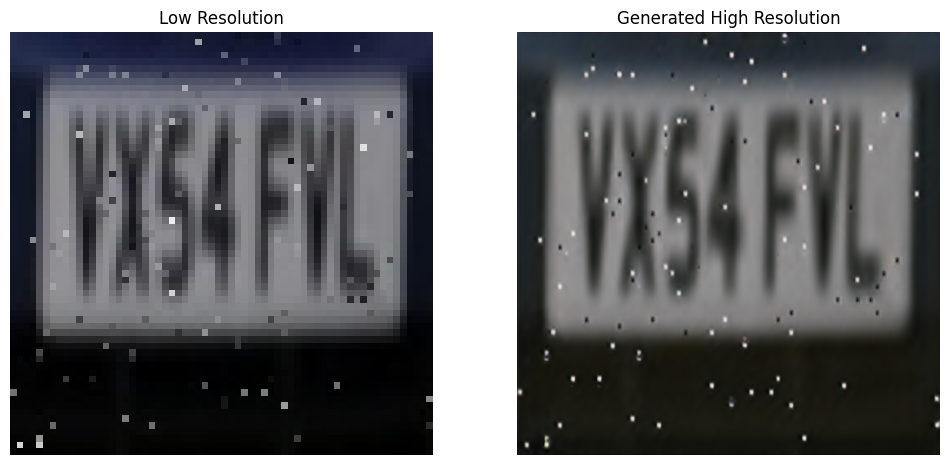

In [ ]:
def process_image(image_path, target_size):
    # 이미지 읽기 및 크기 조정
    img = imageio.imread(image_path)
    img = tf.image.resize(img, target_size)
    # 정규화
    img = img / 127.5 - 1.0
    return img

# 생성자 모델 정의 (build_generator 함수 사용)
generator = build_generator()

# 저장된 가중치 불러오기
i = 50000
generator.load_weights(f"/content/drive/generator_epoch_{i}.h5")
image_path = '/content/drive/img.jpg'

# 이미지 처리 및 차원 확장 (모델은 배치로 입력을 받기 때문)
low_res_img = process_image(image_path, (64, 64))
low_res_img = np.expand_dims(low_res_img, axis=0)

# 고해상도 이미지 생성
generated_img = generator.predict(low_res_img)

# 이미지 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Low Resolution")
plt.imshow((low_res_img[0] + 1) / 2) # 역정규화
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Generated High Resolution")
plt.imshow((generated_img[0] + 1) / 2) # 역정규화
plt.axis('off')

plt.show()
